# Artificial Intelligence Nanodegree

## Convolutional Neural Networks

## Project: Write an Algorithm for a Dog Identification App 

---

In this notebook, some template code has already been provided for you, and you will need to implement additional functionality to successfully complete this project. You will not need to modify the included code beyond what is requested. Sections that begin with **'(IMPLEMENTATION)'** in the header indicate that the following block of code will require additional functionality which you must provide. Instructions will be provided for each section, and the specifics of the implementation are marked in the code block with a 'TODO' statement. Please be sure to read the instructions carefully! 

> **Note**: Once you have completed all of the code implementations, you need to finalize your work by exporting the iPython Notebook as an HTML document. Before exporting the notebook to html, all of the code cells need to have been run so that reviewers can see the final implementation and output. You can then export the notebook by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question X'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut.  Markdown cells can be edited by double-clicking the cell to enter edit mode.

The rubric contains _optional_ "Stand Out Suggestions" for enhancing the project beyond the minimum requirements. If you decide to pursue the "Stand Out Suggestions", you should include the code in this IPython notebook.



---
### Why We're Here 

In this notebook, you will make the first steps towards developing an algorithm that could be used as part of a mobile or web app.  At the end of this project, your code will accept any user-supplied image as input.  If a dog is detected in the image, it will provide an estimate of the dog's breed.  If a human is detected, it will provide an estimate of the dog breed that is most resembling.  The image below displays potential sample output of your finished project (... but we expect that each student's algorithm will behave differently!). 

![Sample Dog Output](images/sample_dog_output.png)

In this real-world setting, you will need to piece together a series of models to perform different tasks; for instance, the algorithm that detects humans in an image will be different from the CNN that infers dog breed.  There are many points of possible failure, and no perfect algorithm exists.  Your imperfect solution will nonetheless create a fun user experience!

### The Road Ahead

We break the notebook into separate steps.  Feel free to use the links below to navigate the notebook.

* [Step 0](#step0): Import Datasets
* [Step 1](#step1): Detect Humans
* [Step 2](#step2): Detect Dogs
* [Step 3](#step3): Create a CNN to Classify Dog Breeds (from Scratch)
* [Step 4](#step4): Use a CNN to Classify Dog Breeds (using Transfer Learning)
* [Step 5](#step5): Create a CNN to Classify Dog Breeds (using Transfer Learning)
* [Step 6](#step6): Write your Algorithm
* [Step 7](#step7): Test Your Algorithm

---
<a id='step0'></a>
## Step 0: Import Datasets

### Import Dog Dataset

In the code cell below, we import a dataset of dog images.  We populate a few variables through the use of the `load_files` function from the scikit-learn library:
- `train_files`, `valid_files`, `test_files` - numpy arrays containing file paths to images
- `train_targets`, `valid_targets`, `test_targets` - numpy arrays containing onehot-encoded classification labels 
- `dog_names` - list of string-valued dog breed names for translating labels

In [1]:
from sklearn.datasets import load_files       
from keras.utils import np_utils
import numpy as np
from glob import glob

# define function to load train, test, and validation datasets
def load_dataset(path):
    data = load_files(path)
    dog_files = np.array(data['filenames'])
    dog_targets = np_utils.to_categorical(np.array(data['target']), 133)
    return dog_files, dog_targets

# load train, test, and validation datasets
train_files, train_targets = load_dataset('dogImages/train')
valid_files, valid_targets = load_dataset('dogImages/valid')
test_files, test_targets = load_dataset('dogImages/test')

# load list of dog names
dog_names = [item[20:-1] for item in sorted(glob("dogImages/train/*/"))]

# print statistics about the dataset
print('There are %d total dog categories.' % len(dog_names))
print('There are %s total dog images.\n' % len(np.hstack([train_files, valid_files, test_files])))
print('There are %d training dog images.' % len(train_files))
print('There are %d validation dog images.' % len(valid_files))
print('There are %d test dog images.'% len(test_files))

Using TensorFlow backend.


There are 133 total dog categories.
There are 8351 total dog images.

There are 6680 training dog images.
There are 835 validation dog images.
There are 836 test dog images.


### Import Human Dataset

In the code cell below, we import a dataset of human images, where the file paths are stored in the numpy array `human_files`.

In [2]:
import random
random.seed(8675309)

# load filenames in shuffled human dataset
human_files = np.array(glob("lfw/*/*"))
random.shuffle(human_files)

# print statistics about the dataset
print('There are %d total human images.' % len(human_files))

There are 13233 total human images.


---
<a id='step1'></a>
## Step 1: Detect Humans

We use OpenCV's implementation of [Haar feature-based cascade classifiers](http://docs.opencv.org/trunk/d7/d8b/tutorial_py_face_detection.html) to detect human faces in images.  OpenCV provides many pre-trained face detectors, stored as XML files on [github](https://github.com/opencv/opencv/tree/master/data/haarcascades).  We have downloaded one of these detectors and stored it in the `haarcascades` directory.

In the next code cell, we demonstrate how to use this detector to find human faces in a sample image.

Number of faces detected: 1


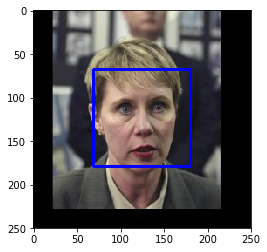

In [3]:
import cv2                
import matplotlib.pyplot as plt                        
%matplotlib inline                               

# extract pre-trained face detector
face_cascade = cv2.CascadeClassifier('haarcascades/haarcascade_frontalface_alt.xml')

def img_plotter(image):
    '''
    I just turned the preexisting code here into a function to help me with another function later on.
    '''
    # load color (BGR) image
    img = cv2.imread(image)
    # convert BGR image to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # find faces in image
    faces = face_cascade.detectMultiScale(gray)

    # print number of faces detected in the image
    print('Number of faces detected:', len(faces))

    # get bounding box for each detected face
    for (x,y,w,h) in faces:
        # add bounding box to color image
        cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)

    # convert BGR image to RGB for plotting
    cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # display the image, along with bounding box
    plt.imshow(cv_rgb)
    plt.show()
    
img_plotter(human_files[7])

Before using any of the face detectors, it is standard procedure to convert the images to grayscale.  The `detectMultiScale` function executes the classifier stored in `face_cascade` and takes the grayscale image as a parameter.  

In the above code, `faces` is a numpy array of detected faces, where each row corresponds to a detected face.  Each detected face is a 1D array with four entries that specifies the bounding box of the detected face.  The first two entries in the array (extracted in the above code as `x` and `y`) specify the horizontal and vertical positions of the top left corner of the bounding box.  The last two entries in the array (extracted here as `w` and `h`) specify the width and height of the box.

### Write a Human Face Detector

We can use this procedure to write a function that returns `True` if a human face is detected in an image and `False` otherwise.  This function, aptly named `face_detector`, takes a string-valued file path to an image as input and appears in the code block below.

In [4]:
# returns "True" if face is detected in image stored at img_path
def face_detector(img_path):
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray)
    return len(faces) > 0

### (IMPLEMENTATION) Assess the Human Face Detector

__Question 1:__ Use the code cell below to test the performance of the `face_detector` function.  
- What percentage of the first 100 images in `human_files` have a detected human face?  
- What percentage of the first 100 images in `dog_files` have a detected human face? 

Ideally, we would like 100% of human images with a detected face and 0% of dog images with a detected face.  You will see that our algorithm falls short of this goal, but still gives acceptable performance.  We extract the file paths for the first 100 images from each of the datasets and store them in the numpy arrays `human_files_short` and `dog_files_short`.

In [5]:
human_files_short = human_files[:100]
dog_files_short = train_files[:100]
# Do NOT modify the code above this line.

## TODONE: Test the performance of the face_detector algorithm 
## on the images in human_files_short and dog_files_short.
def loader(multi_files, function=face_detector):
    results = []
    for file in multi_files:
        results.append(function(file))
    return results

def counter(multi_files, function=face_detector):
    answer = np.sum(loader(multi_files, function)) / len(multi_files)
    return "{:.0%}".format(answer)

print(counter(human_files_short))
print(counter(dog_files_short))

99%
12%


__Answer 1:__ 

- There are 99 detected human faces in the first 100 human_files, or 99% detection.
- There are 12 detected human faces in the first 100 dog_files, or 12% detection (oddly enough).

__Question 2:__ This algorithmic choice necessitates that we communicate to the user that we accept human images only when they provide a clear view of a face (otherwise, we risk having unneccessarily frustrated users!). In your opinion, is this a reasonable expectation to pose on the user? If not, can you think of a way to detect humans in images that does not necessitate an image with a clearly presented face?

__Answer 2:__

This could be a reasonable expectation, but I can understand instances where users might want to try to play with it and see what type of dog the model thinks their cat is, or whatnot.  Perhaps, a better option is just to display a warning message such as: "Warning: the model didn't detect a human face in this picture.  While you can proceed and see what the model thinks of this picture as-is, we suggest using one with a clearly visible human face for the best results."

Alternatively, we could train the human detector on pictures including more parts of humans so that it could detect human bodies, torsos, arms, legs, etc. even when a face is not clearly visible.  However, that approach probably wouldn't capture the full uniqueness of a person that a face does.

__Note:__ We suggest the face detector from OpenCV as a potential way to detect human images in your algorithm, but you are free to explore other approaches, especially approaches that make use of deep learning :).  Please use the code cell below to design and test your own face detection algorithm.  If you decide to pursue this _optional_ task, report performance on each of the datasets.

In [6]:
## (Optional) TODONE: Report the performance of another  
## face detection algorithm on the LFW dataset
### Feel free to use as many code cells as needed.

'''
LOL, so I found this article which seemed promising:
https://medium.com/wassa/modern-face-detection-based-on-deep-learning-using-python-and-mxnet-5e6377f22674
But then after spending a few hours getting everything installed and configured, I got to the end and realized that it was
a real-time face detection model and not a batch model.  And it took a few hours because there were various filesystem errors
with almost every module expecting to find other files in a different location from where they actually were.  I fixed all
those bugs and now I've asked the owner for permission to create a bug fixing branch to commit those fixes to master.

I can happily say that I got that mxnet face detector working, but with that much time spent on something not relevant to this
optional step, I'm happy to accept the 99% accuracy of the OpenCV model above, even if it is a little overzealous with dogs
(or maybe it isn't and those 12 pictures just had humans in the pictures with the dogs[UPDATE: Guess I was only right about 1
of these pictures having a human in it]).

What I will do for this optional step is create a function that pulls in the false positives or false negatives, and displays
those pictures.
'''

def false_investigator(multi_files, function=face_detector, false_positives=True):
    '''
    Change false_positives to False if you want to investigate false negatives.
    '''
    results = loader(multi_files, function)
    if false_positives:
        indices = [i for i, x in enumerate(results) if x == True]
        if len(indices) == 0:
            return "None were found"
        for index in indices:
            img_plotter(multi_files[index])
    elif false_positives is False:
        indices = [i for i, x in enumerate(results) if x == False]
        if len(indices) == 0:
            return "None were found"
        for index in indices:
            img_plotter(multi_files[index])
    else:
        return 'Error: incorrect configuration of False Positives or False Negatives flag'
        

Number of faces detected: 0


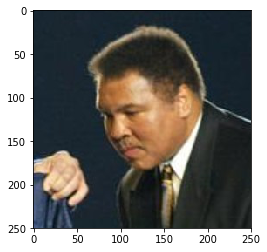

In [7]:
false_investigator(human_files_short, false_positives=False)

Number of faces detected: 1


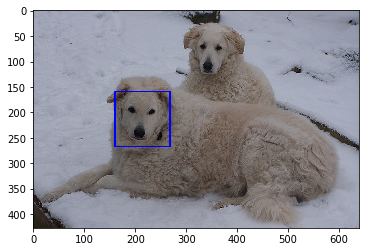

Number of faces detected: 1


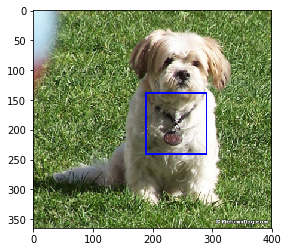

Number of faces detected: 1


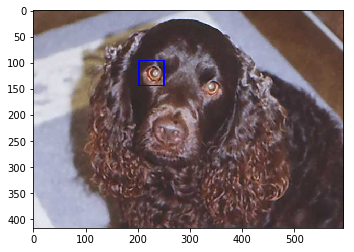

Number of faces detected: 1


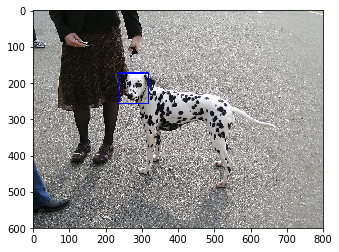

Number of faces detected: 1


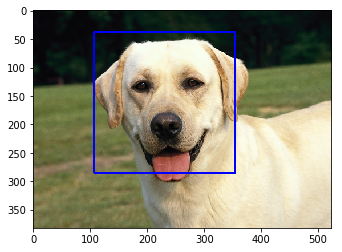

Number of faces detected: 1


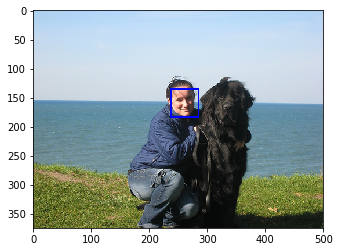

Number of faces detected: 1


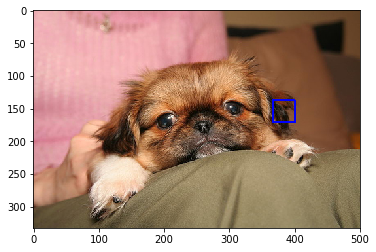

Number of faces detected: 1


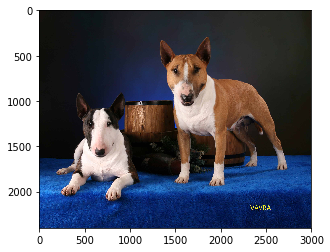

Number of faces detected: 1


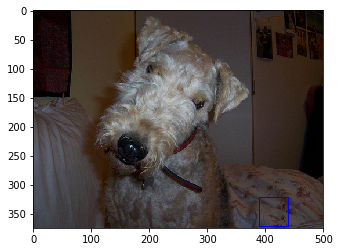

Number of faces detected: 1


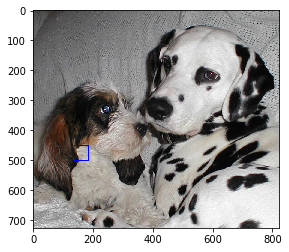

Number of faces detected: 1


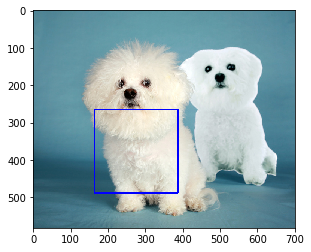

Number of faces detected: 1


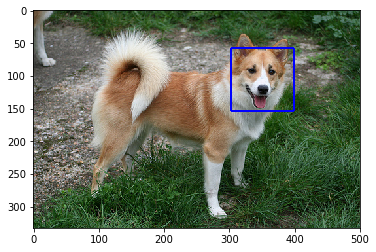

In [8]:
false_investigator(dog_files_short)

---
<a id='step2'></a>
## Step 2: Detect Dogs

In this section, we use a pre-trained [ResNet-50](http://ethereon.github.io/netscope/#/gist/db945b393d40bfa26006) model to detect dogs in images.  Our first line of code downloads the ResNet-50 model, along with weights that have been trained on [ImageNet](http://www.image-net.org/), a very large, very popular dataset used for image classification and other vision tasks.  ImageNet contains over 10 million URLs, each linking to an image containing an object from one of [1000 categories](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a).  Given an image, this pre-trained ResNet-50 model returns a prediction (derived from the available categories in ImageNet) for the object that is contained in the image.

In [9]:
from keras.applications.resnet50 import ResNet50

# define ResNet50 model
ResNet50_model = ResNet50(weights='imagenet')

### Pre-process the Data

When using TensorFlow as backend, Keras CNNs require a 4D array (which we'll also refer to as a 4D tensor) as input, with shape

$$
(\text{nb_samples}, \text{rows}, \text{columns}, \text{channels}),
$$

where `nb_samples` corresponds to the total number of images (or samples), and `rows`, `columns`, and `channels` correspond to the number of rows, columns, and channels for each image, respectively.  

The `path_to_tensor` function below takes a string-valued file path to a color image as input and returns a 4D tensor suitable for supplying to a Keras CNN.  The function first loads the image and resizes it to a square image that is $224 \times 224$ pixels.  Next, the image is converted to an array, which is then resized to a 4D tensor.  In this case, since we are working with color images, each image has three channels.  Likewise, since we are processing a single image (or sample), the returned tensor will always have shape

$$
(1, 224, 224, 3).
$$

The `paths_to_tensor` function takes a numpy array of string-valued image paths as input and returns a 4D tensor with shape 

$$
(\text{nb_samples}, 224, 224, 3).
$$

Here, `nb_samples` is the number of samples, or number of images, in the supplied array of image paths.  It is best to think of `nb_samples` as the number of 3D tensors (where each 3D tensor corresponds to a different image) in your dataset!

In [10]:
from keras.preprocessing import image                  
from tqdm import tqdm

def path_to_tensor(img_path):
    # loads RGB image as PIL.Image.Image type
    img = image.load_img(img_path, target_size=(224, 224))
    # convert PIL.Image.Image type to 3D tensor with shape (224, 224, 3)
    x = image.img_to_array(img)
    # convert 3D tensor to 4D tensor with shape (1, 224, 224, 3) and return 4D tensor
    return np.expand_dims(x, axis=0)

def paths_to_tensor(img_paths):
    list_of_tensors = [path_to_tensor(img_path) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)

### Making Predictions with ResNet-50

Getting the 4D tensor ready for ResNet-50, and for any other pre-trained model in Keras, requires some additional processing.  First, the RGB image is converted to BGR by reordering the channels.  All pre-trained models have the additional normalization step that the mean pixel (expressed in RGB as $[103.939, 116.779, 123.68]$ and calculated from all pixels in all images in ImageNet) must be subtracted from every pixel in each image.  This is implemented in the imported function `preprocess_input`.  If you're curious, you can check the code for `preprocess_input` [here](https://github.com/fchollet/keras/blob/master/keras/applications/imagenet_utils.py).

Now that we have a way to format our image for supplying to ResNet-50, we are now ready to use the model to extract the predictions.  This is accomplished with the `predict` method, which returns an array whose $i$-th entry is the model's predicted probability that the image belongs to the $i$-th ImageNet category.  This is implemented in the `ResNet50_predict_labels` function below.

By taking the argmax of the predicted probability vector, we obtain an integer corresponding to the model's predicted object class, which we can identify with an object category through the use of this [dictionary](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a). 

In [11]:
from keras.applications.resnet50 import preprocess_input, decode_predictions

def ResNet50_predict_labels(img_path):
    # returns prediction vector for image located at img_path
    img = preprocess_input(path_to_tensor(img_path))
    return np.argmax(ResNet50_model.predict(img))

### Write a Dog Detector

While looking at the [dictionary](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a), you will notice that the categories corresponding to dogs appear in an uninterrupted sequence and correspond to dictionary keys 151-268, inclusive, to include all categories from `'Chihuahua'` to `'Mexican hairless'`.  Thus, in order to check to see if an image is predicted to contain a dog by the pre-trained ResNet-50 model, we need only check if the `ResNet50_predict_labels` function above returns a value between 151 and 268 (inclusive).

We use these ideas to complete the `dog_detector` function below, which returns `True` if a dog is detected in an image (and `False` if not).

In [12]:
### returns "True" if a dog is detected in the image stored at img_path
def dog_detector(img_path):
    prediction = ResNet50_predict_labels(img_path)
    return ((prediction <= 268) & (prediction >= 151)) 

### (IMPLEMENTATION) Assess the Dog Detector

__Question 3:__ Use the code cell below to test the performance of your `dog_detector` function.  
- What percentage of the images in `human_files_short` have a detected dog?  
- What percentage of the images in `dog_files_short` have a detected dog?

In [13]:
### TODONE: Test the performance of the dog_detector function
### on the images in human_files_short and dog_files_short.

print(counter(human_files_short, dog_detector))
print(counter(dog_files_short, dog_detector))

1%
100%


__Answer 3:__

- There is 1 detected dog in the first 100 human_files, or 01% detection.
- There are 100 detected human faces in the first 100 dog_files, or 100% detection.

Number of faces detected: 1


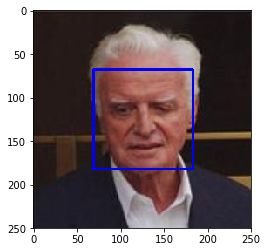

In [14]:
# And just for fun, let's investigate any false positives (and false negatives if there were any)!

false_investigator(human_files_short, dog_detector)

# Yes, I know the human's face below is boxed, but training CV2 to bound-box the "dog" would have been too much extra credit. ;)

In [15]:
false_investigator(dog_files_short, dog_detector, false_positives=False)

'None were found'

---
<a id='step3'></a>
## Step 3: Create a CNN to Classify Dog Breeds (from Scratch)

Now that we have functions for detecting humans and dogs in images, we need a way to predict breed from images.  In this step, you will create a CNN that classifies dog breeds.  You must create your CNN _from scratch_ (so, you can't use transfer learning _yet_!), and you must attain a test accuracy of at least 1%.  In Step 5 of this notebook, you will have the opportunity to use transfer learning to create a CNN that attains greatly improved accuracy.

Be careful with adding too many trainable layers!  More parameters means longer training, which means you are more likely to need a GPU to accelerate the training process.  Thankfully, Keras provides a handy estimate of the time that each epoch is likely to take; you can extrapolate this estimate to figure out how long it will take for your algorithm to train. 

We mention that the task of assigning breed to dogs from images is considered exceptionally challenging.  To see why, consider that *even a human* would have great difficulty in distinguishing between a Brittany and a Welsh Springer Spaniel.  

Brittany | Welsh Springer Spaniel
- | - 
<img src="images/Brittany_02625.jpg" width="100"> | <img src="images/Welsh_springer_spaniel_08203.jpg" width="200">

It is not difficult to find other dog breed pairs with minimal inter-class variation (for instance, Curly-Coated Retrievers and American Water Spaniels).  

Curly-Coated Retriever | American Water Spaniel
- | -
<img src="images/Curly-coated_retriever_03896.jpg" width="200"> | <img src="images/American_water_spaniel_00648.jpg" width="200">


Likewise, recall that labradors come in yellow, chocolate, and black.  Your vision-based algorithm will have to conquer this high intra-class variation to determine how to classify all of these different shades as the same breed.  

Yellow Labrador | Chocolate Labrador | Black Labrador
- | -
<img src="images/Labrador_retriever_06457.jpg" width="150"> | <img src="images/Labrador_retriever_06455.jpg" width="240"> | <img src="images/Labrador_retriever_06449.jpg" width="220">

We also mention that random chance presents an exceptionally low bar: setting aside the fact that the classes are slightly imabalanced, a random guess will provide a correct answer roughly 1 in 133 times, which corresponds to an accuracy of less than 1%.  

Remember that the practice is far ahead of the theory in deep learning.  Experiment with many different architectures, and trust your intuition.  And, of course, have fun! 

### Pre-process the Data

We rescale the images by dividing every pixel in every image by 255.

In [16]:
from PIL import ImageFile                            
ImageFile.LOAD_TRUNCATED_IMAGES = True                 

# pre-process the data for Keras
train_tensors = paths_to_tensor(train_files).astype('float32')/255
valid_tensors = paths_to_tensor(valid_files).astype('float32')/255
test_tensors = paths_to_tensor(test_files).astype('float32')/255

100%|██████████████████████████████████████████████████████████| 836/836 [00:08<00:00, 95.24it/s]


### (IMPLEMENTATION) Model Architecture

Create a CNN to classify dog breed.  At the end of your code cell block, summarize the layers of your model by executing the line:
    
        model.summary()

We have imported some Python modules to get you started, but feel free to import as many modules as you need.  If you end up getting stuck, here's a hint that specifies a model that trains relatively fast on CPU and attains >1% test accuracy in 5 epochs:

![Sample CNN](images/sample_cnn.png)
           
__Question 4:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  If you chose to use the hinted architecture above, describe why you think that CNN architecture should work well for the image classification task.

In [17]:
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Dropout, Flatten, Dense
from keras.models import Sequential

model = Sequential()

### TODO: Define your architecture.
model.add(Conv2D(filters=16, kernel_size=4, padding='same', activation='relu', 
                        input_shape=(224, 224, 3)))
model.add(MaxPooling2D(pool_size=4))
model.add(Conv2D(filters=32, kernel_size=2, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(filters=64, kernel_size=2, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(filters=133, kernel_size=2, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.3))
model.add(GlobalAveragePooling2D(input_shape=(7, 7, 512)))
model.add(Dense(133, activation='softmax'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 224, 224, 16)      784       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 56, 56, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 56, 56, 32)        2080      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 28, 28, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 28, 28, 64)        8256      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 14, 14, 133)       34181     
__________

__Answer 4:__ 

I started out with the last from-scratch CNN that I had run (the one from the CIFAR-10 notebook), and then swapped out the first dense layer with a GAP layer (like had been done for the faster model on the Transfer Learning notebook).  Then I realized that my model was exactly the same as the model hinted at above (except for the dropout layer).  So then I decided to tweak the numbers a bit: widening the first kernel and Max Pooling layers, and increasing the filters on the last Conv layer to match the Dense layer.  I later added another Conv layer and Max Pooling to see if I could get even better results.  And just for fun, I also added in some minimal image augmentation.

This hinted archetecture could work well because it has several layers that start out general and then get decently specific.  However, it's clearly a more simplified model that appears to be designed to train relatively quickly, even on weaker hardware.

### Compile the Model

In [18]:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

### (IMPLEMENTATION) Train the Model

Train your model in the code cell below.  Use model checkpointing to save the model that attains the best validation loss.

You are welcome to [augment the training data](https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html), but this is not a requirement. 

In [19]:
# Challenge Accepted!  Here's some basic Image Augmentation

from keras.preprocessing.image import ImageDataGenerator

datagen_train = ImageDataGenerator(
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True)

datagen_valid = datagen_train

datagen_train.fit(train_tensors)
datagen_valid.fit(valid_tensors)

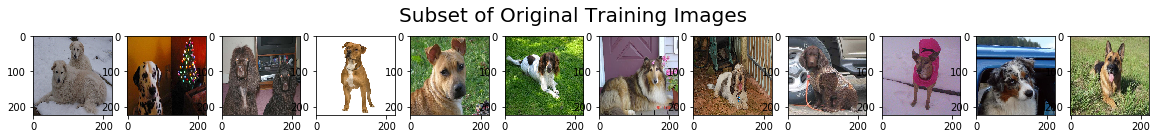

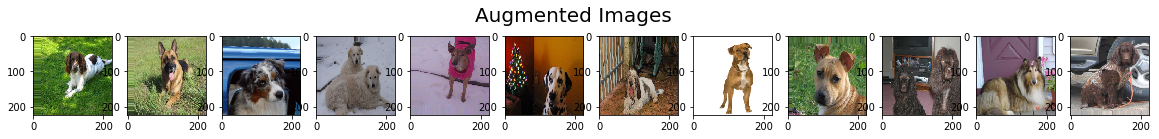

In [20]:
# Visualizing the Augmented Images

import matplotlib.pyplot as plt

train_subset = train_tensors[:12]

fig = plt.figure(figsize=(20,2))
for i in range(0, len(train_subset)):
    ax = fig.add_subplot(1, 12, i+1)
    ax.imshow(train_subset[i])
fig.suptitle('Subset of Original Training Images', fontsize=20)
plt.show()

fig = plt.figure(figsize=(20,2))
for x_batch in datagen_train.flow(train_subset, batch_size=12):
    for i in range(0, 12):
        ax = fig.add_subplot(1, 12, i+1)
        ax.imshow(x_batch[i])
    fig.suptitle('Augmented Images', fontsize=20)
    plt.show()
    break;

In [21]:
from keras.callbacks import ModelCheckpoint  

### TODONE: specify the number of epochs that you would like to use to train the model.

epochs = 200

batch_size = 20

### Do NOT modify the code below this line.

checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.from_scratch.hdf5', 
                               verbose=1, save_best_only=True)
'''
# Instead of modifying the model.fit, I had to use fit_generator due to using image augmentation,
    but don't worry I used the same parameters (though I would have prefered to use verbose=2).
    
model.fit(train_tensors, train_targets, 
          validation_data=(valid_tensors, valid_targets),
          epochs=epochs, batch_size=20, callbacks=[checkpointer], verbose=1)
'''

model.fit_generator(datagen_train.flow(train_tensors, train_targets, batch_size=batch_size),
                    steps_per_epoch=train_tensors.shape[0] // batch_size,
                    epochs=epochs, verbose=1, callbacks=[checkpointer],
                    validation_data=datagen_valid.flow(valid_tensors, valid_targets, batch_size=batch_size),
                    validation_steps=valid_tensors.shape[0] // batch_size)

Epoch 1/200


216/334 [==================>...........] - ETA: 28:12 - loss: 4.9087 - acc: 0.0000e+ - ETA: 9:29 - loss: 4.9111 - acc: 0.0000e+00 - ETA: 5:45 - loss: 4.9033 - acc: 0.0000e+0 - ETA: 4:09 - loss: 4.8981 - acc: 0.0000e+0 - ETA: 3:15 - loss: 4.8939 - acc: 0.0000e+0 - ETA: 2:41 - loss: 4.8896 - acc: 0.0000e+0 - ETA: 2:17 - loss: 4.8943 - acc: 0.0000e+0 - ETA: 2:03 - loss: 4.8919 - acc: 0.0033    - ETA: 1:59 - loss: 4.8917 - acc: 0.003 - ETA: 1:56 - loss: 4.8917 - acc: 0.005 - ETA: 1:53 - loss: 4.8904 - acc: 0.005 - ETA: 1:51 - loss: 4.8912 - acc: 0.005 - ETA: 1:48 - loss: 4.8906 - acc: 0.005 - ETA: 1:45 - loss: 4.8918 - acc: 0.004 - ETA: 1:43 - loss: 4.8921 - acc: 0.004 - ETA: 1:41 - loss: 4.8914 - acc: 0.006 - ETA: 1:40 - loss: 4.8926 - acc: 0.006 - ETA: 1:39 - loss: 4.8933 - acc: 0.006 - ETA: 1:37 - loss: 4.8940 - acc: 0.005 - ETA: 1:36 - loss: 4.8937 - acc: 0.005 - ETA: 1:35 - loss: 4.8930 - acc: 0.007 - ETA: 1:35 - loss: 4.8937 - acc: 0.006 - ETA: 1:34 - loss: 4.8937 - acc: 0.008 - ETA:

334/334 [==============================] - ETA: 27s - loss: 4.8857 - acc: 0.01 - ETA: 27s - loss: 4.8857 - acc: 0.01 - ETA: 26s - loss: 4.8857 - acc: 0.01 - ETA: 26s - loss: 4.8856 - acc: 0.01 - ETA: 26s - loss: 4.8855 - acc: 0.01 - ETA: 26s - loss: 4.8855 - acc: 0.01 - ETA: 25s - loss: 4.8855 - acc: 0.01 - ETA: 25s - loss: 4.8853 - acc: 0.01 - ETA: 25s - loss: 4.8857 - acc: 0.01 - ETA: 25s - loss: 4.8856 - acc: 0.01 - ETA: 24s - loss: 4.8855 - acc: 0.00 - ETA: 24s - loss: 4.8856 - acc: 0.00 - ETA: 24s - loss: 4.8856 - acc: 0.01 - ETA: 24s - loss: 4.8857 - acc: 0.01 - ETA: 23s - loss: 4.8856 - acc: 0.01 - ETA: 23s - loss: 4.8856 - acc: 0.00 - ETA: 23s - loss: 4.8855 - acc: 0.00 - ETA: 23s - loss: 4.8858 - acc: 0.00 - ETA: 22s - loss: 4.8858 - acc: 0.00 - ETA: 22s - loss: 4.8858 - acc: 0.01 - ETA: 22s - loss: 4.8856 - acc: 0.00 - ETA: 22s - loss: 4.8857 - acc: 0.01 - ETA: 21s - loss: 4.8857 - acc: 0.01 - ETA: 21s - loss: 4.8856 - acc: 0.01 - ETA: 21s - loss: 4.8856 - acc: 0.01 - ETA: 21

220/334 [==================>...........] - ETA: 11s - loss: 4.8826 - acc: 0.0000e+ - ETA: 14s - loss: 4.8558 - acc: 0.0000e+ - ETA: 14s - loss: 4.8647 - acc: 0.0125   - ETA: 13s - loss: 4.8745 - acc: 0.00 - ETA: 13s - loss: 4.8741 - acc: 0.01 - ETA: 13s - loss: 4.8689 - acc: 0.02 - ETA: 13s - loss: 4.8621 - acc: 0.02 - ETA: 15s - loss: 4.8638 - acc: 0.01 - ETA: 19s - loss: 4.8628 - acc: 0.01 - ETA: 23s - loss: 4.8618 - acc: 0.01 - ETA: 25s - loss: 4.8643 - acc: 0.01 - ETA: 28s - loss: 4.8632 - acc: 0.01 - ETA: 31s - loss: 4.8661 - acc: 0.01 - ETA: 34s - loss: 4.8645 - acc: 0.01 - ETA: 36s - loss: 4.8624 - acc: 0.01 - ETA: 38s - loss: 4.8565 - acc: 0.02 - ETA: 40s - loss: 4.8537 - acc: 0.02 - ETA: 41s - loss: 4.8459 - acc: 0.02 - ETA: 43s - loss: 4.8471 - acc: 0.02 - ETA: 44s - loss: 4.8481 - acc: 0.02 - ETA: 45s - loss: 4.8487 - acc: 0.02 - ETA: 47s - loss: 4.8452 - acc: 0.02 - ETA: 48s - loss: 4.8485 - acc: 0.01 - ETA: 49s - loss: 4.8470 - acc: 0.01 - ETA: 49s - loss: 4.8467 - acc: 0.

334/334 [==============================] - ETA: 23s - loss: 4.8634 - acc: 0.01 - ETA: 23s - loss: 4.8632 - acc: 0.01 - ETA: 23s - loss: 4.8633 - acc: 0.01 - ETA: 23s - loss: 4.8635 - acc: 0.01 - ETA: 22s - loss: 4.8634 - acc: 0.01 - ETA: 22s - loss: 4.8633 - acc: 0.01 - ETA: 22s - loss: 4.8631 - acc: 0.01 - ETA: 22s - loss: 4.8629 - acc: 0.01 - ETA: 22s - loss: 4.8630 - acc: 0.01 - ETA: 22s - loss: 4.8631 - acc: 0.01 - ETA: 22s - loss: 4.8628 - acc: 0.01 - ETA: 21s - loss: 4.8626 - acc: 0.01 - ETA: 21s - loss: 4.8627 - acc: 0.01 - ETA: 21s - loss: 4.8627 - acc: 0.01 - ETA: 21s - loss: 4.8626 - acc: 0.01 - ETA: 21s - loss: 4.8624 - acc: 0.01 - ETA: 20s - loss: 4.8624 - acc: 0.01 - ETA: 20s - loss: 4.8621 - acc: 0.01 - ETA: 20s - loss: 4.8619 - acc: 0.01 - ETA: 20s - loss: 4.8617 - acc: 0.01 - ETA: 20s - loss: 4.8620 - acc: 0.01 - ETA: 19s - loss: 4.8619 - acc: 0.01 - ETA: 19s - loss: 4.8619 - acc: 0.01 - ETA: 19s - loss: 4.8620 - acc: 0.01 - ETA: 19s - loss: 4.8619 - acc: 0.01 - ETA: 18

221/334 [==================>...........] - ETA: 12s - loss: 4.8711 - acc: 0.0000e+ - ETA: 12s - loss: 4.8660 - acc: 0.0000e+ - ETA: 12s - loss: 4.8504 - acc: 0.0000e+ - ETA: 12s - loss: 4.8523 - acc: 0.0000e+ - ETA: 12s - loss: 4.8496 - acc: 0.0000e+ - ETA: 12s - loss: 4.8656 - acc: 0.0000e+ - ETA: 13s - loss: 4.8688 - acc: 0.0077   - ETA: 17s - loss: 4.8692 - acc: 0.00 - ETA: 21s - loss: 4.8659 - acc: 0.01 - ETA: 24s - loss: 4.8611 - acc: 0.00 - ETA: 26s - loss: 4.8521 - acc: 0.00 - ETA: 28s - loss: 4.8624 - acc: 0.00 - ETA: 30s - loss: 4.8636 - acc: 0.00 - ETA: 31s - loss: 4.8683 - acc: 0.00 - ETA: 33s - loss: 4.8674 - acc: 0.00 - ETA: 34s - loss: 4.8665 - acc: 0.00 - ETA: 35s - loss: 4.8646 - acc: 0.00 - ETA: 36s - loss: 4.8648 - acc: 0.00 - ETA: 38s - loss: 4.8637 - acc: 0.00 - ETA: 39s - loss: 4.8618 - acc: 0.00 - ETA: 40s - loss: 4.8625 - acc: 0.00 - ETA: 41s - loss: 4.8604 - acc: 0.00 - ETA: 42s - loss: 4.8585 - acc: 0.00 - ETA: 43s - loss: 4.8552 - acc: 0.00 - ETA: 44s - loss: 

334/334 [==============================] - ETA: 21s - loss: 4.8118 - acc: 0.01 - ETA: 21s - loss: 4.8119 - acc: 0.01 - ETA: 21s - loss: 4.8115 - acc: 0.01 - ETA: 21s - loss: 4.8114 - acc: 0.01 - ETA: 21s - loss: 4.8116 - acc: 0.01 - ETA: 20s - loss: 4.8113 - acc: 0.01 - ETA: 20s - loss: 4.8116 - acc: 0.01 - ETA: 20s - loss: 4.8115 - acc: 0.01 - ETA: 20s - loss: 4.8121 - acc: 0.01 - ETA: 20s - loss: 4.8125 - acc: 0.01 - ETA: 19s - loss: 4.8123 - acc: 0.01 - ETA: 19s - loss: 4.8123 - acc: 0.01 - ETA: 19s - loss: 4.8124 - acc: 0.01 - ETA: 19s - loss: 4.8122 - acc: 0.01 - ETA: 19s - loss: 4.8124 - acc: 0.01 - ETA: 18s - loss: 4.8135 - acc: 0.01 - ETA: 18s - loss: 4.8135 - acc: 0.01 - ETA: 18s - loss: 4.8132 - acc: 0.01 - ETA: 18s - loss: 4.8132 - acc: 0.01 - ETA: 18s - loss: 4.8129 - acc: 0.01 - ETA: 17s - loss: 4.8126 - acc: 0.01 - ETA: 17s - loss: 4.8128 - acc: 0.01 - ETA: 17s - loss: 4.8127 - acc: 0.01 - ETA: 17s - loss: 4.8123 - acc: 0.01 - ETA: 17s - loss: 4.8117 - acc: 0.01 - ETA: 16

216/334 [==================>...........] - ETA: 13s - loss: 4.7303 - acc: 0.0000e+ - ETA: 13s - loss: 4.7483 - acc: 0.0167   - ETA: 13s - loss: 4.7838 - acc: 0.01 - ETA: 12s - loss: 4.7925 - acc: 0.00 - ETA: 12s - loss: 4.7712 - acc: 0.01 - ETA: 12s - loss: 4.7755 - acc: 0.01 - ETA: 13s - loss: 4.7737 - acc: 0.01 - ETA: 19s - loss: 4.7703 - acc: 0.01 - ETA: 24s - loss: 4.7644 - acc: 0.01 - ETA: 29s - loss: 4.7625 - acc: 0.01 - ETA: 33s - loss: 4.7616 - acc: 0.01 - ETA: 36s - loss: 4.7520 - acc: 0.01 - ETA: 41s - loss: 4.7612 - acc: 0.01 - ETA: 44s - loss: 4.7654 - acc: 0.01 - ETA: 47s - loss: 4.7690 - acc: 0.01 - ETA: 49s - loss: 4.7616 - acc: 0.01 - ETA: 50s - loss: 4.7578 - acc: 0.01 - ETA: 51s - loss: 4.7577 - acc: 0.01 - ETA: 52s - loss: 4.7621 - acc: 0.02 - ETA: 55s - loss: 4.7639 - acc: 0.02 - ETA: 56s - loss: 4.7662 - acc: 0.02 - ETA: 57s - loss: 4.7655 - acc: 0.02 - ETA: 57s - loss: 4.7675 - acc: 0.01 - ETA: 58s - loss: 4.7642 - acc: 0.02 - ETA: 59s - loss: 4.7653 - acc: 0.02 -

334/334 [==============================] - ETA: 27s - loss: 4.7558 - acc: 0.02 - ETA: 27s - loss: 4.7555 - acc: 0.02 - ETA: 27s - loss: 4.7556 - acc: 0.02 - ETA: 27s - loss: 4.7549 - acc: 0.02 - ETA: 26s - loss: 4.7544 - acc: 0.02 - ETA: 26s - loss: 4.7538 - acc: 0.02 - ETA: 26s - loss: 4.7544 - acc: 0.02 - ETA: 26s - loss: 4.7540 - acc: 0.02 - ETA: 25s - loss: 4.7540 - acc: 0.02 - ETA: 25s - loss: 4.7532 - acc: 0.02 - ETA: 25s - loss: 4.7532 - acc: 0.02 - ETA: 25s - loss: 4.7527 - acc: 0.02 - ETA: 24s - loss: 4.7525 - acc: 0.02 - ETA: 24s - loss: 4.7524 - acc: 0.02 - ETA: 24s - loss: 4.7523 - acc: 0.02 - ETA: 24s - loss: 4.7530 - acc: 0.02 - ETA: 23s - loss: 4.7524 - acc: 0.02 - ETA: 23s - loss: 4.7530 - acc: 0.02 - ETA: 23s - loss: 4.7530 - acc: 0.02 - ETA: 23s - loss: 4.7537 - acc: 0.02 - ETA: 22s - loss: 4.7542 - acc: 0.02 - ETA: 22s - loss: 4.7546 - acc: 0.02 - ETA: 22s - loss: 4.7548 - acc: 0.02 - ETA: 22s - loss: 4.7552 - acc: 0.02 - ETA: 21s - loss: 4.7549 - acc: 0.02 - ETA: 21

221/334 [==================>...........] - ETA: 12s - loss: 4.8723 - acc: 0.05 - ETA: 12s - loss: 4.7273 - acc: 0.05 - ETA: 12s - loss: 4.6775 - acc: 0.04 - ETA: 12s - loss: 4.6309 - acc: 0.05 - ETA: 12s - loss: 4.6269 - acc: 0.04 - ETA: 11s - loss: 4.6352 - acc: 0.05 - ETA: 14s - loss: 4.6365 - acc: 0.04 - ETA: 18s - loss: 4.6294 - acc: 0.04 - ETA: 22s - loss: 4.6360 - acc: 0.04 - ETA: 25s - loss: 4.6284 - acc: 0.04 - ETA: 27s - loss: 4.6389 - acc: 0.04 - ETA: 29s - loss: 4.6387 - acc: 0.04 - ETA: 31s - loss: 4.6456 - acc: 0.04 - ETA: 33s - loss: 4.6292 - acc: 0.04 - ETA: 34s - loss: 4.6269 - acc: 0.04 - ETA: 36s - loss: 4.6380 - acc: 0.04 - ETA: 37s - loss: 4.6525 - acc: 0.03 - ETA: 38s - loss: 4.6572 - acc: 0.03 - ETA: 39s - loss: 4.6606 - acc: 0.04 - ETA: 40s - loss: 4.6535 - acc: 0.04 - ETA: 40s - loss: 4.6667 - acc: 0.04 - ETA: 41s - loss: 4.6747 - acc: 0.03 - ETA: 42s - loss: 4.6766 - acc: 0.03 - ETA: 42s - loss: 4.6760 - acc: 0.03 - ETA: 43s - loss: 4.6747 - acc: 0.03 - ETA: 43

334/334 [==============================] - ETA: 23s - loss: 4.6748 - acc: 0.03 - ETA: 23s - loss: 4.6736 - acc: 0.03 - ETA: 23s - loss: 4.6746 - acc: 0.03 - ETA: 23s - loss: 4.6743 - acc: 0.03 - ETA: 22s - loss: 4.6747 - acc: 0.03 - ETA: 22s - loss: 4.6756 - acc: 0.03 - ETA: 22s - loss: 4.6758 - acc: 0.03 - ETA: 22s - loss: 4.6757 - acc: 0.03 - ETA: 22s - loss: 4.6769 - acc: 0.03 - ETA: 21s - loss: 4.6773 - acc: 0.03 - ETA: 21s - loss: 4.6773 - acc: 0.03 - ETA: 21s - loss: 4.6780 - acc: 0.03 - ETA: 21s - loss: 4.6776 - acc: 0.03 - ETA: 21s - loss: 4.6774 - acc: 0.03 - ETA: 20s - loss: 4.6778 - acc: 0.03 - ETA: 20s - loss: 4.6780 - acc: 0.03 - ETA: 20s - loss: 4.6778 - acc: 0.03 - ETA: 20s - loss: 4.6789 - acc: 0.03 - ETA: 19s - loss: 4.6790 - acc: 0.03 - ETA: 19s - loss: 4.6786 - acc: 0.03 - ETA: 19s - loss: 4.6782 - acc: 0.03 - ETA: 19s - loss: 4.6773 - acc: 0.03 - ETA: 19s - loss: 4.6768 - acc: 0.03 - ETA: 18s - loss: 4.6767 - acc: 0.03 - ETA: 18s - loss: 4.6762 - acc: 0.03 - ETA: 18

221/334 [==================>...........] - ETA: 12s - loss: 4.6677 - acc: 0.0000e+ - ETA: 12s - loss: 4.6461 - acc: 0.0333   - ETA: 12s - loss: 4.6996 - acc: 0.03 - ETA: 12s - loss: 4.6443 - acc: 0.04 - ETA: 12s - loss: 4.6056 - acc: 0.03 - ETA: 11s - loss: 4.6151 - acc: 0.04 - ETA: 13s - loss: 4.6021 - acc: 0.04 - ETA: 17s - loss: 4.6060 - acc: 0.04 - ETA: 20s - loss: 4.6081 - acc: 0.04 - ETA: 23s - loss: 4.6173 - acc: 0.04 - ETA: 25s - loss: 4.6213 - acc: 0.04 - ETA: 27s - loss: 4.6101 - acc: 0.03 - ETA: 28s - loss: 4.5859 - acc: 0.04 - ETA: 30s - loss: 4.5825 - acc: 0.04 - ETA: 31s - loss: 4.5810 - acc: 0.03 - ETA: 33s - loss: 4.5904 - acc: 0.03 - ETA: 34s - loss: 4.5825 - acc: 0.03 - ETA: 34s - loss: 4.5860 - acc: 0.04 - ETA: 35s - loss: 4.5819 - acc: 0.04 - ETA: 36s - loss: 4.5791 - acc: 0.04 - ETA: 37s - loss: 4.5822 - acc: 0.04 - ETA: 37s - loss: 4.5844 - acc: 0.04 - ETA: 38s - loss: 4.5806 - acc: 0.04 - ETA: 39s - loss: 4.5871 - acc: 0.04 - ETA: 39s - loss: 4.5878 - acc: 0.04 -

334/334 [==============================] - ETA: 20s - loss: 4.5892 - acc: 0.03 - ETA: 20s - loss: 4.5893 - acc: 0.03 - ETA: 20s - loss: 4.5880 - acc: 0.03 - ETA: 19s - loss: 4.5876 - acc: 0.03 - ETA: 19s - loss: 4.5890 - acc: 0.03 - ETA: 19s - loss: 4.5885 - acc: 0.03 - ETA: 19s - loss: 4.5880 - acc: 0.03 - ETA: 19s - loss: 4.5874 - acc: 0.03 - ETA: 19s - loss: 4.5861 - acc: 0.03 - ETA: 18s - loss: 4.5855 - acc: 0.03 - ETA: 18s - loss: 4.5869 - acc: 0.03 - ETA: 18s - loss: 4.5880 - acc: 0.03 - ETA: 18s - loss: 4.5883 - acc: 0.03 - ETA: 18s - loss: 4.5890 - acc: 0.03 - ETA: 17s - loss: 4.5891 - acc: 0.03 - ETA: 17s - loss: 4.5885 - acc: 0.03 - ETA: 17s - loss: 4.5884 - acc: 0.03 - ETA: 17s - loss: 4.5875 - acc: 0.03 - ETA: 17s - loss: 4.5874 - acc: 0.03 - ETA: 17s - loss: 4.5876 - acc: 0.03 - ETA: 16s - loss: 4.5868 - acc: 0.03 - ETA: 16s - loss: 4.5861 - acc: 0.03 - ETA: 16s - loss: 4.5853 - acc: 0.03 - ETA: 16s - loss: 4.5857 - acc: 0.03 - ETA: 16s - loss: 4.5859 - acc: 0.03 - ETA: 15

221/334 [==================>...........] - ETA: 12s - loss: 4.4125 - acc: 0.0000e+ - ETA: 12s - loss: 4.4784 - acc: 0.0167   - ETA: 12s - loss: 4.5553 - acc: 0.03 - ETA: 11s - loss: 4.5626 - acc: 0.02 - ETA: 11s - loss: 4.5645 - acc: 0.03 - ETA: 11s - loss: 4.5654 - acc: 0.03 - ETA: 13s - loss: 4.5541 - acc: 0.03 - ETA: 16s - loss: 4.5452 - acc: 0.03 - ETA: 19s - loss: 4.5567 - acc: 0.03 - ETA: 22s - loss: 4.5583 - acc: 0.03 - ETA: 25s - loss: 4.5596 - acc: 0.03 - ETA: 26s - loss: 4.5696 - acc: 0.03 - ETA: 28s - loss: 4.5682 - acc: 0.03 - ETA: 29s - loss: 4.5563 - acc: 0.03 - ETA: 31s - loss: 4.5677 - acc: 0.03 - ETA: 32s - loss: 4.5586 - acc: 0.03 - ETA: 33s - loss: 4.5535 - acc: 0.03 - ETA: 34s - loss: 4.5722 - acc: 0.03 - ETA: 35s - loss: 4.5793 - acc: 0.03 - ETA: 36s - loss: 4.5745 - acc: 0.03 - ETA: 36s - loss: 4.5825 - acc: 0.03 - ETA: 37s - loss: 4.5777 - acc: 0.03 - ETA: 38s - loss: 4.5671 - acc: 0.03 - ETA: 38s - loss: 4.5711 - acc: 0.03 - ETA: 39s - loss: 4.5693 - acc: 0.03 -

334/334 [==============================] - ETA: 20s - loss: 4.4852 - acc: 0.04 - ETA: 20s - loss: 4.4849 - acc: 0.04 - ETA: 20s - loss: 4.4861 - acc: 0.04 - ETA: 19s - loss: 4.4852 - acc: 0.04 - ETA: 19s - loss: 4.4835 - acc: 0.04 - ETA: 19s - loss: 4.4829 - acc: 0.04 - ETA: 19s - loss: 4.4830 - acc: 0.04 - ETA: 19s - loss: 4.4820 - acc: 0.04 - ETA: 18s - loss: 4.4813 - acc: 0.04 - ETA: 18s - loss: 4.4805 - acc: 0.04 - ETA: 18s - loss: 4.4805 - acc: 0.04 - ETA: 18s - loss: 4.4801 - acc: 0.04 - ETA: 18s - loss: 4.4796 - acc: 0.04 - ETA: 18s - loss: 4.4795 - acc: 0.04 - ETA: 17s - loss: 4.4790 - acc: 0.04 - ETA: 17s - loss: 4.4782 - acc: 0.04 - ETA: 17s - loss: 4.4774 - acc: 0.04 - ETA: 17s - loss: 4.4767 - acc: 0.04 - ETA: 17s - loss: 4.4757 - acc: 0.04 - ETA: 16s - loss: 4.4757 - acc: 0.04 - ETA: 16s - loss: 4.4751 - acc: 0.04 - ETA: 16s - loss: 4.4767 - acc: 0.04 - ETA: 16s - loss: 4.4772 - acc: 0.04 - ETA: 16s - loss: 4.4782 - acc: 0.04 - ETA: 16s - loss: 4.4781 - acc: 0.04 - ETA: 15

221/334 [==================>...........] - ETA: 12s - loss: 4.3434 - acc: 0.05 - ETA: 12s - loss: 4.3764 - acc: 0.08 - ETA: 12s - loss: 4.3114 - acc: 0.06 - ETA: 12s - loss: 4.2787 - acc: 0.07 - ETA: 11s - loss: 4.2554 - acc: 0.07 - ETA: 11s - loss: 4.2332 - acc: 0.07 - ETA: 13s - loss: 4.2683 - acc: 0.06 - ETA: 16s - loss: 4.2514 - acc: 0.06 - ETA: 20s - loss: 4.2695 - acc: 0.06 - ETA: 22s - loss: 4.3085 - acc: 0.06 - ETA: 24s - loss: 4.3192 - acc: 0.05 - ETA: 26s - loss: 4.3167 - acc: 0.05 - ETA: 28s - loss: 4.2931 - acc: 0.06 - ETA: 29s - loss: 4.2894 - acc: 0.06 - ETA: 31s - loss: 4.2850 - acc: 0.06 - ETA: 32s - loss: 4.2641 - acc: 0.05 - ETA: 33s - loss: 4.2665 - acc: 0.05 - ETA: 34s - loss: 4.2668 - acc: 0.05 - ETA: 35s - loss: 4.2899 - acc: 0.05 - ETA: 36s - loss: 4.2951 - acc: 0.05 - ETA: 36s - loss: 4.3019 - acc: 0.05 - ETA: 37s - loss: 4.2963 - acc: 0.05 - ETA: 38s - loss: 4.2934 - acc: 0.05 - ETA: 38s - loss: 4.2978 - acc: 0.05 - ETA: 39s - loss: 4.3098 - acc: 0.05 - ETA: 39

334/334 [==============================] - ETA: 20s - loss: 4.3778 - acc: 0.05 - ETA: 20s - loss: 4.3771 - acc: 0.05 - ETA: 20s - loss: 4.3767 - acc: 0.05 - ETA: 20s - loss: 4.3750 - acc: 0.05 - ETA: 20s - loss: 4.3757 - acc: 0.05 - ETA: 19s - loss: 4.3738 - acc: 0.05 - ETA: 19s - loss: 4.3753 - acc: 0.05 - ETA: 19s - loss: 4.3746 - acc: 0.05 - ETA: 19s - loss: 4.3741 - acc: 0.05 - ETA: 19s - loss: 4.3722 - acc: 0.05 - ETA: 18s - loss: 4.3703 - acc: 0.05 - ETA: 18s - loss: 4.3702 - acc: 0.05 - ETA: 18s - loss: 4.3691 - acc: 0.05 - ETA: 18s - loss: 4.3698 - acc: 0.05 - ETA: 18s - loss: 4.3681 - acc: 0.05 - ETA: 18s - loss: 4.3677 - acc: 0.05 - ETA: 17s - loss: 4.3674 - acc: 0.05 - ETA: 17s - loss: 4.3687 - acc: 0.05 - ETA: 17s - loss: 4.3692 - acc: 0.05 - ETA: 17s - loss: 4.3689 - acc: 0.05 - ETA: 17s - loss: 4.3698 - acc: 0.05 - ETA: 16s - loss: 4.3701 - acc: 0.05 - ETA: 16s - loss: 4.3698 - acc: 0.05 - ETA: 16s - loss: 4.3711 - acc: 0.05 - ETA: 16s - loss: 4.3714 - acc: 0.05 - ETA: 16

221/334 [==================>...........] - ETA: 11s - loss: 4.4057 - acc: 0.05 - ETA: 12s - loss: 4.3269 - acc: 0.10 - ETA: 12s - loss: 4.4283 - acc: 0.08 - ETA: 12s - loss: 4.4225 - acc: 0.05 - ETA: 11s - loss: 4.4177 - acc: 0.05 - ETA: 11s - loss: 4.4037 - acc: 0.05 - ETA: 12s - loss: 4.3603 - acc: 0.07 - ETA: 16s - loss: 4.3592 - acc: 0.07 - ETA: 19s - loss: 4.3695 - acc: 0.07 - ETA: 22s - loss: 4.3502 - acc: 0.07 - ETA: 24s - loss: 4.3421 - acc: 0.07 - ETA: 26s - loss: 4.3288 - acc: 0.06 - ETA: 27s - loss: 4.2967 - acc: 0.07 - ETA: 29s - loss: 4.2906 - acc: 0.07 - ETA: 30s - loss: 4.2787 - acc: 0.07 - ETA: 32s - loss: 4.2817 - acc: 0.07 - ETA: 33s - loss: 4.2860 - acc: 0.07 - ETA: 33s - loss: 4.3024 - acc: 0.07 - ETA: 34s - loss: 4.3119 - acc: 0.07 - ETA: 35s - loss: 4.3325 - acc: 0.06 - ETA: 36s - loss: 4.3319 - acc: 0.06 - ETA: 37s - loss: 4.3270 - acc: 0.06 - ETA: 37s - loss: 4.3082 - acc: 0.06 - ETA: 38s - loss: 4.3107 - acc: 0.07 - ETA: 38s - loss: 4.3007 - acc: 0.07 - ETA: 39

334/334 [==============================] - ETA: 21s - loss: 4.3089 - acc: 0.05 - ETA: 20s - loss: 4.3088 - acc: 0.05 - ETA: 20s - loss: 4.3082 - acc: 0.05 - ETA: 20s - loss: 4.3076 - acc: 0.05 - ETA: 20s - loss: 4.3067 - acc: 0.05 - ETA: 20s - loss: 4.3080 - acc: 0.05 - ETA: 19s - loss: 4.3066 - acc: 0.05 - ETA: 19s - loss: 4.3055 - acc: 0.05 - ETA: 19s - loss: 4.3063 - acc: 0.05 - ETA: 19s - loss: 4.3076 - acc: 0.05 - ETA: 19s - loss: 4.3070 - acc: 0.05 - ETA: 19s - loss: 4.3065 - acc: 0.05 - ETA: 18s - loss: 4.3059 - acc: 0.06 - ETA: 18s - loss: 4.3067 - acc: 0.05 - ETA: 18s - loss: 4.3062 - acc: 0.06 - ETA: 18s - loss: 4.3074 - acc: 0.05 - ETA: 18s - loss: 4.3073 - acc: 0.05 - ETA: 17s - loss: 4.3075 - acc: 0.05 - ETA: 17s - loss: 4.3068 - acc: 0.05 - ETA: 17s - loss: 4.3056 - acc: 0.05 - ETA: 17s - loss: 4.3067 - acc: 0.05 - ETA: 17s - loss: 4.3076 - acc: 0.05 - ETA: 16s - loss: 4.3088 - acc: 0.05 - ETA: 16s - loss: 4.3081 - acc: 0.05 - ETA: 16s - loss: 4.3081 - acc: 0.05 - ETA: 16

221/334 [==================>...........] - ETA: 12s - loss: 3.9856 - acc: 0.05 - ETA: 12s - loss: 4.2385 - acc: 0.06 - ETA: 12s - loss: 4.1973 - acc: 0.06 - ETA: 12s - loss: 4.2352 - acc: 0.05 - ETA: 12s - loss: 4.1892 - acc: 0.05 - ETA: 11s - loss: 4.1913 - acc: 0.06 - ETA: 12s - loss: 4.1780 - acc: 0.07 - ETA: 16s - loss: 4.1957 - acc: 0.07 - ETA: 19s - loss: 4.1743 - acc: 0.07 - ETA: 21s - loss: 4.1845 - acc: 0.07 - ETA: 24s - loss: 4.1790 - acc: 0.07 - ETA: 26s - loss: 4.1643 - acc: 0.07 - ETA: 27s - loss: 4.1496 - acc: 0.07 - ETA: 29s - loss: 4.1487 - acc: 0.08 - ETA: 30s - loss: 4.1534 - acc: 0.07 - ETA: 32s - loss: 4.1298 - acc: 0.07 - ETA: 33s - loss: 4.1371 - acc: 0.07 - ETA: 34s - loss: 4.1485 - acc: 0.07 - ETA: 34s - loss: 4.1560 - acc: 0.07 - ETA: 35s - loss: 4.1708 - acc: 0.06 - ETA: 36s - loss: 4.1807 - acc: 0.06 - ETA: 37s - loss: 4.1769 - acc: 0.06 - ETA: 37s - loss: 4.1678 - acc: 0.06 - ETA: 38s - loss: 4.1738 - acc: 0.06 - ETA: 38s - loss: 4.1741 - acc: 0.06 - ETA: 39

334/334 [==============================] - ETA: 20s - loss: 4.2465 - acc: 0.06 - ETA: 20s - loss: 4.2472 - acc: 0.06 - ETA: 19s - loss: 4.2485 - acc: 0.06 - ETA: 19s - loss: 4.2486 - acc: 0.06 - ETA: 19s - loss: 4.2517 - acc: 0.06 - ETA: 19s - loss: 4.2530 - acc: 0.06 - ETA: 19s - loss: 4.2535 - acc: 0.06 - ETA: 19s - loss: 4.2548 - acc: 0.06 - ETA: 18s - loss: 4.2557 - acc: 0.06 - ETA: 18s - loss: 4.2542 - acc: 0.06 - ETA: 18s - loss: 4.2535 - acc: 0.06 - ETA: 18s - loss: 4.2526 - acc: 0.06 - ETA: 18s - loss: 4.2502 - acc: 0.06 - ETA: 17s - loss: 4.2508 - acc: 0.06 - ETA: 17s - loss: 4.2502 - acc: 0.06 - ETA: 17s - loss: 4.2505 - acc: 0.06 - ETA: 17s - loss: 4.2515 - acc: 0.06 - ETA: 17s - loss: 4.2512 - acc: 0.06 - ETA: 17s - loss: 4.2494 - acc: 0.06 - ETA: 16s - loss: 4.2486 - acc: 0.06 - ETA: 16s - loss: 4.2486 - acc: 0.06 - ETA: 16s - loss: 4.2485 - acc: 0.06 - ETA: 16s - loss: 4.2495 - acc: 0.06 - ETA: 16s - loss: 4.2502 - acc: 0.06 - ETA: 15s - loss: 4.2494 - acc: 0.06 - ETA: 15

221/334 [==================>...........] - ETA: 12s - loss: 4.6456 - acc: 0.0000e+ - ETA: 12s - loss: 4.3856 - acc: 0.0333   - ETA: 12s - loss: 4.3097 - acc: 0.05 - ETA: 12s - loss: 4.2700 - acc: 0.05 - ETA: 12s - loss: 4.2545 - acc: 0.05 - ETA: 11s - loss: 4.2195 - acc: 0.07 - ETA: 12s - loss: 4.2318 - acc: 0.08 - ETA: 16s - loss: 4.2454 - acc: 0.08 - ETA: 19s - loss: 4.2538 - acc: 0.07 - ETA: 22s - loss: 4.2324 - acc: 0.07 - ETA: 24s - loss: 4.2101 - acc: 0.07 - ETA: 26s - loss: 4.2205 - acc: 0.07 - ETA: 28s - loss: 4.2089 - acc: 0.08 - ETA: 29s - loss: 4.1939 - acc: 0.08 - ETA: 30s - loss: 4.1804 - acc: 0.08 - ETA: 32s - loss: 4.1716 - acc: 0.09 - ETA: 33s - loss: 4.1727 - acc: 0.09 - ETA: 34s - loss: 4.1700 - acc: 0.09 - ETA: 34s - loss: 4.1650 - acc: 0.09 - ETA: 35s - loss: 4.1667 - acc: 0.09 - ETA: 36s - loss: 4.1829 - acc: 0.08 - ETA: 37s - loss: 4.1802 - acc: 0.08 - ETA: 37s - loss: 4.1814 - acc: 0.08 - ETA: 38s - loss: 4.1749 - acc: 0.08 - ETA: 38s - loss: 4.1615 - acc: 0.08 -

334/334 [==============================] - ETA: 20s - loss: 4.1957 - acc: 0.06 - ETA: 20s - loss: 4.1973 - acc: 0.06 - ETA: 20s - loss: 4.1990 - acc: 0.06 - ETA: 19s - loss: 4.1976 - acc: 0.06 - ETA: 19s - loss: 4.1965 - acc: 0.06 - ETA: 19s - loss: 4.1967 - acc: 0.06 - ETA: 19s - loss: 4.1979 - acc: 0.06 - ETA: 19s - loss: 4.1979 - acc: 0.06 - ETA: 18s - loss: 4.1992 - acc: 0.06 - ETA: 18s - loss: 4.1993 - acc: 0.06 - ETA: 18s - loss: 4.1996 - acc: 0.06 - ETA: 18s - loss: 4.1990 - acc: 0.06 - ETA: 18s - loss: 4.2004 - acc: 0.06 - ETA: 18s - loss: 4.2008 - acc: 0.06 - ETA: 17s - loss: 4.2032 - acc: 0.06 - ETA: 17s - loss: 4.2032 - acc: 0.06 - ETA: 17s - loss: 4.2048 - acc: 0.06 - ETA: 17s - loss: 4.2045 - acc: 0.06 - ETA: 17s - loss: 4.2060 - acc: 0.06 - ETA: 16s - loss: 4.2066 - acc: 0.06 - ETA: 16s - loss: 4.2056 - acc: 0.06 - ETA: 16s - loss: 4.2059 - acc: 0.06 - ETA: 16s - loss: 4.2052 - acc: 0.06 - ETA: 16s - loss: 4.2044 - acc: 0.06 - ETA: 16s - loss: 4.2051 - acc: 0.06 - ETA: 15

221/334 [==================>...........] - ETA: 12s - loss: 4.1082 - acc: 0.10 - ETA: 12s - loss: 4.1433 - acc: 0.05 - ETA: 12s - loss: 4.0794 - acc: 0.09 - ETA: 11s - loss: 3.9507 - acc: 0.10 - ETA: 11s - loss: 4.0626 - acc: 0.08 - ETA: 11s - loss: 4.0634 - acc: 0.09 - ETA: 12s - loss: 4.0802 - acc: 0.08 - ETA: 16s - loss: 4.1203 - acc: 0.08 - ETA: 19s - loss: 4.1290 - acc: 0.08 - ETA: 22s - loss: 4.1410 - acc: 0.07 - ETA: 24s - loss: 4.0975 - acc: 0.08 - ETA: 26s - loss: 4.1016 - acc: 0.08 - ETA: 28s - loss: 4.0805 - acc: 0.08 - ETA: 29s - loss: 4.0902 - acc: 0.08 - ETA: 31s - loss: 4.0795 - acc: 0.08 - ETA: 32s - loss: 4.0918 - acc: 0.08 - ETA: 33s - loss: 4.0967 - acc: 0.08 - ETA: 34s - loss: 4.0844 - acc: 0.08 - ETA: 35s - loss: 4.1035 - acc: 0.08 - ETA: 36s - loss: 4.1165 - acc: 0.07 - ETA: 36s - loss: 4.1124 - acc: 0.07 - ETA: 37s - loss: 4.1053 - acc: 0.08 - ETA: 38s - loss: 4.1134 - acc: 0.07 - ETA: 38s - loss: 4.1138 - acc: 0.07 - ETA: 39s - loss: 4.1069 - acc: 0.07 - ETA: 39

334/334 [==============================] - ETA: 20s - loss: 4.1421 - acc: 0.07 - ETA: 20s - loss: 4.1413 - acc: 0.07 - ETA: 20s - loss: 4.1414 - acc: 0.07 - ETA: 19s - loss: 4.1402 - acc: 0.07 - ETA: 19s - loss: 4.1398 - acc: 0.07 - ETA: 19s - loss: 4.1403 - acc: 0.07 - ETA: 19s - loss: 4.1398 - acc: 0.07 - ETA: 19s - loss: 4.1396 - acc: 0.07 - ETA: 18s - loss: 4.1387 - acc: 0.07 - ETA: 18s - loss: 4.1383 - acc: 0.07 - ETA: 18s - loss: 4.1382 - acc: 0.07 - ETA: 18s - loss: 4.1380 - acc: 0.07 - ETA: 18s - loss: 4.1382 - acc: 0.07 - ETA: 18s - loss: 4.1352 - acc: 0.07 - ETA: 17s - loss: 4.1344 - acc: 0.07 - ETA: 17s - loss: 4.1338 - acc: 0.07 - ETA: 17s - loss: 4.1346 - acc: 0.07 - ETA: 17s - loss: 4.1362 - acc: 0.07 - ETA: 17s - loss: 4.1346 - acc: 0.07 - ETA: 16s - loss: 4.1343 - acc: 0.07 - ETA: 16s - loss: 4.1359 - acc: 0.07 - ETA: 16s - loss: 4.1353 - acc: 0.07 - ETA: 16s - loss: 4.1357 - acc: 0.07 - ETA: 16s - loss: 4.1341 - acc: 0.07 - ETA: 16s - loss: 4.1307 - acc: 0.07 - ETA: 15

221/334 [==================>...........] - ETA: 12s - loss: 4.0779 - acc: 0.05 - ETA: 12s - loss: 4.0816 - acc: 0.08 - ETA: 12s - loss: 4.0642 - acc: 0.08 - ETA: 11s - loss: 4.1239 - acc: 0.06 - ETA: 11s - loss: 4.1652 - acc: 0.07 - ETA: 11s - loss: 4.1828 - acc: 0.06 - ETA: 13s - loss: 4.1747 - acc: 0.07 - ETA: 17s - loss: 4.1666 - acc: 0.07 - ETA: 20s - loss: 4.1943 - acc: 0.07 - ETA: 22s - loss: 4.2009 - acc: 0.07 - ETA: 25s - loss: 4.2089 - acc: 0.06 - ETA: 26s - loss: 4.2218 - acc: 0.06 - ETA: 28s - loss: 4.2215 - acc: 0.06 - ETA: 30s - loss: 4.2182 - acc: 0.06 - ETA: 31s - loss: 4.2059 - acc: 0.06 - ETA: 32s - loss: 4.2062 - acc: 0.06 - ETA: 33s - loss: 4.2040 - acc: 0.06 - ETA: 34s - loss: 4.1955 - acc: 0.07 - ETA: 35s - loss: 4.1745 - acc: 0.07 - ETA: 36s - loss: 4.1720 - acc: 0.07 - ETA: 36s - loss: 4.1701 - acc: 0.07 - ETA: 37s - loss: 4.1720 - acc: 0.07 - ETA: 37s - loss: 4.1731 - acc: 0.07 - ETA: 38s - loss: 4.1719 - acc: 0.07 - ETA: 38s - loss: 4.1609 - acc: 0.07 - ETA: 39

334/334 [==============================] - ETA: 20s - loss: 4.0938 - acc: 0.08 - ETA: 20s - loss: 4.0949 - acc: 0.08 - ETA: 19s - loss: 4.0963 - acc: 0.08 - ETA: 19s - loss: 4.0956 - acc: 0.08 - ETA: 19s - loss: 4.0954 - acc: 0.08 - ETA: 19s - loss: 4.0967 - acc: 0.08 - ETA: 19s - loss: 4.0964 - acc: 0.08 - ETA: 19s - loss: 4.0963 - acc: 0.08 - ETA: 18s - loss: 4.0975 - acc: 0.08 - ETA: 18s - loss: 4.0962 - acc: 0.08 - ETA: 18s - loss: 4.0973 - acc: 0.08 - ETA: 18s - loss: 4.0959 - acc: 0.08 - ETA: 18s - loss: 4.0931 - acc: 0.08 - ETA: 18s - loss: 4.0948 - acc: 0.08 - ETA: 17s - loss: 4.0950 - acc: 0.08 - ETA: 17s - loss: 4.0929 - acc: 0.08 - ETA: 17s - loss: 4.0940 - acc: 0.08 - ETA: 17s - loss: 4.0928 - acc: 0.08 - ETA: 17s - loss: 4.0921 - acc: 0.08 - ETA: 16s - loss: 4.0908 - acc: 0.08 - ETA: 16s - loss: 4.0945 - acc: 0.08 - ETA: 16s - loss: 4.0959 - acc: 0.08 - ETA: 16s - loss: 4.0936 - acc: 0.08 - ETA: 16s - loss: 4.0930 - acc: 0.08 - ETA: 16s - loss: 4.0928 - acc: 0.08 - ETA: 15

221/334 [==================>...........] - ETA: 11s - loss: 3.5408 - acc: 0.10 - ETA: 12s - loss: 4.0039 - acc: 0.06 - ETA: 12s - loss: 3.9997 - acc: 0.08 - ETA: 12s - loss: 3.9787 - acc: 0.09 - ETA: 12s - loss: 4.0244 - acc: 0.08 - ETA: 11s - loss: 3.9800 - acc: 0.08 - ETA: 12s - loss: 4.0374 - acc: 0.08 - ETA: 16s - loss: 4.0311 - acc: 0.08 - ETA: 19s - loss: 4.0513 - acc: 0.08 - ETA: 22s - loss: 4.0696 - acc: 0.07 - ETA: 24s - loss: 4.0669 - acc: 0.08 - ETA: 26s - loss: 4.0879 - acc: 0.08 - ETA: 28s - loss: 4.1032 - acc: 0.07 - ETA: 29s - loss: 4.1112 - acc: 0.07 - ETA: 31s - loss: 4.1135 - acc: 0.07 - ETA: 32s - loss: 4.1233 - acc: 0.07 - ETA: 33s - loss: 4.1224 - acc: 0.07 - ETA: 34s - loss: 4.1084 - acc: 0.07 - ETA: 35s - loss: 4.1028 - acc: 0.07 - ETA: 35s - loss: 4.0961 - acc: 0.07 - ETA: 36s - loss: 4.0987 - acc: 0.07 - ETA: 37s - loss: 4.0950 - acc: 0.07 - ETA: 37s - loss: 4.0791 - acc: 0.08 - ETA: 38s - loss: 4.0757 - acc: 0.08 - ETA: 38s - loss: 4.0703 - acc: 0.08 - ETA: 39

334/334 [==============================] - ETA: 20s - loss: 4.0531 - acc: 0.09 - ETA: 20s - loss: 4.0520 - acc: 0.09 - ETA: 20s - loss: 4.0499 - acc: 0.09 - ETA: 20s - loss: 4.0484 - acc: 0.09 - ETA: 19s - loss: 4.0479 - acc: 0.09 - ETA: 19s - loss: 4.0469 - acc: 0.09 - ETA: 19s - loss: 4.0505 - acc: 0.09 - ETA: 19s - loss: 4.0507 - acc: 0.09 - ETA: 19s - loss: 4.0512 - acc: 0.09 - ETA: 18s - loss: 4.0488 - acc: 0.09 - ETA: 18s - loss: 4.0471 - acc: 0.09 - ETA: 18s - loss: 4.0458 - acc: 0.09 - ETA: 18s - loss: 4.0448 - acc: 0.09 - ETA: 18s - loss: 4.0456 - acc: 0.09 - ETA: 18s - loss: 4.0450 - acc: 0.09 - ETA: 17s - loss: 4.0453 - acc: 0.09 - ETA: 17s - loss: 4.0431 - acc: 0.09 - ETA: 17s - loss: 4.0427 - acc: 0.09 - ETA: 17s - loss: 4.0419 - acc: 0.09 - ETA: 17s - loss: 4.0426 - acc: 0.09 - ETA: 16s - loss: 4.0431 - acc: 0.09 - ETA: 16s - loss: 4.0432 - acc: 0.09 - ETA: 16s - loss: 4.0445 - acc: 0.09 - ETA: 16s - loss: 4.0425 - acc: 0.09 - ETA: 16s - loss: 4.0425 - acc: 0.09 - ETA: 16

221/334 [==================>...........] - ETA: 11s - loss: 4.3359 - acc: 0.0000e+ - ETA: 12s - loss: 4.2586 - acc: 0.0500   - ETA: 11s - loss: 4.1175 - acc: 0.06 - ETA: 11s - loss: 4.0230 - acc: 0.07 - ETA: 11s - loss: 4.0181 - acc: 0.07 - ETA: 11s - loss: 3.9753 - acc: 0.07 - ETA: 12s - loss: 3.9819 - acc: 0.06 - ETA: 16s - loss: 3.9655 - acc: 0.06 - ETA: 19s - loss: 3.9547 - acc: 0.07 - ETA: 22s - loss: 3.9228 - acc: 0.08 - ETA: 24s - loss: 3.9421 - acc: 0.08 - ETA: 26s - loss: 3.9498 - acc: 0.08 - ETA: 28s - loss: 3.9771 - acc: 0.08 - ETA: 29s - loss: 3.9867 - acc: 0.08 - ETA: 30s - loss: 3.9790 - acc: 0.07 - ETA: 31s - loss: 3.9740 - acc: 0.07 - ETA: 33s - loss: 3.9801 - acc: 0.08 - ETA: 34s - loss: 3.9835 - acc: 0.08 - ETA: 34s - loss: 3.9605 - acc: 0.08 - ETA: 35s - loss: 3.9597 - acc: 0.08 - ETA: 36s - loss: 3.9575 - acc: 0.07 - ETA: 37s - loss: 3.9556 - acc: 0.08 - ETA: 37s - loss: 3.9624 - acc: 0.08 - ETA: 38s - loss: 3.9753 - acc: 0.08 - ETA: 38s - loss: 3.9731 - acc: 0.07 -

334/334 [==============================] - ETA: 20s - loss: 4.0203 - acc: 0.08 - ETA: 20s - loss: 4.0208 - acc: 0.08 - ETA: 19s - loss: 4.0212 - acc: 0.08 - ETA: 19s - loss: 4.0212 - acc: 0.08 - ETA: 19s - loss: 4.0201 - acc: 0.08 - ETA: 19s - loss: 4.0187 - acc: 0.08 - ETA: 19s - loss: 4.0176 - acc: 0.08 - ETA: 19s - loss: 4.0177 - acc: 0.08 - ETA: 18s - loss: 4.0196 - acc: 0.08 - ETA: 18s - loss: 4.0178 - acc: 0.08 - ETA: 18s - loss: 4.0183 - acc: 0.08 - ETA: 18s - loss: 4.0192 - acc: 0.08 - ETA: 18s - loss: 4.0208 - acc: 0.08 - ETA: 18s - loss: 4.0214 - acc: 0.08 - ETA: 17s - loss: 4.0206 - acc: 0.08 - ETA: 17s - loss: 4.0203 - acc: 0.08 - ETA: 17s - loss: 4.0224 - acc: 0.08 - ETA: 17s - loss: 4.0227 - acc: 0.08 - ETA: 17s - loss: 4.0225 - acc: 0.08 - ETA: 16s - loss: 4.0220 - acc: 0.08 - ETA: 16s - loss: 4.0196 - acc: 0.08 - ETA: 16s - loss: 4.0188 - acc: 0.08 - ETA: 16s - loss: 4.0179 - acc: 0.08 - ETA: 16s - loss: 4.0185 - acc: 0.08 - ETA: 16s - loss: 4.0182 - acc: 0.08 - ETA: 15

221/334 [==================>...........] - ETA: 12s - loss: 3.8824 - acc: 0.15 - ETA: 11s - loss: 3.9864 - acc: 0.08 - ETA: 12s - loss: 3.9694 - acc: 0.08 - ETA: 12s - loss: 3.9308 - acc: 0.07 - ETA: 11s - loss: 3.9425 - acc: 0.08 - ETA: 11s - loss: 3.9410 - acc: 0.09 - ETA: 14s - loss: 3.9393 - acc: 0.08 - ETA: 18s - loss: 3.9248 - acc: 0.08 - ETA: 20s - loss: 3.9298 - acc: 0.08 - ETA: 23s - loss: 3.9167 - acc: 0.07 - ETA: 26s - loss: 3.9222 - acc: 0.07 - ETA: 28s - loss: 3.9285 - acc: 0.07 - ETA: 29s - loss: 3.9215 - acc: 0.08 - ETA: 31s - loss: 3.9107 - acc: 0.08 - ETA: 32s - loss: 3.9198 - acc: 0.07 - ETA: 33s - loss: 3.8984 - acc: 0.08 - ETA: 34s - loss: 3.8823 - acc: 0.08 - ETA: 35s - loss: 3.8792 - acc: 0.08 - ETA: 37s - loss: 3.8956 - acc: 0.08 - ETA: 38s - loss: 3.8933 - acc: 0.08 - ETA: 39s - loss: 3.8993 - acc: 0.08 - ETA: 39s - loss: 3.9085 - acc: 0.08 - ETA: 40s - loss: 3.9056 - acc: 0.08 - ETA: 40s - loss: 3.9194 - acc: 0.08 - ETA: 41s - loss: 3.9253 - acc: 0.08 - ETA: 41

334/334 [==============================] - ETA: 20s - loss: 3.9494 - acc: 0.10 - ETA: 20s - loss: 3.9508 - acc: 0.10 - ETA: 20s - loss: 3.9513 - acc: 0.10 - ETA: 20s - loss: 3.9520 - acc: 0.10 - ETA: 19s - loss: 3.9509 - acc: 0.10 - ETA: 19s - loss: 3.9494 - acc: 0.10 - ETA: 19s - loss: 3.9496 - acc: 0.10 - ETA: 19s - loss: 3.9501 - acc: 0.10 - ETA: 19s - loss: 3.9501 - acc: 0.10 - ETA: 18s - loss: 3.9493 - acc: 0.10 - ETA: 18s - loss: 3.9495 - acc: 0.10 - ETA: 18s - loss: 3.9492 - acc: 0.10 - ETA: 18s - loss: 3.9488 - acc: 0.10 - ETA: 18s - loss: 3.9496 - acc: 0.10 - ETA: 18s - loss: 3.9510 - acc: 0.10 - ETA: 17s - loss: 3.9505 - acc: 0.10 - ETA: 17s - loss: 3.9501 - acc: 0.10 - ETA: 17s - loss: 3.9488 - acc: 0.10 - ETA: 17s - loss: 3.9504 - acc: 0.10 - ETA: 17s - loss: 3.9503 - acc: 0.10 - ETA: 16s - loss: 3.9486 - acc: 0.10 - ETA: 16s - loss: 3.9477 - acc: 0.10 - ETA: 16s - loss: 3.9461 - acc: 0.10 - ETA: 16s - loss: 3.9449 - acc: 0.10 - ETA: 16s - loss: 3.9444 - acc: 0.10 - ETA: 16

221/334 [==================>...........] - ETA: 12s - loss: 4.1848 - acc: 0.15 - ETA: 12s - loss: 3.9939 - acc: 0.10 - ETA: 11s - loss: 4.0189 - acc: 0.13 - ETA: 11s - loss: 4.0358 - acc: 0.12 - ETA: 11s - loss: 4.0000 - acc: 0.11 - ETA: 11s - loss: 3.9998 - acc: 0.10 - ETA: 12s - loss: 3.9537 - acc: 0.09 - ETA: 16s - loss: 3.9714 - acc: 0.09 - ETA: 19s - loss: 3.9631 - acc: 0.09 - ETA: 21s - loss: 3.9470 - acc: 0.09 - ETA: 24s - loss: 3.9439 - acc: 0.09 - ETA: 26s - loss: 3.9395 - acc: 0.09 - ETA: 27s - loss: 3.9457 - acc: 0.08 - ETA: 29s - loss: 3.9539 - acc: 0.08 - ETA: 30s - loss: 3.9427 - acc: 0.08 - ETA: 31s - loss: 3.9436 - acc: 0.08 - ETA: 32s - loss: 3.9374 - acc: 0.08 - ETA: 33s - loss: 3.9213 - acc: 0.08 - ETA: 34s - loss: 3.9311 - acc: 0.09 - ETA: 35s - loss: 3.9095 - acc: 0.09 - ETA: 36s - loss: 3.9213 - acc: 0.08 - ETA: 36s - loss: 3.9200 - acc: 0.08 - ETA: 37s - loss: 3.9227 - acc: 0.08 - ETA: 37s - loss: 3.9158 - acc: 0.08 - ETA: 38s - loss: 3.9138 - acc: 0.08 - ETA: 38

334/334 [==============================] - ETA: 20s - loss: 3.9216 - acc: 0.10 - ETA: 19s - loss: 3.9200 - acc: 0.10 - ETA: 19s - loss: 3.9201 - acc: 0.10 - ETA: 19s - loss: 3.9189 - acc: 0.10 - ETA: 19s - loss: 3.9199 - acc: 0.10 - ETA: 19s - loss: 3.9225 - acc: 0.10 - ETA: 19s - loss: 3.9226 - acc: 0.10 - ETA: 18s - loss: 3.9226 - acc: 0.10 - ETA: 18s - loss: 3.9244 - acc: 0.09 - ETA: 18s - loss: 3.9229 - acc: 0.09 - ETA: 18s - loss: 3.9214 - acc: 0.09 - ETA: 18s - loss: 3.9216 - acc: 0.09 - ETA: 18s - loss: 3.9220 - acc: 0.09 - ETA: 17s - loss: 3.9227 - acc: 0.09 - ETA: 17s - loss: 3.9224 - acc: 0.09 - ETA: 17s - loss: 3.9236 - acc: 0.09 - ETA: 17s - loss: 3.9244 - acc: 0.09 - ETA: 17s - loss: 3.9223 - acc: 0.09 - ETA: 16s - loss: 3.9202 - acc: 0.09 - ETA: 16s - loss: 3.9188 - acc: 0.09 - ETA: 16s - loss: 3.9195 - acc: 0.09 - ETA: 16s - loss: 3.9201 - acc: 0.09 - ETA: 16s - loss: 3.9206 - acc: 0.09 - ETA: 16s - loss: 3.9212 - acc: 0.09 - ETA: 15s - loss: 3.9204 - acc: 0.10 - ETA: 15

221/334 [==================>...........] - ETA: 12s - loss: 3.7474 - acc: 0.15 - ETA: 12s - loss: 3.7461 - acc: 0.11 - ETA: 12s - loss: 3.7982 - acc: 0.14 - ETA: 11s - loss: 3.8118 - acc: 0.12 - ETA: 11s - loss: 3.8252 - acc: 0.12 - ETA: 11s - loss: 3.8853 - acc: 0.10 - ETA: 13s - loss: 3.8928 - acc: 0.10 - ETA: 16s - loss: 3.9290 - acc: 0.10 - ETA: 20s - loss: 3.9304 - acc: 0.09 - ETA: 22s - loss: 3.9589 - acc: 0.09 - ETA: 24s - loss: 3.9431 - acc: 0.09 - ETA: 26s - loss: 3.9447 - acc: 0.10 - ETA: 28s - loss: 3.9309 - acc: 0.09 - ETA: 29s - loss: 3.9235 - acc: 0.09 - ETA: 31s - loss: 3.9113 - acc: 0.10 - ETA: 33s - loss: 3.9048 - acc: 0.10 - ETA: 34s - loss: 3.9166 - acc: 0.10 - ETA: 35s - loss: 3.8934 - acc: 0.10 - ETA: 36s - loss: 3.8870 - acc: 0.11 - ETA: 37s - loss: 3.8913 - acc: 0.10 - ETA: 37s - loss: 3.8857 - acc: 0.10 - ETA: 38s - loss: 3.8728 - acc: 0.10 - ETA: 39s - loss: 3.8670 - acc: 0.10 - ETA: 39s - loss: 3.8602 - acc: 0.10 - ETA: 40s - loss: 3.8536 - acc: 0.10 - ETA: 40

334/334 [==============================] - ETA: 20s - loss: 3.9041 - acc: 0.11 - ETA: 20s - loss: 3.9033 - acc: 0.11 - ETA: 19s - loss: 3.9032 - acc: 0.11 - ETA: 19s - loss: 3.9034 - acc: 0.11 - ETA: 19s - loss: 3.9019 - acc: 0.11 - ETA: 19s - loss: 3.9008 - acc: 0.11 - ETA: 19s - loss: 3.9002 - acc: 0.11 - ETA: 19s - loss: 3.8982 - acc: 0.11 - ETA: 18s - loss: 3.8992 - acc: 0.11 - ETA: 18s - loss: 3.8985 - acc: 0.11 - ETA: 18s - loss: 3.8975 - acc: 0.11 - ETA: 18s - loss: 3.8963 - acc: 0.11 - ETA: 18s - loss: 3.8964 - acc: 0.11 - ETA: 18s - loss: 3.8940 - acc: 0.11 - ETA: 17s - loss: 3.8916 - acc: 0.11 - ETA: 17s - loss: 3.8913 - acc: 0.11 - ETA: 17s - loss: 3.8888 - acc: 0.11 - ETA: 17s - loss: 3.8881 - acc: 0.11 - ETA: 17s - loss: 3.8893 - acc: 0.11 - ETA: 16s - loss: 3.8889 - acc: 0.11 - ETA: 16s - loss: 3.8881 - acc: 0.11 - ETA: 16s - loss: 3.8863 - acc: 0.11 - ETA: 16s - loss: 3.8872 - acc: 0.11 - ETA: 16s - loss: 3.8872 - acc: 0.11 - ETA: 16s - loss: 3.8891 - acc: 0.11 - ETA: 15

221/334 [==================>...........] - ETA: 12s - loss: 4.0876 - acc: 0.20 - ETA: 12s - loss: 4.1040 - acc: 0.08 - ETA: 12s - loss: 4.0443 - acc: 0.08 - ETA: 11s - loss: 4.0642 - acc: 0.07 - ETA: 11s - loss: 4.0231 - acc: 0.07 - ETA: 11s - loss: 3.9798 - acc: 0.07 - ETA: 13s - loss: 3.9532 - acc: 0.08 - ETA: 16s - loss: 3.9479 - acc: 0.09 - ETA: 20s - loss: 3.9479 - acc: 0.09 - ETA: 22s - loss: 3.9516 - acc: 0.10 - ETA: 24s - loss: 3.9420 - acc: 0.09 - ETA: 26s - loss: 3.9763 - acc: 0.09 - ETA: 28s - loss: 3.9655 - acc: 0.09 - ETA: 29s - loss: 3.9574 - acc: 0.09 - ETA: 31s - loss: 3.9520 - acc: 0.09 - ETA: 32s - loss: 3.9503 - acc: 0.09 - ETA: 33s - loss: 3.9216 - acc: 0.09 - ETA: 34s - loss: 3.9254 - acc: 0.09 - ETA: 35s - loss: 3.9204 - acc: 0.09 - ETA: 35s - loss: 3.9151 - acc: 0.09 - ETA: 36s - loss: 3.9093 - acc: 0.09 - ETA: 37s - loss: 3.9083 - acc: 0.09 - ETA: 37s - loss: 3.9087 - acc: 0.09 - ETA: 38s - loss: 3.8936 - acc: 0.09 - ETA: 38s - loss: 3.8794 - acc: 0.10 - ETA: 39

334/334 [==============================] - ETA: 20s - loss: 3.8519 - acc: 0.10 - ETA: 20s - loss: 3.8505 - acc: 0.10 - ETA: 19s - loss: 3.8491 - acc: 0.11 - ETA: 19s - loss: 3.8497 - acc: 0.11 - ETA: 19s - loss: 3.8498 - acc: 0.11 - ETA: 19s - loss: 3.8486 - acc: 0.11 - ETA: 19s - loss: 3.8484 - acc: 0.11 - ETA: 19s - loss: 3.8502 - acc: 0.11 - ETA: 18s - loss: 3.8500 - acc: 0.11 - ETA: 18s - loss: 3.8501 - acc: 0.11 - ETA: 18s - loss: 3.8499 - acc: 0.11 - ETA: 18s - loss: 3.8493 - acc: 0.11 - ETA: 18s - loss: 3.8490 - acc: 0.10 - ETA: 18s - loss: 3.8491 - acc: 0.11 - ETA: 17s - loss: 3.8474 - acc: 0.11 - ETA: 17s - loss: 3.8456 - acc: 0.11 - ETA: 17s - loss: 3.8458 - acc: 0.11 - ETA: 17s - loss: 3.8446 - acc: 0.11 - ETA: 17s - loss: 3.8450 - acc: 0.11 - ETA: 16s - loss: 3.8433 - acc: 0.11 - ETA: 16s - loss: 3.8431 - acc: 0.11 - ETA: 16s - loss: 3.8440 - acc: 0.11 - ETA: 16s - loss: 3.8435 - acc: 0.11 - ETA: 16s - loss: 3.8417 - acc: 0.11 - ETA: 16s - loss: 3.8421 - acc: 0.11 - ETA: 15

221/334 [==================>...........] - ETA: 12s - loss: 3.8952 - acc: 0.15 - ETA: 12s - loss: 3.8545 - acc: 0.16 - ETA: 12s - loss: 3.8221 - acc: 0.14 - ETA: 11s - loss: 3.8079 - acc: 0.15 - ETA: 11s - loss: 3.7866 - acc: 0.15 - ETA: 11s - loss: 3.8594 - acc: 0.14 - ETA: 12s - loss: 3.8405 - acc: 0.14 - ETA: 16s - loss: 3.8113 - acc: 0.14 - ETA: 19s - loss: 3.8001 - acc: 0.15 - ETA: 22s - loss: 3.7874 - acc: 0.15 - ETA: 24s - loss: 3.8013 - acc: 0.15 - ETA: 26s - loss: 3.7822 - acc: 0.15 - ETA: 28s - loss: 3.7784 - acc: 0.15 - ETA: 29s - loss: 3.7839 - acc: 0.15 - ETA: 31s - loss: 3.7520 - acc: 0.15 - ETA: 32s - loss: 3.7407 - acc: 0.15 - ETA: 33s - loss: 3.7564 - acc: 0.14 - ETA: 34s - loss: 3.7512 - acc: 0.15 - ETA: 35s - loss: 3.7318 - acc: 0.15 - ETA: 35s - loss: 3.7363 - acc: 0.15 - ETA: 36s - loss: 3.7371 - acc: 0.15 - ETA: 37s - loss: 3.7438 - acc: 0.14 - ETA: 37s - loss: 3.7259 - acc: 0.15 - ETA: 38s - loss: 3.7537 - acc: 0.14 - ETA: 38s - loss: 3.7434 - acc: 0.14 - ETA: 39

334/334 [==============================] - ETA: 20s - loss: 3.7932 - acc: 0.11 - ETA: 20s - loss: 3.7932 - acc: 0.11 - ETA: 20s - loss: 3.7944 - acc: 0.11 - ETA: 20s - loss: 3.7953 - acc: 0.11 - ETA: 19s - loss: 3.7948 - acc: 0.11 - ETA: 19s - loss: 3.7952 - acc: 0.11 - ETA: 19s - loss: 3.7948 - acc: 0.11 - ETA: 19s - loss: 3.7947 - acc: 0.11 - ETA: 19s - loss: 3.7962 - acc: 0.11 - ETA: 19s - loss: 3.7951 - acc: 0.11 - ETA: 18s - loss: 3.7949 - acc: 0.11 - ETA: 18s - loss: 3.7988 - acc: 0.11 - ETA: 18s - loss: 3.7996 - acc: 0.11 - ETA: 18s - loss: 3.7985 - acc: 0.11 - ETA: 18s - loss: 3.7985 - acc: 0.11 - ETA: 18s - loss: 3.7988 - acc: 0.11 - ETA: 17s - loss: 3.7986 - acc: 0.11 - ETA: 17s - loss: 3.7959 - acc: 0.11 - ETA: 17s - loss: 3.7955 - acc: 0.11 - ETA: 17s - loss: 3.7950 - acc: 0.11 - ETA: 17s - loss: 3.7972 - acc: 0.11 - ETA: 16s - loss: 3.7955 - acc: 0.11 - ETA: 16s - loss: 3.7995 - acc: 0.11 - ETA: 16s - loss: 3.7988 - acc: 0.11 - ETA: 16s - loss: 3.7994 - acc: 0.11 - ETA: 16

221/334 [==================>...........] - ETA: 12s - loss: 3.9003 - acc: 0.15 - ETA: 12s - loss: 3.6566 - acc: 0.15 - ETA: 12s - loss: 3.7062 - acc: 0.11 - ETA: 12s - loss: 3.5549 - acc: 0.12 - ETA: 12s - loss: 3.6031 - acc: 0.12 - ETA: 11s - loss: 3.5980 - acc: 0.12 - ETA: 12s - loss: 3.6614 - acc: 0.12 - ETA: 16s - loss: 3.6838 - acc: 0.11 - ETA: 19s - loss: 3.7159 - acc: 0.12 - ETA: 22s - loss: 3.7163 - acc: 0.12 - ETA: 24s - loss: 3.6988 - acc: 0.13 - ETA: 26s - loss: 3.6867 - acc: 0.12 - ETA: 28s - loss: 3.6857 - acc: 0.12 - ETA: 30s - loss: 3.6872 - acc: 0.11 - ETA: 31s - loss: 3.6659 - acc: 0.12 - ETA: 32s - loss: 3.6616 - acc: 0.13 - ETA: 33s - loss: 3.6547 - acc: 0.12 - ETA: 34s - loss: 3.6589 - acc: 0.12 - ETA: 35s - loss: 3.6885 - acc: 0.12 - ETA: 36s - loss: 3.6959 - acc: 0.12 - ETA: 36s - loss: 3.7110 - acc: 0.12 - ETA: 37s - loss: 3.7196 - acc: 0.12 - ETA: 38s - loss: 3.7383 - acc: 0.12 - ETA: 38s - loss: 3.7380 - acc: 0.12 - ETA: 39s - loss: 3.7448 - acc: 0.12 - ETA: 39

334/334 [==============================] - ETA: 20s - loss: 3.7405 - acc: 0.13 - ETA: 20s - loss: 3.7381 - acc: 0.13 - ETA: 20s - loss: 3.7374 - acc: 0.13 - ETA: 19s - loss: 3.7399 - acc: 0.13 - ETA: 19s - loss: 3.7410 - acc: 0.13 - ETA: 19s - loss: 3.7423 - acc: 0.13 - ETA: 19s - loss: 3.7435 - acc: 0.13 - ETA: 19s - loss: 3.7435 - acc: 0.13 - ETA: 18s - loss: 3.7442 - acc: 0.13 - ETA: 18s - loss: 3.7406 - acc: 0.13 - ETA: 18s - loss: 3.7410 - acc: 0.13 - ETA: 18s - loss: 3.7405 - acc: 0.13 - ETA: 18s - loss: 3.7412 - acc: 0.13 - ETA: 18s - loss: 3.7394 - acc: 0.13 - ETA: 17s - loss: 3.7447 - acc: 0.13 - ETA: 17s - loss: 3.7469 - acc: 0.13 - ETA: 17s - loss: 3.7459 - acc: 0.13 - ETA: 17s - loss: 3.7452 - acc: 0.13 - ETA: 17s - loss: 3.7447 - acc: 0.13 - ETA: 17s - loss: 3.7459 - acc: 0.13 - ETA: 16s - loss: 3.7463 - acc: 0.13 - ETA: 16s - loss: 3.7458 - acc: 0.13 - ETA: 16s - loss: 3.7450 - acc: 0.13 - ETA: 16s - loss: 3.7443 - acc: 0.13 - ETA: 16s - loss: 3.7446 - acc: 0.13 - ETA: 15

221/334 [==================>...........] - ETA: 12s - loss: 3.7367 - acc: 0.20 - ETA: 12s - loss: 3.7265 - acc: 0.13 - ETA: 11s - loss: 3.6972 - acc: 0.14 - ETA: 11s - loss: 3.7648 - acc: 0.15 - ETA: 11s - loss: 3.7528 - acc: 0.15 - ETA: 11s - loss: 3.8036 - acc: 0.14 - ETA: 12s - loss: 3.7597 - acc: 0.13 - ETA: 16s - loss: 3.7048 - acc: 0.16 - ETA: 19s - loss: 3.7075 - acc: 0.16 - ETA: 22s - loss: 3.6666 - acc: 0.16 - ETA: 24s - loss: 3.6868 - acc: 0.16 - ETA: 26s - loss: 3.6953 - acc: 0.16 - ETA: 28s - loss: 3.6966 - acc: 0.16 - ETA: 29s - loss: 3.6911 - acc: 0.16 - ETA: 31s - loss: 3.7105 - acc: 0.15 - ETA: 32s - loss: 3.7025 - acc: 0.16 - ETA: 33s - loss: 3.6808 - acc: 0.16 - ETA: 34s - loss: 3.6968 - acc: 0.16 - ETA: 35s - loss: 3.6847 - acc: 0.16 - ETA: 36s - loss: 3.7069 - acc: 0.15 - ETA: 36s - loss: 3.7003 - acc: 0.15 - ETA: 37s - loss: 3.7098 - acc: 0.15 - ETA: 38s - loss: 3.7123 - acc: 0.15 - ETA: 38s - loss: 3.7021 - acc: 0.15 - ETA: 39s - loss: 3.6982 - acc: 0.15 - ETA: 39

334/334 [==============================] - ETA: 20s - loss: 3.6991 - acc: 0.13 - ETA: 20s - loss: 3.6994 - acc: 0.13 - ETA: 19s - loss: 3.7009 - acc: 0.13 - ETA: 19s - loss: 3.7007 - acc: 0.13 - ETA: 19s - loss: 3.6993 - acc: 0.13 - ETA: 19s - loss: 3.7014 - acc: 0.13 - ETA: 19s - loss: 3.7010 - acc: 0.13 - ETA: 19s - loss: 3.6999 - acc: 0.13 - ETA: 18s - loss: 3.6983 - acc: 0.13 - ETA: 18s - loss: 3.6996 - acc: 0.13 - ETA: 18s - loss: 3.6988 - acc: 0.13 - ETA: 18s - loss: 3.6985 - acc: 0.13 - ETA: 18s - loss: 3.6982 - acc: 0.13 - ETA: 17s - loss: 3.7007 - acc: 0.13 - ETA: 17s - loss: 3.7008 - acc: 0.13 - ETA: 17s - loss: 3.7012 - acc: 0.13 - ETA: 17s - loss: 3.7009 - acc: 0.13 - ETA: 17s - loss: 3.7031 - acc: 0.13 - ETA: 17s - loss: 3.7027 - acc: 0.13 - ETA: 16s - loss: 3.7015 - acc: 0.13 - ETA: 16s - loss: 3.7018 - acc: 0.13 - ETA: 16s - loss: 3.7019 - acc: 0.13 - ETA: 16s - loss: 3.7013 - acc: 0.13 - ETA: 16s - loss: 3.7021 - acc: 0.13 - ETA: 15s - loss: 3.7042 - acc: 0.13 - ETA: 15

221/334 [==================>...........] - ETA: 11s - loss: 3.9785 - acc: 0.20 - ETA: 12s - loss: 3.9850 - acc: 0.15 - ETA: 12s - loss: 3.8982 - acc: 0.15 - ETA: 12s - loss: 3.7694 - acc: 0.14 - ETA: 12s - loss: 3.7046 - acc: 0.13 - ETA: 11s - loss: 3.7041 - acc: 0.15 - ETA: 12s - loss: 3.7042 - acc: 0.14 - ETA: 16s - loss: 3.6763 - acc: 0.15 - ETA: 19s - loss: 3.6766 - acc: 0.14 - ETA: 22s - loss: 3.6578 - acc: 0.15 - ETA: 24s - loss: 3.6553 - acc: 0.15 - ETA: 26s - loss: 3.6780 - acc: 0.15 - ETA: 28s - loss: 3.6864 - acc: 0.14 - ETA: 29s - loss: 3.6839 - acc: 0.14 - ETA: 30s - loss: 3.6825 - acc: 0.14 - ETA: 32s - loss: 3.6797 - acc: 0.15 - ETA: 33s - loss: 3.6894 - acc: 0.14 - ETA: 34s - loss: 3.6886 - acc: 0.14 - ETA: 35s - loss: 3.7016 - acc: 0.14 - ETA: 35s - loss: 3.7002 - acc: 0.14 - ETA: 36s - loss: 3.6870 - acc: 0.14 - ETA: 37s - loss: 3.6719 - acc: 0.14 - ETA: 37s - loss: 3.6504 - acc: 0.15 - ETA: 38s - loss: 3.6589 - acc: 0.14 - ETA: 38s - loss: 3.6732 - acc: 0.14 - ETA: 39

334/334 [==============================] - ETA: 20s - loss: 3.6954 - acc: 0.14 - ETA: 20s - loss: 3.6953 - acc: 0.14 - ETA: 20s - loss: 3.6963 - acc: 0.14 - ETA: 19s - loss: 3.6958 - acc: 0.14 - ETA: 19s - loss: 3.6937 - acc: 0.14 - ETA: 19s - loss: 3.6922 - acc: 0.14 - ETA: 19s - loss: 3.6931 - acc: 0.14 - ETA: 19s - loss: 3.6938 - acc: 0.14 - ETA: 18s - loss: 3.6935 - acc: 0.14 - ETA: 18s - loss: 3.6942 - acc: 0.14 - ETA: 18s - loss: 3.6950 - acc: 0.14 - ETA: 18s - loss: 3.6948 - acc: 0.14 - ETA: 18s - loss: 3.6958 - acc: 0.14 - ETA: 18s - loss: 3.6949 - acc: 0.14 - ETA: 17s - loss: 3.6949 - acc: 0.14 - ETA: 17s - loss: 3.6950 - acc: 0.14 - ETA: 17s - loss: 3.6950 - acc: 0.14 - ETA: 17s - loss: 3.6939 - acc: 0.14 - ETA: 17s - loss: 3.6948 - acc: 0.14 - ETA: 16s - loss: 3.6951 - acc: 0.14 - ETA: 16s - loss: 3.6969 - acc: 0.14 - ETA: 16s - loss: 3.6966 - acc: 0.14 - ETA: 16s - loss: 3.6974 - acc: 0.14 - ETA: 16s - loss: 3.6965 - acc: 0.14 - ETA: 16s - loss: 3.6970 - acc: 0.14 - ETA: 15

221/334 [==================>...........] - ETA: 12s - loss: 3.2776 - acc: 0.10 - ETA: 12s - loss: 3.5281 - acc: 0.18 - ETA: 12s - loss: 3.5732 - acc: 0.14 - ETA: 12s - loss: 3.6977 - acc: 0.11 - ETA: 12s - loss: 3.7568 - acc: 0.11 - ETA: 11s - loss: 3.7605 - acc: 0.11 - ETA: 12s - loss: 3.7327 - acc: 0.11 - ETA: 16s - loss: 3.7086 - acc: 0.13 - ETA: 19s - loss: 3.7074 - acc: 0.13 - ETA: 22s - loss: 3.7005 - acc: 0.12 - ETA: 24s - loss: 3.7091 - acc: 0.11 - ETA: 26s - loss: 3.6601 - acc: 0.12 - ETA: 28s - loss: 3.6455 - acc: 0.13 - ETA: 29s - loss: 3.6458 - acc: 0.13 - ETA: 30s - loss: 3.6403 - acc: 0.13 - ETA: 32s - loss: 3.6349 - acc: 0.13 - ETA: 33s - loss: 3.6311 - acc: 0.13 - ETA: 34s - loss: 3.6301 - acc: 0.13 - ETA: 35s - loss: 3.6139 - acc: 0.14 - ETA: 35s - loss: 3.6178 - acc: 0.14 - ETA: 36s - loss: 3.6131 - acc: 0.14 - ETA: 37s - loss: 3.5965 - acc: 0.14 - ETA: 38s - loss: 3.5980 - acc: 0.14 - ETA: 39s - loss: 3.6038 - acc: 0.14 - ETA: 39s - loss: 3.5821 - acc: 0.14 - ETA: 40

334/334 [==============================] - ETA: 20s - loss: 3.6613 - acc: 0.13 - ETA: 20s - loss: 3.6630 - acc: 0.13 - ETA: 20s - loss: 3.6656 - acc: 0.13 - ETA: 19s - loss: 3.6646 - acc: 0.13 - ETA: 19s - loss: 3.6647 - acc: 0.13 - ETA: 19s - loss: 3.6634 - acc: 0.13 - ETA: 19s - loss: 3.6653 - acc: 0.13 - ETA: 19s - loss: 3.6653 - acc: 0.13 - ETA: 19s - loss: 3.6638 - acc: 0.13 - ETA: 18s - loss: 3.6653 - acc: 0.13 - ETA: 18s - loss: 3.6681 - acc: 0.13 - ETA: 18s - loss: 3.6664 - acc: 0.13 - ETA: 18s - loss: 3.6647 - acc: 0.13 - ETA: 18s - loss: 3.6630 - acc: 0.13 - ETA: 17s - loss: 3.6646 - acc: 0.13 - ETA: 17s - loss: 3.6627 - acc: 0.13 - ETA: 17s - loss: 3.6638 - acc: 0.13 - ETA: 17s - loss: 3.6652 - acc: 0.13 - ETA: 17s - loss: 3.6646 - acc: 0.13 - ETA: 17s - loss: 3.6648 - acc: 0.13 - ETA: 16s - loss: 3.6632 - acc: 0.13 - ETA: 16s - loss: 3.6634 - acc: 0.13 - ETA: 16s - loss: 3.6642 - acc: 0.13 - ETA: 16s - loss: 3.6628 - acc: 0.13 - ETA: 16s - loss: 3.6654 - acc: 0.13 - ETA: 15

221/334 [==================>...........] - ETA: 12s - loss: 3.4548 - acc: 0.05 - ETA: 12s - loss: 3.4382 - acc: 0.11 - ETA: 11s - loss: 3.5010 - acc: 0.13 - ETA: 11s - loss: 3.6256 - acc: 0.13 - ETA: 11s - loss: 3.5883 - acc: 0.12 - ETA: 11s - loss: 3.5798 - acc: 0.14 - ETA: 12s - loss: 3.5794 - acc: 0.14 - ETA: 16s - loss: 3.6008 - acc: 0.14 - ETA: 19s - loss: 3.6014 - acc: 0.14 - ETA: 22s - loss: 3.5913 - acc: 0.14 - ETA: 24s - loss: 3.5791 - acc: 0.14 - ETA: 26s - loss: 3.5745 - acc: 0.14 - ETA: 27s - loss: 3.5691 - acc: 0.14 - ETA: 29s - loss: 3.5676 - acc: 0.14 - ETA: 30s - loss: 3.5781 - acc: 0.13 - ETA: 31s - loss: 3.5714 - acc: 0.13 - ETA: 32s - loss: 3.5743 - acc: 0.13 - ETA: 33s - loss: 3.5871 - acc: 0.13 - ETA: 34s - loss: 3.6007 - acc: 0.13 - ETA: 35s - loss: 3.6010 - acc: 0.13 - ETA: 36s - loss: 3.6287 - acc: 0.13 - ETA: 37s - loss: 3.6241 - acc: 0.13 - ETA: 38s - loss: 3.6188 - acc: 0.13 - ETA: 38s - loss: 3.6173 - acc: 0.13 - ETA: 39s - loss: 3.6298 - acc: 0.13 - ETA: 39

334/334 [==============================] - ETA: 20s - loss: 3.6145 - acc: 0.14 - ETA: 20s - loss: 3.6126 - acc: 0.14 - ETA: 19s - loss: 3.6153 - acc: 0.14 - ETA: 19s - loss: 3.6139 - acc: 0.14 - ETA: 19s - loss: 3.6135 - acc: 0.14 - ETA: 19s - loss: 3.6138 - acc: 0.14 - ETA: 19s - loss: 3.6121 - acc: 0.14 - ETA: 19s - loss: 3.6152 - acc: 0.14 - ETA: 18s - loss: 3.6157 - acc: 0.14 - ETA: 18s - loss: 3.6154 - acc: 0.14 - ETA: 18s - loss: 3.6159 - acc: 0.14 - ETA: 18s - loss: 3.6146 - acc: 0.14 - ETA: 18s - loss: 3.6124 - acc: 0.14 - ETA: 17s - loss: 3.6113 - acc: 0.14 - ETA: 17s - loss: 3.6128 - acc: 0.14 - ETA: 17s - loss: 3.6125 - acc: 0.14 - ETA: 17s - loss: 3.6154 - acc: 0.14 - ETA: 17s - loss: 3.6159 - acc: 0.14 - ETA: 17s - loss: 3.6172 - acc: 0.14 - ETA: 16s - loss: 3.6190 - acc: 0.14 - ETA: 16s - loss: 3.6183 - acc: 0.14 - ETA: 16s - loss: 3.6179 - acc: 0.14 - ETA: 16s - loss: 3.6180 - acc: 0.14 - ETA: 16s - loss: 3.6163 - acc: 0.14 - ETA: 16s - loss: 3.6141 - acc: 0.14 - ETA: 15

221/334 [==================>...........] - ETA: 11s - loss: 3.9392 - acc: 0.10 - ETA: 12s - loss: 3.4803 - acc: 0.15 - ETA: 12s - loss: 3.5590 - acc: 0.15 - ETA: 12s - loss: 3.6233 - acc: 0.16 - ETA: 12s - loss: 3.5271 - acc: 0.17 - ETA: 12s - loss: 3.5371 - acc: 0.17 - ETA: 13s - loss: 3.5753 - acc: 0.16 - ETA: 17s - loss: 3.5184 - acc: 0.16 - ETA: 20s - loss: 3.5241 - acc: 0.17 - ETA: 22s - loss: 3.5308 - acc: 0.17 - ETA: 24s - loss: 3.5180 - acc: 0.17 - ETA: 26s - loss: 3.5577 - acc: 0.16 - ETA: 28s - loss: 3.5678 - acc: 0.16 - ETA: 29s - loss: 3.5669 - acc: 0.16 - ETA: 31s - loss: 3.5647 - acc: 0.15 - ETA: 32s - loss: 3.5757 - acc: 0.15 - ETA: 33s - loss: 3.5915 - acc: 0.15 - ETA: 34s - loss: 3.5966 - acc: 0.15 - ETA: 35s - loss: 3.6034 - acc: 0.15 - ETA: 36s - loss: 3.5759 - acc: 0.15 - ETA: 36s - loss: 3.5818 - acc: 0.15 - ETA: 37s - loss: 3.6000 - acc: 0.15 - ETA: 38s - loss: 3.5938 - acc: 0.16 - ETA: 38s - loss: 3.5921 - acc: 0.16 - ETA: 38s - loss: 3.5875 - acc: 0.16 - ETA: 39

334/334 [==============================] - ETA: 20s - loss: 3.5923 - acc: 0.15 - ETA: 20s - loss: 3.5937 - acc: 0.15 - ETA: 20s - loss: 3.5953 - acc: 0.15 - ETA: 20s - loss: 3.5954 - acc: 0.15 - ETA: 19s - loss: 3.5948 - acc: 0.15 - ETA: 19s - loss: 3.5973 - acc: 0.15 - ETA: 19s - loss: 3.5972 - acc: 0.15 - ETA: 19s - loss: 3.5970 - acc: 0.15 - ETA: 19s - loss: 3.5989 - acc: 0.15 - ETA: 18s - loss: 3.5979 - acc: 0.15 - ETA: 18s - loss: 3.5983 - acc: 0.15 - ETA: 18s - loss: 3.5983 - acc: 0.15 - ETA: 18s - loss: 3.5959 - acc: 0.15 - ETA: 18s - loss: 3.5944 - acc: 0.15 - ETA: 18s - loss: 3.5948 - acc: 0.15 - ETA: 17s - loss: 3.5931 - acc: 0.15 - ETA: 17s - loss: 3.5947 - acc: 0.15 - ETA: 17s - loss: 3.5921 - acc: 0.15 - ETA: 17s - loss: 3.5925 - acc: 0.15 - ETA: 17s - loss: 3.5921 - acc: 0.15 - ETA: 16s - loss: 3.5928 - acc: 0.15 - ETA: 16s - loss: 3.5948 - acc: 0.15 - ETA: 16s - loss: 3.5944 - acc: 0.15 - ETA: 16s - loss: 3.5930 - acc: 0.15 - ETA: 16s - loss: 3.5936 - acc: 0.15 - ETA: 16

221/334 [==================>...........] - ETA: 12s - loss: 3.2549 - acc: 0.30 - ETA: 12s - loss: 3.5715 - acc: 0.18 - ETA: 12s - loss: 3.4212 - acc: 0.19 - ETA: 12s - loss: 3.3566 - acc: 0.18 - ETA: 11s - loss: 3.4117 - acc: 0.18 - ETA: 11s - loss: 3.4204 - acc: 0.18 - ETA: 13s - loss: 3.4636 - acc: 0.16 - ETA: 16s - loss: 3.4695 - acc: 0.16 - ETA: 19s - loss: 3.4458 - acc: 0.17 - ETA: 22s - loss: 3.4756 - acc: 0.16 - ETA: 24s - loss: 3.4472 - acc: 0.16 - ETA: 26s - loss: 3.4459 - acc: 0.16 - ETA: 28s - loss: 3.4493 - acc: 0.17 - ETA: 29s - loss: 3.4819 - acc: 0.16 - ETA: 31s - loss: 3.4898 - acc: 0.16 - ETA: 32s - loss: 3.5111 - acc: 0.16 - ETA: 33s - loss: 3.5155 - acc: 0.16 - ETA: 34s - loss: 3.5059 - acc: 0.16 - ETA: 35s - loss: 3.4801 - acc: 0.17 - ETA: 36s - loss: 3.4740 - acc: 0.17 - ETA: 37s - loss: 3.4677 - acc: 0.17 - ETA: 37s - loss: 3.4874 - acc: 0.16 - ETA: 38s - loss: 3.4840 - acc: 0.17 - ETA: 38s - loss: 3.4955 - acc: 0.17 - ETA: 39s - loss: 3.4902 - acc: 0.17 - ETA: 39

334/334 [==============================] - ETA: 20s - loss: 3.5724 - acc: 0.15 - ETA: 20s - loss: 3.5720 - acc: 0.15 - ETA: 20s - loss: 3.5712 - acc: 0.15 - ETA: 20s - loss: 3.5721 - acc: 0.15 - ETA: 19s - loss: 3.5717 - acc: 0.15 - ETA: 19s - loss: 3.5722 - acc: 0.15 - ETA: 19s - loss: 3.5732 - acc: 0.15 - ETA: 19s - loss: 3.5764 - acc: 0.15 - ETA: 19s - loss: 3.5763 - acc: 0.15 - ETA: 18s - loss: 3.5743 - acc: 0.15 - ETA: 18s - loss: 3.5746 - acc: 0.15 - ETA: 18s - loss: 3.5747 - acc: 0.15 - ETA: 18s - loss: 3.5764 - acc: 0.15 - ETA: 18s - loss: 3.5748 - acc: 0.15 - ETA: 18s - loss: 3.5754 - acc: 0.15 - ETA: 17s - loss: 3.5761 - acc: 0.15 - ETA: 17s - loss: 3.5747 - acc: 0.15 - ETA: 17s - loss: 3.5750 - acc: 0.15 - ETA: 17s - loss: 3.5754 - acc: 0.15 - ETA: 17s - loss: 3.5741 - acc: 0.15 - ETA: 16s - loss: 3.5784 - acc: 0.15 - ETA: 16s - loss: 3.5779 - acc: 0.15 - ETA: 16s - loss: 3.5767 - acc: 0.15 - ETA: 16s - loss: 3.5758 - acc: 0.15 - ETA: 16s - loss: 3.5750 - acc: 0.15 - ETA: 16

221/334 [==================>...........] - ETA: 12s - loss: 4.0906 - acc: 0.0000e+ - ETA: 12s - loss: 3.8613 - acc: 0.1333   - ETA: 12s - loss: 3.7645 - acc: 0.17 - ETA: 12s - loss: 3.6731 - acc: 0.17 - ETA: 11s - loss: 3.5579 - acc: 0.18 - ETA: 11s - loss: 3.6210 - acc: 0.19 - ETA: 12s - loss: 3.5759 - acc: 0.18 - ETA: 16s - loss: 3.6003 - acc: 0.17 - ETA: 19s - loss: 3.6114 - acc: 0.17 - ETA: 22s - loss: 3.5838 - acc: 0.17 - ETA: 24s - loss: 3.5654 - acc: 0.17 - ETA: 26s - loss: 3.5406 - acc: 0.16 - ETA: 28s - loss: 3.5444 - acc: 0.17 - ETA: 29s - loss: 3.5505 - acc: 0.16 - ETA: 31s - loss: 3.5492 - acc: 0.16 - ETA: 32s - loss: 3.5475 - acc: 0.16 - ETA: 33s - loss: 3.5338 - acc: 0.17 - ETA: 34s - loss: 3.5377 - acc: 0.16 - ETA: 35s - loss: 3.5526 - acc: 0.17 - ETA: 35s - loss: 3.5670 - acc: 0.16 - ETA: 36s - loss: 3.5633 - acc: 0.16 - ETA: 37s - loss: 3.5635 - acc: 0.16 - ETA: 37s - loss: 3.5519 - acc: 0.16 - ETA: 38s - loss: 3.5324 - acc: 0.16 - ETA: 38s - loss: 3.5107 - acc: 0.16 -

334/334 [==============================] - ETA: 20s - loss: 3.5226 - acc: 0.15 - ETA: 20s - loss: 3.5251 - acc: 0.15 - ETA: 20s - loss: 3.5236 - acc: 0.15 - ETA: 19s - loss: 3.5217 - acc: 0.16 - ETA: 19s - loss: 3.5216 - acc: 0.16 - ETA: 19s - loss: 3.5196 - acc: 0.16 - ETA: 19s - loss: 3.5219 - acc: 0.16 - ETA: 19s - loss: 3.5235 - acc: 0.16 - ETA: 19s - loss: 3.5223 - acc: 0.16 - ETA: 18s - loss: 3.5232 - acc: 0.15 - ETA: 18s - loss: 3.5261 - acc: 0.15 - ETA: 18s - loss: 3.5283 - acc: 0.15 - ETA: 18s - loss: 3.5309 - acc: 0.15 - ETA: 18s - loss: 3.5314 - acc: 0.15 - ETA: 17s - loss: 3.5303 - acc: 0.15 - ETA: 17s - loss: 3.5303 - acc: 0.15 - ETA: 17s - loss: 3.5340 - acc: 0.15 - ETA: 17s - loss: 3.5336 - acc: 0.15 - ETA: 17s - loss: 3.5318 - acc: 0.15 - ETA: 17s - loss: 3.5318 - acc: 0.15 - ETA: 16s - loss: 3.5323 - acc: 0.15 - ETA: 16s - loss: 3.5320 - acc: 0.15 - ETA: 16s - loss: 3.5314 - acc: 0.15 - ETA: 16s - loss: 3.5331 - acc: 0.15 - ETA: 16s - loss: 3.5340 - acc: 0.15 - ETA: 15

221/334 [==================>...........] - ETA: 12s - loss: 3.6885 - acc: 0.10 - ETA: 12s - loss: 3.7126 - acc: 0.18 - ETA: 12s - loss: 3.5058 - acc: 0.22 - ETA: 12s - loss: 3.4962 - acc: 0.20 - ETA: 12s - loss: 3.4281 - acc: 0.19 - ETA: 11s - loss: 3.4187 - acc: 0.20 - ETA: 12s - loss: 3.3656 - acc: 0.19 - ETA: 16s - loss: 3.3496 - acc: 0.19 - ETA: 19s - loss: 3.3575 - acc: 0.20 - ETA: 22s - loss: 3.3538 - acc: 0.20 - ETA: 24s - loss: 3.3338 - acc: 0.20 - ETA: 26s - loss: 3.3264 - acc: 0.19 - ETA: 28s - loss: 3.3605 - acc: 0.19 - ETA: 29s - loss: 3.3587 - acc: 0.19 - ETA: 30s - loss: 3.3638 - acc: 0.18 - ETA: 32s - loss: 3.3789 - acc: 0.18 - ETA: 33s - loss: 3.3878 - acc: 0.18 - ETA: 34s - loss: 3.3750 - acc: 0.18 - ETA: 34s - loss: 3.3800 - acc: 0.18 - ETA: 35s - loss: 3.3853 - acc: 0.18 - ETA: 36s - loss: 3.3755 - acc: 0.18 - ETA: 37s - loss: 3.3835 - acc: 0.18 - ETA: 37s - loss: 3.3610 - acc: 0.18 - ETA: 38s - loss: 3.3811 - acc: 0.18 - ETA: 38s - loss: 3.4023 - acc: 0.18 - ETA: 39

334/334 [==============================] - ETA: 20s - loss: 3.4832 - acc: 0.16 - ETA: 20s - loss: 3.4821 - acc: 0.16 - ETA: 19s - loss: 3.4847 - acc: 0.16 - ETA: 19s - loss: 3.4872 - acc: 0.16 - ETA: 19s - loss: 3.4871 - acc: 0.16 - ETA: 19s - loss: 3.4871 - acc: 0.16 - ETA: 19s - loss: 3.4867 - acc: 0.16 - ETA: 19s - loss: 3.4874 - acc: 0.16 - ETA: 18s - loss: 3.4869 - acc: 0.16 - ETA: 18s - loss: 3.4858 - acc: 0.16 - ETA: 18s - loss: 3.4880 - acc: 0.16 - ETA: 18s - loss: 3.4892 - acc: 0.16 - ETA: 18s - loss: 3.4882 - acc: 0.16 - ETA: 17s - loss: 3.4898 - acc: 0.16 - ETA: 17s - loss: 3.4893 - acc: 0.16 - ETA: 17s - loss: 3.4898 - acc: 0.16 - ETA: 17s - loss: 3.4897 - acc: 0.16 - ETA: 17s - loss: 3.4876 - acc: 0.16 - ETA: 17s - loss: 3.4835 - acc: 0.16 - ETA: 16s - loss: 3.4835 - acc: 0.16 - ETA: 16s - loss: 3.4841 - acc: 0.16 - ETA: 16s - loss: 3.4828 - acc: 0.16 - ETA: 16s - loss: 3.4832 - acc: 0.16 - ETA: 16s - loss: 3.4844 - acc: 0.16 - ETA: 15s - loss: 3.4867 - acc: 0.16 - ETA: 15

221/334 [==================>...........] - ETA: 11s - loss: 3.2130 - acc: 0.25 - ETA: 12s - loss: 3.3768 - acc: 0.18 - ETA: 12s - loss: 3.2834 - acc: 0.18 - ETA: 12s - loss: 3.3326 - acc: 0.16 - ETA: 12s - loss: 3.3729 - acc: 0.16 - ETA: 11s - loss: 3.4285 - acc: 0.16 - ETA: 12s - loss: 3.4035 - acc: 0.17 - ETA: 16s - loss: 3.4220 - acc: 0.17 - ETA: 19s - loss: 3.4169 - acc: 0.18 - ETA: 22s - loss: 3.4473 - acc: 0.18 - ETA: 24s - loss: 3.4658 - acc: 0.18 - ETA: 26s - loss: 3.4378 - acc: 0.19 - ETA: 28s - loss: 3.4414 - acc: 0.19 - ETA: 29s - loss: 3.4498 - acc: 0.19 - ETA: 30s - loss: 3.4578 - acc: 0.19 - ETA: 32s - loss: 3.4633 - acc: 0.19 - ETA: 33s - loss: 3.4646 - acc: 0.18 - ETA: 34s - loss: 3.4809 - acc: 0.18 - ETA: 34s - loss: 3.4763 - acc: 0.17 - ETA: 35s - loss: 3.4702 - acc: 0.17 - ETA: 36s - loss: 3.4811 - acc: 0.17 - ETA: 37s - loss: 3.5056 - acc: 0.17 - ETA: 37s - loss: 3.5158 - acc: 0.16 - ETA: 38s - loss: 3.5289 - acc: 0.16 - ETA: 38s - loss: 3.5447 - acc: 0.16 - ETA: 39

334/334 [==============================] - ETA: 20s - loss: 3.4860 - acc: 0.16 - ETA: 20s - loss: 3.4865 - acc: 0.16 - ETA: 19s - loss: 3.4881 - acc: 0.16 - ETA: 19s - loss: 3.4864 - acc: 0.16 - ETA: 19s - loss: 3.4860 - acc: 0.16 - ETA: 19s - loss: 3.4847 - acc: 0.16 - ETA: 19s - loss: 3.4839 - acc: 0.16 - ETA: 19s - loss: 3.4827 - acc: 0.16 - ETA: 18s - loss: 3.4837 - acc: 0.16 - ETA: 18s - loss: 3.4851 - acc: 0.16 - ETA: 18s - loss: 3.4861 - acc: 0.16 - ETA: 18s - loss: 3.4852 - acc: 0.16 - ETA: 18s - loss: 3.4861 - acc: 0.16 - ETA: 18s - loss: 3.4849 - acc: 0.16 - ETA: 17s - loss: 3.4833 - acc: 0.16 - ETA: 17s - loss: 3.4834 - acc: 0.16 - ETA: 17s - loss: 3.4869 - acc: 0.16 - ETA: 17s - loss: 3.4859 - acc: 0.16 - ETA: 17s - loss: 3.4850 - acc: 0.16 - ETA: 16s - loss: 3.4861 - acc: 0.16 - ETA: 16s - loss: 3.4864 - acc: 0.16 - ETA: 16s - loss: 3.4887 - acc: 0.16 - ETA: 16s - loss: 3.4874 - acc: 0.16 - ETA: 16s - loss: 3.4855 - acc: 0.16 - ETA: 16s - loss: 3.4859 - acc: 0.16 - ETA: 15

221/334 [==================>...........] - ETA: 12s - loss: 3.4160 - acc: 0.20 - ETA: 12s - loss: 3.4091 - acc: 0.18 - ETA: 11s - loss: 3.4330 - acc: 0.18 - ETA: 11s - loss: 3.3871 - acc: 0.18 - ETA: 11s - loss: 3.4305 - acc: 0.18 - ETA: 11s - loss: 3.4441 - acc: 0.18 - ETA: 13s - loss: 3.4876 - acc: 0.17 - ETA: 17s - loss: 3.5075 - acc: 0.17 - ETA: 20s - loss: 3.5200 - acc: 0.17 - ETA: 22s - loss: 3.4785 - acc: 0.18 - ETA: 24s - loss: 3.4803 - acc: 0.18 - ETA: 26s - loss: 3.4900 - acc: 0.19 - ETA: 28s - loss: 3.4657 - acc: 0.19 - ETA: 30s - loss: 3.4590 - acc: 0.19 - ETA: 31s - loss: 3.4650 - acc: 0.18 - ETA: 32s - loss: 3.4474 - acc: 0.19 - ETA: 33s - loss: 3.4501 - acc: 0.18 - ETA: 34s - loss: 3.4650 - acc: 0.18 - ETA: 35s - loss: 3.4800 - acc: 0.18 - ETA: 36s - loss: 3.4673 - acc: 0.17 - ETA: 36s - loss: 3.4466 - acc: 0.18 - ETA: 37s - loss: 3.4638 - acc: 0.18 - ETA: 38s - loss: 3.4611 - acc: 0.18 - ETA: 38s - loss: 3.4634 - acc: 0.18 - ETA: 39s - loss: 3.4583 - acc: 0.18 - ETA: 39

334/334 [==============================] - ETA: 20s - loss: 3.4283 - acc: 0.17 - ETA: 20s - loss: 3.4275 - acc: 0.17 - ETA: 19s - loss: 3.4254 - acc: 0.17 - ETA: 19s - loss: 3.4274 - acc: 0.17 - ETA: 19s - loss: 3.4267 - acc: 0.17 - ETA: 19s - loss: 3.4290 - acc: 0.17 - ETA: 19s - loss: 3.4297 - acc: 0.17 - ETA: 19s - loss: 3.4301 - acc: 0.17 - ETA: 18s - loss: 3.4316 - acc: 0.17 - ETA: 18s - loss: 3.4317 - acc: 0.17 - ETA: 18s - loss: 3.4332 - acc: 0.17 - ETA: 18s - loss: 3.4334 - acc: 0.17 - ETA: 18s - loss: 3.4326 - acc: 0.17 - ETA: 17s - loss: 3.4354 - acc: 0.17 - ETA: 17s - loss: 3.4343 - acc: 0.17 - ETA: 17s - loss: 3.4338 - acc: 0.17 - ETA: 17s - loss: 3.4318 - acc: 0.17 - ETA: 17s - loss: 3.4320 - acc: 0.17 - ETA: 17s - loss: 3.4311 - acc: 0.17 - ETA: 16s - loss: 3.4317 - acc: 0.17 - ETA: 16s - loss: 3.4301 - acc: 0.17 - ETA: 16s - loss: 3.4303 - acc: 0.17 - ETA: 16s - loss: 3.4320 - acc: 0.17 - ETA: 16s - loss: 3.4333 - acc: 0.17 - ETA: 16s - loss: 3.4315 - acc: 0.17 - ETA: 15

221/334 [==================>...........] - ETA: 12s - loss: 3.6684 - acc: 0.15 - ETA: 12s - loss: 3.5023 - acc: 0.10 - ETA: 12s - loss: 3.4278 - acc: 0.17 - ETA: 11s - loss: 3.4490 - acc: 0.16 - ETA: 11s - loss: 3.4823 - acc: 0.16 - ETA: 11s - loss: 3.5262 - acc: 0.16 - ETA: 12s - loss: 3.4958 - acc: 0.17 - ETA: 16s - loss: 3.4729 - acc: 0.18 - ETA: 19s - loss: 3.4695 - acc: 0.17 - ETA: 22s - loss: 3.5412 - acc: 0.16 - ETA: 24s - loss: 3.5193 - acc: 0.17 - ETA: 26s - loss: 3.5027 - acc: 0.17 - ETA: 28s - loss: 3.4909 - acc: 0.17 - ETA: 29s - loss: 3.5203 - acc: 0.17 - ETA: 30s - loss: 3.5000 - acc: 0.17 - ETA: 32s - loss: 3.4795 - acc: 0.18 - ETA: 33s - loss: 3.4733 - acc: 0.18 - ETA: 34s - loss: 3.4454 - acc: 0.18 - ETA: 34s - loss: 3.4552 - acc: 0.18 - ETA: 35s - loss: 3.4358 - acc: 0.18 - ETA: 36s - loss: 3.4569 - acc: 0.17 - ETA: 36s - loss: 3.4443 - acc: 0.18 - ETA: 37s - loss: 3.4550 - acc: 0.17 - ETA: 38s - loss: 3.4609 - acc: 0.17 - ETA: 38s - loss: 3.4714 - acc: 0.17 - ETA: 39

334/334 [==============================] - ETA: 20s - loss: 3.4315 - acc: 0.17 - ETA: 20s - loss: 3.4327 - acc: 0.17 - ETA: 19s - loss: 3.4323 - acc: 0.17 - ETA: 19s - loss: 3.4328 - acc: 0.17 - ETA: 19s - loss: 3.4327 - acc: 0.17 - ETA: 19s - loss: 3.4334 - acc: 0.17 - ETA: 19s - loss: 3.4321 - acc: 0.17 - ETA: 19s - loss: 3.4314 - acc: 0.17 - ETA: 18s - loss: 3.4311 - acc: 0.17 - ETA: 18s - loss: 3.4296 - acc: 0.17 - ETA: 18s - loss: 3.4288 - acc: 0.17 - ETA: 18s - loss: 3.4288 - acc: 0.17 - ETA: 18s - loss: 3.4293 - acc: 0.17 - ETA: 17s - loss: 3.4312 - acc: 0.17 - ETA: 17s - loss: 3.4298 - acc: 0.17 - ETA: 17s - loss: 3.4305 - acc: 0.17 - ETA: 17s - loss: 3.4296 - acc: 0.17 - ETA: 17s - loss: 3.4283 - acc: 0.17 - ETA: 17s - loss: 3.4292 - acc: 0.17 - ETA: 16s - loss: 3.4277 - acc: 0.17 - ETA: 16s - loss: 3.4261 - acc: 0.17 - ETA: 16s - loss: 3.4251 - acc: 0.17 - ETA: 16s - loss: 3.4249 - acc: 0.17 - ETA: 16s - loss: 3.4270 - acc: 0.17 - ETA: 16s - loss: 3.4240 - acc: 0.17 - ETA: 15

221/334 [==================>...........] - ETA: 12s - loss: 3.6410 - acc: 0.15 - ETA: 12s - loss: 3.3767 - acc: 0.26 - ETA: 12s - loss: 3.3092 - acc: 0.26 - ETA: 12s - loss: 3.2456 - acc: 0.22 - ETA: 12s - loss: 3.2516 - acc: 0.19 - ETA: 11s - loss: 3.1927 - acc: 0.19 - ETA: 12s - loss: 3.2427 - acc: 0.19 - ETA: 16s - loss: 3.2345 - acc: 0.20 - ETA: 19s - loss: 3.2662 - acc: 0.19 - ETA: 22s - loss: 3.2804 - acc: 0.20 - ETA: 24s - loss: 3.2990 - acc: 0.20 - ETA: 26s - loss: 3.3411 - acc: 0.20 - ETA: 28s - loss: 3.3425 - acc: 0.20 - ETA: 29s - loss: 3.3576 - acc: 0.20 - ETA: 31s - loss: 3.3556 - acc: 0.20 - ETA: 32s - loss: 3.3325 - acc: 0.21 - ETA: 33s - loss: 3.3445 - acc: 0.20 - ETA: 34s - loss: 3.3272 - acc: 0.20 - ETA: 35s - loss: 3.3174 - acc: 0.20 - ETA: 36s - loss: 3.3173 - acc: 0.20 - ETA: 36s - loss: 3.3087 - acc: 0.20 - ETA: 37s - loss: 3.3115 - acc: 0.20 - ETA: 37s - loss: 3.3260 - acc: 0.20 - ETA: 38s - loss: 3.3131 - acc: 0.20 - ETA: 38s - loss: 3.3153 - acc: 0.20 - ETA: 39

334/334 [==============================] - ETA: 20s - loss: 3.4162 - acc: 0.18 - ETA: 20s - loss: 3.4143 - acc: 0.18 - ETA: 20s - loss: 3.4158 - acc: 0.18 - ETA: 19s - loss: 3.4133 - acc: 0.18 - ETA: 19s - loss: 3.4130 - acc: 0.18 - ETA: 19s - loss: 3.4146 - acc: 0.18 - ETA: 19s - loss: 3.4173 - acc: 0.18 - ETA: 19s - loss: 3.4172 - acc: 0.18 - ETA: 18s - loss: 3.4153 - acc: 0.18 - ETA: 18s - loss: 3.4158 - acc: 0.18 - ETA: 18s - loss: 3.4152 - acc: 0.18 - ETA: 18s - loss: 3.4146 - acc: 0.18 - ETA: 18s - loss: 3.4135 - acc: 0.18 - ETA: 18s - loss: 3.4140 - acc: 0.18 - ETA: 17s - loss: 3.4128 - acc: 0.18 - ETA: 17s - loss: 3.4122 - acc: 0.18 - ETA: 17s - loss: 3.4124 - acc: 0.18 - ETA: 17s - loss: 3.4097 - acc: 0.18 - ETA: 17s - loss: 3.4095 - acc: 0.18 - ETA: 16s - loss: 3.4087 - acc: 0.18 - ETA: 16s - loss: 3.4098 - acc: 0.18 - ETA: 16s - loss: 3.4074 - acc: 0.18 - ETA: 16s - loss: 3.4095 - acc: 0.18 - ETA: 16s - loss: 3.4109 - acc: 0.18 - ETA: 16s - loss: 3.4115 - acc: 0.18 - ETA: 15

221/334 [==================>...........] - ETA: 12s - loss: 3.8964 - acc: 0.20 - ETA: 12s - loss: 3.4673 - acc: 0.16 - ETA: 12s - loss: 3.3665 - acc: 0.18 - ETA: 12s - loss: 3.4179 - acc: 0.18 - ETA: 11s - loss: 3.3511 - acc: 0.18 - ETA: 11s - loss: 3.3639 - acc: 0.17 - ETA: 12s - loss: 3.3814 - acc: 0.17 - ETA: 16s - loss: 3.3529 - acc: 0.18 - ETA: 20s - loss: 3.3668 - acc: 0.17 - ETA: 23s - loss: 3.3629 - acc: 0.17 - ETA: 26s - loss: 3.3791 - acc: 0.17 - ETA: 28s - loss: 3.3640 - acc: 0.18 - ETA: 29s - loss: 3.3936 - acc: 0.17 - ETA: 31s - loss: 3.3769 - acc: 0.18 - ETA: 32s - loss: 3.3519 - acc: 0.18 - ETA: 33s - loss: 3.3389 - acc: 0.18 - ETA: 34s - loss: 3.3364 - acc: 0.19 - ETA: 35s - loss: 3.3324 - acc: 0.18 - ETA: 36s - loss: 3.3357 - acc: 0.18 - ETA: 36s - loss: 3.3436 - acc: 0.18 - ETA: 37s - loss: 3.3262 - acc: 0.18 - ETA: 38s - loss: 3.3390 - acc: 0.18 - ETA: 38s - loss: 3.3432 - acc: 0.17 - ETA: 39s - loss: 3.3274 - acc: 0.17 - ETA: 39s - loss: 3.3142 - acc: 0.17 - ETA: 39

334/334 [==============================] - ETA: 20s - loss: 3.3499 - acc: 0.19 - ETA: 20s - loss: 3.3513 - acc: 0.19 - ETA: 20s - loss: 3.3515 - acc: 0.19 - ETA: 20s - loss: 3.3507 - acc: 0.19 - ETA: 19s - loss: 3.3481 - acc: 0.19 - ETA: 19s - loss: 3.3464 - acc: 0.19 - ETA: 19s - loss: 3.3471 - acc: 0.19 - ETA: 19s - loss: 3.3448 - acc: 0.19 - ETA: 19s - loss: 3.3440 - acc: 0.19 - ETA: 18s - loss: 3.3433 - acc: 0.19 - ETA: 18s - loss: 3.3471 - acc: 0.19 - ETA: 18s - loss: 3.3460 - acc: 0.19 - ETA: 18s - loss: 3.3476 - acc: 0.19 - ETA: 18s - loss: 3.3480 - acc: 0.19 - ETA: 18s - loss: 3.3478 - acc: 0.19 - ETA: 17s - loss: 3.3504 - acc: 0.19 - ETA: 17s - loss: 3.3493 - acc: 0.19 - ETA: 17s - loss: 3.3505 - acc: 0.19 - ETA: 17s - loss: 3.3507 - acc: 0.19 - ETA: 17s - loss: 3.3490 - acc: 0.19 - ETA: 16s - loss: 3.3493 - acc: 0.19 - ETA: 16s - loss: 3.3529 - acc: 0.19 - ETA: 16s - loss: 3.3522 - acc: 0.19 - ETA: 16s - loss: 3.3508 - acc: 0.19 - ETA: 16s - loss: 3.3513 - acc: 0.19 - ETA: 16

221/334 [==================>...........] - ETA: 12s - loss: 3.5371 - acc: 0.15 - ETA: 12s - loss: 3.3298 - acc: 0.20 - ETA: 11s - loss: 3.2389 - acc: 0.21 - ETA: 11s - loss: 3.3418 - acc: 0.19 - ETA: 11s - loss: 3.2944 - acc: 0.18 - ETA: 11s - loss: 3.2744 - acc: 0.19 - ETA: 13s - loss: 3.3225 - acc: 0.17 - ETA: 16s - loss: 3.3031 - acc: 0.17 - ETA: 20s - loss: 3.2870 - acc: 0.17 - ETA: 22s - loss: 3.2981 - acc: 0.18 - ETA: 24s - loss: 3.2772 - acc: 0.18 - ETA: 26s - loss: 3.2773 - acc: 0.18 - ETA: 28s - loss: 3.2636 - acc: 0.19 - ETA: 29s - loss: 3.2678 - acc: 0.19 - ETA: 31s - loss: 3.2579 - acc: 0.19 - ETA: 32s - loss: 3.2743 - acc: 0.18 - ETA: 33s - loss: 3.2648 - acc: 0.18 - ETA: 34s - loss: 3.2615 - acc: 0.18 - ETA: 35s - loss: 3.2598 - acc: 0.18 - ETA: 35s - loss: 3.2538 - acc: 0.18 - ETA: 36s - loss: 3.2708 - acc: 0.18 - ETA: 37s - loss: 3.2564 - acc: 0.18 - ETA: 37s - loss: 3.2673 - acc: 0.17 - ETA: 38s - loss: 3.2571 - acc: 0.18 - ETA: 38s - loss: 3.2544 - acc: 0.18 - ETA: 39

334/334 [==============================] - ETA: 20s - loss: 3.3346 - acc: 0.19 - ETA: 20s - loss: 3.3316 - acc: 0.19 - ETA: 20s - loss: 3.3324 - acc: 0.19 - ETA: 19s - loss: 3.3328 - acc: 0.19 - ETA: 19s - loss: 3.3310 - acc: 0.19 - ETA: 19s - loss: 3.3307 - acc: 0.19 - ETA: 19s - loss: 3.3326 - acc: 0.19 - ETA: 19s - loss: 3.3313 - acc: 0.19 - ETA: 18s - loss: 3.3307 - acc: 0.19 - ETA: 18s - loss: 3.3302 - acc: 0.19 - ETA: 18s - loss: 3.3319 - acc: 0.19 - ETA: 18s - loss: 3.3340 - acc: 0.19 - ETA: 18s - loss: 3.3359 - acc: 0.19 - ETA: 18s - loss: 3.3354 - acc: 0.19 - ETA: 17s - loss: 3.3387 - acc: 0.19 - ETA: 17s - loss: 3.3389 - acc: 0.19 - ETA: 17s - loss: 3.3394 - acc: 0.19 - ETA: 17s - loss: 3.3420 - acc: 0.19 - ETA: 17s - loss: 3.3405 - acc: 0.19 - ETA: 16s - loss: 3.3413 - acc: 0.19 - ETA: 16s - loss: 3.3424 - acc: 0.19 - ETA: 16s - loss: 3.3436 - acc: 0.19 - ETA: 16s - loss: 3.3426 - acc: 0.19 - ETA: 16s - loss: 3.3414 - acc: 0.19 - ETA: 16s - loss: 3.3396 - acc: 0.19 - ETA: 15

221/334 [==================>...........] - ETA: 12s - loss: 2.8021 - acc: 0.30 - ETA: 12s - loss: 3.1240 - acc: 0.23 - ETA: 12s - loss: 3.2710 - acc: 0.21 - ETA: 12s - loss: 3.1453 - acc: 0.22 - ETA: 11s - loss: 3.2236 - acc: 0.21 - ETA: 11s - loss: 3.1477 - acc: 0.22 - ETA: 13s - loss: 3.1323 - acc: 0.23 - ETA: 17s - loss: 3.1124 - acc: 0.23 - ETA: 20s - loss: 3.1867 - acc: 0.23 - ETA: 22s - loss: 3.2331 - acc: 0.22 - ETA: 24s - loss: 3.2161 - acc: 0.24 - ETA: 26s - loss: 3.2107 - acc: 0.23 - ETA: 28s - loss: 3.2264 - acc: 0.23 - ETA: 30s - loss: 3.2552 - acc: 0.23 - ETA: 31s - loss: 3.2741 - acc: 0.22 - ETA: 32s - loss: 3.2742 - acc: 0.22 - ETA: 33s - loss: 3.2720 - acc: 0.22 - ETA: 34s - loss: 3.3073 - acc: 0.21 - ETA: 35s - loss: 3.3168 - acc: 0.21 - ETA: 36s - loss: 3.2993 - acc: 0.21 - ETA: 37s - loss: 3.2996 - acc: 0.21 - ETA: 37s - loss: 3.2930 - acc: 0.21 - ETA: 38s - loss: 3.2908 - acc: 0.21 - ETA: 38s - loss: 3.3123 - acc: 0.21 - ETA: 39s - loss: 3.3140 - acc: 0.20 - ETA: 39

334/334 [==============================] - ETA: 20s - loss: 3.3393 - acc: 0.19 - ETA: 20s - loss: 3.3392 - acc: 0.19 - ETA: 20s - loss: 3.3387 - acc: 0.19 - ETA: 19s - loss: 3.3386 - acc: 0.19 - ETA: 19s - loss: 3.3402 - acc: 0.19 - ETA: 19s - loss: 3.3394 - acc: 0.19 - ETA: 19s - loss: 3.3417 - acc: 0.19 - ETA: 19s - loss: 3.3408 - acc: 0.19 - ETA: 18s - loss: 3.3434 - acc: 0.19 - ETA: 18s - loss: 3.3444 - acc: 0.19 - ETA: 18s - loss: 3.3460 - acc: 0.19 - ETA: 18s - loss: 3.3448 - acc: 0.19 - ETA: 18s - loss: 3.3450 - acc: 0.19 - ETA: 18s - loss: 3.3438 - acc: 0.19 - ETA: 17s - loss: 3.3426 - acc: 0.19 - ETA: 17s - loss: 3.3426 - acc: 0.19 - ETA: 17s - loss: 3.3429 - acc: 0.19 - ETA: 17s - loss: 3.3459 - acc: 0.19 - ETA: 17s - loss: 3.3442 - acc: 0.19 - ETA: 16s - loss: 3.3435 - acc: 0.19 - ETA: 16s - loss: 3.3428 - acc: 0.19 - ETA: 16s - loss: 3.3428 - acc: 0.19 - ETA: 16s - loss: 3.3403 - acc: 0.19 - ETA: 16s - loss: 3.3397 - acc: 0.19 - ETA: 16s - loss: 3.3406 - acc: 0.19 - ETA: 15

221/334 [==================>...........] - ETA: 12s - loss: 2.4483 - acc: 0.35 - ETA: 12s - loss: 3.0363 - acc: 0.31 - ETA: 12s - loss: 3.0809 - acc: 0.29 - ETA: 12s - loss: 3.0938 - acc: 0.25 - ETA: 11s - loss: 3.2308 - acc: 0.22 - ETA: 11s - loss: 3.2764 - acc: 0.22 - ETA: 14s - loss: 3.2232 - acc: 0.23 - ETA: 19s - loss: 3.2209 - acc: 0.23 - ETA: 22s - loss: 3.2104 - acc: 0.23 - ETA: 25s - loss: 3.2217 - acc: 0.23 - ETA: 27s - loss: 3.2275 - acc: 0.22 - ETA: 29s - loss: 3.2241 - acc: 0.23 - ETA: 30s - loss: 3.2095 - acc: 0.22 - ETA: 32s - loss: 3.1977 - acc: 0.22 - ETA: 33s - loss: 3.1668 - acc: 0.23 - ETA: 34s - loss: 3.1680 - acc: 0.23 - ETA: 35s - loss: 3.1606 - acc: 0.23 - ETA: 36s - loss: 3.1657 - acc: 0.22 - ETA: 36s - loss: 3.1853 - acc: 0.22 - ETA: 37s - loss: 3.1952 - acc: 0.22 - ETA: 38s - loss: 3.1974 - acc: 0.22 - ETA: 38s - loss: 3.1871 - acc: 0.22 - ETA: 39s - loss: 3.2111 - acc: 0.21 - ETA: 39s - loss: 3.2118 - acc: 0.21 - ETA: 40s - loss: 3.2257 - acc: 0.20 - ETA: 40

334/334 [==============================] - ETA: 20s - loss: 3.2818 - acc: 0.19 - ETA: 20s - loss: 3.2838 - acc: 0.19 - ETA: 20s - loss: 3.2848 - acc: 0.19 - ETA: 19s - loss: 3.2826 - acc: 0.19 - ETA: 19s - loss: 3.2849 - acc: 0.19 - ETA: 19s - loss: 3.2839 - acc: 0.19 - ETA: 19s - loss: 3.2820 - acc: 0.19 - ETA: 19s - loss: 3.2843 - acc: 0.19 - ETA: 18s - loss: 3.2860 - acc: 0.19 - ETA: 18s - loss: 3.2851 - acc: 0.19 - ETA: 18s - loss: 3.2828 - acc: 0.19 - ETA: 18s - loss: 3.2825 - acc: 0.19 - ETA: 18s - loss: 3.2832 - acc: 0.19 - ETA: 18s - loss: 3.2815 - acc: 0.19 - ETA: 17s - loss: 3.2815 - acc: 0.19 - ETA: 17s - loss: 3.2816 - acc: 0.19 - ETA: 17s - loss: 3.2835 - acc: 0.19 - ETA: 17s - loss: 3.2848 - acc: 0.19 - ETA: 17s - loss: 3.2852 - acc: 0.19 - ETA: 16s - loss: 3.2838 - acc: 0.19 - ETA: 16s - loss: 3.2828 - acc: 0.19 - ETA: 16s - loss: 3.2852 - acc: 0.19 - ETA: 16s - loss: 3.2862 - acc: 0.19 - ETA: 16s - loss: 3.2884 - acc: 0.19 - ETA: 16s - loss: 3.2875 - acc: 0.19 - ETA: 15

221/334 [==================>...........] - ETA: 11s - loss: 3.2951 - acc: 0.20 - ETA: 12s - loss: 3.4963 - acc: 0.25 - ETA: 12s - loss: 3.4315 - acc: 0.23 - ETA: 11s - loss: 3.4616 - acc: 0.21 - ETA: 11s - loss: 3.4337 - acc: 0.20 - ETA: 11s - loss: 3.3862 - acc: 0.20 - ETA: 12s - loss: 3.3683 - acc: 0.20 - ETA: 16s - loss: 3.3641 - acc: 0.20 - ETA: 19s - loss: 3.3172 - acc: 0.20 - ETA: 22s - loss: 3.2965 - acc: 0.21 - ETA: 24s - loss: 3.3031 - acc: 0.22 - ETA: 26s - loss: 3.3040 - acc: 0.22 - ETA: 28s - loss: 3.2993 - acc: 0.22 - ETA: 29s - loss: 3.3072 - acc: 0.23 - ETA: 30s - loss: 3.3038 - acc: 0.22 - ETA: 32s - loss: 3.3106 - acc: 0.22 - ETA: 33s - loss: 3.3270 - acc: 0.21 - ETA: 34s - loss: 3.3460 - acc: 0.21 - ETA: 34s - loss: 3.3497 - acc: 0.21 - ETA: 35s - loss: 3.3408 - acc: 0.22 - ETA: 36s - loss: 3.3420 - acc: 0.22 - ETA: 37s - loss: 3.3479 - acc: 0.21 - ETA: 37s - loss: 3.3516 - acc: 0.21 - ETA: 38s - loss: 3.3546 - acc: 0.21 - ETA: 38s - loss: 3.3623 - acc: 0.20 - ETA: 39

334/334 [==============================] - ETA: 20s - loss: 3.2921 - acc: 0.20 - ETA: 20s - loss: 3.2898 - acc: 0.21 - ETA: 19s - loss: 3.2893 - acc: 0.21 - ETA: 19s - loss: 3.2891 - acc: 0.21 - ETA: 19s - loss: 3.2877 - acc: 0.21 - ETA: 19s - loss: 3.2881 - acc: 0.21 - ETA: 19s - loss: 3.2886 - acc: 0.21 - ETA: 19s - loss: 3.2902 - acc: 0.21 - ETA: 18s - loss: 3.2912 - acc: 0.21 - ETA: 18s - loss: 3.2892 - acc: 0.21 - ETA: 18s - loss: 3.2868 - acc: 0.21 - ETA: 18s - loss: 3.2856 - acc: 0.21 - ETA: 18s - loss: 3.2832 - acc: 0.21 - ETA: 18s - loss: 3.2842 - acc: 0.21 - ETA: 17s - loss: 3.2853 - acc: 0.21 - ETA: 17s - loss: 3.2845 - acc: 0.21 - ETA: 17s - loss: 3.2899 - acc: 0.21 - ETA: 17s - loss: 3.2898 - acc: 0.21 - ETA: 17s - loss: 3.2883 - acc: 0.21 - ETA: 16s - loss: 3.2889 - acc: 0.21 - ETA: 16s - loss: 3.2877 - acc: 0.21 - ETA: 16s - loss: 3.2872 - acc: 0.21 - ETA: 16s - loss: 3.2896 - acc: 0.21 - ETA: 16s - loss: 3.2908 - acc: 0.21 - ETA: 16s - loss: 3.2902 - acc: 0.21 - ETA: 15

221/334 [==================>...........] - ETA: 12s - loss: 3.0741 - acc: 0.25 - ETA: 12s - loss: 3.2539 - acc: 0.28 - ETA: 12s - loss: 3.3808 - acc: 0.26 - ETA: 12s - loss: 3.4101 - acc: 0.22 - ETA: 11s - loss: 3.3589 - acc: 0.21 - ETA: 11s - loss: 3.3244 - acc: 0.20 - ETA: 13s - loss: 3.3548 - acc: 0.19 - ETA: 17s - loss: 3.3261 - acc: 0.20 - ETA: 20s - loss: 3.2880 - acc: 0.20 - ETA: 22s - loss: 3.2668 - acc: 0.20 - ETA: 25s - loss: 3.2571 - acc: 0.20 - ETA: 27s - loss: 3.2468 - acc: 0.20 - ETA: 28s - loss: 3.2488 - acc: 0.20 - ETA: 30s - loss: 3.2570 - acc: 0.21 - ETA: 31s - loss: 3.2299 - acc: 0.22 - ETA: 32s - loss: 3.2673 - acc: 0.21 - ETA: 33s - loss: 3.3074 - acc: 0.20 - ETA: 34s - loss: 3.3097 - acc: 0.20 - ETA: 35s - loss: 3.3076 - acc: 0.20 - ETA: 36s - loss: 3.3057 - acc: 0.20 - ETA: 37s - loss: 3.3051 - acc: 0.21 - ETA: 37s - loss: 3.3181 - acc: 0.21 - ETA: 38s - loss: 3.3415 - acc: 0.20 - ETA: 38s - loss: 3.3440 - acc: 0.20 - ETA: 39s - loss: 3.3321 - acc: 0.20 - ETA: 39

334/334 [==============================] - ETA: 20s - loss: 3.2646 - acc: 0.21 - ETA: 20s - loss: 3.2658 - acc: 0.21 - ETA: 20s - loss: 3.2637 - acc: 0.21 - ETA: 19s - loss: 3.2645 - acc: 0.21 - ETA: 19s - loss: 3.2671 - acc: 0.21 - ETA: 19s - loss: 3.2657 - acc: 0.21 - ETA: 19s - loss: 3.2640 - acc: 0.21 - ETA: 19s - loss: 3.2655 - acc: 0.21 - ETA: 18s - loss: 3.2636 - acc: 0.21 - ETA: 18s - loss: 3.2647 - acc: 0.21 - ETA: 18s - loss: 3.2620 - acc: 0.21 - ETA: 18s - loss: 3.2621 - acc: 0.21 - ETA: 18s - loss: 3.2603 - acc: 0.21 - ETA: 18s - loss: 3.2558 - acc: 0.21 - ETA: 17s - loss: 3.2583 - acc: 0.21 - ETA: 17s - loss: 3.2570 - acc: 0.21 - ETA: 17s - loss: 3.2567 - acc: 0.21 - ETA: 17s - loss: 3.2560 - acc: 0.21 - ETA: 17s - loss: 3.2584 - acc: 0.21 - ETA: 16s - loss: 3.2558 - acc: 0.21 - ETA: 16s - loss: 3.2535 - acc: 0.21 - ETA: 16s - loss: 3.2536 - acc: 0.21 - ETA: 16s - loss: 3.2536 - acc: 0.21 - ETA: 16s - loss: 3.2542 - acc: 0.21 - ETA: 16s - loss: 3.2517 - acc: 0.21 - ETA: 15

221/334 [==================>...........] - ETA: 12s - loss: 3.4301 - acc: 0.10 - ETA: 12s - loss: 3.4127 - acc: 0.20 - ETA: 12s - loss: 3.4506 - acc: 0.19 - ETA: 12s - loss: 3.2799 - acc: 0.22 - ETA: 11s - loss: 3.2344 - acc: 0.23 - ETA: 11s - loss: 3.2724 - acc: 0.22 - ETA: 13s - loss: 3.2130 - acc: 0.23 - ETA: 17s - loss: 3.1875 - acc: 0.22 - ETA: 20s - loss: 3.1549 - acc: 0.22 - ETA: 22s - loss: 3.1684 - acc: 0.22 - ETA: 25s - loss: 3.1854 - acc: 0.22 - ETA: 27s - loss: 3.1613 - acc: 0.23 - ETA: 28s - loss: 3.2009 - acc: 0.22 - ETA: 30s - loss: 3.2094 - acc: 0.22 - ETA: 31s - loss: 3.1969 - acc: 0.22 - ETA: 32s - loss: 3.1982 - acc: 0.23 - ETA: 33s - loss: 3.2001 - acc: 0.23 - ETA: 34s - loss: 3.1814 - acc: 0.24 - ETA: 35s - loss: 3.1748 - acc: 0.24 - ETA: 36s - loss: 3.1727 - acc: 0.24 - ETA: 37s - loss: 3.1484 - acc: 0.24 - ETA: 37s - loss: 3.1402 - acc: 0.24 - ETA: 38s - loss: 3.1358 - acc: 0.25 - ETA: 38s - loss: 3.1305 - acc: 0.25 - ETA: 39s - loss: 3.1142 - acc: 0.25 - ETA: 39

334/334 [==============================] - ETA: 20s - loss: 3.2070 - acc: 0.22 - ETA: 20s - loss: 3.2084 - acc: 0.22 - ETA: 20s - loss: 3.2092 - acc: 0.22 - ETA: 20s - loss: 3.2105 - acc: 0.22 - ETA: 19s - loss: 3.2097 - acc: 0.22 - ETA: 19s - loss: 3.2111 - acc: 0.22 - ETA: 19s - loss: 3.2137 - acc: 0.22 - ETA: 19s - loss: 3.2168 - acc: 0.22 - ETA: 19s - loss: 3.2178 - acc: 0.22 - ETA: 18s - loss: 3.2157 - acc: 0.22 - ETA: 18s - loss: 3.2178 - acc: 0.22 - ETA: 18s - loss: 3.2157 - acc: 0.22 - ETA: 18s - loss: 3.2173 - acc: 0.22 - ETA: 18s - loss: 3.2167 - acc: 0.22 - ETA: 18s - loss: 3.2179 - acc: 0.22 - ETA: 17s - loss: 3.2199 - acc: 0.22 - ETA: 17s - loss: 3.2205 - acc: 0.22 - ETA: 17s - loss: 3.2212 - acc: 0.22 - ETA: 17s - loss: 3.2235 - acc: 0.22 - ETA: 17s - loss: 3.2232 - acc: 0.22 - ETA: 16s - loss: 3.2231 - acc: 0.22 - ETA: 16s - loss: 3.2238 - acc: 0.22 - ETA: 16s - loss: 3.2240 - acc: 0.22 - ETA: 16s - loss: 3.2242 - acc: 0.22 - ETA: 16s - loss: 3.2261 - acc: 0.22 - ETA: 16

221/334 [==================>...........] - ETA: 12s - loss: 2.5707 - acc: 0.25 - ETA: 12s - loss: 2.9713 - acc: 0.23 - ETA: 11s - loss: 2.9536 - acc: 0.24 - ETA: 11s - loss: 3.0677 - acc: 0.23 - ETA: 11s - loss: 3.1028 - acc: 0.21 - ETA: 11s - loss: 3.1805 - acc: 0.20 - ETA: 13s - loss: 3.2488 - acc: 0.20 - ETA: 16s - loss: 3.2533 - acc: 0.19 - ETA: 19s - loss: 3.2364 - acc: 0.20 - ETA: 22s - loss: 3.2058 - acc: 0.21 - ETA: 24s - loss: 3.2131 - acc: 0.21 - ETA: 26s - loss: 3.2231 - acc: 0.21 - ETA: 28s - loss: 3.2384 - acc: 0.20 - ETA: 30s - loss: 3.2342 - acc: 0.20 - ETA: 31s - loss: 3.2020 - acc: 0.21 - ETA: 32s - loss: 3.1845 - acc: 0.21 - ETA: 33s - loss: 3.1825 - acc: 0.21 - ETA: 34s - loss: 3.1714 - acc: 0.21 - ETA: 35s - loss: 3.1743 - acc: 0.21 - ETA: 36s - loss: 3.2023 - acc: 0.20 - ETA: 37s - loss: 3.2067 - acc: 0.21 - ETA: 37s - loss: 3.2123 - acc: 0.21 - ETA: 38s - loss: 3.2095 - acc: 0.21 - ETA: 38s - loss: 3.1954 - acc: 0.21 - ETA: 39s - loss: 3.1716 - acc: 0.21 - ETA: 39

334/334 [==============================] - ETA: 20s - loss: 3.2149 - acc: 0.22 - ETA: 20s - loss: 3.2153 - acc: 0.22 - ETA: 20s - loss: 3.2156 - acc: 0.22 - ETA: 19s - loss: 3.2139 - acc: 0.22 - ETA: 19s - loss: 3.2143 - acc: 0.22 - ETA: 19s - loss: 3.2158 - acc: 0.22 - ETA: 19s - loss: 3.2141 - acc: 0.22 - ETA: 19s - loss: 3.2174 - acc: 0.22 - ETA: 18s - loss: 3.2183 - acc: 0.22 - ETA: 18s - loss: 3.2208 - acc: 0.22 - ETA: 18s - loss: 3.2220 - acc: 0.22 - ETA: 18s - loss: 3.2252 - acc: 0.22 - ETA: 18s - loss: 3.2241 - acc: 0.22 - ETA: 18s - loss: 3.2245 - acc: 0.22 - ETA: 17s - loss: 3.2218 - acc: 0.22 - ETA: 17s - loss: 3.2223 - acc: 0.22 - ETA: 17s - loss: 3.2219 - acc: 0.22 - ETA: 17s - loss: 3.2221 - acc: 0.22 - ETA: 17s - loss: 3.2258 - acc: 0.22 - ETA: 16s - loss: 3.2228 - acc: 0.22 - ETA: 16s - loss: 3.2236 - acc: 0.22 - ETA: 16s - loss: 3.2234 - acc: 0.22 - ETA: 16s - loss: 3.2250 - acc: 0.22 - ETA: 16s - loss: 3.2258 - acc: 0.21 - ETA: 16s - loss: 3.2250 - acc: 0.21 - ETA: 15

221/334 [==================>...........] - ETA: 11s - loss: 2.6160 - acc: 0.35 - ETA: 12s - loss: 2.8539 - acc: 0.25 - ETA: 12s - loss: 2.9441 - acc: 0.23 - ETA: 11s - loss: 3.0017 - acc: 0.22 - ETA: 11s - loss: 2.9347 - acc: 0.24 - ETA: 11s - loss: 3.0745 - acc: 0.22 - ETA: 13s - loss: 3.0431 - acc: 0.23 - ETA: 16s - loss: 3.0257 - acc: 0.24 - ETA: 19s - loss: 3.0614 - acc: 0.24 - ETA: 22s - loss: 3.1098 - acc: 0.22 - ETA: 24s - loss: 3.1022 - acc: 0.22 - ETA: 26s - loss: 3.0893 - acc: 0.22 - ETA: 28s - loss: 3.0898 - acc: 0.23 - ETA: 29s - loss: 3.0743 - acc: 0.24 - ETA: 31s - loss: 3.0947 - acc: 0.23 - ETA: 32s - loss: 3.1257 - acc: 0.22 - ETA: 33s - loss: 3.1154 - acc: 0.22 - ETA: 34s - loss: 3.0970 - acc: 0.22 - ETA: 35s - loss: 3.0782 - acc: 0.23 - ETA: 35s - loss: 3.0619 - acc: 0.23 - ETA: 36s - loss: 3.0462 - acc: 0.23 - ETA: 37s - loss: 3.0304 - acc: 0.23 - ETA: 37s - loss: 3.0333 - acc: 0.23 - ETA: 38s - loss: 3.0191 - acc: 0.24 - ETA: 38s - loss: 3.0540 - acc: 0.23 - ETA: 39

334/334 [==============================] - ETA: 20s - loss: 3.1655 - acc: 0.22 - ETA: 20s - loss: 3.1634 - acc: 0.22 - ETA: 19s - loss: 3.1627 - acc: 0.22 - ETA: 19s - loss: 3.1637 - acc: 0.22 - ETA: 19s - loss: 3.1657 - acc: 0.22 - ETA: 19s - loss: 3.1662 - acc: 0.22 - ETA: 19s - loss: 3.1693 - acc: 0.22 - ETA: 19s - loss: 3.1701 - acc: 0.22 - ETA: 18s - loss: 3.1723 - acc: 0.22 - ETA: 18s - loss: 3.1735 - acc: 0.22 - ETA: 18s - loss: 3.1748 - acc: 0.22 - ETA: 18s - loss: 3.1752 - acc: 0.22 - ETA: 18s - loss: 3.1760 - acc: 0.22 - ETA: 18s - loss: 3.1763 - acc: 0.22 - ETA: 17s - loss: 3.1739 - acc: 0.22 - ETA: 17s - loss: 3.1726 - acc: 0.22 - ETA: 17s - loss: 3.1708 - acc: 0.22 - ETA: 17s - loss: 3.1704 - acc: 0.22 - ETA: 17s - loss: 3.1685 - acc: 0.22 - ETA: 16s - loss: 3.1678 - acc: 0.22 - ETA: 16s - loss: 3.1672 - acc: 0.22 - ETA: 16s - loss: 3.1703 - acc: 0.22 - ETA: 16s - loss: 3.1728 - acc: 0.22 - ETA: 16s - loss: 3.1728 - acc: 0.22 - ETA: 16s - loss: 3.1745 - acc: 0.22 - ETA: 15

221/334 [==================>...........] - ETA: 11s - loss: 2.2975 - acc: 0.65 - ETA: 12s - loss: 3.0993 - acc: 0.33 - ETA: 12s - loss: 3.0059 - acc: 0.36 - ETA: 12s - loss: 3.1597 - acc: 0.32 - ETA: 12s - loss: 3.0900 - acc: 0.31 - ETA: 11s - loss: 3.1265 - acc: 0.27 - ETA: 12s - loss: 3.1649 - acc: 0.26 - ETA: 16s - loss: 3.1867 - acc: 0.25 - ETA: 19s - loss: 3.1426 - acc: 0.27 - ETA: 22s - loss: 3.1260 - acc: 0.27 - ETA: 24s - loss: 3.1223 - acc: 0.27 - ETA: 26s - loss: 3.1479 - acc: 0.26 - ETA: 28s - loss: 3.1544 - acc: 0.26 - ETA: 29s - loss: 3.1449 - acc: 0.25 - ETA: 31s - loss: 3.1437 - acc: 0.25 - ETA: 32s - loss: 3.1269 - acc: 0.25 - ETA: 33s - loss: 3.1097 - acc: 0.25 - ETA: 34s - loss: 3.1308 - acc: 0.25 - ETA: 35s - loss: 3.1293 - acc: 0.25 - ETA: 35s - loss: 3.1255 - acc: 0.25 - ETA: 36s - loss: 3.1503 - acc: 0.24 - ETA: 37s - loss: 3.1302 - acc: 0.25 - ETA: 37s - loss: 3.1284 - acc: 0.25 - ETA: 38s - loss: 3.1236 - acc: 0.24 - ETA: 38s - loss: 3.1288 - acc: 0.24 - ETA: 39

334/334 [==============================] - ETA: 20s - loss: 3.1698 - acc: 0.22 - ETA: 20s - loss: 3.1709 - acc: 0.22 - ETA: 19s - loss: 3.1723 - acc: 0.22 - ETA: 19s - loss: 3.1716 - acc: 0.22 - ETA: 19s - loss: 3.1714 - acc: 0.22 - ETA: 19s - loss: 3.1693 - acc: 0.22 - ETA: 19s - loss: 3.1731 - acc: 0.22 - ETA: 19s - loss: 3.1721 - acc: 0.22 - ETA: 18s - loss: 3.1704 - acc: 0.22 - ETA: 18s - loss: 3.1705 - acc: 0.22 - ETA: 18s - loss: 3.1684 - acc: 0.22 - ETA: 18s - loss: 3.1677 - acc: 0.22 - ETA: 18s - loss: 3.1690 - acc: 0.22 - ETA: 18s - loss: 3.1691 - acc: 0.22 - ETA: 17s - loss: 3.1704 - acc: 0.22 - ETA: 17s - loss: 3.1690 - acc: 0.22 - ETA: 17s - loss: 3.1689 - acc: 0.22 - ETA: 17s - loss: 3.1697 - acc: 0.22 - ETA: 17s - loss: 3.1686 - acc: 0.22 - ETA: 16s - loss: 3.1671 - acc: 0.22 - ETA: 16s - loss: 3.1698 - acc: 0.22 - ETA: 16s - loss: 3.1712 - acc: 0.22 - ETA: 16s - loss: 3.1707 - acc: 0.22 - ETA: 16s - loss: 3.1726 - acc: 0.22 - ETA: 16s - loss: 3.1737 - acc: 0.22 - ETA: 15

221/334 [==================>...........] - ETA: 12s - loss: 3.7341 - acc: 0.15 - ETA: 12s - loss: 3.4595 - acc: 0.11 - ETA: 12s - loss: 3.2181 - acc: 0.17 - ETA: 11s - loss: 3.2451 - acc: 0.18 - ETA: 11s - loss: 3.1671 - acc: 0.22 - ETA: 11s - loss: 3.1357 - acc: 0.22 - ETA: 13s - loss: 3.1233 - acc: 0.22 - ETA: 16s - loss: 3.1564 - acc: 0.21 - ETA: 20s - loss: 3.0979 - acc: 0.23 - ETA: 22s - loss: 3.1096 - acc: 0.22 - ETA: 24s - loss: 3.1383 - acc: 0.22 - ETA: 26s - loss: 3.1298 - acc: 0.22 - ETA: 28s - loss: 3.1308 - acc: 0.22 - ETA: 29s - loss: 3.1450 - acc: 0.21 - ETA: 31s - loss: 3.1222 - acc: 0.22 - ETA: 32s - loss: 3.1240 - acc: 0.22 - ETA: 33s - loss: 3.1110 - acc: 0.22 - ETA: 34s - loss: 3.1011 - acc: 0.22 - ETA: 35s - loss: 3.0998 - acc: 0.23 - ETA: 36s - loss: 3.0955 - acc: 0.23 - ETA: 36s - loss: 3.1291 - acc: 0.22 - ETA: 37s - loss: 3.1268 - acc: 0.22 - ETA: 38s - loss: 3.1373 - acc: 0.22 - ETA: 38s - loss: 3.1222 - acc: 0.22 - ETA: 39s - loss: 3.0964 - acc: 0.22 - ETA: 39

334/334 [==============================] - ETA: 20s - loss: 3.1273 - acc: 0.23 - ETA: 20s - loss: 3.1235 - acc: 0.23 - ETA: 20s - loss: 3.1292 - acc: 0.23 - ETA: 19s - loss: 3.1308 - acc: 0.23 - ETA: 19s - loss: 3.1308 - acc: 0.23 - ETA: 19s - loss: 3.1307 - acc: 0.23 - ETA: 19s - loss: 3.1351 - acc: 0.23 - ETA: 19s - loss: 3.1346 - acc: 0.23 - ETA: 18s - loss: 3.1372 - acc: 0.23 - ETA: 18s - loss: 3.1381 - acc: 0.23 - ETA: 18s - loss: 3.1393 - acc: 0.23 - ETA: 18s - loss: 3.1407 - acc: 0.23 - ETA: 18s - loss: 3.1414 - acc: 0.23 - ETA: 18s - loss: 3.1399 - acc: 0.23 - ETA: 17s - loss: 3.1404 - acc: 0.23 - ETA: 17s - loss: 3.1403 - acc: 0.23 - ETA: 17s - loss: 3.1395 - acc: 0.23 - ETA: 17s - loss: 3.1403 - acc: 0.23 - ETA: 17s - loss: 3.1419 - acc: 0.23 - ETA: 17s - loss: 3.1417 - acc: 0.23 - ETA: 16s - loss: 3.1403 - acc: 0.23 - ETA: 16s - loss: 3.1403 - acc: 0.23 - ETA: 16s - loss: 3.1379 - acc: 0.23 - ETA: 16s - loss: 3.1378 - acc: 0.23 - ETA: 16s - loss: 3.1363 - acc: 0.23 - ETA: 15

221/334 [==================>...........] - ETA: 12s - loss: 2.9632 - acc: 0.20 - ETA: 12s - loss: 3.0231 - acc: 0.20 - ETA: 12s - loss: 3.0511 - acc: 0.21 - ETA: 12s - loss: 3.0923 - acc: 0.21 - ETA: 11s - loss: 3.0991 - acc: 0.23 - ETA: 11s - loss: 3.0929 - acc: 0.21 - ETA: 13s - loss: 3.1206 - acc: 0.21 - ETA: 16s - loss: 3.0887 - acc: 0.21 - ETA: 20s - loss: 3.0739 - acc: 0.21 - ETA: 22s - loss: 3.0742 - acc: 0.20 - ETA: 24s - loss: 3.0859 - acc: 0.20 - ETA: 26s - loss: 3.0806 - acc: 0.20 - ETA: 28s - loss: 3.0901 - acc: 0.19 - ETA: 29s - loss: 3.0819 - acc: 0.19 - ETA: 31s - loss: 3.0565 - acc: 0.20 - ETA: 32s - loss: 3.0547 - acc: 0.20 - ETA: 33s - loss: 3.0504 - acc: 0.20 - ETA: 34s - loss: 3.0482 - acc: 0.19 - ETA: 35s - loss: 3.0679 - acc: 0.19 - ETA: 36s - loss: 3.0554 - acc: 0.20 - ETA: 36s - loss: 3.0402 - acc: 0.20 - ETA: 37s - loss: 3.0346 - acc: 0.20 - ETA: 38s - loss: 3.0245 - acc: 0.20 - ETA: 38s - loss: 3.0247 - acc: 0.21 - ETA: 39s - loss: 3.0217 - acc: 0.21 - ETA: 39

334/334 [==============================] - ETA: 20s - loss: 3.1134 - acc: 0.23 - ETA: 20s - loss: 3.1117 - acc: 0.23 - ETA: 19s - loss: 3.1088 - acc: 0.23 - ETA: 19s - loss: 3.1080 - acc: 0.23 - ETA: 19s - loss: 3.1128 - acc: 0.23 - ETA: 19s - loss: 3.1120 - acc: 0.23 - ETA: 19s - loss: 3.1142 - acc: 0.23 - ETA: 19s - loss: 3.1140 - acc: 0.23 - ETA: 18s - loss: 3.1137 - acc: 0.23 - ETA: 18s - loss: 3.1134 - acc: 0.23 - ETA: 18s - loss: 3.1149 - acc: 0.23 - ETA: 18s - loss: 3.1155 - acc: 0.23 - ETA: 18s - loss: 3.1119 - acc: 0.23 - ETA: 18s - loss: 3.1136 - acc: 0.23 - ETA: 17s - loss: 3.1128 - acc: 0.23 - ETA: 17s - loss: 3.1126 - acc: 0.23 - ETA: 17s - loss: 3.1136 - acc: 0.23 - ETA: 17s - loss: 3.1128 - acc: 0.23 - ETA: 17s - loss: 3.1127 - acc: 0.23 - ETA: 17s - loss: 3.1119 - acc: 0.23 - ETA: 16s - loss: 3.1126 - acc: 0.23 - ETA: 16s - loss: 3.1141 - acc: 0.23 - ETA: 16s - loss: 3.1140 - acc: 0.23 - ETA: 16s - loss: 3.1154 - acc: 0.23 - ETA: 16s - loss: 3.1168 - acc: 0.23 - ETA: 15

221/334 [==================>...........] - ETA: 12s - loss: 3.0950 - acc: 0.35 - ETA: 12s - loss: 3.0423 - acc: 0.31 - ETA: 12s - loss: 3.0960 - acc: 0.32 - ETA: 12s - loss: 2.9571 - acc: 0.30 - ETA: 11s - loss: 2.9653 - acc: 0.29 - ETA: 11s - loss: 2.9484 - acc: 0.30 - ETA: 12s - loss: 2.9838 - acc: 0.27 - ETA: 16s - loss: 2.9767 - acc: 0.26 - ETA: 19s - loss: 2.9958 - acc: 0.26 - ETA: 22s - loss: 2.9949 - acc: 0.27 - ETA: 24s - loss: 2.9407 - acc: 0.28 - ETA: 26s - loss: 2.9436 - acc: 0.28 - ETA: 28s - loss: 2.9513 - acc: 0.28 - ETA: 29s - loss: 2.9297 - acc: 0.28 - ETA: 31s - loss: 2.9410 - acc: 0.27 - ETA: 32s - loss: 2.9189 - acc: 0.27 - ETA: 33s - loss: 2.9527 - acc: 0.28 - ETA: 34s - loss: 2.9687 - acc: 0.27 - ETA: 35s - loss: 2.9835 - acc: 0.27 - ETA: 35s - loss: 2.9727 - acc: 0.26 - ETA: 36s - loss: 2.9527 - acc: 0.27 - ETA: 37s - loss: 2.9672 - acc: 0.27 - ETA: 37s - loss: 2.9828 - acc: 0.26 - ETA: 38s - loss: 2.9767 - acc: 0.27 - ETA: 38s - loss: 2.9723 - acc: 0.26 - ETA: 39

334/334 [==============================] - ETA: 20s - loss: 3.1042 - acc: 0.24 - ETA: 20s - loss: 3.1061 - acc: 0.24 - ETA: 19s - loss: 3.1051 - acc: 0.24 - ETA: 19s - loss: 3.1034 - acc: 0.24 - ETA: 19s - loss: 3.1034 - acc: 0.24 - ETA: 19s - loss: 3.1084 - acc: 0.24 - ETA: 19s - loss: 3.1073 - acc: 0.24 - ETA: 19s - loss: 3.1064 - acc: 0.24 - ETA: 18s - loss: 3.1085 - acc: 0.24 - ETA: 18s - loss: 3.1130 - acc: 0.24 - ETA: 18s - loss: 3.1106 - acc: 0.24 - ETA: 18s - loss: 3.1104 - acc: 0.24 - ETA: 18s - loss: 3.1099 - acc: 0.24 - ETA: 18s - loss: 3.1104 - acc: 0.24 - ETA: 17s - loss: 3.1093 - acc: 0.24 - ETA: 17s - loss: 3.1096 - acc: 0.24 - ETA: 17s - loss: 3.1084 - acc: 0.24 - ETA: 17s - loss: 3.1083 - acc: 0.24 - ETA: 17s - loss: 3.1087 - acc: 0.24 - ETA: 16s - loss: 3.1092 - acc: 0.24 - ETA: 16s - loss: 3.1112 - acc: 0.24 - ETA: 16s - loss: 3.1119 - acc: 0.24 - ETA: 16s - loss: 3.1101 - acc: 0.24 - ETA: 16s - loss: 3.1089 - acc: 0.24 - ETA: 16s - loss: 3.1111 - acc: 0.24 - ETA: 15

221/334 [==================>...........] - ETA: 12s - loss: 2.9101 - acc: 0.30 - ETA: 12s - loss: 3.1292 - acc: 0.21 - ETA: 12s - loss: 3.1071 - acc: 0.19 - ETA: 12s - loss: 3.0713 - acc: 0.21 - ETA: 12s - loss: 3.0577 - acc: 0.22 - ETA: 11s - loss: 3.1089 - acc: 0.21 - ETA: 12s - loss: 3.1031 - acc: 0.22 - ETA: 16s - loss: 3.0975 - acc: 0.23 - ETA: 19s - loss: 3.0892 - acc: 0.23 - ETA: 22s - loss: 3.0756 - acc: 0.24 - ETA: 24s - loss: 3.0814 - acc: 0.23 - ETA: 26s - loss: 3.0998 - acc: 0.22 - ETA: 28s - loss: 3.1093 - acc: 0.22 - ETA: 29s - loss: 3.1169 - acc: 0.22 - ETA: 30s - loss: 3.1103 - acc: 0.22 - ETA: 31s - loss: 3.1145 - acc: 0.23 - ETA: 32s - loss: 3.1168 - acc: 0.23 - ETA: 33s - loss: 3.0828 - acc: 0.23 - ETA: 34s - loss: 3.0692 - acc: 0.24 - ETA: 35s - loss: 3.0769 - acc: 0.23 - ETA: 36s - loss: 3.0728 - acc: 0.23 - ETA: 37s - loss: 3.0829 - acc: 0.24 - ETA: 37s - loss: 3.0947 - acc: 0.23 - ETA: 38s - loss: 3.1080 - acc: 0.23 - ETA: 38s - loss: 3.1070 - acc: 0.23 - ETA: 39

334/334 [==============================] - ETA: 20s - loss: 3.0553 - acc: 0.24 - ETA: 20s - loss: 3.0551 - acc: 0.24 - ETA: 20s - loss: 3.0556 - acc: 0.24 - ETA: 19s - loss: 3.0560 - acc: 0.24 - ETA: 19s - loss: 3.0547 - acc: 0.24 - ETA: 19s - loss: 3.0544 - acc: 0.24 - ETA: 19s - loss: 3.0583 - acc: 0.24 - ETA: 19s - loss: 3.0607 - acc: 0.24 - ETA: 18s - loss: 3.0623 - acc: 0.24 - ETA: 18s - loss: 3.0620 - acc: 0.24 - ETA: 18s - loss: 3.0645 - acc: 0.24 - ETA: 18s - loss: 3.0661 - acc: 0.24 - ETA: 18s - loss: 3.0665 - acc: 0.24 - ETA: 18s - loss: 3.0661 - acc: 0.24 - ETA: 17s - loss: 3.0665 - acc: 0.24 - ETA: 17s - loss: 3.0644 - acc: 0.24 - ETA: 17s - loss: 3.0629 - acc: 0.24 - ETA: 17s - loss: 3.0625 - acc: 0.24 - ETA: 17s - loss: 3.0625 - acc: 0.24 - ETA: 16s - loss: 3.0617 - acc: 0.24 - ETA: 16s - loss: 3.0620 - acc: 0.24 - ETA: 16s - loss: 3.0611 - acc: 0.24 - ETA: 16s - loss: 3.0572 - acc: 0.24 - ETA: 16s - loss: 3.0580 - acc: 0.24 - ETA: 16s - loss: 3.0577 - acc: 0.24 - ETA: 15

221/334 [==================>...........] - ETA: 12s - loss: 2.5510 - acc: 0.10 - ETA: 12s - loss: 2.7472 - acc: 0.26 - ETA: 12s - loss: 2.7806 - acc: 0.28 - ETA: 11s - loss: 2.9275 - acc: 0.25 - ETA: 11s - loss: 2.9965 - acc: 0.23 - ETA: 11s - loss: 3.1176 - acc: 0.22 - ETA: 13s - loss: 3.0889 - acc: 0.23 - ETA: 16s - loss: 3.1343 - acc: 0.22 - ETA: 19s - loss: 3.1407 - acc: 0.22 - ETA: 22s - loss: 3.1540 - acc: 0.22 - ETA: 24s - loss: 3.1679 - acc: 0.22 - ETA: 26s - loss: 3.1553 - acc: 0.23 - ETA: 28s - loss: 3.1656 - acc: 0.22 - ETA: 30s - loss: 3.1656 - acc: 0.22 - ETA: 31s - loss: 3.1874 - acc: 0.21 - ETA: 32s - loss: 3.2010 - acc: 0.21 - ETA: 33s - loss: 3.2057 - acc: 0.21 - ETA: 34s - loss: 3.1905 - acc: 0.21 - ETA: 35s - loss: 3.1736 - acc: 0.21 - ETA: 36s - loss: 3.1700 - acc: 0.22 - ETA: 36s - loss: 3.1828 - acc: 0.21 - ETA: 37s - loss: 3.1824 - acc: 0.21 - ETA: 38s - loss: 3.1732 - acc: 0.21 - ETA: 38s - loss: 3.1519 - acc: 0.21 - ETA: 39s - loss: 3.1579 - acc: 0.21 - ETA: 39

334/334 [==============================] - ETA: 20s - loss: 3.0393 - acc: 0.24 - ETA: 20s - loss: 3.0395 - acc: 0.24 - ETA: 20s - loss: 3.0379 - acc: 0.24 - ETA: 19s - loss: 3.0389 - acc: 0.24 - ETA: 19s - loss: 3.0392 - acc: 0.24 - ETA: 19s - loss: 3.0404 - acc: 0.24 - ETA: 19s - loss: 3.0406 - acc: 0.24 - ETA: 19s - loss: 3.0388 - acc: 0.24 - ETA: 18s - loss: 3.0382 - acc: 0.24 - ETA: 18s - loss: 3.0366 - acc: 0.24 - ETA: 18s - loss: 3.0343 - acc: 0.24 - ETA: 18s - loss: 3.0338 - acc: 0.24 - ETA: 18s - loss: 3.0332 - acc: 0.24 - ETA: 18s - loss: 3.0347 - acc: 0.24 - ETA: 17s - loss: 3.0339 - acc: 0.24 - ETA: 17s - loss: 3.0355 - acc: 0.24 - ETA: 17s - loss: 3.0339 - acc: 0.24 - ETA: 17s - loss: 3.0363 - acc: 0.24 - ETA: 17s - loss: 3.0377 - acc: 0.24 - ETA: 16s - loss: 3.0378 - acc: 0.24 - ETA: 16s - loss: 3.0399 - acc: 0.24 - ETA: 16s - loss: 3.0403 - acc: 0.24 - ETA: 16s - loss: 3.0405 - acc: 0.24 - ETA: 16s - loss: 3.0408 - acc: 0.24 - ETA: 16s - loss: 3.0416 - acc: 0.24 - ETA: 15

221/334 [==================>...........] - ETA: 11s - loss: 2.4253 - acc: 0.30 - ETA: 12s - loss: 2.6442 - acc: 0.33 - ETA: 11s - loss: 2.8043 - acc: 0.30 - ETA: 11s - loss: 2.9003 - acc: 0.27 - ETA: 11s - loss: 2.9267 - acc: 0.26 - ETA: 11s - loss: 2.9301 - acc: 0.26 - ETA: 12s - loss: 2.9064 - acc: 0.26 - ETA: 16s - loss: 2.9324 - acc: 0.25 - ETA: 19s - loss: 2.9802 - acc: 0.25 - ETA: 22s - loss: 2.9684 - acc: 0.25 - ETA: 24s - loss: 3.0068 - acc: 0.25 - ETA: 26s - loss: 2.9978 - acc: 0.25 - ETA: 27s - loss: 2.9970 - acc: 0.25 - ETA: 29s - loss: 2.9992 - acc: 0.24 - ETA: 30s - loss: 3.0078 - acc: 0.25 - ETA: 31s - loss: 3.0265 - acc: 0.24 - ETA: 32s - loss: 3.0215 - acc: 0.24 - ETA: 33s - loss: 3.0148 - acc: 0.24 - ETA: 34s - loss: 3.0363 - acc: 0.23 - ETA: 35s - loss: 3.0597 - acc: 0.24 - ETA: 36s - loss: 3.0510 - acc: 0.24 - ETA: 36s - loss: 3.0552 - acc: 0.24 - ETA: 37s - loss: 3.0612 - acc: 0.24 - ETA: 38s - loss: 3.0832 - acc: 0.24 - ETA: 38s - loss: 3.0827 - acc: 0.24 - ETA: 39

334/334 [==============================] - ETA: 20s - loss: 3.0423 - acc: 0.25 - ETA: 20s - loss: 3.0394 - acc: 0.25 - ETA: 20s - loss: 3.0390 - acc: 0.25 - ETA: 19s - loss: 3.0366 - acc: 0.25 - ETA: 19s - loss: 3.0394 - acc: 0.25 - ETA: 19s - loss: 3.0431 - acc: 0.25 - ETA: 19s - loss: 3.0451 - acc: 0.25 - ETA: 19s - loss: 3.0468 - acc: 0.25 - ETA: 18s - loss: 3.0455 - acc: 0.25 - ETA: 18s - loss: 3.0454 - acc: 0.25 - ETA: 18s - loss: 3.0450 - acc: 0.25 - ETA: 18s - loss: 3.0445 - acc: 0.25 - ETA: 18s - loss: 3.0439 - acc: 0.25 - ETA: 18s - loss: 3.0434 - acc: 0.25 - ETA: 17s - loss: 3.0424 - acc: 0.25 - ETA: 17s - loss: 3.0418 - acc: 0.25 - ETA: 17s - loss: 3.0420 - acc: 0.25 - ETA: 17s - loss: 3.0427 - acc: 0.25 - ETA: 17s - loss: 3.0445 - acc: 0.25 - ETA: 16s - loss: 3.0441 - acc: 0.25 - ETA: 16s - loss: 3.0421 - acc: 0.25 - ETA: 16s - loss: 3.0449 - acc: 0.25 - ETA: 16s - loss: 3.0431 - acc: 0.25 - ETA: 16s - loss: 3.0426 - acc: 0.25 - ETA: 16s - loss: 3.0418 - acc: 0.25 - ETA: 15

221/334 [==================>...........] - ETA: 12s - loss: 2.7393 - acc: 0.30 - ETA: 12s - loss: 2.9063 - acc: 0.35 - ETA: 12s - loss: 2.8701 - acc: 0.30 - ETA: 12s - loss: 2.8966 - acc: 0.27 - ETA: 12s - loss: 2.8429 - acc: 0.27 - ETA: 12s - loss: 2.8589 - acc: 0.25 - ETA: 13s - loss: 2.8611 - acc: 0.26 - ETA: 17s - loss: 2.8710 - acc: 0.26 - ETA: 20s - loss: 2.9178 - acc: 0.25 - ETA: 22s - loss: 2.9302 - acc: 0.25 - ETA: 24s - loss: 2.9098 - acc: 0.25 - ETA: 26s - loss: 2.9014 - acc: 0.26 - ETA: 28s - loss: 2.9014 - acc: 0.26 - ETA: 29s - loss: 2.9212 - acc: 0.25 - ETA: 31s - loss: 2.9463 - acc: 0.24 - ETA: 32s - loss: 2.9473 - acc: 0.24 - ETA: 33s - loss: 2.9531 - acc: 0.25 - ETA: 34s - loss: 2.9218 - acc: 0.25 - ETA: 34s - loss: 2.9458 - acc: 0.25 - ETA: 35s - loss: 2.9753 - acc: 0.24 - ETA: 36s - loss: 2.9807 - acc: 0.24 - ETA: 37s - loss: 2.9849 - acc: 0.25 - ETA: 37s - loss: 3.0041 - acc: 0.24 - ETA: 38s - loss: 3.0304 - acc: 0.24 - ETA: 38s - loss: 3.0352 - acc: 0.24 - ETA: 39

334/334 [==============================] - ETA: 20s - loss: 3.0212 - acc: 0.24 - ETA: 20s - loss: 3.0190 - acc: 0.24 - ETA: 20s - loss: 3.0202 - acc: 0.24 - ETA: 19s - loss: 3.0223 - acc: 0.24 - ETA: 19s - loss: 3.0203 - acc: 0.24 - ETA: 19s - loss: 3.0202 - acc: 0.24 - ETA: 19s - loss: 3.0179 - acc: 0.24 - ETA: 19s - loss: 3.0151 - acc: 0.24 - ETA: 19s - loss: 3.0167 - acc: 0.24 - ETA: 18s - loss: 3.0185 - acc: 0.24 - ETA: 18s - loss: 3.0182 - acc: 0.24 - ETA: 18s - loss: 3.0196 - acc: 0.24 - ETA: 18s - loss: 3.0188 - acc: 0.24 - ETA: 18s - loss: 3.0178 - acc: 0.24 - ETA: 17s - loss: 3.0175 - acc: 0.24 - ETA: 17s - loss: 3.0136 - acc: 0.24 - ETA: 17s - loss: 3.0118 - acc: 0.24 - ETA: 17s - loss: 3.0096 - acc: 0.24 - ETA: 17s - loss: 3.0093 - acc: 0.24 - ETA: 17s - loss: 3.0088 - acc: 0.24 - ETA: 16s - loss: 3.0060 - acc: 0.24 - ETA: 16s - loss: 3.0070 - acc: 0.24 - ETA: 16s - loss: 3.0096 - acc: 0.24 - ETA: 16s - loss: 3.0084 - acc: 0.24 - ETA: 16s - loss: 3.0078 - acc: 0.24 - ETA: 15

221/334 [==================>...........] - ETA: 12s - loss: 2.7933 - acc: 0.40 - ETA: 12s - loss: 3.0239 - acc: 0.26 - ETA: 12s - loss: 2.8934 - acc: 0.25 - ETA: 12s - loss: 2.9420 - acc: 0.22 - ETA: 12s - loss: 2.8870 - acc: 0.24 - ETA: 11s - loss: 2.8455 - acc: 0.26 - ETA: 12s - loss: 2.9235 - acc: 0.26 - ETA: 16s - loss: 2.9208 - acc: 0.26 - ETA: 19s - loss: 2.8847 - acc: 0.27 - ETA: 22s - loss: 2.9332 - acc: 0.26 - ETA: 24s - loss: 2.9460 - acc: 0.26 - ETA: 26s - loss: 2.9240 - acc: 0.27 - ETA: 28s - loss: 2.9172 - acc: 0.26 - ETA: 29s - loss: 2.9323 - acc: 0.26 - ETA: 31s - loss: 2.9433 - acc: 0.27 - ETA: 32s - loss: 2.9255 - acc: 0.27 - ETA: 33s - loss: 2.9350 - acc: 0.27 - ETA: 34s - loss: 2.9425 - acc: 0.27 - ETA: 35s - loss: 2.9565 - acc: 0.27 - ETA: 36s - loss: 2.9757 - acc: 0.26 - ETA: 36s - loss: 2.9647 - acc: 0.26 - ETA: 37s - loss: 2.9640 - acc: 0.26 - ETA: 37s - loss: 2.9639 - acc: 0.26 - ETA: 38s - loss: 2.9559 - acc: 0.26 - ETA: 38s - loss: 2.9553 - acc: 0.26 - ETA: 39

334/334 [==============================] - ETA: 20s - loss: 3.0062 - acc: 0.25 - ETA: 20s - loss: 3.0060 - acc: 0.25 - ETA: 20s - loss: 3.0075 - acc: 0.25 - ETA: 19s - loss: 3.0045 - acc: 0.25 - ETA: 19s - loss: 3.0035 - acc: 0.25 - ETA: 19s - loss: 3.0049 - acc: 0.25 - ETA: 19s - loss: 3.0032 - acc: 0.25 - ETA: 19s - loss: 3.0051 - acc: 0.25 - ETA: 18s - loss: 3.0043 - acc: 0.25 - ETA: 18s - loss: 3.0051 - acc: 0.25 - ETA: 18s - loss: 3.0037 - acc: 0.25 - ETA: 18s - loss: 3.0047 - acc: 0.25 - ETA: 18s - loss: 3.0026 - acc: 0.25 - ETA: 18s - loss: 3.0002 - acc: 0.25 - ETA: 17s - loss: 3.0005 - acc: 0.25 - ETA: 17s - loss: 3.0004 - acc: 0.25 - ETA: 17s - loss: 2.9996 - acc: 0.25 - ETA: 17s - loss: 2.9996 - acc: 0.25 - ETA: 17s - loss: 3.0019 - acc: 0.25 - ETA: 16s - loss: 3.0031 - acc: 0.25 - ETA: 16s - loss: 3.0020 - acc: 0.25 - ETA: 16s - loss: 3.0022 - acc: 0.25 - ETA: 16s - loss: 3.0024 - acc: 0.25 - ETA: 16s - loss: 3.0035 - acc: 0.25 - ETA: 16s - loss: 3.0028 - acc: 0.25 - ETA: 15

221/334 [==================>...........] - ETA: 11s - loss: 2.5797 - acc: 0.35 - ETA: 12s - loss: 2.9428 - acc: 0.33 - ETA: 11s - loss: 3.0296 - acc: 0.27 - ETA: 11s - loss: 2.9897 - acc: 0.25 - ETA: 11s - loss: 3.1467 - acc: 0.23 - ETA: 11s - loss: 3.1711 - acc: 0.22 - ETA: 13s - loss: 3.1487 - acc: 0.21 - ETA: 16s - loss: 3.1283 - acc: 0.22 - ETA: 20s - loss: 3.1190 - acc: 0.21 - ETA: 22s - loss: 3.1189 - acc: 0.21 - ETA: 24s - loss: 3.1032 - acc: 0.21 - ETA: 26s - loss: 3.1350 - acc: 0.21 - ETA: 28s - loss: 3.1295 - acc: 0.21 - ETA: 30s - loss: 3.1102 - acc: 0.22 - ETA: 31s - loss: 3.0819 - acc: 0.22 - ETA: 32s - loss: 3.0824 - acc: 0.22 - ETA: 33s - loss: 3.0831 - acc: 0.22 - ETA: 34s - loss: 3.0321 - acc: 0.23 - ETA: 35s - loss: 3.0018 - acc: 0.24 - ETA: 36s - loss: 2.9939 - acc: 0.24 - ETA: 36s - loss: 2.9895 - acc: 0.24 - ETA: 37s - loss: 2.9793 - acc: 0.24 - ETA: 37s - loss: 2.9810 - acc: 0.24 - ETA: 38s - loss: 2.9931 - acc: 0.24 - ETA: 38s - loss: 3.0039 - acc: 0.23 - ETA: 39

334/334 [==============================] - ETA: 20s - loss: 2.9858 - acc: 0.25 - ETA: 20s - loss: 2.9852 - acc: 0.25 - ETA: 20s - loss: 2.9851 - acc: 0.25 - ETA: 19s - loss: 2.9864 - acc: 0.25 - ETA: 19s - loss: 2.9847 - acc: 0.25 - ETA: 19s - loss: 2.9870 - acc: 0.25 - ETA: 19s - loss: 2.9875 - acc: 0.25 - ETA: 19s - loss: 2.9886 - acc: 0.25 - ETA: 19s - loss: 2.9887 - acc: 0.25 - ETA: 18s - loss: 2.9907 - acc: 0.25 - ETA: 18s - loss: 2.9884 - acc: 0.25 - ETA: 18s - loss: 2.9902 - acc: 0.25 - ETA: 18s - loss: 2.9893 - acc: 0.25 - ETA: 18s - loss: 2.9889 - acc: 0.25 - ETA: 17s - loss: 2.9900 - acc: 0.25 - ETA: 17s - loss: 2.9908 - acc: 0.25 - ETA: 17s - loss: 2.9912 - acc: 0.25 - ETA: 17s - loss: 2.9936 - acc: 0.25 - ETA: 17s - loss: 2.9953 - acc: 0.25 - ETA: 17s - loss: 2.9953 - acc: 0.25 - ETA: 16s - loss: 2.9956 - acc: 0.25 - ETA: 16s - loss: 2.9973 - acc: 0.25 - ETA: 16s - loss: 2.9982 - acc: 0.25 - ETA: 16s - loss: 2.9987 - acc: 0.25 - ETA: 16s - loss: 2.9992 - acc: 0.25 - ETA: 15

221/334 [==================>...........] - ETA: 13s - loss: 2.1013 - acc: 0.55 - ETA: 12s - loss: 2.6036 - acc: 0.38 - ETA: 12s - loss: 2.8010 - acc: 0.34 - ETA: 12s - loss: 2.9435 - acc: 0.30 - ETA: 12s - loss: 2.9829 - acc: 0.27 - ETA: 11s - loss: 2.9497 - acc: 0.27 - ETA: 12s - loss: 2.9268 - acc: 0.27 - ETA: 16s - loss: 2.9500 - acc: 0.27 - ETA: 19s - loss: 2.9655 - acc: 0.26 - ETA: 22s - loss: 2.9617 - acc: 0.25 - ETA: 24s - loss: 2.9904 - acc: 0.25 - ETA: 26s - loss: 2.9728 - acc: 0.25 - ETA: 28s - loss: 2.9614 - acc: 0.26 - ETA: 29s - loss: 2.9300 - acc: 0.27 - ETA: 31s - loss: 2.9477 - acc: 0.27 - ETA: 32s - loss: 2.9286 - acc: 0.27 - ETA: 33s - loss: 2.9234 - acc: 0.27 - ETA: 34s - loss: 2.9237 - acc: 0.27 - ETA: 35s - loss: 2.9211 - acc: 0.27 - ETA: 35s - loss: 2.9386 - acc: 0.27 - ETA: 36s - loss: 2.9247 - acc: 0.27 - ETA: 37s - loss: 2.9233 - acc: 0.27 - ETA: 37s - loss: 2.9410 - acc: 0.27 - ETA: 38s - loss: 2.9514 - acc: 0.27 - ETA: 38s - loss: 2.9558 - acc: 0.27 - ETA: 39

334/334 [==============================] - ETA: 20s - loss: 2.9423 - acc: 0.27 - ETA: 20s - loss: 2.9413 - acc: 0.27 - ETA: 20s - loss: 2.9414 - acc: 0.27 - ETA: 19s - loss: 2.9420 - acc: 0.27 - ETA: 19s - loss: 2.9434 - acc: 0.27 - ETA: 19s - loss: 2.9447 - acc: 0.27 - ETA: 19s - loss: 2.9465 - acc: 0.27 - ETA: 19s - loss: 2.9471 - acc: 0.27 - ETA: 18s - loss: 2.9459 - acc: 0.27 - ETA: 18s - loss: 2.9503 - acc: 0.27 - ETA: 18s - loss: 2.9497 - acc: 0.27 - ETA: 18s - loss: 2.9507 - acc: 0.27 - ETA: 18s - loss: 2.9503 - acc: 0.27 - ETA: 18s - loss: 2.9501 - acc: 0.27 - ETA: 17s - loss: 2.9474 - acc: 0.27 - ETA: 17s - loss: 2.9466 - acc: 0.27 - ETA: 17s - loss: 2.9457 - acc: 0.27 - ETA: 17s - loss: 2.9475 - acc: 0.27 - ETA: 17s - loss: 2.9442 - acc: 0.27 - ETA: 16s - loss: 2.9464 - acc: 0.27 - ETA: 16s - loss: 2.9484 - acc: 0.27 - ETA: 16s - loss: 2.9503 - acc: 0.27 - ETA: 16s - loss: 2.9511 - acc: 0.27 - ETA: 16s - loss: 2.9505 - acc: 0.27 - ETA: 16s - loss: 2.9507 - acc: 0.27 - ETA: 15

221/334 [==================>...........] - ETA: 11s - loss: 2.6092 - acc: 0.20 - ETA: 12s - loss: 2.8774 - acc: 0.26 - ETA: 12s - loss: 2.8135 - acc: 0.29 - ETA: 12s - loss: 2.7825 - acc: 0.28 - ETA: 12s - loss: 2.8427 - acc: 0.25 - ETA: 12s - loss: 2.8628 - acc: 0.23 - ETA: 13s - loss: 2.8963 - acc: 0.24 - ETA: 17s - loss: 2.8926 - acc: 0.24 - ETA: 20s - loss: 2.8740 - acc: 0.24 - ETA: 22s - loss: 2.8300 - acc: 0.25 - ETA: 24s - loss: 2.8458 - acc: 0.25 - ETA: 26s - loss: 2.8355 - acc: 0.25 - ETA: 28s - loss: 2.8470 - acc: 0.25 - ETA: 29s - loss: 2.8525 - acc: 0.26 - ETA: 31s - loss: 2.8483 - acc: 0.26 - ETA: 32s - loss: 2.8493 - acc: 0.26 - ETA: 33s - loss: 2.8378 - acc: 0.26 - ETA: 34s - loss: 2.8443 - acc: 0.26 - ETA: 35s - loss: 2.8458 - acc: 0.26 - ETA: 35s - loss: 2.8427 - acc: 0.26 - ETA: 36s - loss: 2.8329 - acc: 0.26 - ETA: 37s - loss: 2.8449 - acc: 0.26 - ETA: 37s - loss: 2.8533 - acc: 0.26 - ETA: 38s - loss: 2.8402 - acc: 0.26 - ETA: 38s - loss: 2.8222 - acc: 0.26 - ETA: 39

334/334 [==============================] - ETA: 20s - loss: 2.9591 - acc: 0.26 - ETA: 20s - loss: 2.9585 - acc: 0.26 - ETA: 20s - loss: 2.9574 - acc: 0.26 - ETA: 19s - loss: 2.9600 - acc: 0.26 - ETA: 19s - loss: 2.9615 - acc: 0.26 - ETA: 19s - loss: 2.9614 - acc: 0.26 - ETA: 19s - loss: 2.9664 - acc: 0.26 - ETA: 19s - loss: 2.9664 - acc: 0.26 - ETA: 19s - loss: 2.9662 - acc: 0.26 - ETA: 18s - loss: 2.9650 - acc: 0.26 - ETA: 18s - loss: 2.9627 - acc: 0.26 - ETA: 18s - loss: 2.9630 - acc: 0.26 - ETA: 18s - loss: 2.9622 - acc: 0.26 - ETA: 18s - loss: 2.9630 - acc: 0.26 - ETA: 17s - loss: 2.9612 - acc: 0.26 - ETA: 17s - loss: 2.9643 - acc: 0.26 - ETA: 17s - loss: 2.9639 - acc: 0.26 - ETA: 17s - loss: 2.9643 - acc: 0.26 - ETA: 17s - loss: 2.9648 - acc: 0.26 - ETA: 17s - loss: 2.9648 - acc: 0.26 - ETA: 16s - loss: 2.9651 - acc: 0.26 - ETA: 16s - loss: 2.9646 - acc: 0.26 - ETA: 16s - loss: 2.9638 - acc: 0.26 - ETA: 16s - loss: 2.9617 - acc: 0.26 - ETA: 16s - loss: 2.9622 - acc: 0.26 - ETA: 15

221/334 [==================>...........] - ETA: 12s - loss: 3.3105 - acc: 0.10 - ETA: 12s - loss: 3.1245 - acc: 0.23 - ETA: 12s - loss: 3.1370 - acc: 0.22 - ETA: 12s - loss: 3.1123 - acc: 0.22 - ETA: 12s - loss: 3.0910 - acc: 0.23 - ETA: 12s - loss: 3.1074 - acc: 0.24 - ETA: 12s - loss: 3.0904 - acc: 0.24 - ETA: 16s - loss: 3.0934 - acc: 0.23 - ETA: 19s - loss: 3.0958 - acc: 0.23 - ETA: 22s - loss: 3.0843 - acc: 0.22 - ETA: 24s - loss: 3.0819 - acc: 0.23 - ETA: 26s - loss: 3.1012 - acc: 0.23 - ETA: 28s - loss: 3.0619 - acc: 0.23 - ETA: 29s - loss: 3.0546 - acc: 0.23 - ETA: 30s - loss: 3.0520 - acc: 0.23 - ETA: 32s - loss: 3.0539 - acc: 0.23 - ETA: 33s - loss: 3.0425 - acc: 0.24 - ETA: 34s - loss: 3.0454 - acc: 0.24 - ETA: 35s - loss: 3.0649 - acc: 0.24 - ETA: 35s - loss: 3.0448 - acc: 0.25 - ETA: 36s - loss: 3.0509 - acc: 0.25 - ETA: 37s - loss: 3.0474 - acc: 0.25 - ETA: 37s - loss: 3.0598 - acc: 0.24 - ETA: 38s - loss: 3.0545 - acc: 0.24 - ETA: 38s - loss: 3.0501 - acc: 0.24 - ETA: 39

334/334 [==============================] - ETA: 20s - loss: 2.9349 - acc: 0.27 - ETA: 20s - loss: 2.9351 - acc: 0.27 - ETA: 20s - loss: 2.9341 - acc: 0.27 - ETA: 19s - loss: 2.9360 - acc: 0.27 - ETA: 19s - loss: 2.9385 - acc: 0.27 - ETA: 19s - loss: 2.9386 - acc: 0.27 - ETA: 19s - loss: 2.9383 - acc: 0.27 - ETA: 19s - loss: 2.9409 - acc: 0.27 - ETA: 18s - loss: 2.9412 - acc: 0.27 - ETA: 18s - loss: 2.9415 - acc: 0.27 - ETA: 18s - loss: 2.9390 - acc: 0.27 - ETA: 18s - loss: 2.9383 - acc: 0.27 - ETA: 18s - loss: 2.9374 - acc: 0.27 - ETA: 18s - loss: 2.9358 - acc: 0.27 - ETA: 17s - loss: 2.9320 - acc: 0.27 - ETA: 17s - loss: 2.9322 - acc: 0.27 - ETA: 17s - loss: 2.9308 - acc: 0.27 - ETA: 17s - loss: 2.9287 - acc: 0.27 - ETA: 17s - loss: 2.9306 - acc: 0.27 - ETA: 17s - loss: 2.9319 - acc: 0.27 - ETA: 16s - loss: 2.9315 - acc: 0.27 - ETA: 16s - loss: 2.9309 - acc: 0.27 - ETA: 16s - loss: 2.9326 - acc: 0.27 - ETA: 16s - loss: 2.9296 - acc: 0.27 - ETA: 16s - loss: 2.9325 - acc: 0.27 - ETA: 15

221/334 [==================>...........] - ETA: 12s - loss: 3.3473 - acc: 0.35 - ETA: 12s - loss: 2.7882 - acc: 0.40 - ETA: 12s - loss: 2.8657 - acc: 0.34 - ETA: 12s - loss: 2.9015 - acc: 0.29 - ETA: 11s - loss: 2.9477 - acc: 0.27 - ETA: 11s - loss: 2.9182 - acc: 0.29 - ETA: 12s - loss: 2.9590 - acc: 0.28 - ETA: 16s - loss: 2.9408 - acc: 0.28 - ETA: 19s - loss: 2.9266 - acc: 0.28 - ETA: 22s - loss: 2.9314 - acc: 0.28 - ETA: 24s - loss: 2.9747 - acc: 0.27 - ETA: 26s - loss: 2.9411 - acc: 0.27 - ETA: 28s - loss: 2.9597 - acc: 0.27 - ETA: 30s - loss: 2.9742 - acc: 0.27 - ETA: 31s - loss: 2.9397 - acc: 0.27 - ETA: 32s - loss: 2.9407 - acc: 0.27 - ETA: 33s - loss: 2.9271 - acc: 0.28 - ETA: 34s - loss: 2.9447 - acc: 0.27 - ETA: 35s - loss: 2.9211 - acc: 0.28 - ETA: 36s - loss: 2.9241 - acc: 0.28 - ETA: 37s - loss: 2.9181 - acc: 0.29 - ETA: 37s - loss: 2.9029 - acc: 0.29 - ETA: 38s - loss: 2.9087 - acc: 0.29 - ETA: 38s - loss: 2.9179 - acc: 0.29 - ETA: 39s - loss: 2.9371 - acc: 0.28 - ETA: 39

334/334 [==============================] - ETA: 20s - loss: 2.9145 - acc: 0.27 - ETA: 20s - loss: 2.9160 - acc: 0.27 - ETA: 20s - loss: 2.9173 - acc: 0.27 - ETA: 19s - loss: 2.9184 - acc: 0.27 - ETA: 19s - loss: 2.9177 - acc: 0.27 - ETA: 19s - loss: 2.9175 - acc: 0.27 - ETA: 19s - loss: 2.9156 - acc: 0.27 - ETA: 19s - loss: 2.9186 - acc: 0.27 - ETA: 19s - loss: 2.9206 - acc: 0.27 - ETA: 18s - loss: 2.9198 - acc: 0.27 - ETA: 18s - loss: 2.9203 - acc: 0.27 - ETA: 18s - loss: 2.9202 - acc: 0.27 - ETA: 18s - loss: 2.9199 - acc: 0.27 - ETA: 18s - loss: 2.9168 - acc: 0.27 - ETA: 17s - loss: 2.9175 - acc: 0.27 - ETA: 17s - loss: 2.9155 - acc: 0.27 - ETA: 17s - loss: 2.9170 - acc: 0.27 - ETA: 17s - loss: 2.9192 - acc: 0.27 - ETA: 17s - loss: 2.9186 - acc: 0.27 - ETA: 17s - loss: 2.9193 - acc: 0.27 - ETA: 16s - loss: 2.9217 - acc: 0.27 - ETA: 16s - loss: 2.9235 - acc: 0.27 - ETA: 16s - loss: 2.9223 - acc: 0.27 - ETA: 16s - loss: 2.9262 - acc: 0.27 - ETA: 16s - loss: 2.9249 - acc: 0.27 - ETA: 15

221/334 [==================>...........] - ETA: 12s - loss: 2.7339 - acc: 0.35 - ETA: 12s - loss: 2.9216 - acc: 0.26 - ETA: 12s - loss: 2.8524 - acc: 0.25 - ETA: 12s - loss: 2.9239 - acc: 0.26 - ETA: 12s - loss: 2.9008 - acc: 0.25 - ETA: 11s - loss: 2.8236 - acc: 0.26 - ETA: 13s - loss: 2.8615 - acc: 0.26 - ETA: 17s - loss: 2.9078 - acc: 0.26 - ETA: 20s - loss: 2.8908 - acc: 0.27 - ETA: 23s - loss: 2.9435 - acc: 0.26 - ETA: 25s - loss: 2.9441 - acc: 0.25 - ETA: 27s - loss: 2.9528 - acc: 0.25 - ETA: 28s - loss: 2.9493 - acc: 0.25 - ETA: 30s - loss: 2.9321 - acc: 0.25 - ETA: 31s - loss: 2.9364 - acc: 0.25 - ETA: 32s - loss: 2.9336 - acc: 0.25 - ETA: 33s - loss: 2.9399 - acc: 0.25 - ETA: 34s - loss: 2.9447 - acc: 0.25 - ETA: 35s - loss: 2.9344 - acc: 0.25 - ETA: 36s - loss: 2.9356 - acc: 0.25 - ETA: 37s - loss: 2.9267 - acc: 0.25 - ETA: 37s - loss: 2.9405 - acc: 0.25 - ETA: 38s - loss: 2.9247 - acc: 0.25 - ETA: 38s - loss: 2.9215 - acc: 0.26 - ETA: 39s - loss: 2.9389 - acc: 0.26 - ETA: 39

334/334 [==============================] - ETA: 20s - loss: 2.8923 - acc: 0.28 - ETA: 20s - loss: 2.8930 - acc: 0.27 - ETA: 19s - loss: 2.8924 - acc: 0.27 - ETA: 19s - loss: 2.8950 - acc: 0.27 - ETA: 19s - loss: 2.8969 - acc: 0.27 - ETA: 19s - loss: 2.8968 - acc: 0.27 - ETA: 19s - loss: 2.8944 - acc: 0.27 - ETA: 19s - loss: 2.8945 - acc: 0.27 - ETA: 18s - loss: 2.8970 - acc: 0.27 - ETA: 18s - loss: 2.8968 - acc: 0.27 - ETA: 18s - loss: 2.8957 - acc: 0.27 - ETA: 18s - loss: 2.8953 - acc: 0.27 - ETA: 18s - loss: 2.8944 - acc: 0.27 - ETA: 17s - loss: 2.8959 - acc: 0.27 - ETA: 17s - loss: 2.8978 - acc: 0.27 - ETA: 17s - loss: 2.8979 - acc: 0.27 - ETA: 17s - loss: 2.8958 - acc: 0.27 - ETA: 17s - loss: 2.8958 - acc: 0.27 - ETA: 17s - loss: 2.8986 - acc: 0.27 - ETA: 16s - loss: 2.8969 - acc: 0.27 - ETA: 16s - loss: 2.8961 - acc: 0.27 - ETA: 16s - loss: 2.8968 - acc: 0.27 - ETA: 16s - loss: 2.8971 - acc: 0.27 - ETA: 16s - loss: 2.8947 - acc: 0.27 - ETA: 16s - loss: 2.8949 - acc: 0.27 - ETA: 15

221/334 [==================>...........] - ETA: 11s - loss: 3.1489 - acc: 0.15 - ETA: 12s - loss: 2.7059 - acc: 0.31 - ETA: 12s - loss: 2.7171 - acc: 0.26 - ETA: 11s - loss: 2.7364 - acc: 0.27 - ETA: 11s - loss: 2.7395 - acc: 0.28 - ETA: 11s - loss: 2.7767 - acc: 0.29 - ETA: 12s - loss: 2.8273 - acc: 0.28 - ETA: 16s - loss: 2.8370 - acc: 0.27 - ETA: 19s - loss: 2.8593 - acc: 0.28 - ETA: 22s - loss: 2.9020 - acc: 0.27 - ETA: 24s - loss: 2.9467 - acc: 0.26 - ETA: 26s - loss: 2.9287 - acc: 0.26 - ETA: 28s - loss: 2.9007 - acc: 0.27 - ETA: 29s - loss: 2.8729 - acc: 0.27 - ETA: 31s - loss: 2.8531 - acc: 0.28 - ETA: 32s - loss: 2.8407 - acc: 0.28 - ETA: 33s - loss: 2.8496 - acc: 0.28 - ETA: 34s - loss: 2.8444 - acc: 0.28 - ETA: 35s - loss: 2.8273 - acc: 0.28 - ETA: 35s - loss: 2.8142 - acc: 0.28 - ETA: 36s - loss: 2.8094 - acc: 0.28 - ETA: 37s - loss: 2.8052 - acc: 0.29 - ETA: 37s - loss: 2.7915 - acc: 0.29 - ETA: 38s - loss: 2.7888 - acc: 0.30 - ETA: 38s - loss: 2.7816 - acc: 0.30 - ETA: 39

334/334 [==============================] - ETA: 20s - loss: 2.8644 - acc: 0.28 - ETA: 20s - loss: 2.8632 - acc: 0.28 - ETA: 19s - loss: 2.8661 - acc: 0.28 - ETA: 19s - loss: 2.8652 - acc: 0.28 - ETA: 19s - loss: 2.8647 - acc: 0.28 - ETA: 19s - loss: 2.8651 - acc: 0.28 - ETA: 19s - loss: 2.8634 - acc: 0.28 - ETA: 19s - loss: 2.8644 - acc: 0.28 - ETA: 18s - loss: 2.8663 - acc: 0.28 - ETA: 18s - loss: 2.8664 - acc: 0.28 - ETA: 18s - loss: 2.8654 - acc: 0.28 - ETA: 18s - loss: 2.8622 - acc: 0.28 - ETA: 18s - loss: 2.8663 - acc: 0.28 - ETA: 17s - loss: 2.8668 - acc: 0.28 - ETA: 17s - loss: 2.8680 - acc: 0.28 - ETA: 17s - loss: 2.8691 - acc: 0.28 - ETA: 17s - loss: 2.8682 - acc: 0.28 - ETA: 17s - loss: 2.8714 - acc: 0.28 - ETA: 17s - loss: 2.8715 - acc: 0.28 - ETA: 16s - loss: 2.8706 - acc: 0.28 - ETA: 16s - loss: 2.8688 - acc: 0.28 - ETA: 16s - loss: 2.8668 - acc: 0.28 - ETA: 16s - loss: 2.8683 - acc: 0.28 - ETA: 16s - loss: 2.8699 - acc: 0.28 - ETA: 16s - loss: 2.8697 - acc: 0.28 - ETA: 15

221/334 [==================>...........] - ETA: 12s - loss: 2.6661 - acc: 0.35 - ETA: 12s - loss: 2.9353 - acc: 0.28 - ETA: 12s - loss: 2.8377 - acc: 0.33 - ETA: 12s - loss: 2.9229 - acc: 0.30 - ETA: 12s - loss: 2.9237 - acc: 0.31 - ETA: 11s - loss: 2.8293 - acc: 0.32 - ETA: 12s - loss: 2.7506 - acc: 0.33 - ETA: 16s - loss: 2.7859 - acc: 0.31 - ETA: 19s - loss: 2.7890 - acc: 0.32 - ETA: 22s - loss: 2.7830 - acc: 0.32 - ETA: 24s - loss: 2.8085 - acc: 0.31 - ETA: 26s - loss: 2.8010 - acc: 0.31 - ETA: 28s - loss: 2.7965 - acc: 0.31 - ETA: 29s - loss: 2.8046 - acc: 0.31 - ETA: 30s - loss: 2.8420 - acc: 0.30 - ETA: 32s - loss: 2.8292 - acc: 0.30 - ETA: 33s - loss: 2.8294 - acc: 0.30 - ETA: 34s - loss: 2.8233 - acc: 0.31 - ETA: 34s - loss: 2.8306 - acc: 0.30 - ETA: 35s - loss: 2.8290 - acc: 0.30 - ETA: 36s - loss: 2.8440 - acc: 0.30 - ETA: 37s - loss: 2.8460 - acc: 0.30 - ETA: 37s - loss: 2.8446 - acc: 0.30 - ETA: 38s - loss: 2.8409 - acc: 0.29 - ETA: 38s - loss: 2.8387 - acc: 0.29 - ETA: 39

334/334 [==============================] - ETA: 20s - loss: 2.8514 - acc: 0.29 - ETA: 20s - loss: 2.8502 - acc: 0.29 - ETA: 20s - loss: 2.8483 - acc: 0.29 - ETA: 19s - loss: 2.8494 - acc: 0.29 - ETA: 19s - loss: 2.8476 - acc: 0.29 - ETA: 19s - loss: 2.8460 - acc: 0.29 - ETA: 19s - loss: 2.8456 - acc: 0.29 - ETA: 19s - loss: 2.8476 - acc: 0.29 - ETA: 18s - loss: 2.8509 - acc: 0.29 - ETA: 18s - loss: 2.8501 - acc: 0.29 - ETA: 18s - loss: 2.8501 - acc: 0.29 - ETA: 18s - loss: 2.8475 - acc: 0.29 - ETA: 18s - loss: 2.8495 - acc: 0.29 - ETA: 18s - loss: 2.8520 - acc: 0.29 - ETA: 17s - loss: 2.8521 - acc: 0.29 - ETA: 17s - loss: 2.8519 - acc: 0.29 - ETA: 17s - loss: 2.8493 - acc: 0.29 - ETA: 17s - loss: 2.8490 - acc: 0.29 - ETA: 17s - loss: 2.8515 - acc: 0.29 - ETA: 16s - loss: 2.8557 - acc: 0.29 - ETA: 16s - loss: 2.8590 - acc: 0.29 - ETA: 16s - loss: 2.8592 - acc: 0.29 - ETA: 16s - loss: 2.8596 - acc: 0.29 - ETA: 16s - loss: 2.8591 - acc: 0.29 - ETA: 16s - loss: 2.8602 - acc: 0.29 - ETA: 15

221/334 [==================>...........] - ETA: 12s - loss: 2.6262 - acc: 0.35 - ETA: 12s - loss: 2.4351 - acc: 0.38 - ETA: 12s - loss: 2.5560 - acc: 0.35 - ETA: 12s - loss: 2.7653 - acc: 0.30 - ETA: 12s - loss: 2.7997 - acc: 0.27 - ETA: 11s - loss: 2.8309 - acc: 0.26 - ETA: 12s - loss: 2.8651 - acc: 0.27 - ETA: 16s - loss: 2.8480 - acc: 0.27 - ETA: 19s - loss: 2.8343 - acc: 0.28 - ETA: 22s - loss: 2.8536 - acc: 0.28 - ETA: 24s - loss: 2.8688 - acc: 0.27 - ETA: 26s - loss: 2.8626 - acc: 0.27 - ETA: 28s - loss: 2.8646 - acc: 0.27 - ETA: 29s - loss: 2.8574 - acc: 0.28 - ETA: 30s - loss: 2.8356 - acc: 0.29 - ETA: 32s - loss: 2.8766 - acc: 0.28 - ETA: 33s - loss: 2.8548 - acc: 0.28 - ETA: 34s - loss: 2.8436 - acc: 0.28 - ETA: 34s - loss: 2.8353 - acc: 0.29 - ETA: 35s - loss: 2.8290 - acc: 0.29 - ETA: 36s - loss: 2.8342 - acc: 0.28 - ETA: 37s - loss: 2.8275 - acc: 0.29 - ETA: 37s - loss: 2.8312 - acc: 0.29 - ETA: 38s - loss: 2.8482 - acc: 0.28 - ETA: 38s - loss: 2.8627 - acc: 0.28 - ETA: 39

334/334 [==============================] - ETA: 20s - loss: 2.8428 - acc: 0.29 - ETA: 20s - loss: 2.8454 - acc: 0.29 - ETA: 20s - loss: 2.8467 - acc: 0.29 - ETA: 20s - loss: 2.8456 - acc: 0.29 - ETA: 19s - loss: 2.8436 - acc: 0.29 - ETA: 19s - loss: 2.8428 - acc: 0.29 - ETA: 19s - loss: 2.8431 - acc: 0.29 - ETA: 19s - loss: 2.8443 - acc: 0.29 - ETA: 19s - loss: 2.8459 - acc: 0.29 - ETA: 19s - loss: 2.8453 - acc: 0.29 - ETA: 18s - loss: 2.8471 - acc: 0.29 - ETA: 18s - loss: 2.8541 - acc: 0.28 - ETA: 18s - loss: 2.8567 - acc: 0.28 - ETA: 18s - loss: 2.8564 - acc: 0.28 - ETA: 18s - loss: 2.8565 - acc: 0.28 - ETA: 17s - loss: 2.8554 - acc: 0.28 - ETA: 17s - loss: 2.8545 - acc: 0.28 - ETA: 17s - loss: 2.8520 - acc: 0.29 - ETA: 17s - loss: 2.8536 - acc: 0.28 - ETA: 17s - loss: 2.8546 - acc: 0.28 - ETA: 17s - loss: 2.8534 - acc: 0.28 - ETA: 16s - loss: 2.8523 - acc: 0.28 - ETA: 16s - loss: 2.8507 - acc: 0.29 - ETA: 16s - loss: 2.8515 - acc: 0.29 - ETA: 16s - loss: 2.8504 - acc: 0.29 - ETA: 16

221/334 [==================>...........] - ETA: 12s - loss: 3.1965 - acc: 0.10 - ETA: 12s - loss: 2.5766 - acc: 0.35 - ETA: 12s - loss: 2.7407 - acc: 0.32 - ETA: 12s - loss: 2.7627 - acc: 0.32 - ETA: 12s - loss: 2.8785 - acc: 0.30 - ETA: 11s - loss: 2.8667 - acc: 0.30 - ETA: 13s - loss: 2.9030 - acc: 0.29 - ETA: 17s - loss: 2.9030 - acc: 0.28 - ETA: 20s - loss: 2.8960 - acc: 0.28 - ETA: 22s - loss: 2.9008 - acc: 0.27 - ETA: 24s - loss: 2.9221 - acc: 0.27 - ETA: 26s - loss: 2.8878 - acc: 0.28 - ETA: 28s - loss: 2.8737 - acc: 0.28 - ETA: 29s - loss: 2.8733 - acc: 0.29 - ETA: 31s - loss: 2.8766 - acc: 0.28 - ETA: 32s - loss: 2.9134 - acc: 0.27 - ETA: 33s - loss: 2.9038 - acc: 0.28 - ETA: 34s - loss: 2.8926 - acc: 0.28 - ETA: 35s - loss: 2.8955 - acc: 0.28 - ETA: 36s - loss: 2.9115 - acc: 0.28 - ETA: 37s - loss: 2.9185 - acc: 0.28 - ETA: 37s - loss: 2.8929 - acc: 0.29 - ETA: 38s - loss: 2.9145 - acc: 0.29 - ETA: 38s - loss: 2.9225 - acc: 0.28 - ETA: 39s - loss: 2.9355 - acc: 0.28 - ETA: 39

334/334 [==============================] - ETA: 20s - loss: 2.8267 - acc: 0.30 - ETA: 20s - loss: 2.8264 - acc: 0.30 - ETA: 20s - loss: 2.8233 - acc: 0.30 - ETA: 19s - loss: 2.8278 - acc: 0.30 - ETA: 19s - loss: 2.8282 - acc: 0.30 - ETA: 19s - loss: 2.8263 - acc: 0.30 - ETA: 19s - loss: 2.8247 - acc: 0.30 - ETA: 19s - loss: 2.8280 - acc: 0.30 - ETA: 18s - loss: 2.8307 - acc: 0.30 - ETA: 18s - loss: 2.8304 - acc: 0.30 - ETA: 18s - loss: 2.8344 - acc: 0.29 - ETA: 18s - loss: 2.8350 - acc: 0.29 - ETA: 18s - loss: 2.8355 - acc: 0.29 - ETA: 18s - loss: 2.8343 - acc: 0.29 - ETA: 17s - loss: 2.8371 - acc: 0.29 - ETA: 17s - loss: 2.8399 - acc: 0.29 - ETA: 17s - loss: 2.8391 - acc: 0.29 - ETA: 17s - loss: 2.8401 - acc: 0.29 - ETA: 17s - loss: 2.8400 - acc: 0.29 - ETA: 16s - loss: 2.8391 - acc: 0.29 - ETA: 16s - loss: 2.8407 - acc: 0.29 - ETA: 16s - loss: 2.8417 - acc: 0.29 - ETA: 16s - loss: 2.8421 - acc: 0.29 - ETA: 16s - loss: 2.8415 - acc: 0.29 - ETA: 16s - loss: 2.8439 - acc: 0.29 - ETA: 15

221/334 [==================>...........] - ETA: 11s - loss: 2.5827 - acc: 0.40 - ETA: 11s - loss: 2.5635 - acc: 0.38 - ETA: 12s - loss: 2.4923 - acc: 0.43 - ETA: 12s - loss: 2.7214 - acc: 0.40 - ETA: 11s - loss: 2.8819 - acc: 0.35 - ETA: 11s - loss: 2.9291 - acc: 0.31 - ETA: 13s - loss: 2.8696 - acc: 0.32 - ETA: 17s - loss: 2.8305 - acc: 0.32 - ETA: 20s - loss: 2.8235 - acc: 0.32 - ETA: 22s - loss: 2.8545 - acc: 0.31 - ETA: 25s - loss: 2.8469 - acc: 0.31 - ETA: 27s - loss: 2.8529 - acc: 0.31 - ETA: 28s - loss: 2.8719 - acc: 0.31 - ETA: 30s - loss: 2.8597 - acc: 0.31 - ETA: 31s - loss: 2.8669 - acc: 0.31 - ETA: 32s - loss: 2.8853 - acc: 0.30 - ETA: 33s - loss: 2.8754 - acc: 0.30 - ETA: 34s - loss: 2.8925 - acc: 0.30 - ETA: 35s - loss: 2.8986 - acc: 0.30 - ETA: 36s - loss: 2.8932 - acc: 0.29 - ETA: 37s - loss: 2.8737 - acc: 0.30 - ETA: 37s - loss: 2.8602 - acc: 0.30 - ETA: 38s - loss: 2.8668 - acc: 0.30 - ETA: 38s - loss: 2.8664 - acc: 0.30 - ETA: 39s - loss: 2.8599 - acc: 0.30 - ETA: 39

334/334 [==============================] - ETA: 20s - loss: 2.8377 - acc: 0.29 - ETA: 20s - loss: 2.8413 - acc: 0.29 - ETA: 19s - loss: 2.8428 - acc: 0.29 - ETA: 19s - loss: 2.8424 - acc: 0.29 - ETA: 19s - loss: 2.8402 - acc: 0.29 - ETA: 19s - loss: 2.8397 - acc: 0.29 - ETA: 19s - loss: 2.8392 - acc: 0.29 - ETA: 19s - loss: 2.8378 - acc: 0.29 - ETA: 18s - loss: 2.8369 - acc: 0.29 - ETA: 18s - loss: 2.8332 - acc: 0.29 - ETA: 18s - loss: 2.8357 - acc: 0.29 - ETA: 18s - loss: 2.8354 - acc: 0.29 - ETA: 18s - loss: 2.8360 - acc: 0.29 - ETA: 17s - loss: 2.8342 - acc: 0.29 - ETA: 17s - loss: 2.8312 - acc: 0.29 - ETA: 17s - loss: 2.8297 - acc: 0.29 - ETA: 17s - loss: 2.8276 - acc: 0.29 - ETA: 17s - loss: 2.8283 - acc: 0.29 - ETA: 17s - loss: 2.8314 - acc: 0.29 - ETA: 16s - loss: 2.8325 - acc: 0.29 - ETA: 16s - loss: 2.8332 - acc: 0.29 - ETA: 16s - loss: 2.8323 - acc: 0.29 - ETA: 16s - loss: 2.8332 - acc: 0.29 - ETA: 16s - loss: 2.8336 - acc: 0.29 - ETA: 16s - loss: 2.8339 - acc: 0.29 - ETA: 15

221/334 [==================>...........] - ETA: 12s - loss: 3.0405 - acc: 0.15 - ETA: 12s - loss: 3.2083 - acc: 0.20 - ETA: 12s - loss: 2.9697 - acc: 0.27 - ETA: 12s - loss: 2.8977 - acc: 0.26 - ETA: 12s - loss: 2.9856 - acc: 0.28 - ETA: 12s - loss: 2.9109 - acc: 0.29 - ETA: 13s - loss: 2.8294 - acc: 0.28 - ETA: 17s - loss: 2.8568 - acc: 0.27 - ETA: 20s - loss: 2.8299 - acc: 0.28 - ETA: 22s - loss: 2.8082 - acc: 0.29 - ETA: 24s - loss: 2.7960 - acc: 0.28 - ETA: 26s - loss: 2.7697 - acc: 0.29 - ETA: 28s - loss: 2.7315 - acc: 0.30 - ETA: 29s - loss: 2.7226 - acc: 0.30 - ETA: 31s - loss: 2.7482 - acc: 0.30 - ETA: 32s - loss: 2.7428 - acc: 0.30 - ETA: 33s - loss: 2.7287 - acc: 0.30 - ETA: 34s - loss: 2.7355 - acc: 0.31 - ETA: 35s - loss: 2.7357 - acc: 0.31 - ETA: 36s - loss: 2.7330 - acc: 0.31 - ETA: 37s - loss: 2.7387 - acc: 0.31 - ETA: 37s - loss: 2.7280 - acc: 0.31 - ETA: 38s - loss: 2.7252 - acc: 0.31 - ETA: 38s - loss: 2.7124 - acc: 0.31 - ETA: 39s - loss: 2.7212 - acc: 0.31 - ETA: 39

334/334 [==============================] - ETA: 20s - loss: 2.8248 - acc: 0.29 - ETA: 20s - loss: 2.8234 - acc: 0.29 - ETA: 20s - loss: 2.8210 - acc: 0.29 - ETA: 19s - loss: 2.8207 - acc: 0.29 - ETA: 19s - loss: 2.8210 - acc: 0.29 - ETA: 19s - loss: 2.8205 - acc: 0.29 - ETA: 19s - loss: 2.8225 - acc: 0.29 - ETA: 19s - loss: 2.8221 - acc: 0.29 - ETA: 18s - loss: 2.8226 - acc: 0.29 - ETA: 18s - loss: 2.8244 - acc: 0.29 - ETA: 18s - loss: 2.8256 - acc: 0.29 - ETA: 18s - loss: 2.8276 - acc: 0.29 - ETA: 18s - loss: 2.8263 - acc: 0.29 - ETA: 18s - loss: 2.8214 - acc: 0.29 - ETA: 17s - loss: 2.8217 - acc: 0.29 - ETA: 17s - loss: 2.8190 - acc: 0.29 - ETA: 17s - loss: 2.8177 - acc: 0.29 - ETA: 17s - loss: 2.8195 - acc: 0.29 - ETA: 17s - loss: 2.8168 - acc: 0.29 - ETA: 16s - loss: 2.8177 - acc: 0.29 - ETA: 16s - loss: 2.8158 - acc: 0.29 - ETA: 16s - loss: 2.8191 - acc: 0.29 - ETA: 16s - loss: 2.8186 - acc: 0.29 - ETA: 16s - loss: 2.8178 - acc: 0.29 - ETA: 16s - loss: 2.8164 - acc: 0.29 - ETA: 15

221/334 [==================>...........] - ETA: 12s - loss: 2.5854 - acc: 0.30 - ETA: 12s - loss: 2.8250 - acc: 0.30 - ETA: 12s - loss: 2.6866 - acc: 0.33 - ETA: 11s - loss: 2.5692 - acc: 0.32 - ETA: 11s - loss: 2.4881 - acc: 0.34 - ETA: 11s - loss: 2.5208 - acc: 0.34 - ETA: 13s - loss: 2.6457 - acc: 0.31 - ETA: 17s - loss: 2.6707 - acc: 0.31 - ETA: 20s - loss: 2.6750 - acc: 0.31 - ETA: 22s - loss: 2.6769 - acc: 0.31 - ETA: 24s - loss: 2.6828 - acc: 0.30 - ETA: 26s - loss: 2.7639 - acc: 0.29 - ETA: 28s - loss: 2.8059 - acc: 0.28 - ETA: 29s - loss: 2.7864 - acc: 0.29 - ETA: 31s - loss: 2.7867 - acc: 0.29 - ETA: 32s - loss: 2.7723 - acc: 0.30 - ETA: 33s - loss: 2.7606 - acc: 0.30 - ETA: 34s - loss: 2.7697 - acc: 0.30 - ETA: 35s - loss: 2.7390 - acc: 0.30 - ETA: 36s - loss: 2.7639 - acc: 0.30 - ETA: 36s - loss: 2.7574 - acc: 0.30 - ETA: 37s - loss: 2.7533 - acc: 0.30 - ETA: 38s - loss: 2.7418 - acc: 0.30 - ETA: 38s - loss: 2.7282 - acc: 0.30 - ETA: 39s - loss: 2.7243 - acc: 0.30 - ETA: 39

334/334 [==============================] - ETA: 20s - loss: 2.8046 - acc: 0.30 - ETA: 20s - loss: 2.8086 - acc: 0.30 - ETA: 20s - loss: 2.8106 - acc: 0.30 - ETA: 20s - loss: 2.8100 - acc: 0.30 - ETA: 20s - loss: 2.8100 - acc: 0.30 - ETA: 19s - loss: 2.8081 - acc: 0.30 - ETA: 19s - loss: 2.8086 - acc: 0.30 - ETA: 19s - loss: 2.8115 - acc: 0.30 - ETA: 19s - loss: 2.8111 - acc: 0.30 - ETA: 19s - loss: 2.8106 - acc: 0.30 - ETA: 18s - loss: 2.8102 - acc: 0.30 - ETA: 18s - loss: 2.8116 - acc: 0.30 - ETA: 18s - loss: 2.8111 - acc: 0.30 - ETA: 18s - loss: 2.8110 - acc: 0.29 - ETA: 18s - loss: 2.8112 - acc: 0.30 - ETA: 18s - loss: 2.8093 - acc: 0.29 - ETA: 17s - loss: 2.8109 - acc: 0.29 - ETA: 17s - loss: 2.8102 - acc: 0.30 - ETA: 17s - loss: 2.8093 - acc: 0.30 - ETA: 17s - loss: 2.8082 - acc: 0.30 - ETA: 17s - loss: 2.8084 - acc: 0.30 - ETA: 16s - loss: 2.8090 - acc: 0.29 - ETA: 16s - loss: 2.8090 - acc: 0.30 - ETA: 16s - loss: 2.8073 - acc: 0.30 - ETA: 16s - loss: 2.8063 - acc: 0.30 - ETA: 16

221/334 [==================>...........] - ETA: 11s - loss: 3.3232 - acc: 0.25 - ETA: 12s - loss: 2.7226 - acc: 0.28 - ETA: 12s - loss: 2.7984 - acc: 0.26 - ETA: 12s - loss: 2.8164 - acc: 0.30 - ETA: 12s - loss: 2.9293 - acc: 0.28 - ETA: 11s - loss: 2.7779 - acc: 0.31 - ETA: 13s - loss: 2.8402 - acc: 0.30 - ETA: 16s - loss: 2.8667 - acc: 0.30 - ETA: 20s - loss: 2.8176 - acc: 0.31 - ETA: 22s - loss: 2.7979 - acc: 0.31 - ETA: 24s - loss: 2.7743 - acc: 0.31 - ETA: 26s - loss: 2.7834 - acc: 0.29 - ETA: 28s - loss: 2.7894 - acc: 0.29 - ETA: 29s - loss: 2.7899 - acc: 0.29 - ETA: 31s - loss: 2.7870 - acc: 0.30 - ETA: 32s - loss: 2.7641 - acc: 0.30 - ETA: 33s - loss: 2.7732 - acc: 0.30 - ETA: 34s - loss: 2.7686 - acc: 0.30 - ETA: 35s - loss: 2.7748 - acc: 0.30 - ETA: 36s - loss: 2.7704 - acc: 0.30 - ETA: 36s - loss: 2.7601 - acc: 0.30 - ETA: 37s - loss: 2.7392 - acc: 0.31 - ETA: 38s - loss: 2.7266 - acc: 0.31 - ETA: 38s - loss: 2.7020 - acc: 0.31 - ETA: 39s - loss: 2.7168 - acc: 0.31 - ETA: 39

334/334 [==============================] - ETA: 20s - loss: 2.7587 - acc: 0.30 - ETA: 20s - loss: 2.7593 - acc: 0.30 - ETA: 19s - loss: 2.7593 - acc: 0.30 - ETA: 19s - loss: 2.7614 - acc: 0.30 - ETA: 19s - loss: 2.7646 - acc: 0.30 - ETA: 19s - loss: 2.7623 - acc: 0.30 - ETA: 19s - loss: 2.7639 - acc: 0.30 - ETA: 19s - loss: 2.7648 - acc: 0.30 - ETA: 18s - loss: 2.7638 - acc: 0.30 - ETA: 18s - loss: 2.7659 - acc: 0.30 - ETA: 18s - loss: 2.7633 - acc: 0.30 - ETA: 18s - loss: 2.7620 - acc: 0.30 - ETA: 18s - loss: 2.7608 - acc: 0.30 - ETA: 18s - loss: 2.7608 - acc: 0.30 - ETA: 17s - loss: 2.7625 - acc: 0.30 - ETA: 17s - loss: 2.7616 - acc: 0.30 - ETA: 17s - loss: 2.7620 - acc: 0.30 - ETA: 17s - loss: 2.7642 - acc: 0.30 - ETA: 17s - loss: 2.7658 - acc: 0.30 - ETA: 17s - loss: 2.7648 - acc: 0.30 - ETA: 16s - loss: 2.7658 - acc: 0.30 - ETA: 16s - loss: 2.7674 - acc: 0.30 - ETA: 16s - loss: 2.7670 - acc: 0.30 - ETA: 16s - loss: 2.7662 - acc: 0.30 - ETA: 16s - loss: 2.7652 - acc: 0.30 - ETA: 16

221/334 [==================>...........] - ETA: 12s - loss: 3.0690 - acc: 0.30 - ETA: 12s - loss: 2.5546 - acc: 0.25 - ETA: 12s - loss: 2.8054 - acc: 0.27 - ETA: 12s - loss: 2.9260 - acc: 0.26 - ETA: 12s - loss: 3.0215 - acc: 0.25 - ETA: 11s - loss: 2.9970 - acc: 0.26 - ETA: 13s - loss: 3.0143 - acc: 0.26 - ETA: 17s - loss: 2.9862 - acc: 0.27 - ETA: 20s - loss: 2.9430 - acc: 0.29 - ETA: 22s - loss: 2.8813 - acc: 0.30 - ETA: 24s - loss: 2.8482 - acc: 0.31 - ETA: 26s - loss: 2.8149 - acc: 0.32 - ETA: 28s - loss: 2.7927 - acc: 0.32 - ETA: 29s - loss: 2.7889 - acc: 0.33 - ETA: 31s - loss: 2.8114 - acc: 0.33 - ETA: 32s - loss: 2.8154 - acc: 0.32 - ETA: 33s - loss: 2.8447 - acc: 0.32 - ETA: 34s - loss: 2.8600 - acc: 0.32 - ETA: 35s - loss: 2.8312 - acc: 0.32 - ETA: 35s - loss: 2.8384 - acc: 0.32 - ETA: 36s - loss: 2.8285 - acc: 0.32 - ETA: 37s - loss: 2.8096 - acc: 0.32 - ETA: 37s - loss: 2.8199 - acc: 0.32 - ETA: 38s - loss: 2.8291 - acc: 0.32 - ETA: 38s - loss: 2.8271 - acc: 0.32 - ETA: 39

334/334 [==============================] - ETA: 20s - loss: 2.7921 - acc: 0.30 - ETA: 20s - loss: 2.7903 - acc: 0.30 - ETA: 20s - loss: 2.7897 - acc: 0.30 - ETA: 19s - loss: 2.7870 - acc: 0.30 - ETA: 19s - loss: 2.7852 - acc: 0.30 - ETA: 19s - loss: 2.7846 - acc: 0.30 - ETA: 19s - loss: 2.7814 - acc: 0.30 - ETA: 19s - loss: 2.7804 - acc: 0.30 - ETA: 19s - loss: 2.7781 - acc: 0.30 - ETA: 18s - loss: 2.7782 - acc: 0.30 - ETA: 18s - loss: 2.7771 - acc: 0.30 - ETA: 18s - loss: 2.7780 - acc: 0.30 - ETA: 18s - loss: 2.7787 - acc: 0.30 - ETA: 18s - loss: 2.7796 - acc: 0.30 - ETA: 17s - loss: 2.7772 - acc: 0.30 - ETA: 17s - loss: 2.7779 - acc: 0.30 - ETA: 17s - loss: 2.7782 - acc: 0.30 - ETA: 17s - loss: 2.7792 - acc: 0.30 - ETA: 17s - loss: 2.7784 - acc: 0.30 - ETA: 17s - loss: 2.7773 - acc: 0.30 - ETA: 16s - loss: 2.7754 - acc: 0.30 - ETA: 16s - loss: 2.7758 - acc: 0.30 - ETA: 16s - loss: 2.7749 - acc: 0.30 - ETA: 16s - loss: 2.7751 - acc: 0.30 - ETA: 16s - loss: 2.7738 - acc: 0.30 - ETA: 15

221/334 [==================>...........] - ETA: 11s - loss: 2.8644 - acc: 0.15 - ETA: 12s - loss: 2.7252 - acc: 0.28 - ETA: 12s - loss: 2.5905 - acc: 0.35 - ETA: 12s - loss: 2.6176 - acc: 0.32 - ETA: 12s - loss: 2.5465 - acc: 0.36 - ETA: 11s - loss: 2.5412 - acc: 0.36 - ETA: 12s - loss: 2.5379 - acc: 0.35 - ETA: 16s - loss: 2.5248 - acc: 0.35 - ETA: 19s - loss: 2.5194 - acc: 0.35 - ETA: 22s - loss: 2.5589 - acc: 0.35 - ETA: 24s - loss: 2.5496 - acc: 0.35 - ETA: 26s - loss: 2.5797 - acc: 0.35 - ETA: 28s - loss: 2.5926 - acc: 0.34 - ETA: 29s - loss: 2.6112 - acc: 0.34 - ETA: 31s - loss: 2.6077 - acc: 0.33 - ETA: 32s - loss: 2.6134 - acc: 0.33 - ETA: 33s - loss: 2.6323 - acc: 0.33 - ETA: 34s - loss: 2.6462 - acc: 0.33 - ETA: 35s - loss: 2.6520 - acc: 0.33 - ETA: 36s - loss: 2.6564 - acc: 0.33 - ETA: 36s - loss: 2.6639 - acc: 0.33 - ETA: 37s - loss: 2.6541 - acc: 0.33 - ETA: 38s - loss: 2.6549 - acc: 0.33 - ETA: 38s - loss: 2.6575 - acc: 0.33 - ETA: 39s - loss: 2.6671 - acc: 0.33 - ETA: 39

334/334 [==============================] - ETA: 20s - loss: 2.7476 - acc: 0.30 - ETA: 20s - loss: 2.7436 - acc: 0.30 - ETA: 20s - loss: 2.7432 - acc: 0.30 - ETA: 19s - loss: 2.7419 - acc: 0.30 - ETA: 19s - loss: 2.7402 - acc: 0.31 - ETA: 19s - loss: 2.7418 - acc: 0.31 - ETA: 19s - loss: 2.7427 - acc: 0.31 - ETA: 19s - loss: 2.7437 - acc: 0.31 - ETA: 18s - loss: 2.7451 - acc: 0.31 - ETA: 18s - loss: 2.7438 - acc: 0.31 - ETA: 18s - loss: 2.7433 - acc: 0.31 - ETA: 18s - loss: 2.7439 - acc: 0.31 - ETA: 18s - loss: 2.7430 - acc: 0.31 - ETA: 18s - loss: 2.7438 - acc: 0.31 - ETA: 17s - loss: 2.7415 - acc: 0.31 - ETA: 17s - loss: 2.7404 - acc: 0.31 - ETA: 17s - loss: 2.7391 - acc: 0.31 - ETA: 17s - loss: 2.7379 - acc: 0.31 - ETA: 17s - loss: 2.7373 - acc: 0.31 - ETA: 17s - loss: 2.7348 - acc: 0.31 - ETA: 16s - loss: 2.7369 - acc: 0.31 - ETA: 16s - loss: 2.7355 - acc: 0.31 - ETA: 16s - loss: 2.7368 - acc: 0.31 - ETA: 16s - loss: 2.7364 - acc: 0.31 - ETA: 16s - loss: 2.7350 - acc: 0.31 - ETA: 15

221/334 [==================>...........] - ETA: 12s - loss: 3.0798 - acc: 0.25 - ETA: 12s - loss: 2.6185 - acc: 0.31 - ETA: 12s - loss: 2.8401 - acc: 0.29 - ETA: 11s - loss: 2.7272 - acc: 0.30 - ETA: 11s - loss: 2.7527 - acc: 0.30 - ETA: 11s - loss: 2.7012 - acc: 0.31 - ETA: 13s - loss: 2.6454 - acc: 0.32 - ETA: 16s - loss: 2.6304 - acc: 0.33 - ETA: 20s - loss: 2.6355 - acc: 0.34 - ETA: 22s - loss: 2.6188 - acc: 0.35 - ETA: 24s - loss: 2.6617 - acc: 0.35 - ETA: 26s - loss: 2.6575 - acc: 0.35 - ETA: 28s - loss: 2.6310 - acc: 0.35 - ETA: 29s - loss: 2.6209 - acc: 0.35 - ETA: 31s - loss: 2.6255 - acc: 0.34 - ETA: 32s - loss: 2.6046 - acc: 0.35 - ETA: 33s - loss: 2.6060 - acc: 0.35 - ETA: 34s - loss: 2.6299 - acc: 0.35 - ETA: 35s - loss: 2.6473 - acc: 0.34 - ETA: 36s - loss: 2.6415 - acc: 0.35 - ETA: 37s - loss: 2.6430 - acc: 0.35 - ETA: 37s - loss: 2.6439 - acc: 0.35 - ETA: 38s - loss: 2.6457 - acc: 0.34 - ETA: 39s - loss: 2.6400 - acc: 0.34 - ETA: 39s - loss: 2.6675 - acc: 0.34 - ETA: 40

334/334 [==============================] - ETA: 20s - loss: 2.7327 - acc: 0.31 - ETA: 20s - loss: 2.7347 - acc: 0.31 - ETA: 20s - loss: 2.7368 - acc: 0.31 - ETA: 20s - loss: 2.7371 - acc: 0.31 - ETA: 19s - loss: 2.7358 - acc: 0.31 - ETA: 19s - loss: 2.7343 - acc: 0.31 - ETA: 19s - loss: 2.7334 - acc: 0.31 - ETA: 19s - loss: 2.7340 - acc: 0.31 - ETA: 19s - loss: 2.7324 - acc: 0.31 - ETA: 18s - loss: 2.7289 - acc: 0.31 - ETA: 18s - loss: 2.7309 - acc: 0.31 - ETA: 18s - loss: 2.7259 - acc: 0.31 - ETA: 18s - loss: 2.7246 - acc: 0.31 - ETA: 18s - loss: 2.7234 - acc: 0.31 - ETA: 18s - loss: 2.7228 - acc: 0.31 - ETA: 17s - loss: 2.7232 - acc: 0.31 - ETA: 17s - loss: 2.7209 - acc: 0.31 - ETA: 17s - loss: 2.7184 - acc: 0.31 - ETA: 17s - loss: 2.7167 - acc: 0.31 - ETA: 17s - loss: 2.7163 - acc: 0.31 - ETA: 16s - loss: 2.7167 - acc: 0.31 - ETA: 16s - loss: 2.7198 - acc: 0.31 - ETA: 16s - loss: 2.7211 - acc: 0.31 - ETA: 16s - loss: 2.7184 - acc: 0.31 - ETA: 16s - loss: 2.7204 - acc: 0.31 - ETA: 16

221/334 [==================>...........] - ETA: 13s - loss: 2.2738 - acc: 0.25 - ETA: 12s - loss: 2.3445 - acc: 0.36 - ETA: 12s - loss: 2.4835 - acc: 0.36 - ETA: 12s - loss: 2.5736 - acc: 0.34 - ETA: 12s - loss: 2.6377 - acc: 0.34 - ETA: 12s - loss: 2.6471 - acc: 0.33 - ETA: 13s - loss: 2.6459 - acc: 0.33 - ETA: 17s - loss: 2.7002 - acc: 0.33 - ETA: 20s - loss: 2.7110 - acc: 0.33 - ETA: 22s - loss: 2.6932 - acc: 0.33 - ETA: 24s - loss: 2.6770 - acc: 0.33 - ETA: 26s - loss: 2.6892 - acc: 0.33 - ETA: 28s - loss: 2.7262 - acc: 0.33 - ETA: 29s - loss: 2.7200 - acc: 0.33 - ETA: 31s - loss: 2.7234 - acc: 0.33 - ETA: 32s - loss: 2.7210 - acc: 0.33 - ETA: 33s - loss: 2.7052 - acc: 0.33 - ETA: 34s - loss: 2.7115 - acc: 0.33 - ETA: 35s - loss: 2.6875 - acc: 0.34 - ETA: 36s - loss: 2.6783 - acc: 0.34 - ETA: 36s - loss: 2.6678 - acc: 0.34 - ETA: 37s - loss: 2.6801 - acc: 0.34 - ETA: 38s - loss: 2.6551 - acc: 0.34 - ETA: 38s - loss: 2.6361 - acc: 0.35 - ETA: 39s - loss: 2.6612 - acc: 0.34 - ETA: 39

334/334 [==============================] - ETA: 20s - loss: 2.7294 - acc: 0.32 - ETA: 20s - loss: 2.7297 - acc: 0.32 - ETA: 19s - loss: 2.7264 - acc: 0.32 - ETA: 19s - loss: 2.7255 - acc: 0.32 - ETA: 19s - loss: 2.7220 - acc: 0.32 - ETA: 19s - loss: 2.7226 - acc: 0.32 - ETA: 19s - loss: 2.7233 - acc: 0.32 - ETA: 18s - loss: 2.7236 - acc: 0.32 - ETA: 18s - loss: 2.7234 - acc: 0.32 - ETA: 18s - loss: 2.7256 - acc: 0.32 - ETA: 18s - loss: 2.7249 - acc: 0.32 - ETA: 18s - loss: 2.7227 - acc: 0.32 - ETA: 18s - loss: 2.7208 - acc: 0.32 - ETA: 17s - loss: 2.7209 - acc: 0.32 - ETA: 17s - loss: 2.7194 - acc: 0.32 - ETA: 17s - loss: 2.7191 - acc: 0.32 - ETA: 17s - loss: 2.7189 - acc: 0.32 - ETA: 17s - loss: 2.7210 - acc: 0.32 - ETA: 17s - loss: 2.7218 - acc: 0.32 - ETA: 16s - loss: 2.7213 - acc: 0.32 - ETA: 16s - loss: 2.7204 - acc: 0.32 - ETA: 16s - loss: 2.7201 - acc: 0.32 - ETA: 16s - loss: 2.7179 - acc: 0.32 - ETA: 16s - loss: 2.7157 - acc: 0.32 - ETA: 15s - loss: 2.7195 - acc: 0.32 - ETA: 15

221/334 [==================>...........] - ETA: 11s - loss: 4.0106 - acc: 0.20 - ETA: 12s - loss: 2.9824 - acc: 0.33 - ETA: 11s - loss: 2.8576 - acc: 0.34 - ETA: 11s - loss: 2.8175 - acc: 0.34 - ETA: 11s - loss: 2.7499 - acc: 0.32 - ETA: 11s - loss: 2.7763 - acc: 0.32 - ETA: 13s - loss: 2.8053 - acc: 0.32 - ETA: 16s - loss: 2.7828 - acc: 0.32 - ETA: 20s - loss: 2.7691 - acc: 0.32 - ETA: 22s - loss: 2.7334 - acc: 0.33 - ETA: 25s - loss: 2.7457 - acc: 0.32 - ETA: 26s - loss: 2.7486 - acc: 0.32 - ETA: 28s - loss: 2.7723 - acc: 0.32 - ETA: 29s - loss: 2.7677 - acc: 0.32 - ETA: 31s - loss: 2.7545 - acc: 0.32 - ETA: 32s - loss: 2.7362 - acc: 0.32 - ETA: 33s - loss: 2.7142 - acc: 0.32 - ETA: 34s - loss: 2.7259 - acc: 0.31 - ETA: 35s - loss: 2.7214 - acc: 0.31 - ETA: 36s - loss: 2.7108 - acc: 0.31 - ETA: 36s - loss: 2.7083 - acc: 0.31 - ETA: 37s - loss: 2.7022 - acc: 0.31 - ETA: 38s - loss: 2.7290 - acc: 0.31 - ETA: 38s - loss: 2.7404 - acc: 0.31 - ETA: 39s - loss: 2.7395 - acc: 0.30 - ETA: 39

334/334 [==============================] - ETA: 20s - loss: 2.7070 - acc: 0.31 - ETA: 20s - loss: 2.7073 - acc: 0.31 - ETA: 20s - loss: 2.7090 - acc: 0.31 - ETA: 19s - loss: 2.7096 - acc: 0.31 - ETA: 19s - loss: 2.7083 - acc: 0.31 - ETA: 19s - loss: 2.7095 - acc: 0.31 - ETA: 19s - loss: 2.7099 - acc: 0.31 - ETA: 19s - loss: 2.7092 - acc: 0.31 - ETA: 18s - loss: 2.7085 - acc: 0.31 - ETA: 18s - loss: 2.7116 - acc: 0.31 - ETA: 18s - loss: 2.7122 - acc: 0.31 - ETA: 18s - loss: 2.7118 - acc: 0.31 - ETA: 18s - loss: 2.7107 - acc: 0.31 - ETA: 18s - loss: 2.7119 - acc: 0.31 - ETA: 17s - loss: 2.7121 - acc: 0.31 - ETA: 17s - loss: 2.7108 - acc: 0.31 - ETA: 17s - loss: 2.7076 - acc: 0.31 - ETA: 17s - loss: 2.7060 - acc: 0.31 - ETA: 17s - loss: 2.7048 - acc: 0.31 - ETA: 17s - loss: 2.7059 - acc: 0.31 - ETA: 16s - loss: 2.7071 - acc: 0.31 - ETA: 16s - loss: 2.7103 - acc: 0.31 - ETA: 16s - loss: 2.7137 - acc: 0.31 - ETA: 16s - loss: 2.7151 - acc: 0.31 - ETA: 16s - loss: 2.7152 - acc: 0.31 - ETA: 15

221/334 [==================>...........] - ETA: 11s - loss: 2.9498 - acc: 0.15 - ETA: 11s - loss: 2.6716 - acc: 0.25 - ETA: 11s - loss: 2.4839 - acc: 0.28 - ETA: 11s - loss: 2.5418 - acc: 0.27 - ETA: 11s - loss: 2.5339 - acc: 0.28 - ETA: 11s - loss: 2.6032 - acc: 0.28 - ETA: 13s - loss: 2.5471 - acc: 0.29 - ETA: 16s - loss: 2.5620 - acc: 0.29 - ETA: 19s - loss: 2.5562 - acc: 0.29 - ETA: 22s - loss: 2.6145 - acc: 0.28 - ETA: 24s - loss: 2.6181 - acc: 0.27 - ETA: 26s - loss: 2.6108 - acc: 0.27 - ETA: 28s - loss: 2.6471 - acc: 0.26 - ETA: 29s - loss: 2.6522 - acc: 0.27 - ETA: 31s - loss: 2.6894 - acc: 0.26 - ETA: 32s - loss: 2.6799 - acc: 0.27 - ETA: 33s - loss: 2.6692 - acc: 0.27 - ETA: 34s - loss: 2.6502 - acc: 0.27 - ETA: 35s - loss: 2.6561 - acc: 0.27 - ETA: 35s - loss: 2.6656 - acc: 0.27 - ETA: 36s - loss: 2.6657 - acc: 0.27 - ETA: 37s - loss: 2.6637 - acc: 0.27 - ETA: 37s - loss: 2.6494 - acc: 0.27 - ETA: 38s - loss: 2.6598 - acc: 0.28 - ETA: 38s - loss: 2.6506 - acc: 0.28 - ETA: 39

334/334 [==============================] - ETA: 20s - loss: 2.7063 - acc: 0.31 - ETA: 20s - loss: 2.7074 - acc: 0.31 - ETA: 20s - loss: 2.7091 - acc: 0.31 - ETA: 19s - loss: 2.7104 - acc: 0.31 - ETA: 19s - loss: 2.7127 - acc: 0.31 - ETA: 19s - loss: 2.7149 - acc: 0.31 - ETA: 19s - loss: 2.7145 - acc: 0.31 - ETA: 19s - loss: 2.7126 - acc: 0.31 - ETA: 19s - loss: 2.7100 - acc: 0.31 - ETA: 18s - loss: 2.7104 - acc: 0.31 - ETA: 18s - loss: 2.7090 - acc: 0.31 - ETA: 18s - loss: 2.7104 - acc: 0.31 - ETA: 18s - loss: 2.7104 - acc: 0.31 - ETA: 18s - loss: 2.7108 - acc: 0.31 - ETA: 17s - loss: 2.7074 - acc: 0.31 - ETA: 17s - loss: 2.7118 - acc: 0.31 - ETA: 17s - loss: 2.7128 - acc: 0.31 - ETA: 17s - loss: 2.7129 - acc: 0.31 - ETA: 17s - loss: 2.7156 - acc: 0.31 - ETA: 17s - loss: 2.7150 - acc: 0.31 - ETA: 16s - loss: 2.7118 - acc: 0.31 - ETA: 16s - loss: 2.7122 - acc: 0.31 - ETA: 16s - loss: 2.7106 - acc: 0.31 - ETA: 16s - loss: 2.7083 - acc: 0.31 - ETA: 16s - loss: 2.7065 - acc: 0.31 - ETA: 15

221/334 [==================>...........] - ETA: 11s - loss: 3.1673 - acc: 0.30 - ETA: 12s - loss: 2.9975 - acc: 0.31 - ETA: 12s - loss: 2.7931 - acc: 0.35 - ETA: 11s - loss: 2.8288 - acc: 0.33 - ETA: 11s - loss: 2.8654 - acc: 0.33 - ETA: 11s - loss: 2.9223 - acc: 0.32 - ETA: 13s - loss: 2.8231 - acc: 0.34 - ETA: 17s - loss: 2.8084 - acc: 0.33 - ETA: 20s - loss: 2.8132 - acc: 0.33 - ETA: 22s - loss: 2.8122 - acc: 0.32 - ETA: 24s - loss: 2.8259 - acc: 0.32 - ETA: 26s - loss: 2.7988 - acc: 0.32 - ETA: 28s - loss: 2.7850 - acc: 0.31 - ETA: 29s - loss: 2.7629 - acc: 0.32 - ETA: 31s - loss: 2.8040 - acc: 0.31 - ETA: 32s - loss: 2.7754 - acc: 0.32 - ETA: 33s - loss: 2.7659 - acc: 0.32 - ETA: 34s - loss: 2.7738 - acc: 0.31 - ETA: 35s - loss: 2.7628 - acc: 0.32 - ETA: 36s - loss: 2.7614 - acc: 0.32 - ETA: 36s - loss: 2.7649 - acc: 0.32 - ETA: 37s - loss: 2.7545 - acc: 0.32 - ETA: 38s - loss: 2.7482 - acc: 0.32 - ETA: 38s - loss: 2.7399 - acc: 0.32 - ETA: 39s - loss: 2.7360 - acc: 0.32 - ETA: 39

334/334 [==============================] - ETA: 20s - loss: 2.7013 - acc: 0.33 - ETA: 20s - loss: 2.7035 - acc: 0.33 - ETA: 20s - loss: 2.7036 - acc: 0.32 - ETA: 19s - loss: 2.7037 - acc: 0.32 - ETA: 19s - loss: 2.7024 - acc: 0.33 - ETA: 19s - loss: 2.7041 - acc: 0.32 - ETA: 19s - loss: 2.7031 - acc: 0.32 - ETA: 19s - loss: 2.7035 - acc: 0.32 - ETA: 18s - loss: 2.7032 - acc: 0.33 - ETA: 18s - loss: 2.7032 - acc: 0.33 - ETA: 18s - loss: 2.7007 - acc: 0.33 - ETA: 18s - loss: 2.6994 - acc: 0.33 - ETA: 18s - loss: 2.7026 - acc: 0.33 - ETA: 18s - loss: 2.7011 - acc: 0.33 - ETA: 17s - loss: 2.7026 - acc: 0.33 - ETA: 17s - loss: 2.7068 - acc: 0.33 - ETA: 17s - loss: 2.7099 - acc: 0.32 - ETA: 17s - loss: 2.7093 - acc: 0.33 - ETA: 17s - loss: 2.7103 - acc: 0.33 - ETA: 16s - loss: 2.7089 - acc: 0.33 - ETA: 16s - loss: 2.7072 - acc: 0.33 - ETA: 16s - loss: 2.7080 - acc: 0.33 - ETA: 16s - loss: 2.7090 - acc: 0.33 - ETA: 16s - loss: 2.7081 - acc: 0.33 - ETA: 16s - loss: 2.7086 - acc: 0.33 - ETA: 15

221/334 [==================>...........] - ETA: 12s - loss: 2.1465 - acc: 0.30 - ETA: 12s - loss: 2.4109 - acc: 0.31 - ETA: 12s - loss: 2.4166 - acc: 0.35 - ETA: 12s - loss: 2.5009 - acc: 0.31 - ETA: 12s - loss: 2.5833 - acc: 0.31 - ETA: 11s - loss: 2.5828 - acc: 0.30 - ETA: 12s - loss: 2.6747 - acc: 0.30 - ETA: 16s - loss: 2.6701 - acc: 0.30 - ETA: 19s - loss: 2.6381 - acc: 0.31 - ETA: 22s - loss: 2.6458 - acc: 0.31 - ETA: 24s - loss: 2.6434 - acc: 0.30 - ETA: 26s - loss: 2.6555 - acc: 0.30 - ETA: 28s - loss: 2.6387 - acc: 0.30 - ETA: 29s - loss: 2.6442 - acc: 0.30 - ETA: 30s - loss: 2.6641 - acc: 0.30 - ETA: 32s - loss: 2.6464 - acc: 0.30 - ETA: 33s - loss: 2.6549 - acc: 0.30 - ETA: 33s - loss: 2.6759 - acc: 0.30 - ETA: 34s - loss: 2.6666 - acc: 0.31 - ETA: 35s - loss: 2.6743 - acc: 0.31 - ETA: 36s - loss: 2.6667 - acc: 0.31 - ETA: 37s - loss: 2.6733 - acc: 0.31 - ETA: 37s - loss: 2.6630 - acc: 0.31 - ETA: 38s - loss: 2.6662 - acc: 0.31 - ETA: 38s - loss: 2.6708 - acc: 0.31 - ETA: 39

334/334 [==============================] - ETA: 20s - loss: 2.7015 - acc: 0.31 - ETA: 20s - loss: 2.7013 - acc: 0.31 - ETA: 19s - loss: 2.7010 - acc: 0.31 - ETA: 19s - loss: 2.7031 - acc: 0.31 - ETA: 19s - loss: 2.7057 - acc: 0.31 - ETA: 19s - loss: 2.7067 - acc: 0.31 - ETA: 19s - loss: 2.7077 - acc: 0.31 - ETA: 19s - loss: 2.7071 - acc: 0.31 - ETA: 18s - loss: 2.7069 - acc: 0.31 - ETA: 18s - loss: 2.7075 - acc: 0.31 - ETA: 18s - loss: 2.7069 - acc: 0.31 - ETA: 18s - loss: 2.7087 - acc: 0.31 - ETA: 18s - loss: 2.7113 - acc: 0.31 - ETA: 17s - loss: 2.7091 - acc: 0.31 - ETA: 17s - loss: 2.7070 - acc: 0.31 - ETA: 17s - loss: 2.7051 - acc: 0.31 - ETA: 17s - loss: 2.7054 - acc: 0.31 - ETA: 17s - loss: 2.7080 - acc: 0.31 - ETA: 17s - loss: 2.7123 - acc: 0.31 - ETA: 16s - loss: 2.7130 - acc: 0.31 - ETA: 16s - loss: 2.7117 - acc: 0.31 - ETA: 16s - loss: 2.7110 - acc: 0.31 - ETA: 16s - loss: 2.7103 - acc: 0.31 - ETA: 16s - loss: 2.7109 - acc: 0.31 - ETA: 16s - loss: 2.7089 - acc: 0.31 - ETA: 15

221/334 [==================>...........] - ETA: 12s - loss: 3.1842 - acc: 0.25 - ETA: 12s - loss: 2.7191 - acc: 0.35 - ETA: 12s - loss: 2.6672 - acc: 0.35 - ETA: 12s - loss: 2.5747 - acc: 0.36 - ETA: 11s - loss: 2.6639 - acc: 0.33 - ETA: 12s - loss: 2.7473 - acc: 0.32 - ETA: 12s - loss: 2.7414 - acc: 0.30 - ETA: 16s - loss: 2.6801 - acc: 0.32 - ETA: 19s - loss: 2.6674 - acc: 0.32 - ETA: 22s - loss: 2.6686 - acc: 0.32 - ETA: 24s - loss: 2.6539 - acc: 0.32 - ETA: 26s - loss: 2.6294 - acc: 0.33 - ETA: 28s - loss: 2.6263 - acc: 0.33 - ETA: 29s - loss: 2.6620 - acc: 0.32 - ETA: 31s - loss: 2.6976 - acc: 0.32 - ETA: 32s - loss: 2.6804 - acc: 0.32 - ETA: 33s - loss: 2.6630 - acc: 0.33 - ETA: 34s - loss: 2.6559 - acc: 0.33 - ETA: 35s - loss: 2.6697 - acc: 0.33 - ETA: 35s - loss: 2.6840 - acc: 0.33 - ETA: 36s - loss: 2.6784 - acc: 0.33 - ETA: 37s - loss: 2.6491 - acc: 0.33 - ETA: 37s - loss: 2.6594 - acc: 0.33 - ETA: 38s - loss: 2.6490 - acc: 0.33 - ETA: 38s - loss: 2.6435 - acc: 0.33 - ETA: 39

334/334 [==============================] - ETA: 20s - loss: 2.6680 - acc: 0.32 - ETA: 20s - loss: 2.6673 - acc: 0.32 - ETA: 19s - loss: 2.6692 - acc: 0.32 - ETA: 19s - loss: 2.6714 - acc: 0.32 - ETA: 19s - loss: 2.6714 - acc: 0.32 - ETA: 19s - loss: 2.6708 - acc: 0.32 - ETA: 19s - loss: 2.6699 - acc: 0.32 - ETA: 19s - loss: 2.6724 - acc: 0.32 - ETA: 18s - loss: 2.6722 - acc: 0.32 - ETA: 18s - loss: 2.6739 - acc: 0.32 - ETA: 18s - loss: 2.6718 - acc: 0.32 - ETA: 18s - loss: 2.6719 - acc: 0.32 - ETA: 18s - loss: 2.6724 - acc: 0.32 - ETA: 17s - loss: 2.6717 - acc: 0.32 - ETA: 17s - loss: 2.6695 - acc: 0.32 - ETA: 17s - loss: 2.6689 - acc: 0.32 - ETA: 17s - loss: 2.6689 - acc: 0.32 - ETA: 17s - loss: 2.6678 - acc: 0.32 - ETA: 17s - loss: 2.6661 - acc: 0.32 - ETA: 16s - loss: 2.6651 - acc: 0.32 - ETA: 16s - loss: 2.6649 - acc: 0.32 - ETA: 16s - loss: 2.6639 - acc: 0.32 - ETA: 16s - loss: 2.6602 - acc: 0.32 - ETA: 16s - loss: 2.6592 - acc: 0.32 - ETA: 16s - loss: 2.6602 - acc: 0.32 - ETA: 15

221/334 [==================>...........] - ETA: 11s - loss: 2.3243 - acc: 0.40 - ETA: 11s - loss: 2.3978 - acc: 0.41 - ETA: 11s - loss: 2.2355 - acc: 0.42 - ETA: 11s - loss: 2.5033 - acc: 0.37 - ETA: 11s - loss: 2.5521 - acc: 0.35 - ETA: 11s - loss: 2.6421 - acc: 0.34 - ETA: 12s - loss: 2.6307 - acc: 0.34 - ETA: 15s - loss: 2.5956 - acc: 0.35 - ETA: 19s - loss: 2.5942 - acc: 0.36 - ETA: 21s - loss: 2.6140 - acc: 0.35 - ETA: 23s - loss: 2.6852 - acc: 0.34 - ETA: 25s - loss: 2.6949 - acc: 0.33 - ETA: 27s - loss: 2.7249 - acc: 0.33 - ETA: 29s - loss: 2.7244 - acc: 0.33 - ETA: 30s - loss: 2.7320 - acc: 0.32 - ETA: 31s - loss: 2.7363 - acc: 0.32 - ETA: 32s - loss: 2.7320 - acc: 0.32 - ETA: 33s - loss: 2.7317 - acc: 0.32 - ETA: 34s - loss: 2.7228 - acc: 0.32 - ETA: 35s - loss: 2.7303 - acc: 0.32 - ETA: 36s - loss: 2.7160 - acc: 0.32 - ETA: 36s - loss: 2.6991 - acc: 0.33 - ETA: 37s - loss: 2.6813 - acc: 0.33 - ETA: 38s - loss: 2.6599 - acc: 0.33 - ETA: 38s - loss: 2.6433 - acc: 0.34 - ETA: 39

334/334 [==============================] - ETA: 20s - loss: 2.6724 - acc: 0.32 - ETA: 20s - loss: 2.6729 - acc: 0.32 - ETA: 19s - loss: 2.6702 - acc: 0.32 - ETA: 19s - loss: 2.6704 - acc: 0.32 - ETA: 19s - loss: 2.6679 - acc: 0.32 - ETA: 19s - loss: 2.6706 - acc: 0.32 - ETA: 19s - loss: 2.6682 - acc: 0.32 - ETA: 19s - loss: 2.6675 - acc: 0.32 - ETA: 18s - loss: 2.6684 - acc: 0.32 - ETA: 18s - loss: 2.6678 - acc: 0.32 - ETA: 18s - loss: 2.6674 - acc: 0.32 - ETA: 18s - loss: 2.6721 - acc: 0.32 - ETA: 18s - loss: 2.6736 - acc: 0.32 - ETA: 18s - loss: 2.6753 - acc: 0.32 - ETA: 17s - loss: 2.6762 - acc: 0.32 - ETA: 17s - loss: 2.6762 - acc: 0.32 - ETA: 17s - loss: 2.6767 - acc: 0.32 - ETA: 17s - loss: 2.6782 - acc: 0.32 - ETA: 17s - loss: 2.6803 - acc: 0.32 - ETA: 16s - loss: 2.6808 - acc: 0.32 - ETA: 16s - loss: 2.6820 - acc: 0.32 - ETA: 16s - loss: 2.6834 - acc: 0.32 - ETA: 16s - loss: 2.6803 - acc: 0.32 - ETA: 16s - loss: 2.6809 - acc: 0.32 - ETA: 16s - loss: 2.6820 - acc: 0.32 - ETA: 15

221/334 [==================>...........] - ETA: 12s - loss: 2.4328 - acc: 0.40 - ETA: 12s - loss: 2.8329 - acc: 0.36 - ETA: 12s - loss: 2.7000 - acc: 0.32 - ETA: 11s - loss: 2.7475 - acc: 0.29 - ETA: 11s - loss: 2.6542 - acc: 0.32 - ETA: 11s - loss: 2.6756 - acc: 0.32 - ETA: 12s - loss: 2.6311 - acc: 0.33 - ETA: 16s - loss: 2.5994 - acc: 0.34 - ETA: 19s - loss: 2.6057 - acc: 0.34 - ETA: 22s - loss: 2.6126 - acc: 0.34 - ETA: 24s - loss: 2.6086 - acc: 0.35 - ETA: 26s - loss: 2.6018 - acc: 0.35 - ETA: 28s - loss: 2.5819 - acc: 0.35 - ETA: 29s - loss: 2.5952 - acc: 0.35 - ETA: 31s - loss: 2.5998 - acc: 0.35 - ETA: 32s - loss: 2.5760 - acc: 0.35 - ETA: 33s - loss: 2.5887 - acc: 0.35 - ETA: 34s - loss: 2.5708 - acc: 0.36 - ETA: 35s - loss: 2.5761 - acc: 0.35 - ETA: 36s - loss: 2.5924 - acc: 0.35 - ETA: 36s - loss: 2.6011 - acc: 0.35 - ETA: 37s - loss: 2.5923 - acc: 0.35 - ETA: 38s - loss: 2.5958 - acc: 0.35 - ETA: 38s - loss: 2.5999 - acc: 0.35 - ETA: 39s - loss: 2.6098 - acc: 0.35 - ETA: 39

334/334 [==============================] - ETA: 20s - loss: 2.6705 - acc: 0.32 - ETA: 20s - loss: 2.6738 - acc: 0.32 - ETA: 19s - loss: 2.6748 - acc: 0.32 - ETA: 19s - loss: 2.6735 - acc: 0.32 - ETA: 19s - loss: 2.6742 - acc: 0.32 - ETA: 19s - loss: 2.6748 - acc: 0.32 - ETA: 19s - loss: 2.6729 - acc: 0.32 - ETA: 19s - loss: 2.6753 - acc: 0.32 - ETA: 18s - loss: 2.6735 - acc: 0.32 - ETA: 18s - loss: 2.6737 - acc: 0.32 - ETA: 18s - loss: 2.6701 - acc: 0.32 - ETA: 18s - loss: 2.6693 - acc: 0.32 - ETA: 18s - loss: 2.6699 - acc: 0.32 - ETA: 18s - loss: 2.6715 - acc: 0.32 - ETA: 17s - loss: 2.6720 - acc: 0.32 - ETA: 17s - loss: 2.6714 - acc: 0.32 - ETA: 17s - loss: 2.6720 - acc: 0.32 - ETA: 17s - loss: 2.6698 - acc: 0.32 - ETA: 17s - loss: 2.6705 - acc: 0.32 - ETA: 16s - loss: 2.6674 - acc: 0.32 - ETA: 16s - loss: 2.6658 - acc: 0.32 - ETA: 16s - loss: 2.6636 - acc: 0.32 - ETA: 16s - loss: 2.6635 - acc: 0.32 - ETA: 16s - loss: 2.6653 - acc: 0.32 - ETA: 16s - loss: 2.6636 - acc: 0.32 - ETA: 15

221/334 [==================>...........] - ETA: 11s - loss: 1.9155 - acc: 0.45 - ETA: 12s - loss: 2.1554 - acc: 0.33 - ETA: 12s - loss: 2.3932 - acc: 0.30 - ETA: 12s - loss: 2.3894 - acc: 0.31 - ETA: 11s - loss: 2.3922 - acc: 0.34 - ETA: 11s - loss: 2.4553 - acc: 0.34 - ETA: 12s - loss: 2.4141 - acc: 0.35 - ETA: 16s - loss: 2.4203 - acc: 0.35 - ETA: 19s - loss: 2.4262 - acc: 0.35 - ETA: 22s - loss: 2.4024 - acc: 0.36 - ETA: 24s - loss: 2.3983 - acc: 0.35 - ETA: 26s - loss: 2.4296 - acc: 0.35 - ETA: 28s - loss: 2.4222 - acc: 0.35 - ETA: 29s - loss: 2.4444 - acc: 0.34 - ETA: 31s - loss: 2.4444 - acc: 0.35 - ETA: 32s - loss: 2.4386 - acc: 0.35 - ETA: 33s - loss: 2.4467 - acc: 0.35 - ETA: 34s - loss: 2.4507 - acc: 0.35 - ETA: 35s - loss: 2.4692 - acc: 0.35 - ETA: 35s - loss: 2.4873 - acc: 0.35 - ETA: 36s - loss: 2.4648 - acc: 0.35 - ETA: 37s - loss: 2.4703 - acc: 0.35 - ETA: 37s - loss: 2.4611 - acc: 0.36 - ETA: 38s - loss: 2.4712 - acc: 0.35 - ETA: 38s - loss: 2.4607 - acc: 0.35 - ETA: 39

334/334 [==============================] - ETA: 20s - loss: 2.5968 - acc: 0.33 - ETA: 20s - loss: 2.5975 - acc: 0.33 - ETA: 19s - loss: 2.5975 - acc: 0.33 - ETA: 19s - loss: 2.5963 - acc: 0.33 - ETA: 19s - loss: 2.5942 - acc: 0.33 - ETA: 19s - loss: 2.5957 - acc: 0.33 - ETA: 19s - loss: 2.6020 - acc: 0.33 - ETA: 19s - loss: 2.6046 - acc: 0.33 - ETA: 18s - loss: 2.6033 - acc: 0.33 - ETA: 18s - loss: 2.6023 - acc: 0.33 - ETA: 18s - loss: 2.5992 - acc: 0.33 - ETA: 18s - loss: 2.5988 - acc: 0.33 - ETA: 18s - loss: 2.6003 - acc: 0.33 - ETA: 17s - loss: 2.5983 - acc: 0.33 - ETA: 17s - loss: 2.5933 - acc: 0.33 - ETA: 17s - loss: 2.5974 - acc: 0.33 - ETA: 17s - loss: 2.5987 - acc: 0.33 - ETA: 17s - loss: 2.5989 - acc: 0.33 - ETA: 17s - loss: 2.5973 - acc: 0.33 - ETA: 16s - loss: 2.5973 - acc: 0.33 - ETA: 16s - loss: 2.5951 - acc: 0.33 - ETA: 16s - loss: 2.5961 - acc: 0.33 - ETA: 16s - loss: 2.5970 - acc: 0.33 - ETA: 16s - loss: 2.5976 - acc: 0.33 - ETA: 16s - loss: 2.5992 - acc: 0.33 - ETA: 15

221/334 [==================>...........] - ETA: 11s - loss: 1.9578 - acc: 0.35 - ETA: 12s - loss: 2.0027 - acc: 0.43 - ETA: 12s - loss: 2.1418 - acc: 0.44 - ETA: 11s - loss: 2.4648 - acc: 0.37 - ETA: 11s - loss: 2.3359 - acc: 0.39 - ETA: 11s - loss: 2.3721 - acc: 0.38 - ETA: 12s - loss: 2.5031 - acc: 0.36 - ETA: 16s - loss: 2.5030 - acc: 0.36 - ETA: 19s - loss: 2.4900 - acc: 0.36 - ETA: 22s - loss: 2.5490 - acc: 0.35 - ETA: 24s - loss: 2.5431 - acc: 0.35 - ETA: 26s - loss: 2.5582 - acc: 0.35 - ETA: 28s - loss: 2.5545 - acc: 0.35 - ETA: 29s - loss: 2.5734 - acc: 0.34 - ETA: 30s - loss: 2.5811 - acc: 0.34 - ETA: 32s - loss: 2.5796 - acc: 0.34 - ETA: 33s - loss: 2.6023 - acc: 0.33 - ETA: 34s - loss: 2.5756 - acc: 0.34 - ETA: 34s - loss: 2.5673 - acc: 0.34 - ETA: 35s - loss: 2.5453 - acc: 0.33 - ETA: 36s - loss: 2.5647 - acc: 0.33 - ETA: 37s - loss: 2.5610 - acc: 0.33 - ETA: 37s - loss: 2.5513 - acc: 0.33 - ETA: 38s - loss: 2.5795 - acc: 0.33 - ETA: 38s - loss: 2.6080 - acc: 0.33 - ETA: 39

334/334 [==============================] - ETA: 20s - loss: 2.6181 - acc: 0.34 - ETA: 20s - loss: 2.6191 - acc: 0.34 - ETA: 20s - loss: 2.6207 - acc: 0.34 - ETA: 19s - loss: 2.6210 - acc: 0.34 - ETA: 19s - loss: 2.6181 - acc: 0.34 - ETA: 19s - loss: 2.6172 - acc: 0.34 - ETA: 19s - loss: 2.6159 - acc: 0.34 - ETA: 19s - loss: 2.6155 - acc: 0.34 - ETA: 18s - loss: 2.6145 - acc: 0.34 - ETA: 18s - loss: 2.6147 - acc: 0.34 - ETA: 18s - loss: 2.6156 - acc: 0.34 - ETA: 18s - loss: 2.6179 - acc: 0.34 - ETA: 18s - loss: 2.6203 - acc: 0.34 - ETA: 18s - loss: 2.6203 - acc: 0.34 - ETA: 17s - loss: 2.6226 - acc: 0.34 - ETA: 17s - loss: 2.6220 - acc: 0.34 - ETA: 17s - loss: 2.6238 - acc: 0.34 - ETA: 17s - loss: 2.6242 - acc: 0.34 - ETA: 17s - loss: 2.6244 - acc: 0.34 - ETA: 17s - loss: 2.6242 - acc: 0.34 - ETA: 16s - loss: 2.6230 - acc: 0.34 - ETA: 16s - loss: 2.6245 - acc: 0.34 - ETA: 16s - loss: 2.6255 - acc: 0.34 - ETA: 16s - loss: 2.6243 - acc: 0.34 - ETA: 16s - loss: 2.6217 - acc: 0.34 - ETA: 15

221/334 [==================>...........] - ETA: 11s - loss: 2.3633 - acc: 0.50 - ETA: 12s - loss: 2.8356 - acc: 0.30 - ETA: 12s - loss: 2.6024 - acc: 0.32 - ETA: 12s - loss: 2.5887 - acc: 0.32 - ETA: 11s - loss: 2.6050 - acc: 0.32 - ETA: 11s - loss: 2.5133 - acc: 0.33 - ETA: 14s - loss: 2.5870 - acc: 0.33 - ETA: 19s - loss: 2.5861 - acc: 0.33 - ETA: 23s - loss: 2.6192 - acc: 0.32 - ETA: 27s - loss: 2.5956 - acc: 0.32 - ETA: 31s - loss: 2.5640 - acc: 0.32 - ETA: 33s - loss: 2.5609 - acc: 0.32 - ETA: 35s - loss: 2.5462 - acc: 0.32 - ETA: 36s - loss: 2.5599 - acc: 0.32 - ETA: 38s - loss: 2.5219 - acc: 0.33 - ETA: 39s - loss: 2.5455 - acc: 0.32 - ETA: 39s - loss: 2.5242 - acc: 0.33 - ETA: 40s - loss: 2.5095 - acc: 0.33 - ETA: 41s - loss: 2.5089 - acc: 0.33 - ETA: 41s - loss: 2.5369 - acc: 0.32 - ETA: 42s - loss: 2.5408 - acc: 0.32 - ETA: 42s - loss: 2.5326 - acc: 0.32 - ETA: 42s - loss: 2.5214 - acc: 0.32 - ETA: 43s - loss: 2.5043 - acc: 0.32 - ETA: 43s - loss: 2.5280 - acc: 0.32 - ETA: 43

334/334 [==============================] - ETA: 20s - loss: 2.6215 - acc: 0.33 - ETA: 20s - loss: 2.6214 - acc: 0.33 - ETA: 20s - loss: 2.6188 - acc: 0.33 - ETA: 20s - loss: 2.6178 - acc: 0.33 - ETA: 19s - loss: 2.6199 - acc: 0.33 - ETA: 19s - loss: 2.6211 - acc: 0.33 - ETA: 19s - loss: 2.6204 - acc: 0.33 - ETA: 19s - loss: 2.6170 - acc: 0.33 - ETA: 19s - loss: 2.6191 - acc: 0.33 - ETA: 18s - loss: 2.6182 - acc: 0.33 - ETA: 18s - loss: 2.6175 - acc: 0.33 - ETA: 18s - loss: 2.6174 - acc: 0.33 - ETA: 18s - loss: 2.6147 - acc: 0.33 - ETA: 18s - loss: 2.6139 - acc: 0.33 - ETA: 18s - loss: 2.6134 - acc: 0.33 - ETA: 17s - loss: 2.6125 - acc: 0.33 - ETA: 17s - loss: 2.6124 - acc: 0.33 - ETA: 17s - loss: 2.6103 - acc: 0.33 - ETA: 17s - loss: 2.6098 - acc: 0.33 - ETA: 17s - loss: 2.6087 - acc: 0.33 - ETA: 16s - loss: 2.6072 - acc: 0.33 - ETA: 16s - loss: 2.6066 - acc: 0.33 - ETA: 16s - loss: 2.6044 - acc: 0.33 - ETA: 16s - loss: 2.6041 - acc: 0.33 - ETA: 16s - loss: 2.6020 - acc: 0.33 - ETA: 16

221/334 [==================>...........] - ETA: 11s - loss: 2.1400 - acc: 0.45 - ETA: 12s - loss: 2.5973 - acc: 0.30 - ETA: 11s - loss: 2.5423 - acc: 0.36 - ETA: 11s - loss: 2.4255 - acc: 0.37 - ETA: 11s - loss: 2.5517 - acc: 0.34 - ETA: 11s - loss: 2.5258 - acc: 0.35 - ETA: 12s - loss: 2.5724 - acc: 0.33 - ETA: 16s - loss: 2.5822 - acc: 0.32 - ETA: 19s - loss: 2.5784 - acc: 0.33 - ETA: 22s - loss: 2.5495 - acc: 0.33 - ETA: 24s - loss: 2.5408 - acc: 0.34 - ETA: 26s - loss: 2.5321 - acc: 0.34 - ETA: 28s - loss: 2.5514 - acc: 0.34 - ETA: 29s - loss: 2.5771 - acc: 0.33 - ETA: 31s - loss: 2.6154 - acc: 0.32 - ETA: 32s - loss: 2.6191 - acc: 0.32 - ETA: 33s - loss: 2.6008 - acc: 0.32 - ETA: 34s - loss: 2.6943 - acc: 0.31 - ETA: 35s - loss: 2.6981 - acc: 0.31 - ETA: 36s - loss: 2.6987 - acc: 0.31 - ETA: 36s - loss: 2.6784 - acc: 0.31 - ETA: 37s - loss: 2.6626 - acc: 0.32 - ETA: 38s - loss: 2.6616 - acc: 0.32 - ETA: 38s - loss: 2.6412 - acc: 0.33 - ETA: 39s - loss: 2.6344 - acc: 0.32 - ETA: 39

334/334 [==============================] - ETA: 20s - loss: 2.6496 - acc: 0.33 - ETA: 20s - loss: 2.6490 - acc: 0.33 - ETA: 20s - loss: 2.6479 - acc: 0.33 - ETA: 20s - loss: 2.6490 - acc: 0.33 - ETA: 19s - loss: 2.6499 - acc: 0.33 - ETA: 19s - loss: 2.6482 - acc: 0.33 - ETA: 19s - loss: 2.6487 - acc: 0.33 - ETA: 19s - loss: 2.6493 - acc: 0.33 - ETA: 19s - loss: 2.6520 - acc: 0.33 - ETA: 18s - loss: 2.6519 - acc: 0.33 - ETA: 18s - loss: 2.6503 - acc: 0.33 - ETA: 18s - loss: 2.6484 - acc: 0.33 - ETA: 18s - loss: 2.6500 - acc: 0.33 - ETA: 18s - loss: 2.6503 - acc: 0.33 - ETA: 18s - loss: 2.6504 - acc: 0.33 - ETA: 17s - loss: 2.6546 - acc: 0.33 - ETA: 17s - loss: 2.6545 - acc: 0.33 - ETA: 17s - loss: 2.6562 - acc: 0.33 - ETA: 17s - loss: 2.6527 - acc: 0.33 - ETA: 17s - loss: 2.6547 - acc: 0.33 - ETA: 16s - loss: 2.6563 - acc: 0.33 - ETA: 16s - loss: 2.6557 - acc: 0.33 - ETA: 16s - loss: 2.6549 - acc: 0.33 - ETA: 16s - loss: 2.6534 - acc: 0.33 - ETA: 16s - loss: 2.6539 - acc: 0.33 - ETA: 16

220/334 [==================>...........] - ETA: 13s - loss: 2.2981 - acc: 0.50 - ETA: 16s - loss: 2.1914 - acc: 0.45 - ETA: 16s - loss: 2.3903 - acc: 0.38 - ETA: 15s - loss: 2.5323 - acc: 0.33 - ETA: 14s - loss: 2.4959 - acc: 0.35 - ETA: 14s - loss: 2.5814 - acc: 0.35 - ETA: 14s - loss: 2.5783 - acc: 0.34 - ETA: 15s - loss: 2.5590 - acc: 0.35 - ETA: 20s - loss: 2.6231 - acc: 0.35 - ETA: 25s - loss: 2.6279 - acc: 0.35 - ETA: 29s - loss: 2.6135 - acc: 0.34 - ETA: 31s - loss: 2.6498 - acc: 0.35 - ETA: 34s - loss: 2.6465 - acc: 0.34 - ETA: 35s - loss: 2.6198 - acc: 0.35 - ETA: 37s - loss: 2.6335 - acc: 0.33 - ETA: 39s - loss: 2.6602 - acc: 0.33 - ETA: 40s - loss: 2.6555 - acc: 0.34 - ETA: 41s - loss: 2.6256 - acc: 0.34 - ETA: 42s - loss: 2.6203 - acc: 0.35 - ETA: 43s - loss: 2.6310 - acc: 0.34 - ETA: 43s - loss: 2.6186 - acc: 0.34 - ETA: 44s - loss: 2.6170 - acc: 0.34 - ETA: 45s - loss: 2.6022 - acc: 0.34 - ETA: 45s - loss: 2.5861 - acc: 0.34 - ETA: 46s - loss: 2.5667 - acc: 0.35 - ETA: 47

334/334 [==============================] - ETA: 24s - loss: 2.6128 - acc: 0.34 - ETA: 24s - loss: 2.6128 - acc: 0.34 - ETA: 23s - loss: 2.6111 - acc: 0.34 - ETA: 23s - loss: 2.6151 - acc: 0.34 - ETA: 23s - loss: 2.6193 - acc: 0.34 - ETA: 23s - loss: 2.6184 - acc: 0.34 - ETA: 22s - loss: 2.6192 - acc: 0.34 - ETA: 22s - loss: 2.6209 - acc: 0.34 - ETA: 22s - loss: 2.6221 - acc: 0.34 - ETA: 22s - loss: 2.6225 - acc: 0.34 - ETA: 22s - loss: 2.6218 - acc: 0.34 - ETA: 21s - loss: 2.6219 - acc: 0.34 - ETA: 21s - loss: 2.6235 - acc: 0.34 - ETA: 21s - loss: 2.6246 - acc: 0.34 - ETA: 21s - loss: 2.6232 - acc: 0.34 - ETA: 20s - loss: 2.6232 - acc: 0.34 - ETA: 20s - loss: 2.6224 - acc: 0.34 - ETA: 20s - loss: 2.6224 - acc: 0.34 - ETA: 20s - loss: 2.6216 - acc: 0.34 - ETA: 20s - loss: 2.6218 - acc: 0.34 - ETA: 19s - loss: 2.6223 - acc: 0.34 - ETA: 19s - loss: 2.6210 - acc: 0.34 - ETA: 19s - loss: 2.6207 - acc: 0.34 - ETA: 19s - loss: 2.6213 - acc: 0.34 - ETA: 19s - loss: 2.6190 - acc: 0.34 - ETA: 18

221/334 [==================>...........] - ETA: 11s - loss: 2.3848 - acc: 0.40 - ETA: 14s - loss: 2.6184 - acc: 0.40 - ETA: 14s - loss: 2.6322 - acc: 0.39 - ETA: 13s - loss: 2.5691 - acc: 0.37 - ETA: 13s - loss: 2.5103 - acc: 0.37 - ETA: 13s - loss: 2.5343 - acc: 0.36 - ETA: 13s - loss: 2.4858 - acc: 0.36 - ETA: 18s - loss: 2.4861 - acc: 0.37 - ETA: 21s - loss: 2.4718 - acc: 0.37 - ETA: 24s - loss: 2.4591 - acc: 0.36 - ETA: 27s - loss: 2.4311 - acc: 0.37 - ETA: 29s - loss: 2.5184 - acc: 0.36 - ETA: 31s - loss: 2.5344 - acc: 0.36 - ETA: 33s - loss: 2.5240 - acc: 0.35 - ETA: 34s - loss: 2.5233 - acc: 0.35 - ETA: 35s - loss: 2.5031 - acc: 0.36 - ETA: 36s - loss: 2.4504 - acc: 0.36 - ETA: 37s - loss: 2.4479 - acc: 0.37 - ETA: 38s - loss: 2.4435 - acc: 0.36 - ETA: 39s - loss: 2.4485 - acc: 0.36 - ETA: 39s - loss: 2.4250 - acc: 0.36 - ETA: 40s - loss: 2.4181 - acc: 0.36 - ETA: 41s - loss: 2.4393 - acc: 0.37 - ETA: 41s - loss: 2.4447 - acc: 0.37 - ETA: 42s - loss: 2.4525 - acc: 0.36 - ETA: 43

334/334 [==============================] - ETA: 21s - loss: 2.5703 - acc: 0.34 - ETA: 21s - loss: 2.5723 - acc: 0.34 - ETA: 21s - loss: 2.5708 - acc: 0.34 - ETA: 21s - loss: 2.5705 - acc: 0.34 - ETA: 21s - loss: 2.5711 - acc: 0.34 - ETA: 21s - loss: 2.5728 - acc: 0.34 - ETA: 20s - loss: 2.5758 - acc: 0.34 - ETA: 20s - loss: 2.5768 - acc: 0.34 - ETA: 20s - loss: 2.5814 - acc: 0.34 - ETA: 20s - loss: 2.5797 - acc: 0.34 - ETA: 20s - loss: 2.5808 - acc: 0.34 - ETA: 19s - loss: 2.5824 - acc: 0.34 - ETA: 19s - loss: 2.5804 - acc: 0.34 - ETA: 19s - loss: 2.5810 - acc: 0.34 - ETA: 19s - loss: 2.5813 - acc: 0.34 - ETA: 19s - loss: 2.5801 - acc: 0.34 - ETA: 18s - loss: 2.5807 - acc: 0.34 - ETA: 18s - loss: 2.5779 - acc: 0.34 - ETA: 18s - loss: 2.5778 - acc: 0.34 - ETA: 18s - loss: 2.5780 - acc: 0.34 - ETA: 18s - loss: 2.5768 - acc: 0.34 - ETA: 17s - loss: 2.5787 - acc: 0.34 - ETA: 17s - loss: 2.5758 - acc: 0.34 - ETA: 17s - loss: 2.5749 - acc: 0.34 - ETA: 17s - loss: 2.5740 - acc: 0.34 - ETA: 17

220/334 [==================>...........] - ETA: 12s - loss: 2.4265 - acc: 0.40 - ETA: 14s - loss: 2.4101 - acc: 0.37 - ETA: 13s - loss: 2.5674 - acc: 0.32 - ETA: 13s - loss: 2.6802 - acc: 0.33 - ETA: 12s - loss: 2.6869 - acc: 0.30 - ETA: 12s - loss: 2.6852 - acc: 0.31 - ETA: 12s - loss: 2.6789 - acc: 0.32 - ETA: 14s - loss: 2.7265 - acc: 0.31 - ETA: 18s - loss: 2.7062 - acc: 0.31 - ETA: 22s - loss: 2.7297 - acc: 0.31 - ETA: 25s - loss: 2.7320 - acc: 0.31 - ETA: 28s - loss: 2.6965 - acc: 0.31 - ETA: 30s - loss: 2.6516 - acc: 0.31 - ETA: 31s - loss: 2.6525 - acc: 0.31 - ETA: 33s - loss: 2.6543 - acc: 0.32 - ETA: 35s - loss: 2.6639 - acc: 0.31 - ETA: 36s - loss: 2.6869 - acc: 0.31 - ETA: 37s - loss: 2.6651 - acc: 0.32 - ETA: 38s - loss: 2.6329 - acc: 0.32 - ETA: 39s - loss: 2.6299 - acc: 0.32 - ETA: 40s - loss: 2.6472 - acc: 0.32 - ETA: 40s - loss: 2.6603 - acc: 0.32 - ETA: 41s - loss: 2.6805 - acc: 0.32 - ETA: 41s - loss: 2.6862 - acc: 0.32 - ETA: 42s - loss: 2.6835 - acc: 0.32 - ETA: 43

334/334 [==============================] - ETA: 22s - loss: 2.5962 - acc: 0.34 - ETA: 22s - loss: 2.5990 - acc: 0.34 - ETA: 22s - loss: 2.5991 - acc: 0.34 - ETA: 21s - loss: 2.6011 - acc: 0.34 - ETA: 21s - loss: 2.6017 - acc: 0.34 - ETA: 21s - loss: 2.6013 - acc: 0.34 - ETA: 21s - loss: 2.6015 - acc: 0.34 - ETA: 21s - loss: 2.6024 - acc: 0.34 - ETA: 20s - loss: 2.6001 - acc: 0.34 - ETA: 20s - loss: 2.5984 - acc: 0.34 - ETA: 20s - loss: 2.5976 - acc: 0.34 - ETA: 20s - loss: 2.5981 - acc: 0.34 - ETA: 20s - loss: 2.5973 - acc: 0.34 - ETA: 19s - loss: 2.5949 - acc: 0.34 - ETA: 19s - loss: 2.5942 - acc: 0.34 - ETA: 19s - loss: 2.5983 - acc: 0.34 - ETA: 19s - loss: 2.5969 - acc: 0.34 - ETA: 19s - loss: 2.5987 - acc: 0.34 - ETA: 18s - loss: 2.5995 - acc: 0.34 - ETA: 18s - loss: 2.6015 - acc: 0.34 - ETA: 18s - loss: 2.5992 - acc: 0.34 - ETA: 18s - loss: 2.5991 - acc: 0.34 - ETA: 18s - loss: 2.5968 - acc: 0.34 - ETA: 17s - loss: 2.5975 - acc: 0.34 - ETA: 17s - loss: 2.5966 - acc: 0.34 - ETA: 17

219/334 [==================>...........] - ETA: 12s - loss: 3.4531 - acc: 0.15 - ETA: 14s - loss: 3.0336 - acc: 0.20 - ETA: 15s - loss: 2.6806 - acc: 0.30 - ETA: 15s - loss: 2.7317 - acc: 0.31 - ETA: 15s - loss: 2.6366 - acc: 0.34 - ETA: 15s - loss: 2.6466 - acc: 0.33 - ETA: 15s - loss: 2.6254 - acc: 0.32 - ETA: 15s - loss: 2.5170 - acc: 0.35 - ETA: 15s - loss: 2.5585 - acc: 0.34 - ETA: 19s - loss: 2.5412 - acc: 0.34 - ETA: 23s - loss: 2.5321 - acc: 0.35 - ETA: 26s - loss: 2.5178 - acc: 0.35 - ETA: 28s - loss: 2.4988 - acc: 0.35 - ETA: 30s - loss: 2.5486 - acc: 0.34 - ETA: 31s - loss: 2.5558 - acc: 0.35 - ETA: 33s - loss: 2.5566 - acc: 0.35 - ETA: 34s - loss: 2.5489 - acc: 0.35 - ETA: 36s - loss: 2.5395 - acc: 0.35 - ETA: 37s - loss: 2.5332 - acc: 0.35 - ETA: 38s - loss: 2.5408 - acc: 0.35 - ETA: 39s - loss: 2.5459 - acc: 0.35 - ETA: 39s - loss: 2.5209 - acc: 0.36 - ETA: 40s - loss: 2.5261 - acc: 0.36 - ETA: 40s - loss: 2.5213 - acc: 0.36 - ETA: 41s - loss: 2.5351 - acc: 0.36 - ETA: 42

334/334 [==============================] - ETA: 23s - loss: 2.5667 - acc: 0.35 - ETA: 22s - loss: 2.5695 - acc: 0.35 - ETA: 22s - loss: 2.5703 - acc: 0.35 - ETA: 22s - loss: 2.5675 - acc: 0.35 - ETA: 22s - loss: 2.5655 - acc: 0.35 - ETA: 22s - loss: 2.5671 - acc: 0.35 - ETA: 21s - loss: 2.5680 - acc: 0.35 - ETA: 21s - loss: 2.5690 - acc: 0.35 - ETA: 21s - loss: 2.5662 - acc: 0.35 - ETA: 21s - loss: 2.5652 - acc: 0.35 - ETA: 21s - loss: 2.5639 - acc: 0.35 - ETA: 20s - loss: 2.5631 - acc: 0.35 - ETA: 20s - loss: 2.5639 - acc: 0.35 - ETA: 20s - loss: 2.5634 - acc: 0.35 - ETA: 20s - loss: 2.5626 - acc: 0.35 - ETA: 20s - loss: 2.5603 - acc: 0.35 - ETA: 19s - loss: 2.5622 - acc: 0.34 - ETA: 19s - loss: 2.5582 - acc: 0.35 - ETA: 19s - loss: 2.5589 - acc: 0.35 - ETA: 19s - loss: 2.5587 - acc: 0.35 - ETA: 19s - loss: 2.5602 - acc: 0.35 - ETA: 18s - loss: 2.5606 - acc: 0.35 - ETA: 18s - loss: 2.5605 - acc: 0.35 - ETA: 18s - loss: 2.5621 - acc: 0.35 - ETA: 18s - loss: 2.5620 - acc: 0.35 - ETA: 18

220/334 [==================>...........] - ETA: 12s - loss: 2.5600 - acc: 0.45 - ETA: 14s - loss: 2.7355 - acc: 0.36 - ETA: 14s - loss: 2.5197 - acc: 0.40 - ETA: 15s - loss: 2.5034 - acc: 0.40 - ETA: 15s - loss: 2.4317 - acc: 0.42 - ETA: 15s - loss: 2.3964 - acc: 0.42 - ETA: 14s - loss: 2.3825 - acc: 0.41 - ETA: 16s - loss: 2.4540 - acc: 0.40 - ETA: 20s - loss: 2.5090 - acc: 0.38 - ETA: 24s - loss: 2.5399 - acc: 0.39 - ETA: 27s - loss: 2.6209 - acc: 0.38 - ETA: 30s - loss: 2.6546 - acc: 0.37 - ETA: 32s - loss: 2.6509 - acc: 0.36 - ETA: 34s - loss: 2.6230 - acc: 0.37 - ETA: 36s - loss: 2.6066 - acc: 0.37 - ETA: 37s - loss: 2.6059 - acc: 0.38 - ETA: 38s - loss: 2.6042 - acc: 0.37 - ETA: 39s - loss: 2.5892 - acc: 0.38 - ETA: 40s - loss: 2.6002 - acc: 0.39 - ETA: 40s - loss: 2.5844 - acc: 0.39 - ETA: 41s - loss: 2.5757 - acc: 0.39 - ETA: 42s - loss: 2.5769 - acc: 0.38 - ETA: 43s - loss: 2.5747 - acc: 0.38 - ETA: 44s - loss: 2.5691 - acc: 0.38 - ETA: 44s - loss: 2.5903 - acc: 0.38 - ETA: 45

334/334 [==============================] - ETA: 23s - loss: 2.6176 - acc: 0.34 - ETA: 23s - loss: 2.6164 - acc: 0.34 - ETA: 23s - loss: 2.6150 - acc: 0.34 - ETA: 22s - loss: 2.6124 - acc: 0.34 - ETA: 22s - loss: 2.6129 - acc: 0.34 - ETA: 22s - loss: 2.6111 - acc: 0.34 - ETA: 22s - loss: 2.6086 - acc: 0.34 - ETA: 22s - loss: 2.6109 - acc: 0.34 - ETA: 21s - loss: 2.6107 - acc: 0.34 - ETA: 21s - loss: 2.6092 - acc: 0.34 - ETA: 21s - loss: 2.6074 - acc: 0.34 - ETA: 21s - loss: 2.6086 - acc: 0.34 - ETA: 21s - loss: 2.6095 - acc: 0.34 - ETA: 20s - loss: 2.6100 - acc: 0.34 - ETA: 20s - loss: 2.6097 - acc: 0.34 - ETA: 20s - loss: 2.6075 - acc: 0.34 - ETA: 20s - loss: 2.6084 - acc: 0.34 - ETA: 19s - loss: 2.6095 - acc: 0.34 - ETA: 19s - loss: 2.6107 - acc: 0.34 - ETA: 19s - loss: 2.6086 - acc: 0.34 - ETA: 19s - loss: 2.6067 - acc: 0.34 - ETA: 19s - loss: 2.6090 - acc: 0.34 - ETA: 18s - loss: 2.6095 - acc: 0.34 - ETA: 18s - loss: 2.6110 - acc: 0.34 - ETA: 18s - loss: 2.6123 - acc: 0.34 - ETA: 18

219/334 [==================>...........] - ETA: 13s - loss: 2.7706 - acc: 0.25 - ETA: 15s - loss: 2.5007 - acc: 0.35 - ETA: 15s - loss: 2.3857 - acc: 0.39 - ETA: 15s - loss: 2.4396 - acc: 0.37 - ETA: 15s - loss: 2.3784 - acc: 0.39 - ETA: 14s - loss: 2.3042 - acc: 0.41 - ETA: 14s - loss: 2.3436 - acc: 0.39 - ETA: 15s - loss: 2.3636 - acc: 0.39 - ETA: 20s - loss: 2.3859 - acc: 0.38 - ETA: 24s - loss: 2.3789 - acc: 0.38 - ETA: 27s - loss: 2.3894 - acc: 0.38 - ETA: 29s - loss: 2.3864 - acc: 0.37 - ETA: 31s - loss: 2.4198 - acc: 0.38 - ETA: 33s - loss: 2.4167 - acc: 0.37 - ETA: 34s - loss: 2.4357 - acc: 0.37 - ETA: 35s - loss: 2.4717 - acc: 0.36 - ETA: 36s - loss: 2.4696 - acc: 0.36 - ETA: 37s - loss: 2.4755 - acc: 0.36 - ETA: 39s - loss: 2.4739 - acc: 0.36 - ETA: 40s - loss: 2.4768 - acc: 0.36 - ETA: 40s - loss: 2.5040 - acc: 0.35 - ETA: 41s - loss: 2.5248 - acc: 0.36 - ETA: 42s - loss: 2.5160 - acc: 0.36 - ETA: 42s - loss: 2.4925 - acc: 0.36 - ETA: 43s - loss: 2.4774 - acc: 0.36 - ETA: 43

334/334 [==============================] - ETA: 28s - loss: 2.5461 - acc: 0.34 - ETA: 28s - loss: 2.5462 - acc: 0.34 - ETA: 27s - loss: 2.5462 - acc: 0.34 - ETA: 27s - loss: 2.5457 - acc: 0.34 - ETA: 27s - loss: 2.5446 - acc: 0.34 - ETA: 27s - loss: 2.5445 - acc: 0.34 - ETA: 26s - loss: 2.5445 - acc: 0.34 - ETA: 26s - loss: 2.5457 - acc: 0.34 - ETA: 26s - loss: 2.5475 - acc: 0.34 - ETA: 25s - loss: 2.5458 - acc: 0.34 - ETA: 25s - loss: 2.5434 - acc: 0.34 - ETA: 25s - loss: 2.5463 - acc: 0.34 - ETA: 25s - loss: 2.5472 - acc: 0.34 - ETA: 24s - loss: 2.5456 - acc: 0.34 - ETA: 24s - loss: 2.5461 - acc: 0.34 - ETA: 24s - loss: 2.5479 - acc: 0.34 - ETA: 24s - loss: 2.5524 - acc: 0.34 - ETA: 23s - loss: 2.5528 - acc: 0.34 - ETA: 23s - loss: 2.5527 - acc: 0.34 - ETA: 23s - loss: 2.5508 - acc: 0.34 - ETA: 23s - loss: 2.5516 - acc: 0.34 - ETA: 22s - loss: 2.5511 - acc: 0.34 - ETA: 22s - loss: 2.5523 - acc: 0.34 - ETA: 22s - loss: 2.5501 - acc: 0.34 - ETA: 22s - loss: 2.5507 - acc: 0.34 - ETA: 21

220/334 [==================>...........] - ETA: 12s - loss: 2.0569 - acc: 0.50 - ETA: 15s - loss: 1.9266 - acc: 0.42 - ETA: 14s - loss: 2.3838 - acc: 0.35 - ETA: 14s - loss: 2.3549 - acc: 0.36 - ETA: 14s - loss: 2.3444 - acc: 0.38 - ETA: 13s - loss: 2.3539 - acc: 0.39 - ETA: 14s - loss: 2.4359 - acc: 0.38 - ETA: 15s - loss: 2.4736 - acc: 0.38 - ETA: 20s - loss: 2.4949 - acc: 0.37 - ETA: 23s - loss: 2.4880 - acc: 0.37 - ETA: 25s - loss: 2.5051 - acc: 0.36 - ETA: 28s - loss: 2.5064 - acc: 0.36 - ETA: 29s - loss: 2.5337 - acc: 0.36 - ETA: 32s - loss: 2.4922 - acc: 0.37 - ETA: 33s - loss: 2.5215 - acc: 0.37 - ETA: 35s - loss: 2.5145 - acc: 0.36 - ETA: 36s - loss: 2.5304 - acc: 0.36 - ETA: 37s - loss: 2.5291 - acc: 0.36 - ETA: 38s - loss: 2.5378 - acc: 0.35 - ETA: 39s - loss: 2.5363 - acc: 0.36 - ETA: 40s - loss: 2.5549 - acc: 0.35 - ETA: 41s - loss: 2.5499 - acc: 0.35 - ETA: 42s - loss: 2.5525 - acc: 0.36 - ETA: 42s - loss: 2.5501 - acc: 0.35 - ETA: 43s - loss: 2.5531 - acc: 0.35 - ETA: 43

334/334 [==============================] - ETA: 21s - loss: 2.5680 - acc: 0.34 - ETA: 21s - loss: 2.5644 - acc: 0.34 - ETA: 21s - loss: 2.5671 - acc: 0.35 - ETA: 20s - loss: 2.5713 - acc: 0.34 - ETA: 20s - loss: 2.5740 - acc: 0.34 - ETA: 20s - loss: 2.5753 - acc: 0.34 - ETA: 20s - loss: 2.5810 - acc: 0.34 - ETA: 20s - loss: 2.5809 - acc: 0.34 - ETA: 20s - loss: 2.5793 - acc: 0.34 - ETA: 19s - loss: 2.5793 - acc: 0.34 - ETA: 19s - loss: 2.5794 - acc: 0.34 - ETA: 19s - loss: 2.5820 - acc: 0.34 - ETA: 19s - loss: 2.5797 - acc: 0.34 - ETA: 19s - loss: 2.5783 - acc: 0.34 - ETA: 18s - loss: 2.5790 - acc: 0.34 - ETA: 18s - loss: 2.5798 - acc: 0.34 - ETA: 18s - loss: 2.5783 - acc: 0.34 - ETA: 18s - loss: 2.5792 - acc: 0.34 - ETA: 18s - loss: 2.5789 - acc: 0.34 - ETA: 17s - loss: 2.5778 - acc: 0.34 - ETA: 17s - loss: 2.5775 - acc: 0.34 - ETA: 17s - loss: 2.5776 - acc: 0.34 - ETA: 17s - loss: 2.5756 - acc: 0.34 - ETA: 17s - loss: 2.5702 - acc: 0.35 - ETA: 17s - loss: 2.5708 - acc: 0.34 - ETA: 16

220/334 [==================>...........] - ETA: 11s - loss: 3.0982 - acc: 0.20 - ETA: 14s - loss: 2.9327 - acc: 0.25 - ETA: 14s - loss: 2.9645 - acc: 0.23 - ETA: 14s - loss: 2.6277 - acc: 0.32 - ETA: 14s - loss: 2.5347 - acc: 0.33 - ETA: 14s - loss: 2.4748 - acc: 0.37 - ETA: 13s - loss: 2.4265 - acc: 0.37 - ETA: 13s - loss: 2.4747 - acc: 0.36 - ETA: 17s - loss: 2.4226 - acc: 0.37 - ETA: 21s - loss: 2.4020 - acc: 0.38 - ETA: 24s - loss: 2.4167 - acc: 0.38 - ETA: 26s - loss: 2.3797 - acc: 0.40 - ETA: 28s - loss: 2.3459 - acc: 0.41 - ETA: 30s - loss: 2.3363 - acc: 0.41 - ETA: 31s - loss: 2.3349 - acc: 0.41 - ETA: 33s - loss: 2.3895 - acc: 0.40 - ETA: 34s - loss: 2.3955 - acc: 0.40 - ETA: 35s - loss: 2.3853 - acc: 0.40 - ETA: 36s - loss: 2.3649 - acc: 0.40 - ETA: 37s - loss: 2.3569 - acc: 0.40 - ETA: 37s - loss: 2.3390 - acc: 0.40 - ETA: 38s - loss: 2.3386 - acc: 0.40 - ETA: 39s - loss: 2.3274 - acc: 0.40 - ETA: 40s - loss: 2.3568 - acc: 0.40 - ETA: 40s - loss: 2.3529 - acc: 0.41 - ETA: 41

334/334 [==============================] - ETA: 21s - loss: 2.5540 - acc: 0.36 - ETA: 21s - loss: 2.5536 - acc: 0.36 - ETA: 21s - loss: 2.5514 - acc: 0.36 - ETA: 21s - loss: 2.5498 - acc: 0.36 - ETA: 21s - loss: 2.5488 - acc: 0.36 - ETA: 21s - loss: 2.5478 - acc: 0.36 - ETA: 20s - loss: 2.5475 - acc: 0.36 - ETA: 20s - loss: 2.5472 - acc: 0.36 - ETA: 20s - loss: 2.5462 - acc: 0.36 - ETA: 20s - loss: 2.5483 - acc: 0.36 - ETA: 20s - loss: 2.5465 - acc: 0.36 - ETA: 19s - loss: 2.5472 - acc: 0.36 - ETA: 19s - loss: 2.5492 - acc: 0.36 - ETA: 19s - loss: 2.5498 - acc: 0.36 - ETA: 19s - loss: 2.5509 - acc: 0.36 - ETA: 19s - loss: 2.5473 - acc: 0.36 - ETA: 18s - loss: 2.5472 - acc: 0.36 - ETA: 18s - loss: 2.5476 - acc: 0.36 - ETA: 18s - loss: 2.5459 - acc: 0.36 - ETA: 18s - loss: 2.5455 - acc: 0.36 - ETA: 18s - loss: 2.5424 - acc: 0.36 - ETA: 17s - loss: 2.5429 - acc: 0.36 - ETA: 17s - loss: 2.5437 - acc: 0.36 - ETA: 17s - loss: 2.5443 - acc: 0.36 - ETA: 17s - loss: 2.5453 - acc: 0.36 - ETA: 17

221/334 [==================>...........] - ETA: 13s - loss: 2.1276 - acc: 0.35 - ETA: 13s - loss: 2.4089 - acc: 0.38 - ETA: 13s - loss: 2.4301 - acc: 0.35 - ETA: 13s - loss: 2.4560 - acc: 0.35 - ETA: 13s - loss: 2.4409 - acc: 0.36 - ETA: 13s - loss: 2.3874 - acc: 0.37 - ETA: 13s - loss: 2.4375 - acc: 0.37 - ETA: 17s - loss: 2.4419 - acc: 0.36 - ETA: 21s - loss: 2.4059 - acc: 0.37 - ETA: 23s - loss: 2.3874 - acc: 0.37 - ETA: 25s - loss: 2.4050 - acc: 0.36 - ETA: 27s - loss: 2.4581 - acc: 0.35 - ETA: 29s - loss: 2.4521 - acc: 0.35 - ETA: 31s - loss: 2.4812 - acc: 0.34 - ETA: 32s - loss: 2.4791 - acc: 0.34 - ETA: 33s - loss: 2.4597 - acc: 0.35 - ETA: 34s - loss: 2.4571 - acc: 0.35 - ETA: 35s - loss: 2.4500 - acc: 0.35 - ETA: 36s - loss: 2.4260 - acc: 0.36 - ETA: 37s - loss: 2.4409 - acc: 0.36 - ETA: 38s - loss: 2.4522 - acc: 0.36 - ETA: 38s - loss: 2.4687 - acc: 0.35 - ETA: 39s - loss: 2.4571 - acc: 0.35 - ETA: 40s - loss: 2.4482 - acc: 0.36 - ETA: 41s - loss: 2.4469 - acc: 0.35 - ETA: 41

334/334 [==============================] - ETA: 21s - loss: 2.5290 - acc: 0.35 - ETA: 21s - loss: 2.5280 - acc: 0.35 - ETA: 21s - loss: 2.5289 - acc: 0.35 - ETA: 21s - loss: 2.5284 - acc: 0.35 - ETA: 20s - loss: 2.5269 - acc: 0.35 - ETA: 20s - loss: 2.5240 - acc: 0.35 - ETA: 20s - loss: 2.5259 - acc: 0.35 - ETA: 20s - loss: 2.5240 - acc: 0.35 - ETA: 20s - loss: 2.5266 - acc: 0.35 - ETA: 20s - loss: 2.5256 - acc: 0.35 - ETA: 19s - loss: 2.5232 - acc: 0.35 - ETA: 19s - loss: 2.5249 - acc: 0.35 - ETA: 19s - loss: 2.5206 - acc: 0.35 - ETA: 19s - loss: 2.5170 - acc: 0.35 - ETA: 19s - loss: 2.5150 - acc: 0.35 - ETA: 18s - loss: 2.5157 - acc: 0.35 - ETA: 18s - loss: 2.5169 - acc: 0.35 - ETA: 18s - loss: 2.5161 - acc: 0.35 - ETA: 18s - loss: 2.5176 - acc: 0.35 - ETA: 18s - loss: 2.5194 - acc: 0.35 - ETA: 17s - loss: 2.5209 - acc: 0.35 - ETA: 17s - loss: 2.5227 - acc: 0.35 - ETA: 17s - loss: 2.5233 - acc: 0.35 - ETA: 17s - loss: 2.5235 - acc: 0.35 - ETA: 17s - loss: 2.5235 - acc: 0.35 - ETA: 16

221/334 [==================>...........] - ETA: 11s - loss: 2.9455 - acc: 0.35 - ETA: 12s - loss: 2.9181 - acc: 0.30 - ETA: 12s - loss: 2.7926 - acc: 0.29 - ETA: 13s - loss: 2.7568 - acc: 0.30 - ETA: 13s - loss: 2.6889 - acc: 0.30 - ETA: 13s - loss: 2.5774 - acc: 0.31 - ETA: 15s - loss: 2.5632 - acc: 0.32 - ETA: 19s - loss: 2.6139 - acc: 0.31 - ETA: 23s - loss: 2.6273 - acc: 0.31 - ETA: 26s - loss: 2.6242 - acc: 0.32 - ETA: 28s - loss: 2.6159 - acc: 0.32 - ETA: 31s - loss: 2.5987 - acc: 0.33 - ETA: 33s - loss: 2.6108 - acc: 0.33 - ETA: 35s - loss: 2.6216 - acc: 0.32 - ETA: 36s - loss: 2.5869 - acc: 0.32 - ETA: 37s - loss: 2.6314 - acc: 0.32 - ETA: 39s - loss: 2.6000 - acc: 0.33 - ETA: 39s - loss: 2.5790 - acc: 0.34 - ETA: 40s - loss: 2.5466 - acc: 0.35 - ETA: 41s - loss: 2.5446 - acc: 0.35 - ETA: 41s - loss: 2.5164 - acc: 0.35 - ETA: 42s - loss: 2.5219 - acc: 0.35 - ETA: 42s - loss: 2.5178 - acc: 0.35 - ETA: 43s - loss: 2.5265 - acc: 0.35 - ETA: 43s - loss: 2.5126 - acc: 0.35 - ETA: 44

334/334 [==============================] - ETA: 22s - loss: 2.5159 - acc: 0.35 - ETA: 22s - loss: 2.5131 - acc: 0.35 - ETA: 21s - loss: 2.5128 - acc: 0.35 - ETA: 21s - loss: 2.5137 - acc: 0.35 - ETA: 21s - loss: 2.5130 - acc: 0.35 - ETA: 21s - loss: 2.5133 - acc: 0.35 - ETA: 21s - loss: 2.5155 - acc: 0.34 - ETA: 20s - loss: 2.5145 - acc: 0.35 - ETA: 20s - loss: 2.5145 - acc: 0.35 - ETA: 20s - loss: 2.5127 - acc: 0.35 - ETA: 20s - loss: 2.5123 - acc: 0.35 - ETA: 20s - loss: 2.5126 - acc: 0.35 - ETA: 19s - loss: 2.5115 - acc: 0.35 - ETA: 19s - loss: 2.5118 - acc: 0.35 - ETA: 19s - loss: 2.5176 - acc: 0.35 - ETA: 19s - loss: 2.5176 - acc: 0.35 - ETA: 19s - loss: 2.5192 - acc: 0.35 - ETA: 18s - loss: 2.5202 - acc: 0.34 - ETA: 18s - loss: 2.5210 - acc: 0.34 - ETA: 18s - loss: 2.5204 - acc: 0.34 - ETA: 18s - loss: 2.5200 - acc: 0.34 - ETA: 18s - loss: 2.5195 - acc: 0.34 - ETA: 17s - loss: 2.5216 - acc: 0.34 - ETA: 17s - loss: 2.5217 - acc: 0.34 - ETA: 17s - loss: 2.5207 - acc: 0.34 - ETA: 17

221/334 [==================>...........] - ETA: 15s - loss: 2.9042 - acc: 0.30 - ETA: 16s - loss: 2.5511 - acc: 0.35 - ETA: 15s - loss: 2.4577 - acc: 0.36 - ETA: 14s - loss: 2.4334 - acc: 0.40 - ETA: 14s - loss: 2.3040 - acc: 0.43 - ETA: 14s - loss: 2.4308 - acc: 0.41 - ETA: 13s - loss: 2.3796 - acc: 0.42 - ETA: 17s - loss: 2.4010 - acc: 0.41 - ETA: 21s - loss: 2.4006 - acc: 0.41 - ETA: 23s - loss: 2.4048 - acc: 0.41 - ETA: 26s - loss: 2.4266 - acc: 0.40 - ETA: 28s - loss: 2.4011 - acc: 0.40 - ETA: 29s - loss: 2.4398 - acc: 0.40 - ETA: 31s - loss: 2.4601 - acc: 0.39 - ETA: 32s - loss: 2.4736 - acc: 0.38 - ETA: 33s - loss: 2.4579 - acc: 0.39 - ETA: 34s - loss: 2.4891 - acc: 0.38 - ETA: 35s - loss: 2.5045 - acc: 0.37 - ETA: 36s - loss: 2.4820 - acc: 0.38 - ETA: 37s - loss: 2.4878 - acc: 0.37 - ETA: 38s - loss: 2.4741 - acc: 0.38 - ETA: 38s - loss: 2.4814 - acc: 0.38 - ETA: 39s - loss: 2.4705 - acc: 0.37 - ETA: 40s - loss: 2.4539 - acc: 0.38 - ETA: 40s - loss: 2.4409 - acc: 0.38 - ETA: 40

334/334 [==============================] - ETA: 21s - loss: 2.5570 - acc: 0.35 - ETA: 21s - loss: 2.5591 - acc: 0.35 - ETA: 20s - loss: 2.5564 - acc: 0.35 - ETA: 20s - loss: 2.5537 - acc: 0.35 - ETA: 20s - loss: 2.5541 - acc: 0.35 - ETA: 20s - loss: 2.5543 - acc: 0.35 - ETA: 20s - loss: 2.5539 - acc: 0.35 - ETA: 19s - loss: 2.5563 - acc: 0.35 - ETA: 19s - loss: 2.5581 - acc: 0.35 - ETA: 19s - loss: 2.5565 - acc: 0.35 - ETA: 19s - loss: 2.5569 - acc: 0.35 - ETA: 19s - loss: 2.5553 - acc: 0.35 - ETA: 18s - loss: 2.5553 - acc: 0.35 - ETA: 18s - loss: 2.5567 - acc: 0.35 - ETA: 18s - loss: 2.5577 - acc: 0.35 - ETA: 18s - loss: 2.5562 - acc: 0.35 - ETA: 18s - loss: 2.5587 - acc: 0.35 - ETA: 18s - loss: 2.5569 - acc: 0.35 - ETA: 17s - loss: 2.5573 - acc: 0.35 - ETA: 17s - loss: 2.5578 - acc: 0.35 - ETA: 17s - loss: 2.5582 - acc: 0.35 - ETA: 17s - loss: 2.5566 - acc: 0.35 - ETA: 17s - loss: 2.5571 - acc: 0.35 - ETA: 16s - loss: 2.5581 - acc: 0.35 - ETA: 16s - loss: 2.5567 - acc: 0.35 - ETA: 16

221/334 [==================>...........] - ETA: 12s - loss: 2.4244 - acc: 0.40 - ETA: 13s - loss: 2.3617 - acc: 0.41 - ETA: 13s - loss: 2.4494 - acc: 0.39 - ETA: 13s - loss: 2.4060 - acc: 0.40 - ETA: 13s - loss: 2.3805 - acc: 0.40 - ETA: 13s - loss: 2.3502 - acc: 0.41 - ETA: 14s - loss: 2.4202 - acc: 0.40 - ETA: 18s - loss: 2.4336 - acc: 0.39 - ETA: 21s - loss: 2.3929 - acc: 0.39 - ETA: 23s - loss: 2.3381 - acc: 0.40 - ETA: 26s - loss: 2.2851 - acc: 0.41 - ETA: 28s - loss: 2.2830 - acc: 0.41 - ETA: 29s - loss: 2.3018 - acc: 0.40 - ETA: 31s - loss: 2.3080 - acc: 0.40 - ETA: 32s - loss: 2.3090 - acc: 0.40 - ETA: 34s - loss: 2.3104 - acc: 0.39 - ETA: 35s - loss: 2.3098 - acc: 0.39 - ETA: 36s - loss: 2.3182 - acc: 0.39 - ETA: 37s - loss: 2.3562 - acc: 0.38 - ETA: 37s - loss: 2.3486 - acc: 0.38 - ETA: 38s - loss: 2.3431 - acc: 0.38 - ETA: 39s - loss: 2.3223 - acc: 0.37 - ETA: 39s - loss: 2.3472 - acc: 0.36 - ETA: 40s - loss: 2.3455 - acc: 0.37 - ETA: 40s - loss: 2.3515 - acc: 0.37 - ETA: 41

334/334 [==============================] - ETA: 21s - loss: 2.5117 - acc: 0.36 - ETA: 20s - loss: 2.5150 - acc: 0.35 - ETA: 20s - loss: 2.5130 - acc: 0.36 - ETA: 20s - loss: 2.5128 - acc: 0.36 - ETA: 20s - loss: 2.5165 - acc: 0.36 - ETA: 20s - loss: 2.5157 - acc: 0.36 - ETA: 19s - loss: 2.5168 - acc: 0.36 - ETA: 19s - loss: 2.5158 - acc: 0.36 - ETA: 19s - loss: 2.5152 - acc: 0.36 - ETA: 19s - loss: 2.5193 - acc: 0.35 - ETA: 19s - loss: 2.5198 - acc: 0.35 - ETA: 19s - loss: 2.5175 - acc: 0.35 - ETA: 18s - loss: 2.5194 - acc: 0.36 - ETA: 18s - loss: 2.5189 - acc: 0.36 - ETA: 18s - loss: 2.5165 - acc: 0.36 - ETA: 18s - loss: 2.5144 - acc: 0.36 - ETA: 18s - loss: 2.5176 - acc: 0.36 - ETA: 17s - loss: 2.5198 - acc: 0.36 - ETA: 17s - loss: 2.5198 - acc: 0.36 - ETA: 17s - loss: 2.5204 - acc: 0.36 - ETA: 17s - loss: 2.5186 - acc: 0.36 - ETA: 17s - loss: 2.5174 - acc: 0.36 - ETA: 16s - loss: 2.5183 - acc: 0.36 - ETA: 16s - loss: 2.5209 - acc: 0.35 - ETA: 16s - loss: 2.5195 - acc: 0.35 - ETA: 16

220/334 [==================>...........] - ETA: 16s - loss: 2.6633 - acc: 0.30 - ETA: 16s - loss: 2.7538 - acc: 0.30 - ETA: 15s - loss: 2.8177 - acc: 0.27 - ETA: 14s - loss: 2.8456 - acc: 0.27 - ETA: 14s - loss: 2.6426 - acc: 0.31 - ETA: 14s - loss: 2.7334 - acc: 0.30 - ETA: 13s - loss: 2.7244 - acc: 0.30 - ETA: 14s - loss: 2.6916 - acc: 0.31 - ETA: 18s - loss: 2.7048 - acc: 0.31 - ETA: 21s - loss: 2.6956 - acc: 0.31 - ETA: 24s - loss: 2.6785 - acc: 0.30 - ETA: 26s - loss: 2.6488 - acc: 0.31 - ETA: 28s - loss: 2.6414 - acc: 0.31 - ETA: 30s - loss: 2.6471 - acc: 0.32 - ETA: 31s - loss: 2.6555 - acc: 0.31 - ETA: 32s - loss: 2.6713 - acc: 0.31 - ETA: 34s - loss: 2.6659 - acc: 0.31 - ETA: 35s - loss: 2.6790 - acc: 0.31 - ETA: 36s - loss: 2.6499 - acc: 0.32 - ETA: 36s - loss: 2.6379 - acc: 0.32 - ETA: 37s - loss: 2.6158 - acc: 0.33 - ETA: 38s - loss: 2.6122 - acc: 0.32 - ETA: 39s - loss: 2.6210 - acc: 0.32 - ETA: 39s - loss: 2.6440 - acc: 0.32 - ETA: 40s - loss: 2.6308 - acc: 0.32 - ETA: 40

334/334 [==============================] - ETA: 21s - loss: 2.5254 - acc: 0.35 - ETA: 20s - loss: 2.5250 - acc: 0.35 - ETA: 20s - loss: 2.5264 - acc: 0.35 - ETA: 20s - loss: 2.5232 - acc: 0.35 - ETA: 20s - loss: 2.5231 - acc: 0.35 - ETA: 20s - loss: 2.5264 - acc: 0.35 - ETA: 19s - loss: 2.5299 - acc: 0.35 - ETA: 19s - loss: 2.5309 - acc: 0.35 - ETA: 19s - loss: 2.5323 - acc: 0.35 - ETA: 19s - loss: 2.5293 - acc: 0.35 - ETA: 19s - loss: 2.5288 - acc: 0.35 - ETA: 19s - loss: 2.5272 - acc: 0.35 - ETA: 18s - loss: 2.5261 - acc: 0.35 - ETA: 18s - loss: 2.5229 - acc: 0.35 - ETA: 18s - loss: 2.5200 - acc: 0.35 - ETA: 18s - loss: 2.5245 - acc: 0.35 - ETA: 18s - loss: 2.5222 - acc: 0.35 - ETA: 17s - loss: 2.5237 - acc: 0.35 - ETA: 17s - loss: 2.5239 - acc: 0.35 - ETA: 17s - loss: 2.5239 - acc: 0.35 - ETA: 17s - loss: 2.5228 - acc: 0.35 - ETA: 17s - loss: 2.5236 - acc: 0.35 - ETA: 17s - loss: 2.5216 - acc: 0.35 - ETA: 16s - loss: 2.5213 - acc: 0.35 - ETA: 16s - loss: 2.5197 - acc: 0.35 - ETA: 16

221/334 [==================>...........] - ETA: 15s - loss: 2.8809 - acc: 0.15 - ETA: 16s - loss: 2.5626 - acc: 0.22 - ETA: 15s - loss: 2.2626 - acc: 0.38 - ETA: 14s - loss: 2.3799 - acc: 0.37 - ETA: 14s - loss: 2.4848 - acc: 0.37 - ETA: 14s - loss: 2.3883 - acc: 0.39 - ETA: 13s - loss: 2.3494 - acc: 0.40 - ETA: 17s - loss: 2.4134 - acc: 0.40 - ETA: 20s - loss: 2.3960 - acc: 0.40 - ETA: 23s - loss: 2.3849 - acc: 0.40 - ETA: 25s - loss: 2.3872 - acc: 0.40 - ETA: 27s - loss: 2.3780 - acc: 0.40 - ETA: 29s - loss: 2.3830 - acc: 0.40 - ETA: 30s - loss: 2.4260 - acc: 0.40 - ETA: 32s - loss: 2.4393 - acc: 0.39 - ETA: 33s - loss: 2.4857 - acc: 0.37 - ETA: 35s - loss: 2.5125 - acc: 0.36 - ETA: 37s - loss: 2.5029 - acc: 0.37 - ETA: 38s - loss: 2.4951 - acc: 0.38 - ETA: 39s - loss: 2.5164 - acc: 0.37 - ETA: 40s - loss: 2.5119 - acc: 0.37 - ETA: 40s - loss: 2.5368 - acc: 0.37 - ETA: 41s - loss: 2.5212 - acc: 0.37 - ETA: 42s - loss: 2.5024 - acc: 0.37 - ETA: 42s - loss: 2.4935 - acc: 0.38 - ETA: 43

334/334 [==============================] - ETA: 22s - loss: 2.5212 - acc: 0.36 - ETA: 21s - loss: 2.5202 - acc: 0.36 - ETA: 21s - loss: 2.5194 - acc: 0.36 - ETA: 21s - loss: 2.5217 - acc: 0.36 - ETA: 21s - loss: 2.5190 - acc: 0.36 - ETA: 21s - loss: 2.5200 - acc: 0.36 - ETA: 20s - loss: 2.5181 - acc: 0.36 - ETA: 20s - loss: 2.5164 - acc: 0.36 - ETA: 20s - loss: 2.5175 - acc: 0.36 - ETA: 20s - loss: 2.5191 - acc: 0.36 - ETA: 20s - loss: 2.5171 - acc: 0.36 - ETA: 19s - loss: 2.5200 - acc: 0.36 - ETA: 19s - loss: 2.5247 - acc: 0.36 - ETA: 19s - loss: 2.5245 - acc: 0.36 - ETA: 19s - loss: 2.5261 - acc: 0.36 - ETA: 19s - loss: 2.5249 - acc: 0.36 - ETA: 18s - loss: 2.5233 - acc: 0.36 - ETA: 18s - loss: 2.5227 - acc: 0.36 - ETA: 18s - loss: 2.5271 - acc: 0.36 - ETA: 18s - loss: 2.5260 - acc: 0.36 - ETA: 18s - loss: 2.5239 - acc: 0.36 - ETA: 17s - loss: 2.5244 - acc: 0.36 - ETA: 17s - loss: 2.5250 - acc: 0.36 - ETA: 17s - loss: 2.5248 - acc: 0.36 - ETA: 17s - loss: 2.5246 - acc: 0.36 - ETA: 17

214/334 [==================>...........] - ETA: 14s - loss: 2.7153 - acc: 0.20 - ETA: 14s - loss: 2.5045 - acc: 0.35 - ETA: 14s - loss: 2.3310 - acc: 0.34 - ETA: 14s - loss: 2.4622 - acc: 0.30 - ETA: 13s - loss: 2.4168 - acc: 0.32 - ETA: 14s - loss: 2.4776 - acc: 0.33 - ETA: 14s - loss: 2.4589 - acc: 0.34 - ETA: 14s - loss: 2.4226 - acc: 0.34 - ETA: 16s - loss: 2.4292 - acc: 0.34 - ETA: 21s - loss: 2.4175 - acc: 0.35 - ETA: 26s - loss: 2.4509 - acc: 0.34 - ETA: 29s - loss: 2.4885 - acc: 0.34 - ETA: 32s - loss: 2.4772 - acc: 0.34 - ETA: 34s - loss: 2.5008 - acc: 0.35 - ETA: 36s - loss: 2.4680 - acc: 0.35 - ETA: 38s - loss: 2.4729 - acc: 0.35 - ETA: 39s - loss: 2.5276 - acc: 0.34 - ETA: 45s - loss: 2.5061 - acc: 0.34 - ETA: 51s - loss: 2.5085 - acc: 0.35 - ETA: 54s - loss: 2.4921 - acc: 0.35 - ETA: 56s - loss: 2.4731 - acc: 0.35 - ETA: 58s - loss: 2.4725 - acc: 0.34 - ETA: 1:00 - loss: 2.4873 - acc: 0.342 - ETA: 1:02 - loss: 2.4647 - acc: 0.346 - ETA: 1:04 - loss: 2.4745 - acc: 0.344 - E

334/334 [==============================] - ETA: 30s - loss: 2.4900 - acc: 0.35 - ETA: 30s - loss: 2.4875 - acc: 0.35 - ETA: 29s - loss: 2.4879 - acc: 0.35 - ETA: 29s - loss: 2.4901 - acc: 0.35 - ETA: 29s - loss: 2.4868 - acc: 0.35 - ETA: 28s - loss: 2.4856 - acc: 0.35 - ETA: 28s - loss: 2.4827 - acc: 0.35 - ETA: 28s - loss: 2.4850 - acc: 0.35 - ETA: 28s - loss: 2.4862 - acc: 0.35 - ETA: 27s - loss: 2.4847 - acc: 0.35 - ETA: 27s - loss: 2.4892 - acc: 0.35 - ETA: 27s - loss: 2.4883 - acc: 0.35 - ETA: 26s - loss: 2.4908 - acc: 0.35 - ETA: 26s - loss: 2.4898 - acc: 0.35 - ETA: 26s - loss: 2.4953 - acc: 0.35 - ETA: 26s - loss: 2.4961 - acc: 0.35 - ETA: 25s - loss: 2.4957 - acc: 0.35 - ETA: 25s - loss: 2.4960 - acc: 0.35 - ETA: 25s - loss: 2.4949 - acc: 0.35 - ETA: 25s - loss: 2.4950 - acc: 0.35 - ETA: 24s - loss: 2.4945 - acc: 0.35 - ETA: 24s - loss: 2.4935 - acc: 0.35 - ETA: 24s - loss: 2.4945 - acc: 0.35 - ETA: 23s - loss: 2.4940 - acc: 0.35 - ETA: 23s - loss: 2.4967 - acc: 0.35 - ETA: 23

219/334 [==================>...........] - ETA: 12s - loss: 2.0074 - acc: 0.40 - ETA: 13s - loss: 2.3020 - acc: 0.36 - ETA: 13s - loss: 2.2601 - acc: 0.40 - ETA: 13s - loss: 2.3440 - acc: 0.37 - ETA: 13s - loss: 2.3742 - acc: 0.36 - ETA: 13s - loss: 2.3209 - acc: 0.37 - ETA: 16s - loss: 2.4160 - acc: 0.38 - ETA: 23s - loss: 2.3949 - acc: 0.38 - ETA: 28s - loss: 2.3781 - acc: 0.38 - ETA: 33s - loss: 2.3927 - acc: 0.39 - ETA: 37s - loss: 2.3885 - acc: 0.39 - ETA: 39s - loss: 2.4087 - acc: 0.38 - ETA: 41s - loss: 2.4175 - acc: 0.38 - ETA: 43s - loss: 2.4268 - acc: 0.38 - ETA: 44s - loss: 2.4139 - acc: 0.39 - ETA: 45s - loss: 2.4503 - acc: 0.38 - ETA: 46s - loss: 2.4742 - acc: 0.37 - ETA: 47s - loss: 2.4543 - acc: 0.38 - ETA: 48s - loss: 2.4481 - acc: 0.38 - ETA: 49s - loss: 2.4620 - acc: 0.38 - ETA: 50s - loss: 2.4926 - acc: 0.37 - ETA: 51s - loss: 2.4876 - acc: 0.37 - ETA: 52s - loss: 2.4727 - acc: 0.37 - ETA: 53s - loss: 2.5072 - acc: 0.37 - ETA: 55s - loss: 2.5188 - acc: 0.36 - ETA: 55

334/334 [==============================] - ETA: 24s - loss: 2.5010 - acc: 0.36 - ETA: 24s - loss: 2.4995 - acc: 0.36 - ETA: 24s - loss: 2.4987 - acc: 0.36 - ETA: 24s - loss: 2.4970 - acc: 0.36 - ETA: 24s - loss: 2.4973 - acc: 0.36 - ETA: 23s - loss: 2.4997 - acc: 0.36 - ETA: 23s - loss: 2.4983 - acc: 0.36 - ETA: 23s - loss: 2.4961 - acc: 0.36 - ETA: 23s - loss: 2.4978 - acc: 0.36 - ETA: 22s - loss: 2.4983 - acc: 0.36 - ETA: 22s - loss: 2.4989 - acc: 0.36 - ETA: 22s - loss: 2.4987 - acc: 0.36 - ETA: 22s - loss: 2.4990 - acc: 0.36 - ETA: 21s - loss: 2.4968 - acc: 0.36 - ETA: 21s - loss: 2.4983 - acc: 0.36 - ETA: 21s - loss: 2.4993 - acc: 0.36 - ETA: 21s - loss: 2.4992 - acc: 0.36 - ETA: 21s - loss: 2.4987 - acc: 0.36 - ETA: 20s - loss: 2.4990 - acc: 0.36 - ETA: 20s - loss: 2.5045 - acc: 0.36 - ETA: 20s - loss: 2.5018 - acc: 0.36 - ETA: 20s - loss: 2.4985 - acc: 0.36 - ETA: 19s - loss: 2.4975 - acc: 0.36 - ETA: 19s - loss: 2.4953 - acc: 0.36 - ETA: 19s - loss: 2.4939 - acc: 0.36 - ETA: 19

220/334 [==================>...........] - ETA: 13s - loss: 2.2858 - acc: 0.45 - ETA: 15s - loss: 2.4002 - acc: 0.45 - ETA: 16s - loss: 2.5088 - acc: 0.43 - ETA: 15s - loss: 2.5620 - acc: 0.39 - ETA: 15s - loss: 2.4669 - acc: 0.41 - ETA: 14s - loss: 2.5292 - acc: 0.41 - ETA: 14s - loss: 2.5697 - acc: 0.38 - ETA: 16s - loss: 2.6291 - acc: 0.37 - ETA: 20s - loss: 2.5827 - acc: 0.37 - ETA: 24s - loss: 2.5681 - acc: 0.37 - ETA: 26s - loss: 2.5838 - acc: 0.35 - ETA: 28s - loss: 2.5632 - acc: 0.35 - ETA: 30s - loss: 2.5726 - acc: 0.35 - ETA: 32s - loss: 2.5664 - acc: 0.36 - ETA: 33s - loss: 2.5667 - acc: 0.35 - ETA: 34s - loss: 2.5394 - acc: 0.36 - ETA: 35s - loss: 2.5137 - acc: 0.36 - ETA: 36s - loss: 2.4763 - acc: 0.37 - ETA: 37s - loss: 2.4809 - acc: 0.37 - ETA: 38s - loss: 2.5038 - acc: 0.36 - ETA: 39s - loss: 2.5154 - acc: 0.36 - ETA: 39s - loss: 2.5342 - acc: 0.35 - ETA: 40s - loss: 2.5258 - acc: 0.36 - ETA: 41s - loss: 2.5119 - acc: 0.35 - ETA: 41s - loss: 2.5227 - acc: 0.35 - ETA: 42

334/334 [==============================] - ETA: 22s - loss: 2.5147 - acc: 0.35 - ETA: 22s - loss: 2.5138 - acc: 0.35 - ETA: 22s - loss: 2.5145 - acc: 0.35 - ETA: 22s - loss: 2.5146 - acc: 0.35 - ETA: 22s - loss: 2.5132 - acc: 0.35 - ETA: 21s - loss: 2.5128 - acc: 0.35 - ETA: 21s - loss: 2.5083 - acc: 0.36 - ETA: 21s - loss: 2.5090 - acc: 0.35 - ETA: 21s - loss: 2.5070 - acc: 0.36 - ETA: 21s - loss: 2.5079 - acc: 0.36 - ETA: 21s - loss: 2.5088 - acc: 0.36 - ETA: 20s - loss: 2.5110 - acc: 0.35 - ETA: 20s - loss: 2.5087 - acc: 0.36 - ETA: 20s - loss: 2.5090 - acc: 0.36 - ETA: 20s - loss: 2.5091 - acc: 0.36 - ETA: 20s - loss: 2.5057 - acc: 0.36 - ETA: 19s - loss: 2.5044 - acc: 0.36 - ETA: 19s - loss: 2.5030 - acc: 0.36 - ETA: 19s - loss: 2.5026 - acc: 0.36 - ETA: 19s - loss: 2.5020 - acc: 0.36 - ETA: 19s - loss: 2.5051 - acc: 0.36 - ETA: 18s - loss: 2.5068 - acc: 0.36 - ETA: 18s - loss: 2.5071 - acc: 0.36 - ETA: 18s - loss: 2.5073 - acc: 0.36 - ETA: 18s - loss: 2.5044 - acc: 0.36 - ETA: 18

220/334 [==================>...........] - ETA: 11s - loss: 2.9569 - acc: 0.20 - ETA: 12s - loss: 2.4574 - acc: 0.40 - ETA: 13s - loss: 2.3831 - acc: 0.39 - ETA: 14s - loss: 2.4356 - acc: 0.37 - ETA: 14s - loss: 2.4265 - acc: 0.38 - ETA: 14s - loss: 2.4041 - acc: 0.40 - ETA: 14s - loss: 2.3952 - acc: 0.38 - ETA: 15s - loss: 2.2986 - acc: 0.41 - ETA: 19s - loss: 2.2793 - acc: 0.41 - ETA: 22s - loss: 2.2740 - acc: 0.41 - ETA: 26s - loss: 2.2893 - acc: 0.41 - ETA: 28s - loss: 2.2794 - acc: 0.41 - ETA: 30s - loss: 2.2569 - acc: 0.42 - ETA: 32s - loss: 2.2556 - acc: 0.42 - ETA: 33s - loss: 2.2467 - acc: 0.42 - ETA: 35s - loss: 2.2477 - acc: 0.41 - ETA: 36s - loss: 2.2802 - acc: 0.41 - ETA: 37s - loss: 2.3011 - acc: 0.40 - ETA: 38s - loss: 2.3125 - acc: 0.40 - ETA: 39s - loss: 2.3106 - acc: 0.40 - ETA: 39s - loss: 2.3198 - acc: 0.40 - ETA: 40s - loss: 2.3422 - acc: 0.40 - ETA: 41s - loss: 2.3520 - acc: 0.40 - ETA: 41s - loss: 2.3667 - acc: 0.40 - ETA: 42s - loss: 2.4049 - acc: 0.39 - ETA: 42

334/334 [==============================] - ETA: 25s - loss: 2.4770 - acc: 0.36 - ETA: 25s - loss: 2.4804 - acc: 0.36 - ETA: 25s - loss: 2.4809 - acc: 0.36 - ETA: 24s - loss: 2.4828 - acc: 0.36 - ETA: 24s - loss: 2.4820 - acc: 0.36 - ETA: 24s - loss: 2.4818 - acc: 0.36 - ETA: 24s - loss: 2.4831 - acc: 0.36 - ETA: 24s - loss: 2.4839 - acc: 0.36 - ETA: 23s - loss: 2.4833 - acc: 0.36 - ETA: 23s - loss: 2.4831 - acc: 0.36 - ETA: 23s - loss: 2.4821 - acc: 0.36 - ETA: 23s - loss: 2.4786 - acc: 0.36 - ETA: 23s - loss: 2.4774 - acc: 0.36 - ETA: 22s - loss: 2.4783 - acc: 0.36 - ETA: 22s - loss: 2.4772 - acc: 0.36 - ETA: 22s - loss: 2.4757 - acc: 0.37 - ETA: 22s - loss: 2.4735 - acc: 0.37 - ETA: 21s - loss: 2.4722 - acc: 0.37 - ETA: 21s - loss: 2.4732 - acc: 0.37 - ETA: 21s - loss: 2.4708 - acc: 0.37 - ETA: 21s - loss: 2.4739 - acc: 0.37 - ETA: 20s - loss: 2.4797 - acc: 0.37 - ETA: 20s - loss: 2.4810 - acc: 0.37 - ETA: 20s - loss: 2.4824 - acc: 0.37 - ETA: 20s - loss: 2.4843 - acc: 0.37 - ETA: 20

217/334 [==================>...........] - ETA: 15s - loss: 2.5479 - acc: 0.25 - ETA: 16s - loss: 2.6534 - acc: 0.30 - ETA: 15s - loss: 2.4612 - acc: 0.32 - ETA: 15s - loss: 2.3689 - acc: 0.37 - ETA: 15s - loss: 2.3650 - acc: 0.37 - ETA: 15s - loss: 2.3401 - acc: 0.36 - ETA: 16s - loss: 2.3306 - acc: 0.37 - ETA: 16s - loss: 2.3416 - acc: 0.37 - ETA: 16s - loss: 2.3769 - acc: 0.36 - ETA: 16s - loss: 2.3427 - acc: 0.38 - ETA: 16s - loss: 2.3504 - acc: 0.38 - ETA: 23s - loss: 2.3867 - acc: 0.37 - ETA: 29s - loss: 2.3845 - acc: 0.37 - ETA: 35s - loss: 2.4142 - acc: 0.36 - ETA: 37s - loss: 2.3794 - acc: 0.37 - ETA: 40s - loss: 2.3738 - acc: 0.38 - ETA: 44s - loss: 2.3905 - acc: 0.37 - ETA: 46s - loss: 2.4115 - acc: 0.36 - ETA: 48s - loss: 2.4175 - acc: 0.36 - ETA: 49s - loss: 2.4056 - acc: 0.36 - ETA: 51s - loss: 2.4235 - acc: 0.36 - ETA: 52s - loss: 2.4290 - acc: 0.36 - ETA: 53s - loss: 2.4364 - acc: 0.35 - ETA: 54s - loss: 2.4305 - acc: 0.36 - ETA: 55s - loss: 2.4017 - acc: 0.37 - ETA: 55

334/334 [==============================] - ETA: 25s - loss: 2.4821 - acc: 0.36 - ETA: 25s - loss: 2.4811 - acc: 0.36 - ETA: 24s - loss: 2.4791 - acc: 0.36 - ETA: 24s - loss: 2.4826 - acc: 0.36 - ETA: 24s - loss: 2.4809 - acc: 0.36 - ETA: 24s - loss: 2.4839 - acc: 0.36 - ETA: 24s - loss: 2.4829 - acc: 0.36 - ETA: 23s - loss: 2.4852 - acc: 0.36 - ETA: 23s - loss: 2.4836 - acc: 0.36 - ETA: 23s - loss: 2.4824 - acc: 0.36 - ETA: 23s - loss: 2.4788 - acc: 0.36 - ETA: 23s - loss: 2.4810 - acc: 0.36 - ETA: 22s - loss: 2.4817 - acc: 0.36 - ETA: 22s - loss: 2.4818 - acc: 0.36 - ETA: 22s - loss: 2.4861 - acc: 0.36 - ETA: 22s - loss: 2.4860 - acc: 0.36 - ETA: 21s - loss: 2.4842 - acc: 0.36 - ETA: 21s - loss: 2.4811 - acc: 0.36 - ETA: 21s - loss: 2.4803 - acc: 0.36 - ETA: 21s - loss: 2.4808 - acc: 0.36 - ETA: 21s - loss: 2.4812 - acc: 0.36 - ETA: 20s - loss: 2.4850 - acc: 0.36 - ETA: 20s - loss: 2.4859 - acc: 0.36 - ETA: 20s - loss: 2.4868 - acc: 0.36 - ETA: 20s - loss: 2.4853 - acc: 0.36 - ETA: 19

218/334 [==================>...........] - ETA: 17s - loss: 2.3053 - acc: 0.45 - ETA: 18s - loss: 2.4897 - acc: 0.37 - ETA: 17s - loss: 2.5815 - acc: 0.32 - ETA: 17s - loss: 2.5813 - acc: 0.34 - ETA: 17s - loss: 2.5733 - acc: 0.32 - ETA: 17s - loss: 2.5894 - acc: 0.32 - ETA: 17s - loss: 2.5903 - acc: 0.31 - ETA: 16s - loss: 2.6087 - acc: 0.32 - ETA: 15s - loss: 2.5534 - acc: 0.33 - ETA: 17s - loss: 2.5072 - acc: 0.34 - ETA: 22s - loss: 2.4783 - acc: 0.34 - ETA: 25s - loss: 2.4449 - acc: 0.35 - ETA: 27s - loss: 2.4881 - acc: 0.35 - ETA: 29s - loss: 2.4772 - acc: 0.35 - ETA: 31s - loss: 2.4635 - acc: 0.36 - ETA: 33s - loss: 2.4607 - acc: 0.36 - ETA: 34s - loss: 2.4987 - acc: 0.36 - ETA: 35s - loss: 2.5252 - acc: 0.35 - ETA: 36s - loss: 2.5269 - acc: 0.35 - ETA: 37s - loss: 2.5626 - acc: 0.35 - ETA: 38s - loss: 2.5736 - acc: 0.35 - ETA: 39s - loss: 2.5746 - acc: 0.35 - ETA: 40s - loss: 2.5689 - acc: 0.35 - ETA: 40s - loss: 2.5737 - acc: 0.35 - ETA: 41s - loss: 2.5421 - acc: 0.36 - ETA: 42

334/334 [==============================] - ETA: 24s - loss: 2.4758 - acc: 0.36 - ETA: 24s - loss: 2.4730 - acc: 0.36 - ETA: 23s - loss: 2.4707 - acc: 0.36 - ETA: 23s - loss: 2.4709 - acc: 0.36 - ETA: 23s - loss: 2.4711 - acc: 0.36 - ETA: 23s - loss: 2.4719 - acc: 0.36 - ETA: 23s - loss: 2.4716 - acc: 0.36 - ETA: 22s - loss: 2.4711 - acc: 0.36 - ETA: 22s - loss: 2.4710 - acc: 0.36 - ETA: 22s - loss: 2.4698 - acc: 0.36 - ETA: 22s - loss: 2.4662 - acc: 0.36 - ETA: 21s - loss: 2.4660 - acc: 0.36 - ETA: 21s - loss: 2.4664 - acc: 0.36 - ETA: 21s - loss: 2.4676 - acc: 0.36 - ETA: 21s - loss: 2.4670 - acc: 0.36 - ETA: 21s - loss: 2.4652 - acc: 0.36 - ETA: 20s - loss: 2.4640 - acc: 0.36 - ETA: 20s - loss: 2.4647 - acc: 0.36 - ETA: 20s - loss: 2.4641 - acc: 0.36 - ETA: 20s - loss: 2.4660 - acc: 0.36 - ETA: 20s - loss: 2.4670 - acc: 0.36 - ETA: 19s - loss: 2.4655 - acc: 0.36 - ETA: 19s - loss: 2.4634 - acc: 0.36 - ETA: 19s - loss: 2.4622 - acc: 0.36 - ETA: 19s - loss: 2.4625 - acc: 0.36 - ETA: 19

217/334 [==================>...........] - ETA: 17s - loss: 3.4344 - acc: 0.15 - ETA: 18s - loss: 3.2295 - acc: 0.15 - ETA: 18s - loss: 2.8259 - acc: 0.30 - ETA: 19s - loss: 2.6073 - acc: 0.36 - ETA: 18s - loss: 2.4893 - acc: 0.42 - ETA: 18s - loss: 2.4633 - acc: 0.42 - ETA: 18s - loss: 2.4060 - acc: 0.44 - ETA: 17s - loss: 2.4661 - acc: 0.41 - ETA: 17s - loss: 2.4875 - acc: 0.41 - ETA: 17s - loss: 2.4809 - acc: 0.40 - ETA: 17s - loss: 2.4519 - acc: 0.40 - ETA: 22s - loss: 2.4388 - acc: 0.40 - ETA: 26s - loss: 2.4570 - acc: 0.39 - ETA: 29s - loss: 2.4235 - acc: 0.38 - ETA: 32s - loss: 2.4347 - acc: 0.38 - ETA: 34s - loss: 2.4668 - acc: 0.37 - ETA: 36s - loss: 2.4608 - acc: 0.37 - ETA: 38s - loss: 2.4340 - acc: 0.38 - ETA: 40s - loss: 2.4468 - acc: 0.37 - ETA: 41s - loss: 2.4535 - acc: 0.37 - ETA: 43s - loss: 2.4459 - acc: 0.37 - ETA: 44s - loss: 2.4429 - acc: 0.37 - ETA: 45s - loss: 2.4524 - acc: 0.37 - ETA: 46s - loss: 2.4459 - acc: 0.37 - ETA: 46s - loss: 2.4452 - acc: 0.37 - ETA: 47

334/334 [==============================] - ETA: 23s - loss: 2.4355 - acc: 0.37 - ETA: 23s - loss: 2.4396 - acc: 0.37 - ETA: 23s - loss: 2.4414 - acc: 0.37 - ETA: 23s - loss: 2.4419 - acc: 0.37 - ETA: 23s - loss: 2.4451 - acc: 0.37 - ETA: 23s - loss: 2.4463 - acc: 0.37 - ETA: 23s - loss: 2.4463 - acc: 0.37 - ETA: 22s - loss: 2.4460 - acc: 0.37 - ETA: 22s - loss: 2.4436 - acc: 0.37 - ETA: 22s - loss: 2.4425 - acc: 0.37 - ETA: 22s - loss: 2.4425 - acc: 0.37 - ETA: 22s - loss: 2.4430 - acc: 0.37 - ETA: 21s - loss: 2.4400 - acc: 0.37 - ETA: 21s - loss: 2.4374 - acc: 0.37 - ETA: 21s - loss: 2.4386 - acc: 0.37 - ETA: 21s - loss: 2.4373 - acc: 0.37 - ETA: 20s - loss: 2.4378 - acc: 0.37 - ETA: 20s - loss: 2.4395 - acc: 0.37 - ETA: 20s - loss: 2.4355 - acc: 0.37 - ETA: 20s - loss: 2.4378 - acc: 0.37 - ETA: 20s - loss: 2.4368 - acc: 0.37 - ETA: 19s - loss: 2.4384 - acc: 0.37 - ETA: 19s - loss: 2.4396 - acc: 0.37 - ETA: 19s - loss: 2.4388 - acc: 0.37 - ETA: 19s - loss: 2.4403 - acc: 0.37 - ETA: 19

220/334 [==================>...........] - ETA: 11s - loss: 2.5079 - acc: 0.45 - ETA: 15s - loss: 2.2437 - acc: 0.45 - ETA: 16s - loss: 2.4859 - acc: 0.38 - ETA: 16s - loss: 2.4487 - acc: 0.34 - ETA: 15s - loss: 2.4995 - acc: 0.32 - ETA: 15s - loss: 2.5582 - acc: 0.32 - ETA: 15s - loss: 2.4415 - acc: 0.35 - ETA: 15s - loss: 2.5140 - acc: 0.34 - ETA: 20s - loss: 2.5114 - acc: 0.36 - ETA: 23s - loss: 2.5057 - acc: 0.36 - ETA: 26s - loss: 2.4937 - acc: 0.36 - ETA: 28s - loss: 2.5190 - acc: 0.35 - ETA: 31s - loss: 2.5174 - acc: 0.35 - ETA: 33s - loss: 2.4883 - acc: 0.36 - ETA: 35s - loss: 2.5164 - acc: 0.36 - ETA: 36s - loss: 2.4938 - acc: 0.37 - ETA: 37s - loss: 2.4722 - acc: 0.38 - ETA: 38s - loss: 2.4548 - acc: 0.37 - ETA: 39s - loss: 2.4645 - acc: 0.37 - ETA: 40s - loss: 2.4578 - acc: 0.37 - ETA: 41s - loss: 2.4643 - acc: 0.36 - ETA: 42s - loss: 2.4471 - acc: 0.37 - ETA: 43s - loss: 2.4366 - acc: 0.37 - ETA: 43s - loss: 2.4532 - acc: 0.37 - ETA: 44s - loss: 2.4498 - acc: 0.37 - ETA: 45

334/334 [==============================] - ETA: 24s - loss: 2.4539 - acc: 0.37 - ETA: 23s - loss: 2.4541 - acc: 0.37 - ETA: 23s - loss: 2.4522 - acc: 0.37 - ETA: 23s - loss: 2.4523 - acc: 0.37 - ETA: 23s - loss: 2.4502 - acc: 0.37 - ETA: 22s - loss: 2.4493 - acc: 0.37 - ETA: 22s - loss: 2.4492 - acc: 0.37 - ETA: 22s - loss: 2.4481 - acc: 0.37 - ETA: 22s - loss: 2.4471 - acc: 0.37 - ETA: 22s - loss: 2.4454 - acc: 0.37 - ETA: 21s - loss: 2.4439 - acc: 0.37 - ETA: 21s - loss: 2.4410 - acc: 0.37 - ETA: 21s - loss: 2.4438 - acc: 0.37 - ETA: 21s - loss: 2.4457 - acc: 0.37 - ETA: 21s - loss: 2.4464 - acc: 0.37 - ETA: 20s - loss: 2.4488 - acc: 0.37 - ETA: 20s - loss: 2.4487 - acc: 0.37 - ETA: 20s - loss: 2.4451 - acc: 0.37 - ETA: 20s - loss: 2.4437 - acc: 0.37 - ETA: 19s - loss: 2.4420 - acc: 0.37 - ETA: 19s - loss: 2.4460 - acc: 0.37 - ETA: 19s - loss: 2.4490 - acc: 0.37 - ETA: 19s - loss: 2.4476 - acc: 0.37 - ETA: 19s - loss: 2.4455 - acc: 0.37 - ETA: 18s - loss: 2.4444 - acc: 0.37 - ETA: 18

219/334 [==================>...........] - ETA: 11s - loss: 2.2611 - acc: 0.35 - ETA: 14s - loss: 2.0949 - acc: 0.45 - ETA: 15s - loss: 2.1672 - acc: 0.41 - ETA: 15s - loss: 2.1792 - acc: 0.38 - ETA: 15s - loss: 2.2695 - acc: 0.35 - ETA: 15s - loss: 2.4863 - acc: 0.34 - ETA: 15s - loss: 2.4576 - acc: 0.34 - ETA: 14s - loss: 2.4630 - acc: 0.34 - ETA: 15s - loss: 2.4064 - acc: 0.35 - ETA: 20s - loss: 2.3972 - acc: 0.36 - ETA: 23s - loss: 2.3939 - acc: 0.37 - ETA: 26s - loss: 2.3571 - acc: 0.38 - ETA: 28s - loss: 2.3499 - acc: 0.38 - ETA: 30s - loss: 2.3318 - acc: 0.39 - ETA: 32s - loss: 2.3174 - acc: 0.39 - ETA: 34s - loss: 2.2976 - acc: 0.40 - ETA: 35s - loss: 2.2952 - acc: 0.40 - ETA: 37s - loss: 2.2904 - acc: 0.39 - ETA: 38s - loss: 2.3373 - acc: 0.38 - ETA: 39s - loss: 2.3348 - acc: 0.38 - ETA: 40s - loss: 2.3083 - acc: 0.39 - ETA: 41s - loss: 2.3256 - acc: 0.38 - ETA: 42s - loss: 2.3678 - acc: 0.38 - ETA: 43s - loss: 2.3631 - acc: 0.38 - ETA: 43s - loss: 2.3814 - acc: 0.37 - ETA: 44

334/334 [==============================] - ETA: 23s - loss: 2.4324 - acc: 0.37 - ETA: 23s - loss: 2.4305 - acc: 0.37 - ETA: 23s - loss: 2.4310 - acc: 0.37 - ETA: 22s - loss: 2.4306 - acc: 0.37 - ETA: 22s - loss: 2.4302 - acc: 0.37 - ETA: 22s - loss: 2.4330 - acc: 0.37 - ETA: 22s - loss: 2.4315 - acc: 0.37 - ETA: 21s - loss: 2.4336 - acc: 0.37 - ETA: 21s - loss: 2.4336 - acc: 0.37 - ETA: 21s - loss: 2.4320 - acc: 0.37 - ETA: 21s - loss: 2.4318 - acc: 0.37 - ETA: 21s - loss: 2.4296 - acc: 0.37 - ETA: 20s - loss: 2.4310 - acc: 0.37 - ETA: 20s - loss: 2.4354 - acc: 0.37 - ETA: 20s - loss: 2.4370 - acc: 0.37 - ETA: 20s - loss: 2.4386 - acc: 0.37 - ETA: 20s - loss: 2.4375 - acc: 0.37 - ETA: 20s - loss: 2.4378 - acc: 0.37 - ETA: 19s - loss: 2.4400 - acc: 0.37 - ETA: 19s - loss: 2.4400 - acc: 0.37 - ETA: 19s - loss: 2.4440 - acc: 0.37 - ETA: 19s - loss: 2.4440 - acc: 0.37 - ETA: 19s - loss: 2.4452 - acc: 0.37 - ETA: 18s - loss: 2.4437 - acc: 0.37 - ETA: 18s - loss: 2.4409 - acc: 0.37 - ETA: 18

220/334 [==================>...........] - ETA: 12s - loss: 2.0234 - acc: 0.45 - ETA: 14s - loss: 2.5690 - acc: 0.32 - ETA: 15s - loss: 2.5013 - acc: 0.32 - ETA: 14s - loss: 2.4263 - acc: 0.35 - ETA: 14s - loss: 2.4214 - acc: 0.36 - ETA: 14s - loss: 2.5352 - acc: 0.35 - ETA: 14s - loss: 2.4368 - acc: 0.37 - ETA: 14s - loss: 2.3957 - acc: 0.37 - ETA: 18s - loss: 2.3607 - acc: 0.38 - ETA: 22s - loss: 2.3200 - acc: 0.39 - ETA: 25s - loss: 2.3347 - acc: 0.38 - ETA: 27s - loss: 2.3581 - acc: 0.38 - ETA: 29s - loss: 2.4019 - acc: 0.37 - ETA: 31s - loss: 2.4063 - acc: 0.38 - ETA: 33s - loss: 2.3972 - acc: 0.38 - ETA: 34s - loss: 2.4078 - acc: 0.38 - ETA: 35s - loss: 2.3779 - acc: 0.38 - ETA: 36s - loss: 2.3843 - acc: 0.38 - ETA: 37s - loss: 2.3913 - acc: 0.38 - ETA: 38s - loss: 2.3939 - acc: 0.38 - ETA: 39s - loss: 2.3870 - acc: 0.38 - ETA: 40s - loss: 2.3857 - acc: 0.39 - ETA: 41s - loss: 2.3913 - acc: 0.39 - ETA: 41s - loss: 2.3844 - acc: 0.39 - ETA: 42s - loss: 2.3846 - acc: 0.39 - ETA: 43

334/334 [==============================] - ETA: 22s - loss: 2.4749 - acc: 0.36 - ETA: 22s - loss: 2.4739 - acc: 0.36 - ETA: 22s - loss: 2.4715 - acc: 0.36 - ETA: 22s - loss: 2.4711 - acc: 0.36 - ETA: 22s - loss: 2.4684 - acc: 0.36 - ETA: 21s - loss: 2.4691 - acc: 0.36 - ETA: 21s - loss: 2.4701 - acc: 0.36 - ETA: 21s - loss: 2.4712 - acc: 0.36 - ETA: 21s - loss: 2.4727 - acc: 0.36 - ETA: 21s - loss: 2.4728 - acc: 0.36 - ETA: 20s - loss: 2.4722 - acc: 0.36 - ETA: 20s - loss: 2.4714 - acc: 0.36 - ETA: 20s - loss: 2.4693 - acc: 0.36 - ETA: 20s - loss: 2.4714 - acc: 0.36 - ETA: 20s - loss: 2.4736 - acc: 0.36 - ETA: 19s - loss: 2.4729 - acc: 0.36 - ETA: 19s - loss: 2.4710 - acc: 0.36 - ETA: 19s - loss: 2.4719 - acc: 0.36 - ETA: 19s - loss: 2.4696 - acc: 0.36 - ETA: 19s - loss: 2.4724 - acc: 0.36 - ETA: 18s - loss: 2.4703 - acc: 0.36 - ETA: 18s - loss: 2.4710 - acc: 0.36 - ETA: 18s - loss: 2.4711 - acc: 0.36 - ETA: 18s - loss: 2.4693 - acc: 0.36 - ETA: 17s - loss: 2.4682 - acc: 0.36 - ETA: 17

219/334 [==================>...........] - ETA: 13s - loss: 2.9657 - acc: 0.20 - ETA: 16s - loss: 3.2029 - acc: 0.25 - ETA: 16s - loss: 3.1582 - acc: 0.26 - ETA: 15s - loss: 2.8994 - acc: 0.32 - ETA: 15s - loss: 2.7864 - acc: 0.34 - ETA: 15s - loss: 2.6160 - acc: 0.37 - ETA: 14s - loss: 2.6144 - acc: 0.35 - ETA: 15s - loss: 2.5340 - acc: 0.36 - ETA: 15s - loss: 2.5028 - acc: 0.36 - ETA: 20s - loss: 2.4758 - acc: 0.36 - ETA: 23s - loss: 2.4760 - acc: 0.37 - ETA: 26s - loss: 2.4399 - acc: 0.38 - ETA: 29s - loss: 2.4185 - acc: 0.38 - ETA: 31s - loss: 2.3774 - acc: 0.39 - ETA: 32s - loss: 2.4100 - acc: 0.38 - ETA: 34s - loss: 2.3963 - acc: 0.39 - ETA: 35s - loss: 2.4028 - acc: 0.38 - ETA: 36s - loss: 2.3794 - acc: 0.38 - ETA: 37s - loss: 2.3930 - acc: 0.38 - ETA: 38s - loss: 2.4082 - acc: 0.38 - ETA: 39s - loss: 2.4068 - acc: 0.38 - ETA: 40s - loss: 2.4047 - acc: 0.38 - ETA: 41s - loss: 2.4112 - acc: 0.37 - ETA: 41s - loss: 2.4085 - acc: 0.37 - ETA: 42s - loss: 2.4138 - acc: 0.37 - ETA: 42

334/334 [==============================] - ETA: 22s - loss: 2.4365 - acc: 0.38 - ETA: 22s - loss: 2.4380 - acc: 0.37 - ETA: 22s - loss: 2.4356 - acc: 0.38 - ETA: 22s - loss: 2.4346 - acc: 0.38 - ETA: 22s - loss: 2.4359 - acc: 0.38 - ETA: 21s - loss: 2.4371 - acc: 0.38 - ETA: 21s - loss: 2.4382 - acc: 0.38 - ETA: 21s - loss: 2.4383 - acc: 0.38 - ETA: 21s - loss: 2.4392 - acc: 0.38 - ETA: 21s - loss: 2.4374 - acc: 0.38 - ETA: 20s - loss: 2.4398 - acc: 0.37 - ETA: 20s - loss: 2.4455 - acc: 0.37 - ETA: 20s - loss: 2.4462 - acc: 0.37 - ETA: 20s - loss: 2.4487 - acc: 0.37 - ETA: 20s - loss: 2.4478 - acc: 0.37 - ETA: 19s - loss: 2.4471 - acc: 0.37 - ETA: 19s - loss: 2.4466 - acc: 0.37 - ETA: 19s - loss: 2.4450 - acc: 0.37 - ETA: 19s - loss: 2.4452 - acc: 0.37 - ETA: 19s - loss: 2.4420 - acc: 0.37 - ETA: 18s - loss: 2.4385 - acc: 0.37 - ETA: 18s - loss: 2.4362 - acc: 0.37 - ETA: 18s - loss: 2.4372 - acc: 0.37 - ETA: 18s - loss: 2.4375 - acc: 0.37 - ETA: 18s - loss: 2.4379 - acc: 0.37 - ETA: 17

220/334 [==================>...........] - ETA: 11s - loss: 1.8822 - acc: 0.50 - ETA: 14s - loss: 1.7892 - acc: 0.52 - ETA: 15s - loss: 1.9362 - acc: 0.50 - ETA: 15s - loss: 1.9325 - acc: 0.50 - ETA: 15s - loss: 1.8437 - acc: 0.48 - ETA: 14s - loss: 2.0070 - acc: 0.45 - ETA: 14s - loss: 2.0724 - acc: 0.45 - ETA: 15s - loss: 2.1150 - acc: 0.43 - ETA: 19s - loss: 2.0921 - acc: 0.43 - ETA: 22s - loss: 2.1030 - acc: 0.43 - ETA: 25s - loss: 2.1153 - acc: 0.42 - ETA: 27s - loss: 2.1648 - acc: 0.41 - ETA: 29s - loss: 2.2207 - acc: 0.41 - ETA: 31s - loss: 2.2635 - acc: 0.40 - ETA: 33s - loss: 2.2533 - acc: 0.40 - ETA: 34s - loss: 2.2485 - acc: 0.40 - ETA: 35s - loss: 2.2270 - acc: 0.41 - ETA: 36s - loss: 2.2394 - acc: 0.41 - ETA: 38s - loss: 2.2726 - acc: 0.40 - ETA: 38s - loss: 2.2848 - acc: 0.40 - ETA: 39s - loss: 2.2905 - acc: 0.40 - ETA: 40s - loss: 2.2832 - acc: 0.40 - ETA: 41s - loss: 2.2975 - acc: 0.40 - ETA: 41s - loss: 2.3170 - acc: 0.39 - ETA: 42s - loss: 2.2948 - acc: 0.39 - ETA: 42

334/334 [==============================] - ETA: 23s - loss: 2.4328 - acc: 0.37 - ETA: 22s - loss: 2.4348 - acc: 0.37 - ETA: 22s - loss: 2.4323 - acc: 0.37 - ETA: 22s - loss: 2.4358 - acc: 0.37 - ETA: 22s - loss: 2.4353 - acc: 0.37 - ETA: 22s - loss: 2.4355 - acc: 0.37 - ETA: 21s - loss: 2.4348 - acc: 0.37 - ETA: 21s - loss: 2.4349 - acc: 0.37 - ETA: 21s - loss: 2.4317 - acc: 0.37 - ETA: 21s - loss: 2.4294 - acc: 0.37 - ETA: 21s - loss: 2.4300 - acc: 0.37 - ETA: 20s - loss: 2.4310 - acc: 0.37 - ETA: 20s - loss: 2.4301 - acc: 0.37 - ETA: 20s - loss: 2.4293 - acc: 0.37 - ETA: 20s - loss: 2.4273 - acc: 0.37 - ETA: 20s - loss: 2.4263 - acc: 0.37 - ETA: 19s - loss: 2.4264 - acc: 0.37 - ETA: 19s - loss: 2.4229 - acc: 0.37 - ETA: 19s - loss: 2.4231 - acc: 0.37 - ETA: 19s - loss: 2.4251 - acc: 0.37 - ETA: 19s - loss: 2.4248 - acc: 0.37 - ETA: 18s - loss: 2.4223 - acc: 0.37 - ETA: 18s - loss: 2.4232 - acc: 0.37 - ETA: 18s - loss: 2.4267 - acc: 0.37 - ETA: 18s - loss: 2.4252 - acc: 0.37 - ETA: 18

219/334 [==================>...........] - ETA: 11s - loss: 2.2648 - acc: 0.50 - ETA: 14s - loss: 2.2434 - acc: 0.45 - ETA: 15s - loss: 2.5279 - acc: 0.40 - ETA: 15s - loss: 2.4705 - acc: 0.40 - ETA: 15s - loss: 2.4449 - acc: 0.35 - ETA: 14s - loss: 2.4055 - acc: 0.37 - ETA: 14s - loss: 2.4536 - acc: 0.36 - ETA: 14s - loss: 2.3957 - acc: 0.37 - ETA: 15s - loss: 2.4140 - acc: 0.37 - ETA: 19s - loss: 2.4030 - acc: 0.36 - ETA: 22s - loss: 2.4158 - acc: 0.36 - ETA: 25s - loss: 2.4098 - acc: 0.37 - ETA: 27s - loss: 2.3564 - acc: 0.38 - ETA: 29s - loss: 2.3438 - acc: 0.39 - ETA: 31s - loss: 2.3443 - acc: 0.39 - ETA: 32s - loss: 2.3344 - acc: 0.39 - ETA: 34s - loss: 2.3485 - acc: 0.39 - ETA: 35s - loss: 2.3666 - acc: 0.39 - ETA: 36s - loss: 2.3683 - acc: 0.39 - ETA: 38s - loss: 2.3808 - acc: 0.39 - ETA: 38s - loss: 2.3981 - acc: 0.39 - ETA: 39s - loss: 2.3971 - acc: 0.38 - ETA: 40s - loss: 2.3941 - acc: 0.38 - ETA: 41s - loss: 2.3938 - acc: 0.38 - ETA: 41s - loss: 2.3938 - acc: 0.37 - ETA: 42

334/334 [==============================] - ETA: 22s - loss: 2.4469 - acc: 0.36 - ETA: 22s - loss: 2.4440 - acc: 0.36 - ETA: 22s - loss: 2.4426 - acc: 0.36 - ETA: 22s - loss: 2.4399 - acc: 0.36 - ETA: 22s - loss: 2.4405 - acc: 0.36 - ETA: 21s - loss: 2.4414 - acc: 0.36 - ETA: 21s - loss: 2.4442 - acc: 0.36 - ETA: 21s - loss: 2.4475 - acc: 0.36 - ETA: 21s - loss: 2.4487 - acc: 0.36 - ETA: 21s - loss: 2.4476 - acc: 0.36 - ETA: 20s - loss: 2.4475 - acc: 0.36 - ETA: 20s - loss: 2.4463 - acc: 0.36 - ETA: 20s - loss: 2.4445 - acc: 0.36 - ETA: 20s - loss: 2.4449 - acc: 0.36 - ETA: 20s - loss: 2.4426 - acc: 0.36 - ETA: 19s - loss: 2.4418 - acc: 0.36 - ETA: 19s - loss: 2.4417 - acc: 0.36 - ETA: 19s - loss: 2.4439 - acc: 0.36 - ETA: 19s - loss: 2.4440 - acc: 0.36 - ETA: 19s - loss: 2.4427 - acc: 0.36 - ETA: 18s - loss: 2.4414 - acc: 0.36 - ETA: 18s - loss: 2.4378 - acc: 0.36 - ETA: 18s - loss: 2.4331 - acc: 0.36 - ETA: 18s - loss: 2.4308 - acc: 0.36 - ETA: 18s - loss: 2.4336 - acc: 0.36 - ETA: 17

221/334 [==================>...........] - ETA: 14s - loss: 2.5683 - acc: 0.40 - ETA: 15s - loss: 2.4023 - acc: 0.40 - ETA: 14s - loss: 2.1680 - acc: 0.41 - ETA: 14s - loss: 2.2132 - acc: 0.39 - ETA: 14s - loss: 2.3841 - acc: 0.37 - ETA: 14s - loss: 2.4766 - acc: 0.37 - ETA: 14s - loss: 2.4911 - acc: 0.35 - ETA: 18s - loss: 2.4246 - acc: 0.37 - ETA: 21s - loss: 2.3990 - acc: 0.37 - ETA: 24s - loss: 2.3858 - acc: 0.37 - ETA: 26s - loss: 2.3885 - acc: 0.37 - ETA: 29s - loss: 2.3600 - acc: 0.38 - ETA: 30s - loss: 2.3409 - acc: 0.38 - ETA: 32s - loss: 2.3435 - acc: 0.38 - ETA: 33s - loss: 2.3679 - acc: 0.38 - ETA: 35s - loss: 2.3611 - acc: 0.38 - ETA: 36s - loss: 2.3617 - acc: 0.37 - ETA: 37s - loss: 2.3540 - acc: 0.37 - ETA: 38s - loss: 2.3426 - acc: 0.38 - ETA: 39s - loss: 2.3511 - acc: 0.37 - ETA: 39s - loss: 2.3506 - acc: 0.38 - ETA: 40s - loss: 2.3462 - acc: 0.38 - ETA: 41s - loss: 2.3710 - acc: 0.38 - ETA: 41s - loss: 2.3517 - acc: 0.38 - ETA: 42s - loss: 2.3424 - acc: 0.38 - ETA: 43

334/334 [==============================] - ETA: 23s - loss: 2.4389 - acc: 0.37 - ETA: 23s - loss: 2.4374 - acc: 0.37 - ETA: 22s - loss: 2.4350 - acc: 0.37 - ETA: 22s - loss: 2.4405 - acc: 0.37 - ETA: 22s - loss: 2.4413 - acc: 0.37 - ETA: 22s - loss: 2.4408 - acc: 0.37 - ETA: 21s - loss: 2.4366 - acc: 0.37 - ETA: 21s - loss: 2.4386 - acc: 0.37 - ETA: 21s - loss: 2.4421 - acc: 0.37 - ETA: 21s - loss: 2.4431 - acc: 0.37 - ETA: 21s - loss: 2.4411 - acc: 0.37 - ETA: 20s - loss: 2.4413 - acc: 0.37 - ETA: 20s - loss: 2.4418 - acc: 0.37 - ETA: 20s - loss: 2.4413 - acc: 0.38 - ETA: 20s - loss: 2.4392 - acc: 0.38 - ETA: 20s - loss: 2.4388 - acc: 0.38 - ETA: 19s - loss: 2.4385 - acc: 0.37 - ETA: 19s - loss: 2.4381 - acc: 0.37 - ETA: 19s - loss: 2.4362 - acc: 0.37 - ETA: 19s - loss: 2.4350 - acc: 0.37 - ETA: 19s - loss: 2.4336 - acc: 0.37 - ETA: 18s - loss: 2.4330 - acc: 0.38 - ETA: 18s - loss: 2.4337 - acc: 0.38 - ETA: 18s - loss: 2.4333 - acc: 0.37 - ETA: 18s - loss: 2.4343 - acc: 0.37 - ETA: 18

221/334 [==================>...........] - ETA: 18s - loss: 2.1369 - acc: 0.45 - ETA: 15s - loss: 2.3162 - acc: 0.40 - ETA: 15s - loss: 2.3014 - acc: 0.39 - ETA: 15s - loss: 2.2590 - acc: 0.41 - ETA: 14s - loss: 2.3018 - acc: 0.37 - ETA: 14s - loss: 2.4724 - acc: 0.36 - ETA: 14s - loss: 2.4472 - acc: 0.37 - ETA: 18s - loss: 2.4399 - acc: 0.36 - ETA: 22s - loss: 2.4632 - acc: 0.37 - ETA: 25s - loss: 2.4549 - acc: 0.37 - ETA: 27s - loss: 2.4153 - acc: 0.39 - ETA: 29s - loss: 2.4312 - acc: 0.38 - ETA: 31s - loss: 2.4142 - acc: 0.38 - ETA: 33s - loss: 2.4437 - acc: 0.39 - ETA: 34s - loss: 2.4686 - acc: 0.38 - ETA: 36s - loss: 2.4389 - acc: 0.39 - ETA: 37s - loss: 2.4547 - acc: 0.38 - ETA: 38s - loss: 2.4370 - acc: 0.38 - ETA: 39s - loss: 2.4460 - acc: 0.39 - ETA: 39s - loss: 2.4491 - acc: 0.39 - ETA: 40s - loss: 2.4459 - acc: 0.39 - ETA: 41s - loss: 2.4240 - acc: 0.39 - ETA: 41s - loss: 2.4280 - acc: 0.39 - ETA: 42s - loss: 2.4136 - acc: 0.39 - ETA: 43s - loss: 2.4293 - acc: 0.38 - ETA: 43

334/334 [==============================] - ETA: 22s - loss: 2.4164 - acc: 0.38 - ETA: 22s - loss: 2.4167 - acc: 0.38 - ETA: 22s - loss: 2.4142 - acc: 0.38 - ETA: 22s - loss: 2.4112 - acc: 0.38 - ETA: 21s - loss: 2.4064 - acc: 0.38 - ETA: 21s - loss: 2.4051 - acc: 0.38 - ETA: 21s - loss: 2.4059 - acc: 0.38 - ETA: 21s - loss: 2.4063 - acc: 0.38 - ETA: 21s - loss: 2.4065 - acc: 0.38 - ETA: 21s - loss: 2.4037 - acc: 0.38 - ETA: 20s - loss: 2.4056 - acc: 0.38 - ETA: 20s - loss: 2.4055 - acc: 0.38 - ETA: 20s - loss: 2.4056 - acc: 0.38 - ETA: 20s - loss: 2.4072 - acc: 0.38 - ETA: 20s - loss: 2.4065 - acc: 0.38 - ETA: 19s - loss: 2.4075 - acc: 0.38 - ETA: 19s - loss: 2.4092 - acc: 0.38 - ETA: 19s - loss: 2.4085 - acc: 0.38 - ETA: 19s - loss: 2.4070 - acc: 0.38 - ETA: 19s - loss: 2.4088 - acc: 0.38 - ETA: 18s - loss: 2.4089 - acc: 0.38 - ETA: 18s - loss: 2.4107 - acc: 0.38 - ETA: 18s - loss: 2.4073 - acc: 0.38 - ETA: 18s - loss: 2.4069 - acc: 0.38 - ETA: 18s - loss: 2.4095 - acc: 0.38 - ETA: 17

220/334 [==================>...........] - ETA: 11s - loss: 2.0854 - acc: 0.50 - ETA: 15s - loss: 1.9594 - acc: 0.55 - ETA: 14s - loss: 2.1836 - acc: 0.43 - ETA: 14s - loss: 2.2084 - acc: 0.41 - ETA: 14s - loss: 2.3594 - acc: 0.40 - ETA: 14s - loss: 2.4983 - acc: 0.37 - ETA: 14s - loss: 2.4834 - acc: 0.37 - ETA: 15s - loss: 2.4760 - acc: 0.37 - ETA: 19s - loss: 2.4785 - acc: 0.37 - ETA: 23s - loss: 2.5060 - acc: 0.36 - ETA: 26s - loss: 2.4830 - acc: 0.36 - ETA: 28s - loss: 2.4757 - acc: 0.36 - ETA: 30s - loss: 2.4590 - acc: 0.37 - ETA: 32s - loss: 2.4656 - acc: 0.36 - ETA: 34s - loss: 2.4342 - acc: 0.36 - ETA: 35s - loss: 2.4088 - acc: 0.37 - ETA: 36s - loss: 2.4039 - acc: 0.36 - ETA: 37s - loss: 2.3973 - acc: 0.36 - ETA: 38s - loss: 2.3784 - acc: 0.37 - ETA: 39s - loss: 2.4013 - acc: 0.37 - ETA: 40s - loss: 2.4032 - acc: 0.37 - ETA: 41s - loss: 2.4077 - acc: 0.36 - ETA: 42s - loss: 2.4183 - acc: 0.36 - ETA: 42s - loss: 2.4074 - acc: 0.37 - ETA: 43s - loss: 2.4064 - acc: 0.37 - ETA: 43

334/334 [==============================] - ETA: 23s - loss: 2.4379 - acc: 0.37 - ETA: 22s - loss: 2.4368 - acc: 0.37 - ETA: 22s - loss: 2.4379 - acc: 0.37 - ETA: 22s - loss: 2.4367 - acc: 0.37 - ETA: 22s - loss: 2.4359 - acc: 0.37 - ETA: 22s - loss: 2.4332 - acc: 0.37 - ETA: 21s - loss: 2.4355 - acc: 0.37 - ETA: 21s - loss: 2.4362 - acc: 0.37 - ETA: 21s - loss: 2.4373 - acc: 0.37 - ETA: 21s - loss: 2.4366 - acc: 0.37 - ETA: 21s - loss: 2.4348 - acc: 0.37 - ETA: 20s - loss: 2.4330 - acc: 0.37 - ETA: 20s - loss: 2.4302 - acc: 0.37 - ETA: 20s - loss: 2.4289 - acc: 0.37 - ETA: 20s - loss: 2.4288 - acc: 0.37 - ETA: 20s - loss: 2.4278 - acc: 0.37 - ETA: 19s - loss: 2.4266 - acc: 0.37 - ETA: 19s - loss: 2.4249 - acc: 0.37 - ETA: 19s - loss: 2.4235 - acc: 0.37 - ETA: 19s - loss: 2.4217 - acc: 0.37 - ETA: 19s - loss: 2.4212 - acc: 0.37 - ETA: 18s - loss: 2.4242 - acc: 0.37 - ETA: 18s - loss: 2.4257 - acc: 0.37 - ETA: 18s - loss: 2.4261 - acc: 0.37 - ETA: 18s - loss: 2.4240 - acc: 0.37 - ETA: 18

219/334 [==================>...........] - ETA: 13s - loss: 1.7545 - acc: 0.60 - ETA: 14s - loss: 2.0311 - acc: 0.55 - ETA: 14s - loss: 2.6163 - acc: 0.40 - ETA: 15s - loss: 2.5078 - acc: 0.41 - ETA: 15s - loss: 2.4986 - acc: 0.42 - ETA: 14s - loss: 2.4659 - acc: 0.41 - ETA: 14s - loss: 2.4599 - acc: 0.40 - ETA: 14s - loss: 2.5069 - acc: 0.39 - ETA: 16s - loss: 2.4919 - acc: 0.40 - ETA: 21s - loss: 2.4859 - acc: 0.41 - ETA: 25s - loss: 2.4869 - acc: 0.40 - ETA: 28s - loss: 2.4721 - acc: 0.40 - ETA: 31s - loss: 2.4107 - acc: 0.42 - ETA: 33s - loss: 2.4009 - acc: 0.41 - ETA: 34s - loss: 2.4472 - acc: 0.41 - ETA: 36s - loss: 2.4664 - acc: 0.40 - ETA: 37s - loss: 2.4669 - acc: 0.40 - ETA: 38s - loss: 2.4192 - acc: 0.41 - ETA: 40s - loss: 2.4051 - acc: 0.41 - ETA: 41s - loss: 2.4011 - acc: 0.41 - ETA: 41s - loss: 2.4079 - acc: 0.41 - ETA: 42s - loss: 2.4106 - acc: 0.40 - ETA: 43s - loss: 2.4228 - acc: 0.40 - ETA: 43s - loss: 2.4060 - acc: 0.40 - ETA: 44s - loss: 2.4101 - acc: 0.40 - ETA: 44

334/334 [==============================] - ETA: 23s - loss: 2.4422 - acc: 0.37 - ETA: 23s - loss: 2.4418 - acc: 0.37 - ETA: 23s - loss: 2.4390 - acc: 0.37 - ETA: 23s - loss: 2.4339 - acc: 0.37 - ETA: 22s - loss: 2.4329 - acc: 0.37 - ETA: 22s - loss: 2.4356 - acc: 0.37 - ETA: 22s - loss: 2.4365 - acc: 0.37 - ETA: 22s - loss: 2.4375 - acc: 0.37 - ETA: 22s - loss: 2.4385 - acc: 0.37 - ETA: 21s - loss: 2.4384 - acc: 0.37 - ETA: 21s - loss: 2.4409 - acc: 0.37 - ETA: 21s - loss: 2.4392 - acc: 0.37 - ETA: 21s - loss: 2.4412 - acc: 0.37 - ETA: 20s - loss: 2.4427 - acc: 0.37 - ETA: 20s - loss: 2.4459 - acc: 0.37 - ETA: 20s - loss: 2.4462 - acc: 0.37 - ETA: 20s - loss: 2.4451 - acc: 0.37 - ETA: 20s - loss: 2.4457 - acc: 0.36 - ETA: 19s - loss: 2.4424 - acc: 0.37 - ETA: 19s - loss: 2.4385 - acc: 0.37 - ETA: 19s - loss: 2.4372 - acc: 0.37 - ETA: 19s - loss: 2.4371 - acc: 0.37 - ETA: 19s - loss: 2.4349 - acc: 0.37 - ETA: 18s - loss: 2.4352 - acc: 0.37 - ETA: 18s - loss: 2.4364 - acc: 0.37 - ETA: 18

218/334 [==================>...........] - ETA: 11s - loss: 2.9841 - acc: 0.30 - ETA: 12s - loss: 2.8504 - acc: 0.26 - ETA: 12s - loss: 2.5386 - acc: 0.35 - ETA: 13s - loss: 2.5605 - acc: 0.37 - ETA: 13s - loss: 2.4930 - acc: 0.37 - ETA: 14s - loss: 2.4235 - acc: 0.39 - ETA: 14s - loss: 2.3880 - acc: 0.39 - ETA: 14s - loss: 2.3765 - acc: 0.39 - ETA: 15s - loss: 2.4364 - acc: 0.38 - ETA: 17s - loss: 2.4632 - acc: 0.36 - ETA: 22s - loss: 2.4560 - acc: 0.36 - ETA: 25s - loss: 2.4772 - acc: 0.37 - ETA: 28s - loss: 2.4782 - acc: 0.36 - ETA: 30s - loss: 2.4761 - acc: 0.37 - ETA: 32s - loss: 2.4510 - acc: 0.37 - ETA: 34s - loss: 2.4733 - acc: 0.37 - ETA: 35s - loss: 2.4763 - acc: 0.37 - ETA: 37s - loss: 2.4907 - acc: 0.36 - ETA: 38s - loss: 2.5086 - acc: 0.35 - ETA: 39s - loss: 2.4859 - acc: 0.35 - ETA: 40s - loss: 2.4580 - acc: 0.35 - ETA: 42s - loss: 2.4298 - acc: 0.36 - ETA: 43s - loss: 2.4260 - acc: 0.36 - ETA: 44s - loss: 2.4377 - acc: 0.36 - ETA: 44s - loss: 2.4317 - acc: 0.36 - ETA: 45

334/334 [==============================] - ETA: 24s - loss: 2.3863 - acc: 0.38 - ETA: 24s - loss: 2.3883 - acc: 0.38 - ETA: 24s - loss: 2.3901 - acc: 0.38 - ETA: 24s - loss: 2.3888 - acc: 0.38 - ETA: 23s - loss: 2.3899 - acc: 0.38 - ETA: 23s - loss: 2.3927 - acc: 0.38 - ETA: 23s - loss: 2.3958 - acc: 0.37 - ETA: 23s - loss: 2.3953 - acc: 0.37 - ETA: 23s - loss: 2.3934 - acc: 0.37 - ETA: 22s - loss: 2.3969 - acc: 0.37 - ETA: 22s - loss: 2.3980 - acc: 0.37 - ETA: 22s - loss: 2.3964 - acc: 0.37 - ETA: 22s - loss: 2.3972 - acc: 0.37 - ETA: 21s - loss: 2.3994 - acc: 0.37 - ETA: 21s - loss: 2.4031 - acc: 0.37 - ETA: 21s - loss: 2.4046 - acc: 0.37 - ETA: 21s - loss: 2.4026 - acc: 0.37 - ETA: 21s - loss: 2.4056 - acc: 0.37 - ETA: 20s - loss: 2.4074 - acc: 0.37 - ETA: 20s - loss: 2.4070 - acc: 0.37 - ETA: 20s - loss: 2.4079 - acc: 0.37 - ETA: 20s - loss: 2.4103 - acc: 0.37 - ETA: 20s - loss: 2.4090 - acc: 0.37 - ETA: 19s - loss: 2.4089 - acc: 0.37 - ETA: 19s - loss: 2.4078 - acc: 0.37 - ETA: 19

220/334 [==================>...........] - ETA: 12s - loss: 1.9243 - acc: 0.45 - ETA: 14s - loss: 2.1864 - acc: 0.45 - ETA: 15s - loss: 2.1642 - acc: 0.43 - ETA: 14s - loss: 2.0446 - acc: 0.46 - ETA: 14s - loss: 2.1491 - acc: 0.43 - ETA: 14s - loss: 2.1859 - acc: 0.42 - ETA: 14s - loss: 2.1847 - acc: 0.42 - ETA: 14s - loss: 2.2975 - acc: 0.40 - ETA: 19s - loss: 2.3249 - acc: 0.40 - ETA: 22s - loss: 2.3620 - acc: 0.39 - ETA: 25s - loss: 2.3255 - acc: 0.39 - ETA: 27s - loss: 2.3322 - acc: 0.40 - ETA: 29s - loss: 2.3303 - acc: 0.40 - ETA: 31s - loss: 2.3333 - acc: 0.40 - ETA: 33s - loss: 2.3349 - acc: 0.41 - ETA: 34s - loss: 2.3438 - acc: 0.40 - ETA: 35s - loss: 2.3407 - acc: 0.40 - ETA: 37s - loss: 2.3373 - acc: 0.40 - ETA: 38s - loss: 2.3400 - acc: 0.40 - ETA: 38s - loss: 2.3308 - acc: 0.40 - ETA: 39s - loss: 2.3137 - acc: 0.40 - ETA: 40s - loss: 2.3063 - acc: 0.40 - ETA: 41s - loss: 2.3251 - acc: 0.39 - ETA: 41s - loss: 2.3159 - acc: 0.39 - ETA: 42s - loss: 2.3199 - acc: 0.39 - ETA: 42

334/334 [==============================] - ETA: 22s - loss: 2.4062 - acc: 0.37 - ETA: 22s - loss: 2.4036 - acc: 0.38 - ETA: 22s - loss: 2.4040 - acc: 0.38 - ETA: 21s - loss: 2.4028 - acc: 0.38 - ETA: 21s - loss: 2.4031 - acc: 0.38 - ETA: 21s - loss: 2.4010 - acc: 0.37 - ETA: 21s - loss: 2.4030 - acc: 0.38 - ETA: 21s - loss: 2.4028 - acc: 0.38 - ETA: 20s - loss: 2.4058 - acc: 0.37 - ETA: 20s - loss: 2.4069 - acc: 0.38 - ETA: 20s - loss: 2.4072 - acc: 0.37 - ETA: 20s - loss: 2.4068 - acc: 0.37 - ETA: 20s - loss: 2.4060 - acc: 0.38 - ETA: 19s - loss: 2.4078 - acc: 0.37 - ETA: 19s - loss: 2.4045 - acc: 0.38 - ETA: 19s - loss: 2.4057 - acc: 0.38 - ETA: 19s - loss: 2.4047 - acc: 0.38 - ETA: 19s - loss: 2.4051 - acc: 0.38 - ETA: 18s - loss: 2.4051 - acc: 0.38 - ETA: 18s - loss: 2.4076 - acc: 0.38 - ETA: 18s - loss: 2.4071 - acc: 0.38 - ETA: 18s - loss: 2.4049 - acc: 0.38 - ETA: 18s - loss: 2.4042 - acc: 0.38 - ETA: 17s - loss: 2.4045 - acc: 0.38 - ETA: 17s - loss: 2.4069 - acc: 0.38 - ETA: 17

219/334 [==================>...........] - ETA: 12s - loss: 2.4083 - acc: 0.50 - ETA: 15s - loss: 2.3227 - acc: 0.50 - ETA: 16s - loss: 2.3126 - acc: 0.48 - ETA: 16s - loss: 2.2732 - acc: 0.42 - ETA: 16s - loss: 2.2322 - acc: 0.41 - ETA: 15s - loss: 2.2541 - acc: 0.41 - ETA: 15s - loss: 2.3374 - acc: 0.38 - ETA: 15s - loss: 2.4092 - acc: 0.38 - ETA: 15s - loss: 2.3617 - acc: 0.38 - ETA: 19s - loss: 2.3473 - acc: 0.38 - ETA: 23s - loss: 2.3790 - acc: 0.37 - ETA: 26s - loss: 2.3783 - acc: 0.37 - ETA: 28s - loss: 2.3373 - acc: 0.37 - ETA: 30s - loss: 2.2808 - acc: 0.39 - ETA: 32s - loss: 2.2373 - acc: 0.41 - ETA: 33s - loss: 2.2244 - acc: 0.40 - ETA: 35s - loss: 2.2447 - acc: 0.40 - ETA: 36s - loss: 2.2337 - acc: 0.40 - ETA: 37s - loss: 2.2322 - acc: 0.40 - ETA: 38s - loss: 2.2424 - acc: 0.40 - ETA: 39s - loss: 2.2143 - acc: 0.40 - ETA: 40s - loss: 2.2281 - acc: 0.40 - ETA: 41s - loss: 2.2413 - acc: 0.39 - ETA: 41s - loss: 2.2544 - acc: 0.38 - ETA: 42s - loss: 2.2523 - acc: 0.39 - ETA: 42

334/334 [==============================] - ETA: 22s - loss: 2.4087 - acc: 0.38 - ETA: 22s - loss: 2.4058 - acc: 0.38 - ETA: 22s - loss: 2.4055 - acc: 0.38 - ETA: 22s - loss: 2.4047 - acc: 0.38 - ETA: 21s - loss: 2.4007 - acc: 0.38 - ETA: 21s - loss: 2.4017 - acc: 0.38 - ETA: 21s - loss: 2.4054 - acc: 0.38 - ETA: 21s - loss: 2.4056 - acc: 0.38 - ETA: 21s - loss: 2.4036 - acc: 0.38 - ETA: 20s - loss: 2.4052 - acc: 0.38 - ETA: 20s - loss: 2.4102 - acc: 0.38 - ETA: 20s - loss: 2.4126 - acc: 0.38 - ETA: 20s - loss: 2.4119 - acc: 0.38 - ETA: 20s - loss: 2.4114 - acc: 0.38 - ETA: 19s - loss: 2.4062 - acc: 0.38 - ETA: 19s - loss: 2.4066 - acc: 0.38 - ETA: 19s - loss: 2.4059 - acc: 0.38 - ETA: 19s - loss: 2.4062 - acc: 0.38 - ETA: 19s - loss: 2.4074 - acc: 0.38 - ETA: 19s - loss: 2.4085 - acc: 0.38 - ETA: 18s - loss: 2.4077 - acc: 0.38 - ETA: 18s - loss: 2.4107 - acc: 0.38 - ETA: 18s - loss: 2.4119 - acc: 0.38 - ETA: 18s - loss: 2.4103 - acc: 0.38 - ETA: 18s - loss: 2.4069 - acc: 0.38 - ETA: 17

221/334 [==================>...........] - ETA: 14s - loss: 2.6762 - acc: 0.35 - ETA: 14s - loss: 2.3692 - acc: 0.41 - ETA: 14s - loss: 2.4191 - acc: 0.40 - ETA: 14s - loss: 2.2758 - acc: 0.42 - ETA: 14s - loss: 2.3642 - acc: 0.40 - ETA: 14s - loss: 2.3280 - acc: 0.41 - ETA: 15s - loss: 2.3205 - acc: 0.40 - ETA: 20s - loss: 2.3291 - acc: 0.40 - ETA: 23s - loss: 2.3238 - acc: 0.39 - ETA: 26s - loss: 2.2881 - acc: 0.39 - ETA: 29s - loss: 2.2765 - acc: 0.39 - ETA: 31s - loss: 2.2626 - acc: 0.40 - ETA: 34s - loss: 2.2850 - acc: 0.39 - ETA: 36s - loss: 2.2488 - acc: 0.39 - ETA: 38s - loss: 2.3023 - acc: 0.39 - ETA: 40s - loss: 2.3329 - acc: 0.38 - ETA: 42s - loss: 2.3099 - acc: 0.39 - ETA: 43s - loss: 2.2948 - acc: 0.39 - ETA: 44s - loss: 2.3114 - acc: 0.39 - ETA: 45s - loss: 2.3067 - acc: 0.38 - ETA: 46s - loss: 2.2922 - acc: 0.39 - ETA: 46s - loss: 2.3365 - acc: 0.38 - ETA: 47s - loss: 2.3238 - acc: 0.38 - ETA: 47s - loss: 2.3360 - acc: 0.38 - ETA: 48s - loss: 2.3502 - acc: 0.38 - ETA: 48

334/334 [==============================] - ETA: 22s - loss: 2.4118 - acc: 0.38 - ETA: 22s - loss: 2.4115 - acc: 0.38 - ETA: 22s - loss: 2.4123 - acc: 0.38 - ETA: 22s - loss: 2.4135 - acc: 0.38 - ETA: 22s - loss: 2.4154 - acc: 0.38 - ETA: 21s - loss: 2.4124 - acc: 0.38 - ETA: 21s - loss: 2.4079 - acc: 0.38 - ETA: 21s - loss: 2.4116 - acc: 0.38 - ETA: 21s - loss: 2.4110 - acc: 0.38 - ETA: 20s - loss: 2.4103 - acc: 0.38 - ETA: 20s - loss: 2.4077 - acc: 0.38 - ETA: 20s - loss: 2.4069 - acc: 0.38 - ETA: 20s - loss: 2.4066 - acc: 0.38 - ETA: 20s - loss: 2.4099 - acc: 0.38 - ETA: 19s - loss: 2.4092 - acc: 0.38 - ETA: 19s - loss: 2.4092 - acc: 0.38 - ETA: 19s - loss: 2.4071 - acc: 0.38 - ETA: 19s - loss: 2.4084 - acc: 0.38 - ETA: 19s - loss: 2.4074 - acc: 0.38 - ETA: 19s - loss: 2.4086 - acc: 0.37 - ETA: 18s - loss: 2.4101 - acc: 0.37 - ETA: 18s - loss: 2.4090 - acc: 0.37 - ETA: 18s - loss: 2.4058 - acc: 0.37 - ETA: 18s - loss: 2.4044 - acc: 0.38 - ETA: 17s - loss: 2.4031 - acc: 0.38 - ETA: 17

219/334 [==================>...........] - ETA: 13s - loss: 2.1931 - acc: 0.45 - ETA: 14s - loss: 2.0831 - acc: 0.40 - ETA: 15s - loss: 2.2181 - acc: 0.38 - ETA: 15s - loss: 2.3743 - acc: 0.34 - ETA: 15s - loss: 2.4073 - acc: 0.35 - ETA: 14s - loss: 2.4091 - acc: 0.36 - ETA: 14s - loss: 2.2969 - acc: 0.39 - ETA: 14s - loss: 2.3352 - acc: 0.39 - ETA: 15s - loss: 2.3399 - acc: 0.39 - ETA: 19s - loss: 2.4103 - acc: 0.38 - ETA: 23s - loss: 2.4339 - acc: 0.37 - ETA: 26s - loss: 2.4463 - acc: 0.37 - ETA: 28s - loss: 2.4614 - acc: 0.37 - ETA: 30s - loss: 2.4814 - acc: 0.36 - ETA: 32s - loss: 2.4857 - acc: 0.36 - ETA: 33s - loss: 2.4854 - acc: 0.36 - ETA: 35s - loss: 2.4784 - acc: 0.36 - ETA: 36s - loss: 2.4765 - acc: 0.36 - ETA: 37s - loss: 2.4527 - acc: 0.36 - ETA: 39s - loss: 2.4545 - acc: 0.36 - ETA: 40s - loss: 2.4702 - acc: 0.36 - ETA: 41s - loss: 2.4779 - acc: 0.36 - ETA: 42s - loss: 2.4796 - acc: 0.36 - ETA: 43s - loss: 2.4767 - acc: 0.36 - ETA: 44s - loss: 2.4760 - acc: 0.36 - ETA: 44

334/334 [==============================] - ETA: 22s - loss: 2.3577 - acc: 0.38 - ETA: 22s - loss: 2.3560 - acc: 0.38 - ETA: 22s - loss: 2.3547 - acc: 0.38 - ETA: 22s - loss: 2.3543 - acc: 0.38 - ETA: 21s - loss: 2.3538 - acc: 0.38 - ETA: 21s - loss: 2.3551 - acc: 0.38 - ETA: 21s - loss: 2.3520 - acc: 0.38 - ETA: 21s - loss: 2.3513 - acc: 0.38 - ETA: 21s - loss: 2.3517 - acc: 0.38 - ETA: 20s - loss: 2.3549 - acc: 0.38 - ETA: 20s - loss: 2.3556 - acc: 0.38 - ETA: 20s - loss: 2.3536 - acc: 0.38 - ETA: 20s - loss: 2.3528 - acc: 0.38 - ETA: 20s - loss: 2.3560 - acc: 0.38 - ETA: 19s - loss: 2.3571 - acc: 0.38 - ETA: 19s - loss: 2.3603 - acc: 0.38 - ETA: 19s - loss: 2.3576 - acc: 0.38 - ETA: 19s - loss: 2.3606 - acc: 0.38 - ETA: 19s - loss: 2.3627 - acc: 0.38 - ETA: 18s - loss: 2.3633 - acc: 0.38 - ETA: 18s - loss: 2.3658 - acc: 0.38 - ETA: 18s - loss: 2.3632 - acc: 0.38 - ETA: 18s - loss: 2.3634 - acc: 0.38 - ETA: 18s - loss: 2.3629 - acc: 0.38 - ETA: 17s - loss: 2.3629 - acc: 0.38 - ETA: 17

220/334 [==================>...........] - ETA: 13s - loss: 2.8341 - acc: 0.40 - ETA: 15s - loss: 2.3023 - acc: 0.45 - ETA: 15s - loss: 2.5187 - acc: 0.36 - ETA: 15s - loss: 2.4286 - acc: 0.38 - ETA: 15s - loss: 2.3971 - acc: 0.38 - ETA: 14s - loss: 2.4903 - acc: 0.36 - ETA: 14s - loss: 2.5301 - acc: 0.35 - ETA: 14s - loss: 2.4958 - acc: 0.36 - ETA: 18s - loss: 2.4552 - acc: 0.37 - ETA: 22s - loss: 2.4295 - acc: 0.38 - ETA: 25s - loss: 2.4219 - acc: 0.37 - ETA: 27s - loss: 2.3810 - acc: 0.38 - ETA: 29s - loss: 2.3708 - acc: 0.38 - ETA: 31s - loss: 2.3655 - acc: 0.38 - ETA: 33s - loss: 2.3544 - acc: 0.39 - ETA: 34s - loss: 2.3803 - acc: 0.39 - ETA: 35s - loss: 2.3814 - acc: 0.39 - ETA: 36s - loss: 2.3742 - acc: 0.39 - ETA: 38s - loss: 2.3746 - acc: 0.39 - ETA: 40s - loss: 2.3599 - acc: 0.39 - ETA: 41s - loss: 2.3543 - acc: 0.39 - ETA: 42s - loss: 2.3419 - acc: 0.39 - ETA: 43s - loss: 2.3452 - acc: 0.39 - ETA: 44s - loss: 2.3660 - acc: 0.38 - ETA: 44s - loss: 2.3633 - acc: 0.38 - ETA: 45

334/334 [==============================] - ETA: 22s - loss: 2.3866 - acc: 0.39 - ETA: 22s - loss: 2.3893 - acc: 0.38 - ETA: 22s - loss: 2.3921 - acc: 0.38 - ETA: 22s - loss: 2.3937 - acc: 0.38 - ETA: 22s - loss: 2.3967 - acc: 0.38 - ETA: 21s - loss: 2.3994 - acc: 0.38 - ETA: 21s - loss: 2.3991 - acc: 0.38 - ETA: 21s - loss: 2.4010 - acc: 0.38 - ETA: 21s - loss: 2.4020 - acc: 0.38 - ETA: 21s - loss: 2.4028 - acc: 0.38 - ETA: 21s - loss: 2.4035 - acc: 0.38 - ETA: 20s - loss: 2.4024 - acc: 0.38 - ETA: 20s - loss: 2.4011 - acc: 0.38 - ETA: 20s - loss: 2.4024 - acc: 0.38 - ETA: 20s - loss: 2.4025 - acc: 0.38 - ETA: 20s - loss: 2.4033 - acc: 0.38 - ETA: 19s - loss: 2.4011 - acc: 0.38 - ETA: 19s - loss: 2.4005 - acc: 0.38 - ETA: 19s - loss: 2.4019 - acc: 0.38 - ETA: 19s - loss: 2.4004 - acc: 0.38 - ETA: 19s - loss: 2.3983 - acc: 0.38 - ETA: 18s - loss: 2.4012 - acc: 0.38 - ETA: 18s - loss: 2.4019 - acc: 0.38 - ETA: 18s - loss: 2.3990 - acc: 0.39 - ETA: 18s - loss: 2.4017 - acc: 0.39 - ETA: 18

220/334 [==================>...........] - ETA: 12s - loss: 2.4926 - acc: 0.40 - ETA: 14s - loss: 2.1658 - acc: 0.42 - ETA: 14s - loss: 2.2667 - acc: 0.42 - ETA: 14s - loss: 2.3156 - acc: 0.39 - ETA: 14s - loss: 2.2476 - acc: 0.38 - ETA: 14s - loss: 2.1737 - acc: 0.40 - ETA: 14s - loss: 2.2239 - acc: 0.39 - ETA: 14s - loss: 2.2304 - acc: 0.39 - ETA: 18s - loss: 2.2319 - acc: 0.40 - ETA: 22s - loss: 2.2203 - acc: 0.40 - ETA: 25s - loss: 2.2704 - acc: 0.40 - ETA: 27s - loss: 2.2861 - acc: 0.40 - ETA: 29s - loss: 2.2791 - acc: 0.40 - ETA: 31s - loss: 2.2924 - acc: 0.41 - ETA: 33s - loss: 2.2700 - acc: 0.41 - ETA: 34s - loss: 2.2425 - acc: 0.41 - ETA: 35s - loss: 2.2155 - acc: 0.42 - ETA: 36s - loss: 2.2057 - acc: 0.42 - ETA: 37s - loss: 2.2222 - acc: 0.41 - ETA: 38s - loss: 2.2331 - acc: 0.41 - ETA: 39s - loss: 2.2004 - acc: 0.42 - ETA: 40s - loss: 2.2403 - acc: 0.42 - ETA: 41s - loss: 2.2730 - acc: 0.41 - ETA: 41s - loss: 2.2666 - acc: 0.42 - ETA: 42s - loss: 2.2647 - acc: 0.42 - ETA: 42

334/334 [==============================] - ETA: 22s - loss: 2.3634 - acc: 0.38 - ETA: 22s - loss: 2.3606 - acc: 0.38 - ETA: 22s - loss: 2.3586 - acc: 0.38 - ETA: 21s - loss: 2.3578 - acc: 0.38 - ETA: 21s - loss: 2.3572 - acc: 0.38 - ETA: 21s - loss: 2.3568 - acc: 0.38 - ETA: 21s - loss: 2.3580 - acc: 0.38 - ETA: 21s - loss: 2.3602 - acc: 0.38 - ETA: 20s - loss: 2.3580 - acc: 0.38 - ETA: 20s - loss: 2.3573 - acc: 0.38 - ETA: 20s - loss: 2.3614 - acc: 0.38 - ETA: 20s - loss: 2.3633 - acc: 0.38 - ETA: 20s - loss: 2.3617 - acc: 0.38 - ETA: 19s - loss: 2.3604 - acc: 0.38 - ETA: 19s - loss: 2.3594 - acc: 0.38 - ETA: 19s - loss: 2.3597 - acc: 0.38 - ETA: 19s - loss: 2.3592 - acc: 0.38 - ETA: 19s - loss: 2.3601 - acc: 0.38 - ETA: 18s - loss: 2.3589 - acc: 0.38 - ETA: 18s - loss: 2.3591 - acc: 0.38 - ETA: 18s - loss: 2.3568 - acc: 0.38 - ETA: 18s - loss: 2.3557 - acc: 0.38 - ETA: 18s - loss: 2.3547 - acc: 0.38 - ETA: 17s - loss: 2.3547 - acc: 0.38 - ETA: 17s - loss: 2.3538 - acc: 0.38 - ETA: 17

220/334 [==================>...........] - ETA: 12s - loss: 2.4843 - acc: 0.45 - ETA: 15s - loss: 2.3589 - acc: 0.40 - ETA: 16s - loss: 2.1388 - acc: 0.45 - ETA: 15s - loss: 2.0594 - acc: 0.48 - ETA: 15s - loss: 2.1895 - acc: 0.47 - ETA: 15s - loss: 2.3355 - acc: 0.42 - ETA: 14s - loss: 2.3439 - acc: 0.39 - ETA: 14s - loss: 2.3447 - acc: 0.39 - ETA: 19s - loss: 2.2720 - acc: 0.41 - ETA: 22s - loss: 2.2807 - acc: 0.41 - ETA: 25s - loss: 2.2805 - acc: 0.41 - ETA: 27s - loss: 2.3547 - acc: 0.40 - ETA: 29s - loss: 2.3665 - acc: 0.40 - ETA: 31s - loss: 2.3538 - acc: 0.40 - ETA: 33s - loss: 2.3422 - acc: 0.40 - ETA: 34s - loss: 2.3024 - acc: 0.41 - ETA: 35s - loss: 2.3010 - acc: 0.40 - ETA: 37s - loss: 2.3260 - acc: 0.40 - ETA: 38s - loss: 2.3072 - acc: 0.40 - ETA: 39s - loss: 2.2993 - acc: 0.40 - ETA: 40s - loss: 2.3094 - acc: 0.40 - ETA: 42s - loss: 2.3251 - acc: 0.39 - ETA: 43s - loss: 2.3230 - acc: 0.39 - ETA: 43s - loss: 2.3505 - acc: 0.39 - ETA: 44s - loss: 2.3515 - acc: 0.39 - ETA: 45

334/334 [==============================] - ETA: 23s - loss: 2.3559 - acc: 0.39 - ETA: 22s - loss: 2.3557 - acc: 0.39 - ETA: 22s - loss: 2.3543 - acc: 0.39 - ETA: 22s - loss: 2.3531 - acc: 0.39 - ETA: 22s - loss: 2.3510 - acc: 0.39 - ETA: 22s - loss: 2.3492 - acc: 0.39 - ETA: 21s - loss: 2.3516 - acc: 0.39 - ETA: 21s - loss: 2.3510 - acc: 0.39 - ETA: 21s - loss: 2.3521 - acc: 0.39 - ETA: 21s - loss: 2.3477 - acc: 0.39 - ETA: 21s - loss: 2.3449 - acc: 0.39 - ETA: 20s - loss: 2.3462 - acc: 0.39 - ETA: 20s - loss: 2.3469 - acc: 0.39 - ETA: 20s - loss: 2.3466 - acc: 0.39 - ETA: 20s - loss: 2.3448 - acc: 0.39 - ETA: 20s - loss: 2.3437 - acc: 0.39 - ETA: 19s - loss: 2.3450 - acc: 0.39 - ETA: 19s - loss: 2.3421 - acc: 0.39 - ETA: 19s - loss: 2.3424 - acc: 0.39 - ETA: 19s - loss: 2.3436 - acc: 0.39 - ETA: 19s - loss: 2.3433 - acc: 0.39 - ETA: 18s - loss: 2.3450 - acc: 0.39 - ETA: 18s - loss: 2.3452 - acc: 0.39 - ETA: 18s - loss: 2.3469 - acc: 0.39 - ETA: 18s - loss: 2.3488 - acc: 0.39 - ETA: 18

219/334 [==================>...........] - ETA: 14s - loss: 1.8851 - acc: 0.50 - ETA: 15s - loss: 2.0024 - acc: 0.50 - ETA: 16s - loss: 2.2773 - acc: 0.45 - ETA: 16s - loss: 2.2699 - acc: 0.45 - ETA: 16s - loss: 2.2692 - acc: 0.44 - ETA: 16s - loss: 2.5091 - acc: 0.41 - ETA: 15s - loss: 2.4883 - acc: 0.38 - ETA: 15s - loss: 2.4668 - acc: 0.39 - ETA: 15s - loss: 2.4541 - acc: 0.38 - ETA: 19s - loss: 2.4191 - acc: 0.39 - ETA: 22s - loss: 2.4282 - acc: 0.39 - ETA: 25s - loss: 2.4442 - acc: 0.39 - ETA: 27s - loss: 2.4828 - acc: 0.38 - ETA: 29s - loss: 2.4770 - acc: 0.38 - ETA: 31s - loss: 2.4377 - acc: 0.39 - ETA: 33s - loss: 2.4150 - acc: 0.40 - ETA: 34s - loss: 2.3944 - acc: 0.40 - ETA: 35s - loss: 2.3638 - acc: 0.41 - ETA: 36s - loss: 2.3536 - acc: 0.41 - ETA: 37s - loss: 2.3421 - acc: 0.41 - ETA: 38s - loss: 2.3437 - acc: 0.40 - ETA: 39s - loss: 2.3691 - acc: 0.40 - ETA: 40s - loss: 2.3867 - acc: 0.39 - ETA: 41s - loss: 2.3695 - acc: 0.40 - ETA: 41s - loss: 2.3689 - acc: 0.40 - ETA: 42

334/334 [==============================] - ETA: 22s - loss: 2.3528 - acc: 0.39 - ETA: 22s - loss: 2.3534 - acc: 0.39 - ETA: 22s - loss: 2.3526 - acc: 0.39 - ETA: 22s - loss: 2.3515 - acc: 0.39 - ETA: 21s - loss: 2.3514 - acc: 0.39 - ETA: 21s - loss: 2.3516 - acc: 0.39 - ETA: 21s - loss: 2.3508 - acc: 0.39 - ETA: 21s - loss: 2.3552 - acc: 0.39 - ETA: 21s - loss: 2.3531 - acc: 0.39 - ETA: 20s - loss: 2.3541 - acc: 0.39 - ETA: 20s - loss: 2.3565 - acc: 0.39 - ETA: 20s - loss: 2.3560 - acc: 0.39 - ETA: 20s - loss: 2.3551 - acc: 0.39 - ETA: 20s - loss: 2.3549 - acc: 0.39 - ETA: 19s - loss: 2.3549 - acc: 0.39 - ETA: 19s - loss: 2.3560 - acc: 0.39 - ETA: 19s - loss: 2.3578 - acc: 0.39 - ETA: 19s - loss: 2.3581 - acc: 0.39 - ETA: 19s - loss: 2.3592 - acc: 0.39 - ETA: 18s - loss: 2.3581 - acc: 0.39 - ETA: 18s - loss: 2.3573 - acc: 0.39 - ETA: 18s - loss: 2.3568 - acc: 0.39 - ETA: 18s - loss: 2.3579 - acc: 0.39 - ETA: 18s - loss: 2.3602 - acc: 0.39 - ETA: 18s - loss: 2.3605 - acc: 0.39 - ETA: 17

220/334 [==================>...........] - ETA: 16s - loss: 2.1956 - acc: 0.40 - ETA: 17s - loss: 2.3550 - acc: 0.37 - ETA: 16s - loss: 2.5672 - acc: 0.31 - ETA: 15s - loss: 2.5035 - acc: 0.31 - ETA: 15s - loss: 2.6028 - acc: 0.33 - ETA: 15s - loss: 2.5316 - acc: 0.31 - ETA: 14s - loss: 2.4154 - acc: 0.33 - ETA: 15s - loss: 2.3892 - acc: 0.34 - ETA: 19s - loss: 2.3948 - acc: 0.34 - ETA: 22s - loss: 2.4190 - acc: 0.35 - ETA: 25s - loss: 2.4263 - acc: 0.35 - ETA: 28s - loss: 2.4171 - acc: 0.36 - ETA: 30s - loss: 2.4347 - acc: 0.36 - ETA: 31s - loss: 2.4185 - acc: 0.37 - ETA: 33s - loss: 2.4067 - acc: 0.37 - ETA: 34s - loss: 2.3896 - acc: 0.37 - ETA: 36s - loss: 2.3950 - acc: 0.37 - ETA: 37s - loss: 2.4074 - acc: 0.37 - ETA: 38s - loss: 2.4058 - acc: 0.37 - ETA: 38s - loss: 2.4089 - acc: 0.37 - ETA: 39s - loss: 2.4139 - acc: 0.37 - ETA: 40s - loss: 2.4229 - acc: 0.36 - ETA: 41s - loss: 2.3992 - acc: 0.37 - ETA: 41s - loss: 2.3826 - acc: 0.37 - ETA: 42s - loss: 2.3938 - acc: 0.36 - ETA: 42

334/334 [==============================] - ETA: 22s - loss: 2.3910 - acc: 0.38 - ETA: 22s - loss: 2.3910 - acc: 0.38 - ETA: 22s - loss: 2.3924 - acc: 0.38 - ETA: 22s - loss: 2.3912 - acc: 0.38 - ETA: 22s - loss: 2.3885 - acc: 0.38 - ETA: 21s - loss: 2.3859 - acc: 0.38 - ETA: 21s - loss: 2.3841 - acc: 0.38 - ETA: 21s - loss: 2.3838 - acc: 0.38 - ETA: 21s - loss: 2.3844 - acc: 0.38 - ETA: 21s - loss: 2.3844 - acc: 0.38 - ETA: 20s - loss: 2.3851 - acc: 0.38 - ETA: 20s - loss: 2.3861 - acc: 0.38 - ETA: 20s - loss: 2.3881 - acc: 0.38 - ETA: 20s - loss: 2.3875 - acc: 0.38 - ETA: 20s - loss: 2.3890 - acc: 0.38 - ETA: 19s - loss: 2.3864 - acc: 0.38 - ETA: 19s - loss: 2.3834 - acc: 0.38 - ETA: 19s - loss: 2.3824 - acc: 0.38 - ETA: 19s - loss: 2.3805 - acc: 0.38 - ETA: 19s - loss: 2.3757 - acc: 0.39 - ETA: 18s - loss: 2.3770 - acc: 0.39 - ETA: 18s - loss: 2.3776 - acc: 0.38 - ETA: 18s - loss: 2.3783 - acc: 0.38 - ETA: 18s - loss: 2.3777 - acc: 0.38 - ETA: 18s - loss: 2.3763 - acc: 0.38 - ETA: 17

219/334 [==================>...........] - ETA: 11s - loss: 2.6484 - acc: 0.30 - ETA: 14s - loss: 2.7978 - acc: 0.27 - ETA: 16s - loss: 2.5377 - acc: 0.33 - ETA: 16s - loss: 2.4907 - acc: 0.37 - ETA: 15s - loss: 2.4997 - acc: 0.35 - ETA: 15s - loss: 2.5833 - acc: 0.32 - ETA: 15s - loss: 2.5678 - acc: 0.33 - ETA: 14s - loss: 2.5910 - acc: 0.32 - ETA: 15s - loss: 2.5772 - acc: 0.31 - ETA: 19s - loss: 2.5525 - acc: 0.32 - ETA: 23s - loss: 2.6010 - acc: 0.33 - ETA: 25s - loss: 2.5529 - acc: 0.33 - ETA: 28s - loss: 2.5591 - acc: 0.33 - ETA: 30s - loss: 2.5426 - acc: 0.33 - ETA: 31s - loss: 2.5335 - acc: 0.34 - ETA: 33s - loss: 2.5361 - acc: 0.35 - ETA: 34s - loss: 2.5284 - acc: 0.35 - ETA: 35s - loss: 2.4924 - acc: 0.36 - ETA: 37s - loss: 2.4899 - acc: 0.36 - ETA: 38s - loss: 2.4924 - acc: 0.36 - ETA: 39s - loss: 2.5320 - acc: 0.36 - ETA: 40s - loss: 2.5573 - acc: 0.35 - ETA: 41s - loss: 2.5778 - acc: 0.35 - ETA: 43s - loss: 2.5819 - acc: 0.35 - ETA: 44s - loss: 2.5547 - acc: 0.35 - ETA: 45

334/334 [==============================] - ETA: 23s - loss: 2.4088 - acc: 0.38 - ETA: 22s - loss: 2.4080 - acc: 0.38 - ETA: 22s - loss: 2.4070 - acc: 0.38 - ETA: 22s - loss: 2.4084 - acc: 0.38 - ETA: 22s - loss: 2.4081 - acc: 0.38 - ETA: 22s - loss: 2.4082 - acc: 0.38 - ETA: 21s - loss: 2.4102 - acc: 0.38 - ETA: 21s - loss: 2.4069 - acc: 0.38 - ETA: 21s - loss: 2.4084 - acc: 0.38 - ETA: 21s - loss: 2.4080 - acc: 0.38 - ETA: 21s - loss: 2.4103 - acc: 0.38 - ETA: 20s - loss: 2.4108 - acc: 0.38 - ETA: 20s - loss: 2.4124 - acc: 0.38 - ETA: 20s - loss: 2.4111 - acc: 0.38 - ETA: 20s - loss: 2.4110 - acc: 0.38 - ETA: 20s - loss: 2.4116 - acc: 0.38 - ETA: 19s - loss: 2.4103 - acc: 0.38 - ETA: 19s - loss: 2.4101 - acc: 0.38 - ETA: 19s - loss: 2.4080 - acc: 0.38 - ETA: 19s - loss: 2.4089 - acc: 0.38 - ETA: 19s - loss: 2.4128 - acc: 0.38 - ETA: 18s - loss: 2.4128 - acc: 0.38 - ETA: 18s - loss: 2.4125 - acc: 0.38 - ETA: 18s - loss: 2.4088 - acc: 0.38 - ETA: 18s - loss: 2.4080 - acc: 0.38 - ETA: 18

220/334 [==================>...........] - ETA: 13s - loss: 1.4319 - acc: 0.60 - ETA: 14s - loss: 2.2424 - acc: 0.45 - ETA: 14s - loss: 2.1148 - acc: 0.47 - ETA: 15s - loss: 2.1249 - acc: 0.45 - ETA: 15s - loss: 2.1109 - acc: 0.45 - ETA: 14s - loss: 2.1922 - acc: 0.44 - ETA: 14s - loss: 2.1827 - acc: 0.43 - ETA: 14s - loss: 2.1522 - acc: 0.44 - ETA: 19s - loss: 2.1947 - acc: 0.43 - ETA: 22s - loss: 2.2016 - acc: 0.44 - ETA: 25s - loss: 2.2192 - acc: 0.44 - ETA: 28s - loss: 2.2002 - acc: 0.45 - ETA: 30s - loss: 2.2098 - acc: 0.44 - ETA: 31s - loss: 2.2280 - acc: 0.43 - ETA: 33s - loss: 2.2072 - acc: 0.44 - ETA: 35s - loss: 2.2125 - acc: 0.43 - ETA: 36s - loss: 2.2010 - acc: 0.44 - ETA: 37s - loss: 2.1865 - acc: 0.44 - ETA: 38s - loss: 2.1806 - acc: 0.44 - ETA: 39s - loss: 2.1744 - acc: 0.44 - ETA: 40s - loss: 2.1769 - acc: 0.43 - ETA: 41s - loss: 2.1744 - acc: 0.43 - ETA: 41s - loss: 2.1682 - acc: 0.42 - ETA: 42s - loss: 2.1975 - acc: 0.42 - ETA: 42s - loss: 2.1853 - acc: 0.42 - ETA: 43

334/334 [==============================] - ETA: 23s - loss: 2.3032 - acc: 0.40 - ETA: 22s - loss: 2.3022 - acc: 0.40 - ETA: 22s - loss: 2.3015 - acc: 0.40 - ETA: 22s - loss: 2.3054 - acc: 0.40 - ETA: 22s - loss: 2.3072 - acc: 0.40 - ETA: 22s - loss: 2.3050 - acc: 0.40 - ETA: 21s - loss: 2.3069 - acc: 0.40 - ETA: 21s - loss: 2.3096 - acc: 0.40 - ETA: 21s - loss: 2.3087 - acc: 0.40 - ETA: 21s - loss: 2.3093 - acc: 0.40 - ETA: 20s - loss: 2.3094 - acc: 0.40 - ETA: 20s - loss: 2.3096 - acc: 0.40 - ETA: 20s - loss: 2.3103 - acc: 0.40 - ETA: 20s - loss: 2.3100 - acc: 0.40 - ETA: 20s - loss: 2.3103 - acc: 0.40 - ETA: 19s - loss: 2.3118 - acc: 0.40 - ETA: 19s - loss: 2.3107 - acc: 0.40 - ETA: 19s - loss: 2.3127 - acc: 0.40 - ETA: 19s - loss: 2.3133 - acc: 0.40 - ETA: 19s - loss: 2.3125 - acc: 0.40 - ETA: 18s - loss: 2.3122 - acc: 0.40 - ETA: 18s - loss: 2.3119 - acc: 0.40 - ETA: 18s - loss: 2.3104 - acc: 0.40 - ETA: 18s - loss: 2.3136 - acc: 0.40 - ETA: 18s - loss: 2.3151 - acc: 0.40 - ETA: 17

221/334 [==================>...........] - ETA: 12s - loss: 2.6740 - acc: 0.15 - ETA: 14s - loss: 2.3260 - acc: 0.27 - ETA: 15s - loss: 2.4901 - acc: 0.28 - ETA: 15s - loss: 2.4317 - acc: 0.30 - ETA: 14s - loss: 2.4001 - acc: 0.34 - ETA: 14s - loss: 2.3495 - acc: 0.36 - ETA: 14s - loss: 2.3184 - acc: 0.36 - ETA: 18s - loss: 2.3478 - acc: 0.36 - ETA: 21s - loss: 2.3302 - acc: 0.38 - ETA: 24s - loss: 2.2798 - acc: 0.39 - ETA: 27s - loss: 2.2670 - acc: 0.39 - ETA: 29s - loss: 2.2650 - acc: 0.39 - ETA: 30s - loss: 2.3075 - acc: 0.38 - ETA: 32s - loss: 2.2835 - acc: 0.39 - ETA: 33s - loss: 2.2539 - acc: 0.39 - ETA: 34s - loss: 2.2769 - acc: 0.38 - ETA: 36s - loss: 2.2543 - acc: 0.39 - ETA: 37s - loss: 2.2793 - acc: 0.39 - ETA: 37s - loss: 2.2832 - acc: 0.39 - ETA: 38s - loss: 2.2847 - acc: 0.39 - ETA: 39s - loss: 2.2574 - acc: 0.40 - ETA: 40s - loss: 2.2782 - acc: 0.40 - ETA: 40s - loss: 2.2728 - acc: 0.40 - ETA: 41s - loss: 2.2672 - acc: 0.40 - ETA: 42s - loss: 2.2657 - acc: 0.40 - ETA: 42

334/334 [==============================] - ETA: 22s - loss: 2.3531 - acc: 0.38 - ETA: 22s - loss: 2.3567 - acc: 0.38 - ETA: 21s - loss: 2.3571 - acc: 0.38 - ETA: 21s - loss: 2.3588 - acc: 0.38 - ETA: 21s - loss: 2.3596 - acc: 0.37 - ETA: 21s - loss: 2.3627 - acc: 0.37 - ETA: 21s - loss: 2.3613 - acc: 0.37 - ETA: 20s - loss: 2.3625 - acc: 0.37 - ETA: 20s - loss: 2.3620 - acc: 0.37 - ETA: 20s - loss: 2.3608 - acc: 0.37 - ETA: 20s - loss: 2.3587 - acc: 0.37 - ETA: 20s - loss: 2.3594 - acc: 0.37 - ETA: 20s - loss: 2.3581 - acc: 0.38 - ETA: 19s - loss: 2.3602 - acc: 0.38 - ETA: 19s - loss: 2.3578 - acc: 0.38 - ETA: 19s - loss: 2.3605 - acc: 0.38 - ETA: 19s - loss: 2.3620 - acc: 0.38 - ETA: 19s - loss: 2.3610 - acc: 0.38 - ETA: 18s - loss: 2.3627 - acc: 0.38 - ETA: 18s - loss: 2.3622 - acc: 0.38 - ETA: 18s - loss: 2.3586 - acc: 0.38 - ETA: 18s - loss: 2.3569 - acc: 0.38 - ETA: 18s - loss: 2.3570 - acc: 0.38 - ETA: 17s - loss: 2.3556 - acc: 0.38 - ETA: 17s - loss: 2.3550 - acc: 0.38 - ETA: 17

217/334 [==================>...........] - ETA: 14s - loss: 2.1530 - acc: 0.45 - ETA: 16s - loss: 2.3727 - acc: 0.35 - ETA: 17s - loss: 2.3348 - acc: 0.31 - ETA: 17s - loss: 2.2423 - acc: 0.37 - ETA: 18s - loss: 2.2311 - acc: 0.40 - ETA: 17s - loss: 2.1710 - acc: 0.44 - ETA: 18s - loss: 2.0754 - acc: 0.46 - ETA: 17s - loss: 2.1984 - acc: 0.44 - ETA: 17s - loss: 2.1622 - acc: 0.43 - ETA: 17s - loss: 2.1361 - acc: 0.45 - ETA: 19s - loss: 2.1376 - acc: 0.45 - ETA: 24s - loss: 2.1529 - acc: 0.44 - ETA: 28s - loss: 2.1732 - acc: 0.43 - ETA: 31s - loss: 2.2186 - acc: 0.42 - ETA: 33s - loss: 2.2237 - acc: 0.42 - ETA: 35s - loss: 2.2225 - acc: 0.42 - ETA: 37s - loss: 2.2148 - acc: 0.41 - ETA: 38s - loss: 2.2219 - acc: 0.41 - ETA: 39s - loss: 2.2352 - acc: 0.40 - ETA: 40s - loss: 2.2679 - acc: 0.40 - ETA: 41s - loss: 2.2462 - acc: 0.41 - ETA: 42s - loss: 2.2441 - acc: 0.41 - ETA: 43s - loss: 2.3019 - acc: 0.41 - ETA: 43s - loss: 2.3010 - acc: 0.41 - ETA: 44s - loss: 2.3503 - acc: 0.40 - ETA: 44

334/334 [==============================] - ETA: 23s - loss: 2.3415 - acc: 0.39 - ETA: 23s - loss: 2.3408 - acc: 0.39 - ETA: 23s - loss: 2.3426 - acc: 0.39 - ETA: 22s - loss: 2.3425 - acc: 0.39 - ETA: 22s - loss: 2.3427 - acc: 0.39 - ETA: 22s - loss: 2.3404 - acc: 0.39 - ETA: 22s - loss: 2.3397 - acc: 0.39 - ETA: 22s - loss: 2.3404 - acc: 0.39 - ETA: 21s - loss: 2.3388 - acc: 0.39 - ETA: 21s - loss: 2.3388 - acc: 0.39 - ETA: 21s - loss: 2.3417 - acc: 0.39 - ETA: 21s - loss: 2.3413 - acc: 0.39 - ETA: 21s - loss: 2.3435 - acc: 0.39 - ETA: 20s - loss: 2.3457 - acc: 0.39 - ETA: 20s - loss: 2.3441 - acc: 0.39 - ETA: 20s - loss: 2.3436 - acc: 0.39 - ETA: 20s - loss: 2.3460 - acc: 0.39 - ETA: 20s - loss: 2.3463 - acc: 0.39 - ETA: 19s - loss: 2.3489 - acc: 0.39 - ETA: 19s - loss: 2.3485 - acc: 0.39 - ETA: 19s - loss: 2.3486 - acc: 0.39 - ETA: 19s - loss: 2.3491 - acc: 0.39 - ETA: 19s - loss: 2.3492 - acc: 0.39 - ETA: 18s - loss: 2.3513 - acc: 0.39 - ETA: 18s - loss: 2.3526 - acc: 0.39 - ETA: 18

220/334 [==================>...........] - ETA: 14s - loss: 2.7526 - acc: 0.30 - ETA: 15s - loss: 2.6474 - acc: 0.37 - ETA: 16s - loss: 2.3931 - acc: 0.43 - ETA: 15s - loss: 2.4212 - acc: 0.43 - ETA: 15s - loss: 2.4027 - acc: 0.44 - ETA: 15s - loss: 2.3676 - acc: 0.42 - ETA: 14s - loss: 2.3000 - acc: 0.43 - ETA: 14s - loss: 2.2897 - acc: 0.43 - ETA: 18s - loss: 2.3110 - acc: 0.43 - ETA: 22s - loss: 2.3009 - acc: 0.43 - ETA: 25s - loss: 2.2784 - acc: 0.43 - ETA: 27s - loss: 2.2622 - acc: 0.42 - ETA: 29s - loss: 2.2645 - acc: 0.42 - ETA: 31s - loss: 2.2840 - acc: 0.42 - ETA: 33s - loss: 2.3023 - acc: 0.41 - ETA: 34s - loss: 2.3074 - acc: 0.42 - ETA: 35s - loss: 2.3358 - acc: 0.41 - ETA: 36s - loss: 2.2980 - acc: 0.42 - ETA: 37s - loss: 2.3015 - acc: 0.42 - ETA: 38s - loss: 2.3078 - acc: 0.42 - ETA: 39s - loss: 2.3166 - acc: 0.42 - ETA: 40s - loss: 2.3175 - acc: 0.41 - ETA: 40s - loss: 2.3001 - acc: 0.42 - ETA: 41s - loss: 2.2929 - acc: 0.42 - ETA: 41s - loss: 2.2932 - acc: 0.42 - ETA: 42

334/334 [==============================] - ETA: 22s - loss: 2.3541 - acc: 0.39 - ETA: 22s - loss: 2.3543 - acc: 0.39 - ETA: 22s - loss: 2.3529 - acc: 0.39 - ETA: 22s - loss: 2.3556 - acc: 0.39 - ETA: 22s - loss: 2.3540 - acc: 0.39 - ETA: 21s - loss: 2.3523 - acc: 0.39 - ETA: 21s - loss: 2.3551 - acc: 0.39 - ETA: 21s - loss: 2.3586 - acc: 0.39 - ETA: 21s - loss: 2.3576 - acc: 0.39 - ETA: 21s - loss: 2.3556 - acc: 0.39 - ETA: 20s - loss: 2.3555 - acc: 0.39 - ETA: 20s - loss: 2.3542 - acc: 0.39 - ETA: 20s - loss: 2.3568 - acc: 0.39 - ETA: 20s - loss: 2.3549 - acc: 0.39 - ETA: 20s - loss: 2.3552 - acc: 0.39 - ETA: 19s - loss: 2.3537 - acc: 0.39 - ETA: 19s - loss: 2.3531 - acc: 0.39 - ETA: 19s - loss: 2.3504 - acc: 0.39 - ETA: 19s - loss: 2.3505 - acc: 0.39 - ETA: 19s - loss: 2.3525 - acc: 0.39 - ETA: 18s - loss: 2.3543 - acc: 0.39 - ETA: 18s - loss: 2.3539 - acc: 0.39 - ETA: 18s - loss: 2.3526 - acc: 0.39 - ETA: 18s - loss: 2.3507 - acc: 0.39 - ETA: 18s - loss: 2.3482 - acc: 0.39 - ETA: 17

220/334 [==================>...........] - ETA: 11s - loss: 2.5001 - acc: 0.20 - ETA: 14s - loss: 2.3475 - acc: 0.32 - ETA: 15s - loss: 2.2593 - acc: 0.36 - ETA: 15s - loss: 2.3434 - acc: 0.32 - ETA: 15s - loss: 2.3081 - acc: 0.33 - ETA: 14s - loss: 2.4008 - acc: 0.35 - ETA: 14s - loss: 2.3726 - acc: 0.36 - ETA: 14s - loss: 2.3483 - acc: 0.38 - ETA: 18s - loss: 2.3222 - acc: 0.38 - ETA: 22s - loss: 2.3328 - acc: 0.37 - ETA: 25s - loss: 2.3139 - acc: 0.37 - ETA: 28s - loss: 2.2878 - acc: 0.37 - ETA: 31s - loss: 2.2857 - acc: 0.38 - ETA: 33s - loss: 2.2621 - acc: 0.38 - ETA: 35s - loss: 2.2433 - acc: 0.40 - ETA: 37s - loss: 2.2201 - acc: 0.40 - ETA: 38s - loss: 2.2460 - acc: 0.40 - ETA: 40s - loss: 2.2794 - acc: 0.39 - ETA: 41s - loss: 2.2831 - acc: 0.39 - ETA: 42s - loss: 2.2720 - acc: 0.39 - ETA: 43s - loss: 2.2976 - acc: 0.38 - ETA: 44s - loss: 2.2738 - acc: 0.39 - ETA: 47s - loss: 2.2552 - acc: 0.40 - ETA: 49s - loss: 2.2716 - acc: 0.39 - ETA: 50s - loss: 2.2532 - acc: 0.40 - ETA: 52

334/334 [==============================] - ETA: 24s - loss: 2.2848 - acc: 0.40 - ETA: 24s - loss: 2.2869 - acc: 0.40 - ETA: 24s - loss: 2.2853 - acc: 0.40 - ETA: 23s - loss: 2.2836 - acc: 0.40 - ETA: 23s - loss: 2.2856 - acc: 0.40 - ETA: 23s - loss: 2.2820 - acc: 0.40 - ETA: 23s - loss: 2.2834 - acc: 0.40 - ETA: 23s - loss: 2.2848 - acc: 0.40 - ETA: 22s - loss: 2.2862 - acc: 0.40 - ETA: 22s - loss: 2.2843 - acc: 0.40 - ETA: 22s - loss: 2.2843 - acc: 0.40 - ETA: 22s - loss: 2.2844 - acc: 0.40 - ETA: 21s - loss: 2.2829 - acc: 0.40 - ETA: 21s - loss: 2.2833 - acc: 0.40 - ETA: 21s - loss: 2.2830 - acc: 0.40 - ETA: 21s - loss: 2.2840 - acc: 0.40 - ETA: 21s - loss: 2.2841 - acc: 0.40 - ETA: 20s - loss: 2.2831 - acc: 0.40 - ETA: 20s - loss: 2.2824 - acc: 0.40 - ETA: 20s - loss: 2.2801 - acc: 0.41 - ETA: 20s - loss: 2.2792 - acc: 0.41 - ETA: 20s - loss: 2.2799 - acc: 0.40 - ETA: 19s - loss: 2.2823 - acc: 0.40 - ETA: 19s - loss: 2.2851 - acc: 0.40 - ETA: 19s - loss: 2.2857 - acc: 0.40 - ETA: 19

218/334 [==================>...........] - ETA: 13s - loss: 2.0543 - acc: 0.45 - ETA: 15s - loss: 2.3588 - acc: 0.42 - ETA: 14s - loss: 2.5229 - acc: 0.38 - ETA: 14s - loss: 2.5743 - acc: 0.36 - ETA: 14s - loss: 2.3752 - acc: 0.41 - ETA: 14s - loss: 2.2855 - acc: 0.44 - ETA: 15s - loss: 2.3187 - acc: 0.43 - ETA: 15s - loss: 2.3331 - acc: 0.43 - ETA: 15s - loss: 2.3440 - acc: 0.42 - ETA: 16s - loss: 2.3266 - acc: 0.43 - ETA: 21s - loss: 2.3739 - acc: 0.42 - ETA: 24s - loss: 2.3730 - acc: 0.41 - ETA: 27s - loss: 2.4156 - acc: 0.41 - ETA: 30s - loss: 2.4161 - acc: 0.40 - ETA: 32s - loss: 2.4067 - acc: 0.40 - ETA: 34s - loss: 2.4202 - acc: 0.40 - ETA: 36s - loss: 2.3952 - acc: 0.40 - ETA: 37s - loss: 2.3954 - acc: 0.39 - ETA: 38s - loss: 2.3762 - acc: 0.40 - ETA: 40s - loss: 2.4004 - acc: 0.39 - ETA: 40s - loss: 2.3885 - acc: 0.38 - ETA: 42s - loss: 2.3537 - acc: 0.40 - ETA: 43s - loss: 2.3654 - acc: 0.39 - ETA: 45s - loss: 2.3740 - acc: 0.39 - ETA: 45s - loss: 2.3517 - acc: 0.40 - ETA: 46

334/334 [==============================] - ETA: 23s - loss: 2.3308 - acc: 0.40 - ETA: 23s - loss: 2.3300 - acc: 0.40 - ETA: 22s - loss: 2.3301 - acc: 0.40 - ETA: 22s - loss: 2.3334 - acc: 0.39 - ETA: 22s - loss: 2.3341 - acc: 0.39 - ETA: 22s - loss: 2.3329 - acc: 0.39 - ETA: 22s - loss: 2.3341 - acc: 0.39 - ETA: 21s - loss: 2.3353 - acc: 0.39 - ETA: 21s - loss: 2.3378 - acc: 0.39 - ETA: 21s - loss: 2.3409 - acc: 0.39 - ETA: 21s - loss: 2.3400 - acc: 0.39 - ETA: 21s - loss: 2.3411 - acc: 0.39 - ETA: 20s - loss: 2.3407 - acc: 0.39 - ETA: 20s - loss: 2.3365 - acc: 0.39 - ETA: 20s - loss: 2.3412 - acc: 0.39 - ETA: 20s - loss: 2.3425 - acc: 0.39 - ETA: 20s - loss: 2.3423 - acc: 0.39 - ETA: 19s - loss: 2.3447 - acc: 0.39 - ETA: 19s - loss: 2.3436 - acc: 0.39 - ETA: 19s - loss: 2.3411 - acc: 0.39 - ETA: 19s - loss: 2.3428 - acc: 0.39 - ETA: 19s - loss: 2.3431 - acc: 0.39 - ETA: 18s - loss: 2.3431 - acc: 0.39 - ETA: 18s - loss: 2.3433 - acc: 0.39 - ETA: 18s - loss: 2.3418 - acc: 0.39 - ETA: 18

220/334 [==================>...........] - ETA: 11s - loss: 3.0228 - acc: 0.35 - ETA: 14s - loss: 2.7204 - acc: 0.35 - ETA: 15s - loss: 2.7234 - acc: 0.33 - ETA: 15s - loss: 2.3494 - acc: 0.39 - ETA: 15s - loss: 2.2686 - acc: 0.39 - ETA: 15s - loss: 2.2018 - acc: 0.42 - ETA: 14s - loss: 2.1845 - acc: 0.41 - ETA: 15s - loss: 2.2985 - acc: 0.40 - ETA: 19s - loss: 2.2828 - acc: 0.40 - ETA: 22s - loss: 2.3240 - acc: 0.39 - ETA: 25s - loss: 2.3001 - acc: 0.39 - ETA: 27s - loss: 2.3231 - acc: 0.38 - ETA: 29s - loss: 2.3089 - acc: 0.38 - ETA: 31s - loss: 2.3283 - acc: 0.38 - ETA: 32s - loss: 2.3441 - acc: 0.38 - ETA: 34s - loss: 2.3452 - acc: 0.38 - ETA: 35s - loss: 2.3207 - acc: 0.38 - ETA: 36s - loss: 2.3584 - acc: 0.38 - ETA: 37s - loss: 2.3777 - acc: 0.37 - ETA: 38s - loss: 2.3649 - acc: 0.37 - ETA: 39s - loss: 2.3458 - acc: 0.38 - ETA: 40s - loss: 2.3461 - acc: 0.38 - ETA: 40s - loss: 2.3376 - acc: 0.38 - ETA: 41s - loss: 2.3556 - acc: 0.38 - ETA: 42s - loss: 2.3853 - acc: 0.38 - ETA: 42

334/334 [==============================] - ETA: 22s - loss: 2.3495 - acc: 0.40 - ETA: 22s - loss: 2.3500 - acc: 0.40 - ETA: 21s - loss: 2.3520 - acc: 0.40 - ETA: 21s - loss: 2.3521 - acc: 0.40 - ETA: 21s - loss: 2.3526 - acc: 0.40 - ETA: 21s - loss: 2.3536 - acc: 0.40 - ETA: 21s - loss: 2.3497 - acc: 0.40 - ETA: 21s - loss: 2.3501 - acc: 0.40 - ETA: 20s - loss: 2.3476 - acc: 0.40 - ETA: 20s - loss: 2.3467 - acc: 0.40 - ETA: 20s - loss: 2.3489 - acc: 0.40 - ETA: 20s - loss: 2.3493 - acc: 0.40 - ETA: 20s - loss: 2.3509 - acc: 0.40 - ETA: 19s - loss: 2.3518 - acc: 0.40 - ETA: 19s - loss: 2.3517 - acc: 0.40 - ETA: 19s - loss: 2.3525 - acc: 0.40 - ETA: 19s - loss: 2.3539 - acc: 0.40 - ETA: 19s - loss: 2.3515 - acc: 0.40 - ETA: 18s - loss: 2.3525 - acc: 0.40 - ETA: 18s - loss: 2.3538 - acc: 0.40 - ETA: 18s - loss: 2.3515 - acc: 0.40 - ETA: 18s - loss: 2.3518 - acc: 0.40 - ETA: 18s - loss: 2.3516 - acc: 0.40 - ETA: 17s - loss: 2.3510 - acc: 0.40 - ETA: 17s - loss: 2.3505 - acc: 0.40 - ETA: 17

220/334 [==================>...........] - ETA: 12s - loss: 2.5483 - acc: 0.45 - ETA: 15s - loss: 2.0350 - acc: 0.55 - ETA: 16s - loss: 2.0752 - acc: 0.48 - ETA: 16s - loss: 2.2642 - acc: 0.42 - ETA: 16s - loss: 2.2730 - acc: 0.40 - ETA: 15s - loss: 2.2808 - acc: 0.40 - ETA: 15s - loss: 2.2689 - acc: 0.41 - ETA: 15s - loss: 2.2070 - acc: 0.41 - ETA: 19s - loss: 2.2308 - acc: 0.41 - ETA: 22s - loss: 2.1887 - acc: 0.42 - ETA: 25s - loss: 2.2297 - acc: 0.42 - ETA: 27s - loss: 2.2037 - acc: 0.42 - ETA: 29s - loss: 2.2735 - acc: 0.42 - ETA: 31s - loss: 2.3038 - acc: 0.42 - ETA: 33s - loss: 2.3281 - acc: 0.41 - ETA: 34s - loss: 2.3487 - acc: 0.41 - ETA: 35s - loss: 2.3347 - acc: 0.41 - ETA: 36s - loss: 2.3453 - acc: 0.41 - ETA: 37s - loss: 2.3447 - acc: 0.41 - ETA: 38s - loss: 2.3471 - acc: 0.40 - ETA: 39s - loss: 2.3363 - acc: 0.40 - ETA: 40s - loss: 2.3366 - acc: 0.40 - ETA: 40s - loss: 2.3789 - acc: 0.40 - ETA: 41s - loss: 2.3872 - acc: 0.39 - ETA: 42s - loss: 2.3991 - acc: 0.39 - ETA: 42

334/334 [==============================] - ETA: 22s - loss: 2.3289 - acc: 0.40 - ETA: 22s - loss: 2.3293 - acc: 0.40 - ETA: 22s - loss: 2.3287 - acc: 0.40 - ETA: 21s - loss: 2.3270 - acc: 0.40 - ETA: 21s - loss: 2.3259 - acc: 0.40 - ETA: 21s - loss: 2.3257 - acc: 0.40 - ETA: 21s - loss: 2.3247 - acc: 0.40 - ETA: 21s - loss: 2.3239 - acc: 0.40 - ETA: 20s - loss: 2.3204 - acc: 0.40 - ETA: 20s - loss: 2.3231 - acc: 0.40 - ETA: 20s - loss: 2.3297 - acc: 0.40 - ETA: 20s - loss: 2.3296 - acc: 0.39 - ETA: 20s - loss: 2.3308 - acc: 0.39 - ETA: 19s - loss: 2.3308 - acc: 0.39 - ETA: 19s - loss: 2.3278 - acc: 0.39 - ETA: 19s - loss: 2.3283 - acc: 0.39 - ETA: 19s - loss: 2.3285 - acc: 0.39 - ETA: 19s - loss: 2.3276 - acc: 0.39 - ETA: 18s - loss: 2.3277 - acc: 0.39 - ETA: 18s - loss: 2.3288 - acc: 0.39 - ETA: 18s - loss: 2.3306 - acc: 0.39 - ETA: 18s - loss: 2.3283 - acc: 0.39 - ETA: 18s - loss: 2.3281 - acc: 0.39 - ETA: 17s - loss: 2.3295 - acc: 0.39 - ETA: 17s - loss: 2.3297 - acc: 0.39 - ETA: 17

220/334 [==================>...........] - ETA: 12s - loss: 2.8775 - acc: 0.30 - ETA: 15s - loss: 2.7205 - acc: 0.35 - ETA: 14s - loss: 2.4556 - acc: 0.45 - ETA: 14s - loss: 2.1979 - acc: 0.46 - ETA: 14s - loss: 2.2244 - acc: 0.45 - ETA: 14s - loss: 2.2615 - acc: 0.42 - ETA: 14s - loss: 2.1666 - acc: 0.42 - ETA: 15s - loss: 2.1408 - acc: 0.43 - ETA: 19s - loss: 2.1833 - acc: 0.41 - ETA: 22s - loss: 2.2249 - acc: 0.40 - ETA: 25s - loss: 2.2326 - acc: 0.39 - ETA: 27s - loss: 2.2990 - acc: 0.39 - ETA: 29s - loss: 2.3042 - acc: 0.39 - ETA: 31s - loss: 2.3329 - acc: 0.39 - ETA: 33s - loss: 2.3327 - acc: 0.39 - ETA: 34s - loss: 2.3149 - acc: 0.39 - ETA: 35s - loss: 2.3189 - acc: 0.39 - ETA: 37s - loss: 2.3200 - acc: 0.39 - ETA: 38s - loss: 2.3361 - acc: 0.38 - ETA: 39s - loss: 2.3358 - acc: 0.39 - ETA: 39s - loss: 2.3483 - acc: 0.38 - ETA: 40s - loss: 2.3381 - acc: 0.38 - ETA: 41s - loss: 2.3566 - acc: 0.38 - ETA: 41s - loss: 2.3688 - acc: 0.37 - ETA: 42s - loss: 2.3753 - acc: 0.37 - ETA: 43

334/334 [==============================] - ETA: 22s - loss: 2.3106 - acc: 0.40 - ETA: 22s - loss: 2.3129 - acc: 0.40 - ETA: 22s - loss: 2.3112 - acc: 0.40 - ETA: 22s - loss: 2.3089 - acc: 0.40 - ETA: 22s - loss: 2.3119 - acc: 0.40 - ETA: 21s - loss: 2.3134 - acc: 0.40 - ETA: 21s - loss: 2.3149 - acc: 0.40 - ETA: 21s - loss: 2.3199 - acc: 0.40 - ETA: 21s - loss: 2.3199 - acc: 0.40 - ETA: 21s - loss: 2.3195 - acc: 0.40 - ETA: 20s - loss: 2.3168 - acc: 0.40 - ETA: 20s - loss: 2.3157 - acc: 0.40 - ETA: 20s - loss: 2.3193 - acc: 0.40 - ETA: 20s - loss: 2.3207 - acc: 0.40 - ETA: 20s - loss: 2.3190 - acc: 0.40 - ETA: 19s - loss: 2.3191 - acc: 0.40 - ETA: 19s - loss: 2.3165 - acc: 0.40 - ETA: 19s - loss: 2.3141 - acc: 0.40 - ETA: 19s - loss: 2.3149 - acc: 0.40 - ETA: 19s - loss: 2.3152 - acc: 0.40 - ETA: 18s - loss: 2.3131 - acc: 0.40 - ETA: 18s - loss: 2.3137 - acc: 0.40 - ETA: 18s - loss: 2.3133 - acc: 0.40 - ETA: 18s - loss: 2.3141 - acc: 0.40 - ETA: 18s - loss: 2.3128 - acc: 0.40 - ETA: 17

220/334 [==================>...........] - ETA: 11s - loss: 2.7748 - acc: 0.35 - ETA: 14s - loss: 2.5368 - acc: 0.35 - ETA: 14s - loss: 2.3149 - acc: 0.36 - ETA: 14s - loss: 2.3153 - acc: 0.37 - ETA: 14s - loss: 2.3794 - acc: 0.40 - ETA: 14s - loss: 2.2719 - acc: 0.41 - ETA: 14s - loss: 2.2790 - acc: 0.40 - ETA: 15s - loss: 2.3186 - acc: 0.40 - ETA: 19s - loss: 2.2746 - acc: 0.41 - ETA: 22s - loss: 2.2605 - acc: 0.41 - ETA: 25s - loss: 2.2598 - acc: 0.40 - ETA: 27s - loss: 2.2941 - acc: 0.39 - ETA: 29s - loss: 2.2860 - acc: 0.40 - ETA: 31s - loss: 2.3044 - acc: 0.40 - ETA: 33s - loss: 2.2929 - acc: 0.40 - ETA: 34s - loss: 2.3078 - acc: 0.40 - ETA: 36s - loss: 2.3261 - acc: 0.40 - ETA: 37s - loss: 2.3134 - acc: 0.41 - ETA: 38s - loss: 2.3133 - acc: 0.41 - ETA: 39s - loss: 2.3008 - acc: 0.41 - ETA: 40s - loss: 2.2967 - acc: 0.41 - ETA: 40s - loss: 2.2925 - acc: 0.41 - ETA: 41s - loss: 2.2857 - acc: 0.42 - ETA: 42s - loss: 2.3041 - acc: 0.41 - ETA: 42s - loss: 2.3172 - acc: 0.41 - ETA: 43

334/334 [==============================] - ETA: 23s - loss: 2.2933 - acc: 0.40 - ETA: 23s - loss: 2.2941 - acc: 0.40 - ETA: 22s - loss: 2.2995 - acc: 0.40 - ETA: 22s - loss: 2.2975 - acc: 0.40 - ETA: 22s - loss: 2.2966 - acc: 0.40 - ETA: 22s - loss: 2.2982 - acc: 0.40 - ETA: 22s - loss: 2.2985 - acc: 0.40 - ETA: 21s - loss: 2.2989 - acc: 0.40 - ETA: 21s - loss: 2.2999 - acc: 0.40 - ETA: 21s - loss: 2.3008 - acc: 0.40 - ETA: 21s - loss: 2.2993 - acc: 0.40 - ETA: 20s - loss: 2.2978 - acc: 0.40 - ETA: 20s - loss: 2.2982 - acc: 0.40 - ETA: 20s - loss: 2.2988 - acc: 0.40 - ETA: 20s - loss: 2.2986 - acc: 0.40 - ETA: 20s - loss: 2.2967 - acc: 0.40 - ETA: 19s - loss: 2.2993 - acc: 0.40 - ETA: 19s - loss: 2.3011 - acc: 0.40 - ETA: 19s - loss: 2.3011 - acc: 0.40 - ETA: 19s - loss: 2.3021 - acc: 0.40 - ETA: 19s - loss: 2.3035 - acc: 0.40 - ETA: 18s - loss: 2.3026 - acc: 0.40 - ETA: 18s - loss: 2.3002 - acc: 0.40 - ETA: 18s - loss: 2.2995 - acc: 0.40 - ETA: 18s - loss: 2.3029 - acc: 0.40 - ETA: 18

221/334 [==================>...........] - ETA: 15s - loss: 1.4044 - acc: 0.70 - ETA: 15s - loss: 1.9975 - acc: 0.48 - ETA: 15s - loss: 1.9526 - acc: 0.50 - ETA: 14s - loss: 2.0120 - acc: 0.48 - ETA: 14s - loss: 2.0012 - acc: 0.47 - ETA: 14s - loss: 2.1127 - acc: 0.45 - ETA: 14s - loss: 2.1655 - acc: 0.45 - ETA: 18s - loss: 2.2055 - acc: 0.45 - ETA: 22s - loss: 2.2218 - acc: 0.45 - ETA: 24s - loss: 2.2312 - acc: 0.44 - ETA: 27s - loss: 2.2782 - acc: 0.45 - ETA: 29s - loss: 2.3149 - acc: 0.45 - ETA: 31s - loss: 2.3358 - acc: 0.43 - ETA: 32s - loss: 2.3684 - acc: 0.42 - ETA: 34s - loss: 2.3685 - acc: 0.41 - ETA: 35s - loss: 2.3993 - acc: 0.41 - ETA: 36s - loss: 2.4142 - acc: 0.41 - ETA: 37s - loss: 2.3890 - acc: 0.42 - ETA: 38s - loss: 2.3671 - acc: 0.42 - ETA: 39s - loss: 2.3610 - acc: 0.41 - ETA: 39s - loss: 2.3450 - acc: 0.42 - ETA: 40s - loss: 2.3466 - acc: 0.41 - ETA: 41s - loss: 2.3310 - acc: 0.41 - ETA: 41s - loss: 2.3378 - acc: 0.41 - ETA: 42s - loss: 2.3416 - acc: 0.41 - ETA: 42

334/334 [==============================] - ETA: 22s - loss: 2.3253 - acc: 0.40 - ETA: 21s - loss: 2.3235 - acc: 0.40 - ETA: 21s - loss: 2.3201 - acc: 0.40 - ETA: 21s - loss: 2.3209 - acc: 0.40 - ETA: 21s - loss: 2.3210 - acc: 0.40 - ETA: 21s - loss: 2.3214 - acc: 0.40 - ETA: 20s - loss: 2.3236 - acc: 0.40 - ETA: 20s - loss: 2.3257 - acc: 0.40 - ETA: 20s - loss: 2.3282 - acc: 0.40 - ETA: 20s - loss: 2.3272 - acc: 0.40 - ETA: 20s - loss: 2.3269 - acc: 0.40 - ETA: 19s - loss: 2.3266 - acc: 0.40 - ETA: 19s - loss: 2.3242 - acc: 0.40 - ETA: 19s - loss: 2.3255 - acc: 0.40 - ETA: 19s - loss: 2.3267 - acc: 0.40 - ETA: 19s - loss: 2.3275 - acc: 0.40 - ETA: 18s - loss: 2.3313 - acc: 0.40 - ETA: 18s - loss: 2.3317 - acc: 0.40 - ETA: 18s - loss: 2.3311 - acc: 0.40 - ETA: 18s - loss: 2.3312 - acc: 0.40 - ETA: 18s - loss: 2.3295 - acc: 0.40 - ETA: 18s - loss: 2.3284 - acc: 0.40 - ETA: 17s - loss: 2.3293 - acc: 0.40 - ETA: 17s - loss: 2.3325 - acc: 0.40 - ETA: 17s - loss: 2.3290 - acc: 0.40 - ETA: 17

220/334 [==================>...........] - ETA: 15s - loss: 2.1527 - acc: 0.40 - ETA: 15s - loss: 2.2227 - acc: 0.41 - ETA: 14s - loss: 2.1825 - acc: 0.43 - ETA: 14s - loss: 2.2853 - acc: 0.42 - ETA: 14s - loss: 2.2751 - acc: 0.42 - ETA: 14s - loss: 2.2966 - acc: 0.43 - ETA: 14s - loss: 2.3274 - acc: 0.42 - ETA: 15s - loss: 2.2617 - acc: 0.43 - ETA: 19s - loss: 2.2487 - acc: 0.42 - ETA: 23s - loss: 2.2572 - acc: 0.41 - ETA: 26s - loss: 2.3414 - acc: 0.40 - ETA: 28s - loss: 2.3854 - acc: 0.40 - ETA: 30s - loss: 2.3851 - acc: 0.40 - ETA: 32s - loss: 2.3473 - acc: 0.40 - ETA: 33s - loss: 2.3369 - acc: 0.41 - ETA: 34s - loss: 2.3597 - acc: 0.40 - ETA: 36s - loss: 2.3560 - acc: 0.39 - ETA: 37s - loss: 2.3371 - acc: 0.40 - ETA: 38s - loss: 2.3453 - acc: 0.40 - ETA: 39s - loss: 2.3739 - acc: 0.39 - ETA: 40s - loss: 2.3507 - acc: 0.40 - ETA: 40s - loss: 2.3524 - acc: 0.39 - ETA: 44s - loss: 2.3535 - acc: 0.39 - ETA: 47s - loss: 2.3488 - acc: 0.38 - ETA: 51s - loss: 2.3509 - acc: 0.39 - ETA: 53

334/334 [==============================] - ETA: 23s - loss: 2.3270 - acc: 0.39 - ETA: 23s - loss: 2.3296 - acc: 0.39 - ETA: 22s - loss: 2.3291 - acc: 0.39 - ETA: 22s - loss: 2.3305 - acc: 0.39 - ETA: 22s - loss: 2.3303 - acc: 0.39 - ETA: 22s - loss: 2.3309 - acc: 0.39 - ETA: 22s - loss: 2.3307 - acc: 0.39 - ETA: 21s - loss: 2.3309 - acc: 0.39 - ETA: 21s - loss: 2.3295 - acc: 0.39 - ETA: 21s - loss: 2.3288 - acc: 0.39 - ETA: 21s - loss: 2.3291 - acc: 0.39 - ETA: 21s - loss: 2.3296 - acc: 0.39 - ETA: 20s - loss: 2.3303 - acc: 0.39 - ETA: 20s - loss: 2.3309 - acc: 0.39 - ETA: 20s - loss: 2.3296 - acc: 0.39 - ETA: 20s - loss: 2.3271 - acc: 0.39 - ETA: 20s - loss: 2.3271 - acc: 0.39 - ETA: 19s - loss: 2.3259 - acc: 0.39 - ETA: 19s - loss: 2.3288 - acc: 0.39 - ETA: 19s - loss: 2.3257 - acc: 0.39 - ETA: 19s - loss: 2.3248 - acc: 0.39 - ETA: 18s - loss: 2.3264 - acc: 0.39 - ETA: 18s - loss: 2.3270 - acc: 0.39 - ETA: 18s - loss: 2.3252 - acc: 0.39 - ETA: 18s - loss: 2.3252 - acc: 0.39 - ETA: 18

221/334 [==================>...........] - ETA: 11s - loss: 2.7655 - acc: 0.30 - ETA: 12s - loss: 2.5640 - acc: 0.31 - ETA: 12s - loss: 2.2592 - acc: 0.37 - ETA: 11s - loss: 2.1783 - acc: 0.40 - ETA: 11s - loss: 2.1729 - acc: 0.39 - ETA: 11s - loss: 2.2481 - acc: 0.39 - ETA: 13s - loss: 2.2687 - acc: 0.39 - ETA: 17s - loss: 2.3090 - acc: 0.38 - ETA: 20s - loss: 2.2622 - acc: 0.38 - ETA: 23s - loss: 2.2601 - acc: 0.39 - ETA: 25s - loss: 2.3362 - acc: 0.38 - ETA: 27s - loss: 2.3502 - acc: 0.38 - ETA: 28s - loss: 2.3406 - acc: 0.38 - ETA: 30s - loss: 2.3394 - acc: 0.39 - ETA: 31s - loss: 2.3574 - acc: 0.38 - ETA: 33s - loss: 2.3489 - acc: 0.38 - ETA: 34s - loss: 2.3824 - acc: 0.38 - ETA: 35s - loss: 2.3728 - acc: 0.38 - ETA: 36s - loss: 2.3981 - acc: 0.37 - ETA: 36s - loss: 2.3960 - acc: 0.37 - ETA: 37s - loss: 2.3972 - acc: 0.37 - ETA: 38s - loss: 2.3768 - acc: 0.38 - ETA: 38s - loss: 2.4048 - acc: 0.38 - ETA: 39s - loss: 2.3990 - acc: 0.38 - ETA: 39s - loss: 2.3872 - acc: 0.38 - ETA: 40

334/334 [==============================] - ETA: 21s - loss: 2.3151 - acc: 0.40 - ETA: 20s - loss: 2.3144 - acc: 0.40 - ETA: 20s - loss: 2.3166 - acc: 0.40 - ETA: 20s - loss: 2.3171 - acc: 0.40 - ETA: 20s - loss: 2.3149 - acc: 0.40 - ETA: 20s - loss: 2.3147 - acc: 0.40 - ETA: 20s - loss: 2.3143 - acc: 0.40 - ETA: 19s - loss: 2.3138 - acc: 0.40 - ETA: 19s - loss: 2.3134 - acc: 0.40 - ETA: 19s - loss: 2.3149 - acc: 0.40 - ETA: 19s - loss: 2.3167 - acc: 0.40 - ETA: 19s - loss: 2.3155 - acc: 0.40 - ETA: 18s - loss: 2.3146 - acc: 0.40 - ETA: 18s - loss: 2.3133 - acc: 0.40 - ETA: 18s - loss: 2.3134 - acc: 0.40 - ETA: 18s - loss: 2.3148 - acc: 0.40 - ETA: 18s - loss: 2.3154 - acc: 0.40 - ETA: 18s - loss: 2.3144 - acc: 0.39 - ETA: 17s - loss: 2.3134 - acc: 0.39 - ETA: 17s - loss: 2.3126 - acc: 0.39 - ETA: 17s - loss: 2.3120 - acc: 0.39 - ETA: 17s - loss: 2.3129 - acc: 0.39 - ETA: 17s - loss: 2.3149 - acc: 0.39 - ETA: 16s - loss: 2.3115 - acc: 0.39 - ETA: 16s - loss: 2.3121 - acc: 0.39 - ETA: 16

221/334 [==================>...........] - ETA: 12s - loss: 1.9574 - acc: 0.40 - ETA: 12s - loss: 2.0876 - acc: 0.41 - ETA: 12s - loss: 2.3249 - acc: 0.41 - ETA: 12s - loss: 2.3509 - acc: 0.37 - ETA: 11s - loss: 2.3402 - acc: 0.38 - ETA: 11s - loss: 2.3606 - acc: 0.37 - ETA: 12s - loss: 2.3044 - acc: 0.39 - ETA: 16s - loss: 2.3116 - acc: 0.39 - ETA: 19s - loss: 2.2960 - acc: 0.40 - ETA: 22s - loss: 2.3039 - acc: 0.39 - ETA: 24s - loss: 2.2956 - acc: 0.39 - ETA: 26s - loss: 2.2896 - acc: 0.39 - ETA: 28s - loss: 2.3121 - acc: 0.38 - ETA: 30s - loss: 2.3319 - acc: 0.38 - ETA: 31s - loss: 2.3248 - acc: 0.39 - ETA: 32s - loss: 2.3367 - acc: 0.39 - ETA: 33s - loss: 2.3132 - acc: 0.39 - ETA: 34s - loss: 2.3204 - acc: 0.39 - ETA: 35s - loss: 2.3311 - acc: 0.39 - ETA: 36s - loss: 2.3330 - acc: 0.39 - ETA: 37s - loss: 2.3090 - acc: 0.39 - ETA: 37s - loss: 2.3026 - acc: 0.39 - ETA: 38s - loss: 2.2873 - acc: 0.39 - ETA: 39s - loss: 2.2722 - acc: 0.39 - ETA: 39s - loss: 2.2649 - acc: 0.39 - ETA: 40

334/334 [==============================] - ETA: 20s - loss: 2.2932 - acc: 0.40 - ETA: 20s - loss: 2.2932 - acc: 0.40 - ETA: 20s - loss: 2.2914 - acc: 0.40 - ETA: 20s - loss: 2.2940 - acc: 0.40 - ETA: 19s - loss: 2.2932 - acc: 0.40 - ETA: 19s - loss: 2.2929 - acc: 0.40 - ETA: 19s - loss: 2.2949 - acc: 0.40 - ETA: 19s - loss: 2.2955 - acc: 0.40 - ETA: 19s - loss: 2.2958 - acc: 0.40 - ETA: 19s - loss: 2.2981 - acc: 0.40 - ETA: 18s - loss: 2.2978 - acc: 0.40 - ETA: 18s - loss: 2.2964 - acc: 0.40 - ETA: 18s - loss: 2.2928 - acc: 0.40 - ETA: 18s - loss: 2.2951 - acc: 0.40 - ETA: 18s - loss: 2.2952 - acc: 0.40 - ETA: 17s - loss: 2.2952 - acc: 0.40 - ETA: 17s - loss: 2.2941 - acc: 0.40 - ETA: 17s - loss: 2.2914 - acc: 0.40 - ETA: 17s - loss: 2.2890 - acc: 0.40 - ETA: 17s - loss: 2.2876 - acc: 0.40 - ETA: 17s - loss: 2.2881 - acc: 0.40 - ETA: 16s - loss: 2.2868 - acc: 0.40 - ETA: 16s - loss: 2.2855 - acc: 0.40 - ETA: 16s - loss: 2.2886 - acc: 0.40 - ETA: 16s - loss: 2.2876 - acc: 0.40 - ETA: 16

221/334 [==================>...........] - ETA: 12s - loss: 1.7846 - acc: 0.50 - ETA: 12s - loss: 1.8310 - acc: 0.46 - ETA: 12s - loss: 1.9519 - acc: 0.44 - ETA: 12s - loss: 2.0691 - acc: 0.42 - ETA: 12s - loss: 2.1390 - acc: 0.43 - ETA: 12s - loss: 2.1880 - acc: 0.42 - ETA: 13s - loss: 2.1640 - acc: 0.44 - ETA: 17s - loss: 2.1639 - acc: 0.43 - ETA: 20s - loss: 2.1397 - acc: 0.43 - ETA: 23s - loss: 2.1560 - acc: 0.43 - ETA: 25s - loss: 2.1499 - acc: 0.43 - ETA: 27s - loss: 2.1601 - acc: 0.43 - ETA: 29s - loss: 2.1830 - acc: 0.42 - ETA: 31s - loss: 2.1752 - acc: 0.42 - ETA: 32s - loss: 2.1747 - acc: 0.41 - ETA: 33s - loss: 2.1958 - acc: 0.42 - ETA: 34s - loss: 2.2152 - acc: 0.42 - ETA: 35s - loss: 2.2030 - acc: 0.43 - ETA: 36s - loss: 2.1815 - acc: 0.43 - ETA: 37s - loss: 2.1994 - acc: 0.43 - ETA: 37s - loss: 2.1847 - acc: 0.43 - ETA: 38s - loss: 2.1790 - acc: 0.43 - ETA: 39s - loss: 2.1873 - acc: 0.43 - ETA: 39s - loss: 2.1835 - acc: 0.43 - ETA: 40s - loss: 2.1737 - acc: 0.43 - ETA: 40

334/334 [==============================] - ETA: 20s - loss: 2.3388 - acc: 0.40 - ETA: 20s - loss: 2.3409 - acc: 0.40 - ETA: 20s - loss: 2.3408 - acc: 0.40 - ETA: 20s - loss: 2.3405 - acc: 0.40 - ETA: 20s - loss: 2.3427 - acc: 0.39 - ETA: 20s - loss: 2.3445 - acc: 0.39 - ETA: 19s - loss: 2.3434 - acc: 0.39 - ETA: 19s - loss: 2.3410 - acc: 0.39 - ETA: 19s - loss: 2.3432 - acc: 0.39 - ETA: 19s - loss: 2.3400 - acc: 0.39 - ETA: 19s - loss: 2.3381 - acc: 0.39 - ETA: 18s - loss: 2.3354 - acc: 0.39 - ETA: 18s - loss: 2.3355 - acc: 0.40 - ETA: 18s - loss: 2.3376 - acc: 0.39 - ETA: 18s - loss: 2.3353 - acc: 0.40 - ETA: 18s - loss: 2.3342 - acc: 0.40 - ETA: 18s - loss: 2.3351 - acc: 0.39 - ETA: 17s - loss: 2.3362 - acc: 0.39 - ETA: 17s - loss: 2.3361 - acc: 0.39 - ETA: 17s - loss: 2.3354 - acc: 0.39 - ETA: 17s - loss: 2.3342 - acc: 0.39 - ETA: 17s - loss: 2.3340 - acc: 0.39 - ETA: 16s - loss: 2.3340 - acc: 0.39 - ETA: 16s - loss: 2.3316 - acc: 0.39 - ETA: 16s - loss: 2.3346 - acc: 0.39 - ETA: 16

221/334 [==================>...........] - ETA: 12s - loss: 2.2661 - acc: 0.45 - ETA: 12s - loss: 2.7913 - acc: 0.31 - ETA: 12s - loss: 2.6187 - acc: 0.36 - ETA: 12s - loss: 2.4341 - acc: 0.39 - ETA: 12s - loss: 2.3221 - acc: 0.39 - ETA: 12s - loss: 2.3486 - acc: 0.38 - ETA: 13s - loss: 2.3996 - acc: 0.36 - ETA: 16s - loss: 2.4570 - acc: 0.36 - ETA: 20s - loss: 2.4748 - acc: 0.36 - ETA: 22s - loss: 2.4194 - acc: 0.36 - ETA: 25s - loss: 2.4222 - acc: 0.36 - ETA: 27s - loss: 2.4054 - acc: 0.36 - ETA: 28s - loss: 2.4031 - acc: 0.36 - ETA: 30s - loss: 2.3953 - acc: 0.36 - ETA: 31s - loss: 2.3935 - acc: 0.36 - ETA: 32s - loss: 2.4010 - acc: 0.36 - ETA: 33s - loss: 2.3860 - acc: 0.36 - ETA: 34s - loss: 2.3913 - acc: 0.36 - ETA: 35s - loss: 2.3761 - acc: 0.37 - ETA: 36s - loss: 2.3739 - acc: 0.37 - ETA: 37s - loss: 2.3812 - acc: 0.37 - ETA: 38s - loss: 2.3921 - acc: 0.37 - ETA: 38s - loss: 2.3981 - acc: 0.36 - ETA: 39s - loss: 2.3859 - acc: 0.36 - ETA: 39s - loss: 2.3638 - acc: 0.37 - ETA: 40

334/334 [==============================] - ETA: 20s - loss: 2.2937 - acc: 0.39 - ETA: 20s - loss: 2.2911 - acc: 0.39 - ETA: 20s - loss: 2.2888 - acc: 0.39 - ETA: 20s - loss: 2.2885 - acc: 0.39 - ETA: 20s - loss: 2.2885 - acc: 0.39 - ETA: 19s - loss: 2.2880 - acc: 0.39 - ETA: 19s - loss: 2.2862 - acc: 0.39 - ETA: 19s - loss: 2.2831 - acc: 0.40 - ETA: 19s - loss: 2.2870 - acc: 0.39 - ETA: 19s - loss: 2.2894 - acc: 0.39 - ETA: 18s - loss: 2.2874 - acc: 0.39 - ETA: 18s - loss: 2.2890 - acc: 0.39 - ETA: 18s - loss: 2.2898 - acc: 0.39 - ETA: 18s - loss: 2.2904 - acc: 0.39 - ETA: 18s - loss: 2.2910 - acc: 0.39 - ETA: 18s - loss: 2.2914 - acc: 0.39 - ETA: 17s - loss: 2.2948 - acc: 0.39 - ETA: 17s - loss: 2.3000 - acc: 0.39 - ETA: 17s - loss: 2.2994 - acc: 0.39 - ETA: 17s - loss: 2.2973 - acc: 0.39 - ETA: 17s - loss: 2.2944 - acc: 0.40 - ETA: 16s - loss: 2.2931 - acc: 0.40 - ETA: 16s - loss: 2.2925 - acc: 0.40 - ETA: 16s - loss: 2.2912 - acc: 0.40 - ETA: 16s - loss: 2.2924 - acc: 0.40 - ETA: 16

221/334 [==================>...........] - ETA: 12s - loss: 2.3173 - acc: 0.40 - ETA: 12s - loss: 2.0574 - acc: 0.43 - ETA: 12s - loss: 2.0751 - acc: 0.42 - ETA: 12s - loss: 2.0717 - acc: 0.44 - ETA: 12s - loss: 2.1248 - acc: 0.44 - ETA: 11s - loss: 2.1060 - acc: 0.44 - ETA: 13s - loss: 2.1530 - acc: 0.42 - ETA: 17s - loss: 2.1691 - acc: 0.42 - ETA: 20s - loss: 2.1467 - acc: 0.42 - ETA: 23s - loss: 2.1510 - acc: 0.42 - ETA: 25s - loss: 2.1648 - acc: 0.42 - ETA: 27s - loss: 2.1659 - acc: 0.42 - ETA: 29s - loss: 2.1769 - acc: 0.42 - ETA: 30s - loss: 2.2061 - acc: 0.42 - ETA: 32s - loss: 2.2156 - acc: 0.42 - ETA: 33s - loss: 2.2297 - acc: 0.42 - ETA: 34s - loss: 2.2608 - acc: 0.41 - ETA: 35s - loss: 2.2761 - acc: 0.41 - ETA: 36s - loss: 2.3094 - acc: 0.40 - ETA: 36s - loss: 2.2989 - acc: 0.40 - ETA: 37s - loss: 2.3231 - acc: 0.40 - ETA: 38s - loss: 2.3001 - acc: 0.40 - ETA: 38s - loss: 2.3159 - acc: 0.40 - ETA: 39s - loss: 2.3028 - acc: 0.40 - ETA: 39s - loss: 2.2947 - acc: 0.41 - ETA: 40

334/334 [==============================] - ETA: 20s - loss: 2.2946 - acc: 0.40 - ETA: 20s - loss: 2.2966 - acc: 0.40 - ETA: 20s - loss: 2.2986 - acc: 0.40 - ETA: 20s - loss: 2.2992 - acc: 0.39 - ETA: 20s - loss: 2.3015 - acc: 0.39 - ETA: 19s - loss: 2.3033 - acc: 0.39 - ETA: 19s - loss: 2.3034 - acc: 0.39 - ETA: 19s - loss: 2.3027 - acc: 0.39 - ETA: 19s - loss: 2.3034 - acc: 0.39 - ETA: 19s - loss: 2.3026 - acc: 0.39 - ETA: 18s - loss: 2.3045 - acc: 0.39 - ETA: 18s - loss: 2.3059 - acc: 0.39 - ETA: 18s - loss: 2.3064 - acc: 0.39 - ETA: 18s - loss: 2.3092 - acc: 0.39 - ETA: 18s - loss: 2.3092 - acc: 0.39 - ETA: 18s - loss: 2.3089 - acc: 0.39 - ETA: 17s - loss: 2.3076 - acc: 0.39 - ETA: 17s - loss: 2.3067 - acc: 0.39 - ETA: 17s - loss: 2.3049 - acc: 0.39 - ETA: 17s - loss: 2.3054 - acc: 0.39 - ETA: 17s - loss: 2.3045 - acc: 0.39 - ETA: 16s - loss: 2.3042 - acc: 0.39 - ETA: 16s - loss: 2.3048 - acc: 0.39 - ETA: 16s - loss: 2.3098 - acc: 0.39 - ETA: 16s - loss: 2.3084 - acc: 0.39 - ETA: 16

221/334 [==================>...........] - ETA: 11s - loss: 2.0336 - acc: 0.55 - ETA: 11s - loss: 2.7604 - acc: 0.33 - ETA: 11s - loss: 2.6649 - acc: 0.38 - ETA: 11s - loss: 2.5828 - acc: 0.39 - ETA: 11s - loss: 2.5259 - acc: 0.37 - ETA: 11s - loss: 2.4692 - acc: 0.38 - ETA: 12s - loss: 2.3963 - acc: 0.40 - ETA: 16s - loss: 2.3531 - acc: 0.40 - ETA: 19s - loss: 2.3635 - acc: 0.40 - ETA: 22s - loss: 2.3545 - acc: 0.40 - ETA: 24s - loss: 2.4040 - acc: 0.38 - ETA: 26s - loss: 2.3697 - acc: 0.40 - ETA: 28s - loss: 2.3696 - acc: 0.39 - ETA: 29s - loss: 2.3398 - acc: 0.39 - ETA: 31s - loss: 2.3153 - acc: 0.40 - ETA: 32s - loss: 2.3316 - acc: 0.40 - ETA: 33s - loss: 2.3313 - acc: 0.40 - ETA: 34s - loss: 2.3447 - acc: 0.40 - ETA: 35s - loss: 2.3631 - acc: 0.39 - ETA: 36s - loss: 2.3278 - acc: 0.40 - ETA: 36s - loss: 2.3217 - acc: 0.40 - ETA: 37s - loss: 2.3255 - acc: 0.40 - ETA: 38s - loss: 2.3038 - acc: 0.40 - ETA: 38s - loss: 2.2884 - acc: 0.41 - ETA: 39s - loss: 2.2828 - acc: 0.41 - ETA: 39

334/334 [==============================] - ETA: 20s - loss: 2.2730 - acc: 0.40 - ETA: 20s - loss: 2.2721 - acc: 0.40 - ETA: 20s - loss: 2.2715 - acc: 0.40 - ETA: 20s - loss: 2.2749 - acc: 0.40 - ETA: 20s - loss: 2.2727 - acc: 0.40 - ETA: 19s - loss: 2.2735 - acc: 0.40 - ETA: 19s - loss: 2.2761 - acc: 0.40 - ETA: 19s - loss: 2.2759 - acc: 0.40 - ETA: 19s - loss: 2.2753 - acc: 0.40 - ETA: 19s - loss: 2.2802 - acc: 0.40 - ETA: 18s - loss: 2.2832 - acc: 0.40 - ETA: 18s - loss: 2.2837 - acc: 0.40 - ETA: 18s - loss: 2.2839 - acc: 0.40 - ETA: 18s - loss: 2.2829 - acc: 0.40 - ETA: 18s - loss: 2.2841 - acc: 0.40 - ETA: 18s - loss: 2.2856 - acc: 0.40 - ETA: 17s - loss: 2.2814 - acc: 0.40 - ETA: 17s - loss: 2.2816 - acc: 0.40 - ETA: 17s - loss: 2.2779 - acc: 0.40 - ETA: 17s - loss: 2.2766 - acc: 0.40 - ETA: 17s - loss: 2.2791 - acc: 0.40 - ETA: 16s - loss: 2.2787 - acc: 0.40 - ETA: 16s - loss: 2.2781 - acc: 0.40 - ETA: 16s - loss: 2.2816 - acc: 0.40 - ETA: 16s - loss: 2.2806 - acc: 0.40 - ETA: 16

221/334 [==================>...........] - ETA: 12s - loss: 2.1620 - acc: 0.45 - ETA: 12s - loss: 2.0989 - acc: 0.46 - ETA: 12s - loss: 2.1267 - acc: 0.42 - ETA: 12s - loss: 2.1472 - acc: 0.40 - ETA: 12s - loss: 2.2857 - acc: 0.37 - ETA: 12s - loss: 2.3217 - acc: 0.37 - ETA: 13s - loss: 2.3305 - acc: 0.36 - ETA: 17s - loss: 2.3328 - acc: 0.36 - ETA: 20s - loss: 2.3278 - acc: 0.37 - ETA: 23s - loss: 2.3057 - acc: 0.37 - ETA: 25s - loss: 2.2704 - acc: 0.38 - ETA: 27s - loss: 2.2312 - acc: 0.38 - ETA: 29s - loss: 2.2722 - acc: 0.38 - ETA: 30s - loss: 2.2814 - acc: 0.38 - ETA: 31s - loss: 2.2701 - acc: 0.38 - ETA: 33s - loss: 2.2882 - acc: 0.38 - ETA: 34s - loss: 2.3088 - acc: 0.38 - ETA: 35s - loss: 2.3086 - acc: 0.37 - ETA: 35s - loss: 2.2940 - acc: 0.37 - ETA: 36s - loss: 2.3110 - acc: 0.37 - ETA: 37s - loss: 2.3027 - acc: 0.37 - ETA: 38s - loss: 2.2864 - acc: 0.38 - ETA: 38s - loss: 2.2872 - acc: 0.38 - ETA: 39s - loss: 2.2737 - acc: 0.38 - ETA: 39s - loss: 2.2691 - acc: 0.38 - ETA: 40

334/334 [==============================] - ETA: 20s - loss: 2.2641 - acc: 0.40 - ETA: 20s - loss: 2.2629 - acc: 0.40 - ETA: 20s - loss: 2.2642 - acc: 0.40 - ETA: 20s - loss: 2.2659 - acc: 0.40 - ETA: 19s - loss: 2.2668 - acc: 0.40 - ETA: 19s - loss: 2.2680 - acc: 0.40 - ETA: 19s - loss: 2.2663 - acc: 0.40 - ETA: 19s - loss: 2.2639 - acc: 0.40 - ETA: 19s - loss: 2.2623 - acc: 0.40 - ETA: 19s - loss: 2.2626 - acc: 0.40 - ETA: 18s - loss: 2.2647 - acc: 0.40 - ETA: 18s - loss: 2.2672 - acc: 0.40 - ETA: 18s - loss: 2.2720 - acc: 0.40 - ETA: 18s - loss: 2.2733 - acc: 0.40 - ETA: 18s - loss: 2.2716 - acc: 0.40 - ETA: 17s - loss: 2.2733 - acc: 0.40 - ETA: 17s - loss: 2.2769 - acc: 0.40 - ETA: 17s - loss: 2.2784 - acc: 0.40 - ETA: 17s - loss: 2.2790 - acc: 0.40 - ETA: 17s - loss: 2.2774 - acc: 0.40 - ETA: 17s - loss: 2.2767 - acc: 0.40 - ETA: 16s - loss: 2.2777 - acc: 0.40 - ETA: 16s - loss: 2.2764 - acc: 0.40 - ETA: 16s - loss: 2.2783 - acc: 0.40 - ETA: 16s - loss: 2.2760 - acc: 0.40 - ETA: 16

221/334 [==================>...........] - ETA: 11s - loss: 1.4536 - acc: 0.65 - ETA: 11s - loss: 2.0446 - acc: 0.50 - ETA: 11s - loss: 2.1370 - acc: 0.46 - ETA: 11s - loss: 2.2131 - acc: 0.45 - ETA: 11s - loss: 2.2399 - acc: 0.43 - ETA: 11s - loss: 2.2637 - acc: 0.41 - ETA: 12s - loss: 2.2146 - acc: 0.44 - ETA: 16s - loss: 2.2244 - acc: 0.44 - ETA: 19s - loss: 2.2881 - acc: 0.43 - ETA: 22s - loss: 2.3362 - acc: 0.42 - ETA: 24s - loss: 2.3182 - acc: 0.43 - ETA: 26s - loss: 2.3071 - acc: 0.43 - ETA: 28s - loss: 2.2937 - acc: 0.43 - ETA: 29s - loss: 2.2847 - acc: 0.44 - ETA: 31s - loss: 2.2973 - acc: 0.44 - ETA: 32s - loss: 2.2960 - acc: 0.43 - ETA: 33s - loss: 2.2661 - acc: 0.44 - ETA: 34s - loss: 2.2662 - acc: 0.45 - ETA: 35s - loss: 2.2667 - acc: 0.44 - ETA: 36s - loss: 2.2576 - acc: 0.44 - ETA: 36s - loss: 2.2706 - acc: 0.44 - ETA: 37s - loss: 2.2409 - acc: 0.45 - ETA: 38s - loss: 2.2544 - acc: 0.44 - ETA: 38s - loss: 2.2598 - acc: 0.44 - ETA: 39s - loss: 2.2475 - acc: 0.43 - ETA: 39

334/334 [==============================] - ETA: 20s - loss: 2.2751 - acc: 0.40 - ETA: 20s - loss: 2.2747 - acc: 0.40 - ETA: 20s - loss: 2.2738 - acc: 0.40 - ETA: 20s - loss: 2.2736 - acc: 0.40 - ETA: 20s - loss: 2.2753 - acc: 0.40 - ETA: 19s - loss: 2.2749 - acc: 0.40 - ETA: 19s - loss: 2.2745 - acc: 0.40 - ETA: 19s - loss: 2.2752 - acc: 0.40 - ETA: 19s - loss: 2.2758 - acc: 0.40 - ETA: 19s - loss: 2.2742 - acc: 0.40 - ETA: 18s - loss: 2.2718 - acc: 0.40 - ETA: 18s - loss: 2.2699 - acc: 0.40 - ETA: 18s - loss: 2.2684 - acc: 0.40 - ETA: 18s - loss: 2.2710 - acc: 0.40 - ETA: 18s - loss: 2.2723 - acc: 0.40 - ETA: 18s - loss: 2.2717 - acc: 0.40 - ETA: 17s - loss: 2.2699 - acc: 0.40 - ETA: 17s - loss: 2.2682 - acc: 0.40 - ETA: 17s - loss: 2.2688 - acc: 0.40 - ETA: 17s - loss: 2.2708 - acc: 0.40 - ETA: 17s - loss: 2.2708 - acc: 0.40 - ETA: 16s - loss: 2.2700 - acc: 0.40 - ETA: 16s - loss: 2.2682 - acc: 0.40 - ETA: 16s - loss: 2.2647 - acc: 0.40 - ETA: 16s - loss: 2.2656 - acc: 0.40 - ETA: 16

221/334 [==================>...........] - ETA: 12s - loss: 3.0667 - acc: 0.25 - ETA: 12s - loss: 2.3406 - acc: 0.38 - ETA: 12s - loss: 2.2524 - acc: 0.40 - ETA: 12s - loss: 2.1572 - acc: 0.45 - ETA: 11s - loss: 2.2252 - acc: 0.43 - ETA: 11s - loss: 2.1735 - acc: 0.43 - ETA: 13s - loss: 2.1189 - acc: 0.44 - ETA: 17s - loss: 2.1314 - acc: 0.43 - ETA: 20s - loss: 2.1640 - acc: 0.42 - ETA: 22s - loss: 2.1975 - acc: 0.41 - ETA: 25s - loss: 2.1922 - acc: 0.41 - ETA: 27s - loss: 2.1833 - acc: 0.42 - ETA: 28s - loss: 2.1726 - acc: 0.42 - ETA: 30s - loss: 2.1801 - acc: 0.42 - ETA: 31s - loss: 2.1818 - acc: 0.42 - ETA: 32s - loss: 2.1645 - acc: 0.42 - ETA: 33s - loss: 2.1559 - acc: 0.42 - ETA: 34s - loss: 2.1355 - acc: 0.42 - ETA: 35s - loss: 2.1480 - acc: 0.42 - ETA: 36s - loss: 2.1548 - acc: 0.41 - ETA: 37s - loss: 2.1916 - acc: 0.40 - ETA: 37s - loss: 2.1957 - acc: 0.39 - ETA: 38s - loss: 2.2031 - acc: 0.40 - ETA: 38s - loss: 2.1981 - acc: 0.40 - ETA: 39s - loss: 2.2012 - acc: 0.40 - ETA: 39

334/334 [==============================] - ETA: 20s - loss: 2.2886 - acc: 0.40 - ETA: 20s - loss: 2.2874 - acc: 0.40 - ETA: 20s - loss: 2.2859 - acc: 0.40 - ETA: 20s - loss: 2.2847 - acc: 0.40 - ETA: 20s - loss: 2.2853 - acc: 0.40 - ETA: 19s - loss: 2.2830 - acc: 0.40 - ETA: 19s - loss: 2.2805 - acc: 0.40 - ETA: 19s - loss: 2.2809 - acc: 0.40 - ETA: 19s - loss: 2.2821 - acc: 0.40 - ETA: 19s - loss: 2.2837 - acc: 0.40 - ETA: 19s - loss: 2.2827 - acc: 0.40 - ETA: 18s - loss: 2.2828 - acc: 0.40 - ETA: 18s - loss: 2.2835 - acc: 0.40 - ETA: 18s - loss: 2.2828 - acc: 0.40 - ETA: 18s - loss: 2.2843 - acc: 0.40 - ETA: 18s - loss: 2.2840 - acc: 0.40 - ETA: 17s - loss: 2.2822 - acc: 0.40 - ETA: 17s - loss: 2.2797 - acc: 0.40 - ETA: 17s - loss: 2.2795 - acc: 0.40 - ETA: 17s - loss: 2.2754 - acc: 0.40 - ETA: 17s - loss: 2.2761 - acc: 0.40 - ETA: 17s - loss: 2.2752 - acc: 0.40 - ETA: 16s - loss: 2.2738 - acc: 0.40 - ETA: 16s - loss: 2.2740 - acc: 0.40 - ETA: 16s - loss: 2.2729 - acc: 0.40 - ETA: 16

221/334 [==================>...........] - ETA: 12s - loss: 2.1312 - acc: 0.35 - ETA: 12s - loss: 2.2478 - acc: 0.36 - ETA: 12s - loss: 2.3194 - acc: 0.35 - ETA: 12s - loss: 2.2583 - acc: 0.37 - ETA: 12s - loss: 2.2534 - acc: 0.38 - ETA: 12s - loss: 2.2434 - acc: 0.36 - ETA: 12s - loss: 2.1630 - acc: 0.40 - ETA: 16s - loss: 2.1443 - acc: 0.40 - ETA: 19s - loss: 2.1933 - acc: 0.38 - ETA: 22s - loss: 2.1529 - acc: 0.40 - ETA: 24s - loss: 2.2170 - acc: 0.40 - ETA: 26s - loss: 2.2434 - acc: 0.39 - ETA: 28s - loss: 2.2514 - acc: 0.39 - ETA: 29s - loss: 2.2198 - acc: 0.39 - ETA: 31s - loss: 2.1917 - acc: 0.40 - ETA: 32s - loss: 2.1783 - acc: 0.41 - ETA: 33s - loss: 2.1604 - acc: 0.41 - ETA: 34s - loss: 2.1619 - acc: 0.41 - ETA: 35s - loss: 2.2078 - acc: 0.41 - ETA: 36s - loss: 2.2089 - acc: 0.41 - ETA: 37s - loss: 2.2086 - acc: 0.41 - ETA: 37s - loss: 2.2137 - acc: 0.41 - ETA: 38s - loss: 2.1957 - acc: 0.41 - ETA: 38s - loss: 2.2001 - acc: 0.41 - ETA: 39s - loss: 2.1941 - acc: 0.41 - ETA: 40

334/334 [==============================] - ETA: 20s - loss: 2.2732 - acc: 0.39 - ETA: 20s - loss: 2.2735 - acc: 0.39 - ETA: 20s - loss: 2.2723 - acc: 0.39 - ETA: 20s - loss: 2.2727 - acc: 0.40 - ETA: 20s - loss: 2.2712 - acc: 0.40 - ETA: 19s - loss: 2.2692 - acc: 0.40 - ETA: 19s - loss: 2.2690 - acc: 0.40 - ETA: 19s - loss: 2.2705 - acc: 0.40 - ETA: 19s - loss: 2.2697 - acc: 0.40 - ETA: 19s - loss: 2.2706 - acc: 0.40 - ETA: 19s - loss: 2.2701 - acc: 0.40 - ETA: 18s - loss: 2.2679 - acc: 0.40 - ETA: 18s - loss: 2.2705 - acc: 0.40 - ETA: 18s - loss: 2.2710 - acc: 0.40 - ETA: 18s - loss: 2.2744 - acc: 0.40 - ETA: 18s - loss: 2.2736 - acc: 0.40 - ETA: 17s - loss: 2.2737 - acc: 0.40 - ETA: 17s - loss: 2.2739 - acc: 0.40 - ETA: 17s - loss: 2.2753 - acc: 0.39 - ETA: 17s - loss: 2.2761 - acc: 0.39 - ETA: 17s - loss: 2.2756 - acc: 0.39 - ETA: 17s - loss: 2.2722 - acc: 0.39 - ETA: 16s - loss: 2.2732 - acc: 0.39 - ETA: 16s - loss: 2.2795 - acc: 0.39 - ETA: 16s - loss: 2.2802 - acc: 0.39 - ETA: 16

221/334 [==================>...........] - ETA: 12s - loss: 1.8192 - acc: 0.50 - ETA: 12s - loss: 2.4120 - acc: 0.38 - ETA: 12s - loss: 2.6836 - acc: 0.33 - ETA: 11s - loss: 2.4891 - acc: 0.35 - ETA: 11s - loss: 2.3777 - acc: 0.38 - ETA: 11s - loss: 2.4118 - acc: 0.38 - ETA: 12s - loss: 2.3733 - acc: 0.38 - ETA: 16s - loss: 2.3870 - acc: 0.38 - ETA: 20s - loss: 2.4182 - acc: 0.37 - ETA: 22s - loss: 2.3646 - acc: 0.39 - ETA: 24s - loss: 2.3521 - acc: 0.39 - ETA: 26s - loss: 2.3922 - acc: 0.38 - ETA: 28s - loss: 2.3855 - acc: 0.37 - ETA: 29s - loss: 2.3616 - acc: 0.38 - ETA: 31s - loss: 2.3838 - acc: 0.37 - ETA: 32s - loss: 2.3791 - acc: 0.37 - ETA: 33s - loss: 2.3578 - acc: 0.38 - ETA: 34s - loss: 2.3488 - acc: 0.38 - ETA: 35s - loss: 2.3698 - acc: 0.37 - ETA: 36s - loss: 2.3444 - acc: 0.38 - ETA: 37s - loss: 2.3383 - acc: 0.38 - ETA: 37s - loss: 2.3424 - acc: 0.38 - ETA: 38s - loss: 2.3456 - acc: 0.38 - ETA: 39s - loss: 2.3599 - acc: 0.39 - ETA: 39s - loss: 2.3427 - acc: 0.39 - ETA: 40

334/334 [==============================] - ETA: 20s - loss: 2.2863 - acc: 0.40 - ETA: 20s - loss: 2.2834 - acc: 0.40 - ETA: 20s - loss: 2.2836 - acc: 0.40 - ETA: 20s - loss: 2.2820 - acc: 0.40 - ETA: 19s - loss: 2.2833 - acc: 0.40 - ETA: 19s - loss: 2.2869 - acc: 0.40 - ETA: 19s - loss: 2.2879 - acc: 0.40 - ETA: 19s - loss: 2.2851 - acc: 0.40 - ETA: 19s - loss: 2.2860 - acc: 0.40 - ETA: 19s - loss: 2.2835 - acc: 0.40 - ETA: 18s - loss: 2.2824 - acc: 0.40 - ETA: 18s - loss: 2.2811 - acc: 0.40 - ETA: 18s - loss: 2.2832 - acc: 0.40 - ETA: 18s - loss: 2.2841 - acc: 0.40 - ETA: 18s - loss: 2.2831 - acc: 0.40 - ETA: 17s - loss: 2.2837 - acc: 0.40 - ETA: 17s - loss: 2.2826 - acc: 0.40 - ETA: 17s - loss: 2.2843 - acc: 0.40 - ETA: 17s - loss: 2.2851 - acc: 0.40 - ETA: 17s - loss: 2.2815 - acc: 0.40 - ETA: 17s - loss: 2.2807 - acc: 0.40 - ETA: 16s - loss: 2.2811 - acc: 0.40 - ETA: 16s - loss: 2.2785 - acc: 0.40 - ETA: 16s - loss: 2.2769 - acc: 0.40 - ETA: 16s - loss: 2.2790 - acc: 0.40 - ETA: 16

221/334 [==================>...........] - ETA: 11s - loss: 1.8825 - acc: 0.40 - ETA: 11s - loss: 1.9706 - acc: 0.46 - ETA: 11s - loss: 1.8707 - acc: 0.47 - ETA: 11s - loss: 1.8565 - acc: 0.50 - ETA: 11s - loss: 1.9587 - acc: 0.48 - ETA: 11s - loss: 1.9879 - acc: 0.48 - ETA: 12s - loss: 2.1024 - acc: 0.46 - ETA: 16s - loss: 2.1062 - acc: 0.46 - ETA: 19s - loss: 2.0852 - acc: 0.46 - ETA: 22s - loss: 2.0704 - acc: 0.46 - ETA: 24s - loss: 2.1702 - acc: 0.46 - ETA: 26s - loss: 2.1666 - acc: 0.46 - ETA: 28s - loss: 2.2178 - acc: 0.45 - ETA: 30s - loss: 2.2228 - acc: 0.45 - ETA: 32s - loss: 2.2081 - acc: 0.45 - ETA: 33s - loss: 2.2351 - acc: 0.45 - ETA: 35s - loss: 2.2254 - acc: 0.44 - ETA: 36s - loss: 2.2163 - acc: 0.44 - ETA: 37s - loss: 2.2447 - acc: 0.43 - ETA: 38s - loss: 2.2613 - acc: 0.43 - ETA: 38s - loss: 2.2677 - acc: 0.43 - ETA: 39s - loss: 2.2663 - acc: 0.43 - ETA: 39s - loss: 2.2706 - acc: 0.43 - ETA: 40s - loss: 2.3150 - acc: 0.43 - ETA: 40s - loss: 2.3153 - acc: 0.42 - ETA: 41

334/334 [==============================] - ETA: 20s - loss: 2.2546 - acc: 0.41 - ETA: 20s - loss: 2.2547 - acc: 0.41 - ETA: 20s - loss: 2.2531 - acc: 0.41 - ETA: 20s - loss: 2.2545 - acc: 0.41 - ETA: 20s - loss: 2.2529 - acc: 0.41 - ETA: 19s - loss: 2.2522 - acc: 0.41 - ETA: 19s - loss: 2.2534 - acc: 0.41 - ETA: 19s - loss: 2.2566 - acc: 0.41 - ETA: 19s - loss: 2.2561 - acc: 0.41 - ETA: 19s - loss: 2.2542 - acc: 0.41 - ETA: 19s - loss: 2.2546 - acc: 0.40 - ETA: 18s - loss: 2.2534 - acc: 0.40 - ETA: 18s - loss: 2.2513 - acc: 0.41 - ETA: 18s - loss: 2.2496 - acc: 0.41 - ETA: 18s - loss: 2.2518 - acc: 0.41 - ETA: 18s - loss: 2.2518 - acc: 0.41 - ETA: 17s - loss: 2.2522 - acc: 0.41 - ETA: 17s - loss: 2.2541 - acc: 0.40 - ETA: 17s - loss: 2.2537 - acc: 0.40 - ETA: 17s - loss: 2.2542 - acc: 0.40 - ETA: 17s - loss: 2.2551 - acc: 0.40 - ETA: 17s - loss: 2.2549 - acc: 0.40 - ETA: 16s - loss: 2.2508 - acc: 0.41 - ETA: 16s - loss: 2.2470 - acc: 0.41 - ETA: 16s - loss: 2.2460 - acc: 0.41 - ETA: 16

221/334 [==================>...........] - ETA: 12s - loss: 2.4358 - acc: 0.40 - ETA: 12s - loss: 2.2523 - acc: 0.45 - ETA: 11s - loss: 2.1791 - acc: 0.46 - ETA: 11s - loss: 2.2772 - acc: 0.42 - ETA: 11s - loss: 2.2762 - acc: 0.41 - ETA: 11s - loss: 2.2669 - acc: 0.42 - ETA: 13s - loss: 2.2497 - acc: 0.42 - ETA: 17s - loss: 2.2807 - acc: 0.41 - ETA: 20s - loss: 2.2928 - acc: 0.40 - ETA: 22s - loss: 2.3510 - acc: 0.39 - ETA: 24s - loss: 2.3452 - acc: 0.39 - ETA: 27s - loss: 2.3127 - acc: 0.39 - ETA: 28s - loss: 2.3295 - acc: 0.38 - ETA: 30s - loss: 2.3505 - acc: 0.38 - ETA: 31s - loss: 2.3507 - acc: 0.37 - ETA: 32s - loss: 2.3514 - acc: 0.38 - ETA: 33s - loss: 2.3497 - acc: 0.38 - ETA: 34s - loss: 2.3420 - acc: 0.39 - ETA: 35s - loss: 2.3622 - acc: 0.38 - ETA: 36s - loss: 2.3452 - acc: 0.38 - ETA: 37s - loss: 2.3171 - acc: 0.39 - ETA: 38s - loss: 2.3015 - acc: 0.39 - ETA: 38s - loss: 2.3082 - acc: 0.40 - ETA: 39s - loss: 2.2951 - acc: 0.40 - ETA: 39s - loss: 2.2989 - acc: 0.40 - ETA: 40

334/334 [==============================] - ETA: 20s - loss: 2.2605 - acc: 0.40 - ETA: 20s - loss: 2.2635 - acc: 0.40 - ETA: 20s - loss: 2.2619 - acc: 0.40 - ETA: 20s - loss: 2.2675 - acc: 0.40 - ETA: 20s - loss: 2.2678 - acc: 0.40 - ETA: 19s - loss: 2.2649 - acc: 0.40 - ETA: 19s - loss: 2.2625 - acc: 0.40 - ETA: 19s - loss: 2.2649 - acc: 0.40 - ETA: 19s - loss: 2.2631 - acc: 0.40 - ETA: 19s - loss: 2.2597 - acc: 0.40 - ETA: 18s - loss: 2.2612 - acc: 0.40 - ETA: 18s - loss: 2.2651 - acc: 0.40 - ETA: 18s - loss: 2.2648 - acc: 0.40 - ETA: 18s - loss: 2.2642 - acc: 0.40 - ETA: 18s - loss: 2.2641 - acc: 0.40 - ETA: 18s - loss: 2.2648 - acc: 0.40 - ETA: 17s - loss: 2.2649 - acc: 0.40 - ETA: 17s - loss: 2.2662 - acc: 0.40 - ETA: 17s - loss: 2.2692 - acc: 0.40 - ETA: 17s - loss: 2.2680 - acc: 0.40 - ETA: 17s - loss: 2.2659 - acc: 0.40 - ETA: 16s - loss: 2.2655 - acc: 0.40 - ETA: 16s - loss: 2.2629 - acc: 0.40 - ETA: 16s - loss: 2.2619 - acc: 0.40 - ETA: 16s - loss: 2.2608 - acc: 0.40 - ETA: 16

221/334 [==================>...........] - ETA: 12s - loss: 1.9652 - acc: 0.30 - ETA: 12s - loss: 2.2462 - acc: 0.33 - ETA: 12s - loss: 2.1207 - acc: 0.40 - ETA: 12s - loss: 2.1387 - acc: 0.40 - ETA: 12s - loss: 2.1927 - acc: 0.43 - ETA: 11s - loss: 2.2721 - acc: 0.41 - ETA: 12s - loss: 2.2648 - acc: 0.42 - ETA: 16s - loss: 2.2770 - acc: 0.42 - ETA: 19s - loss: 2.2970 - acc: 0.41 - ETA: 22s - loss: 2.2829 - acc: 0.41 - ETA: 24s - loss: 2.2606 - acc: 0.41 - ETA: 26s - loss: 2.2444 - acc: 0.41 - ETA: 28s - loss: 2.2330 - acc: 0.42 - ETA: 30s - loss: 2.2613 - acc: 0.41 - ETA: 31s - loss: 2.2377 - acc: 0.41 - ETA: 32s - loss: 2.2799 - acc: 0.40 - ETA: 33s - loss: 2.2911 - acc: 0.40 - ETA: 34s - loss: 2.3125 - acc: 0.40 - ETA: 35s - loss: 2.3139 - acc: 0.40 - ETA: 36s - loss: 2.2929 - acc: 0.40 - ETA: 37s - loss: 2.3060 - acc: 0.40 - ETA: 37s - loss: 2.3455 - acc: 0.39 - ETA: 38s - loss: 2.3307 - acc: 0.40 - ETA: 39s - loss: 2.3131 - acc: 0.40 - ETA: 39s - loss: 2.3200 - acc: 0.40 - ETA: 40

334/334 [==============================] - ETA: 20s - loss: 2.2812 - acc: 0.40 - ETA: 20s - loss: 2.2780 - acc: 0.40 - ETA: 20s - loss: 2.2792 - acc: 0.40 - ETA: 20s - loss: 2.2795 - acc: 0.40 - ETA: 20s - loss: 2.2806 - acc: 0.40 - ETA: 19s - loss: 2.2784 - acc: 0.40 - ETA: 19s - loss: 2.2775 - acc: 0.40 - ETA: 19s - loss: 2.2783 - acc: 0.40 - ETA: 19s - loss: 2.2794 - acc: 0.40 - ETA: 19s - loss: 2.2793 - acc: 0.40 - ETA: 19s - loss: 2.2796 - acc: 0.40 - ETA: 18s - loss: 2.2759 - acc: 0.40 - ETA: 18s - loss: 2.2783 - acc: 0.40 - ETA: 18s - loss: 2.2760 - acc: 0.40 - ETA: 18s - loss: 2.2785 - acc: 0.40 - ETA: 18s - loss: 2.2770 - acc: 0.40 - ETA: 17s - loss: 2.2774 - acc: 0.40 - ETA: 17s - loss: 2.2752 - acc: 0.40 - ETA: 17s - loss: 2.2760 - acc: 0.40 - ETA: 17s - loss: 2.2769 - acc: 0.40 - ETA: 17s - loss: 2.2782 - acc: 0.40 - ETA: 17s - loss: 2.2785 - acc: 0.40 - ETA: 16s - loss: 2.2784 - acc: 0.40 - ETA: 16s - loss: 2.2775 - acc: 0.40 - ETA: 16s - loss: 2.2775 - acc: 0.40 - ETA: 16

221/334 [==================>...........] - ETA: 11s - loss: 1.3787 - acc: 0.55 - ETA: 11s - loss: 1.6194 - acc: 0.48 - ETA: 11s - loss: 1.9948 - acc: 0.46 - ETA: 12s - loss: 1.9652 - acc: 0.45 - ETA: 11s - loss: 2.1180 - acc: 0.42 - ETA: 11s - loss: 2.1482 - acc: 0.42 - ETA: 12s - loss: 2.2071 - acc: 0.41 - ETA: 16s - loss: 2.1908 - acc: 0.41 - ETA: 19s - loss: 2.1490 - acc: 0.42 - ETA: 22s - loss: 2.1499 - acc: 0.42 - ETA: 24s - loss: 2.1789 - acc: 0.42 - ETA: 26s - loss: 2.1862 - acc: 0.41 - ETA: 28s - loss: 2.1997 - acc: 0.41 - ETA: 30s - loss: 2.1967 - acc: 0.41 - ETA: 31s - loss: 2.1876 - acc: 0.41 - ETA: 32s - loss: 2.2343 - acc: 0.41 - ETA: 33s - loss: 2.2342 - acc: 0.41 - ETA: 34s - loss: 2.2350 - acc: 0.41 - ETA: 35s - loss: 2.2476 - acc: 0.41 - ETA: 36s - loss: 2.2551 - acc: 0.40 - ETA: 37s - loss: 2.2455 - acc: 0.40 - ETA: 37s - loss: 2.2550 - acc: 0.40 - ETA: 38s - loss: 2.2567 - acc: 0.40 - ETA: 39s - loss: 2.2547 - acc: 0.40 - ETA: 39s - loss: 2.2438 - acc: 0.40 - ETA: 39

334/334 [==============================] - ETA: 20s - loss: 2.2848 - acc: 0.40 - ETA: 20s - loss: 2.2869 - acc: 0.40 - ETA: 20s - loss: 2.2842 - acc: 0.40 - ETA: 20s - loss: 2.2815 - acc: 0.40 - ETA: 20s - loss: 2.2826 - acc: 0.41 - ETA: 19s - loss: 2.2816 - acc: 0.40 - ETA: 19s - loss: 2.2818 - acc: 0.40 - ETA: 19s - loss: 2.2807 - acc: 0.40 - ETA: 19s - loss: 2.2801 - acc: 0.40 - ETA: 19s - loss: 2.2805 - acc: 0.40 - ETA: 18s - loss: 2.2811 - acc: 0.40 - ETA: 18s - loss: 2.2790 - acc: 0.40 - ETA: 18s - loss: 2.2801 - acc: 0.40 - ETA: 18s - loss: 2.2803 - acc: 0.40 - ETA: 18s - loss: 2.2799 - acc: 0.40 - ETA: 18s - loss: 2.2804 - acc: 0.40 - ETA: 17s - loss: 2.2814 - acc: 0.40 - ETA: 17s - loss: 2.2847 - acc: 0.40 - ETA: 17s - loss: 2.2843 - acc: 0.40 - ETA: 17s - loss: 2.2832 - acc: 0.40 - ETA: 17s - loss: 2.2816 - acc: 0.40 - ETA: 16s - loss: 2.2840 - acc: 0.40 - ETA: 16s - loss: 2.2848 - acc: 0.40 - ETA: 16s - loss: 2.2849 - acc: 0.40 - ETA: 16s - loss: 2.2831 - acc: 0.40 - ETA: 16

221/334 [==================>...........] - ETA: 12s - loss: 2.1116 - acc: 0.35 - ETA: 12s - loss: 2.3858 - acc: 0.48 - ETA: 12s - loss: 2.3022 - acc: 0.49 - ETA: 12s - loss: 2.0777 - acc: 0.50 - ETA: 11s - loss: 2.1070 - acc: 0.47 - ETA: 11s - loss: 2.1281 - acc: 0.45 - ETA: 13s - loss: 2.1708 - acc: 0.45 - ETA: 17s - loss: 2.1948 - acc: 0.44 - ETA: 20s - loss: 2.2103 - acc: 0.44 - ETA: 22s - loss: 2.1931 - acc: 0.45 - ETA: 25s - loss: 2.1710 - acc: 0.45 - ETA: 27s - loss: 2.1516 - acc: 0.45 - ETA: 30s - loss: 2.1720 - acc: 0.45 - ETA: 32s - loss: 2.1692 - acc: 0.45 - ETA: 34s - loss: 2.2052 - acc: 0.44 - ETA: 35s - loss: 2.2250 - acc: 0.43 - ETA: 36s - loss: 2.2345 - acc: 0.44 - ETA: 37s - loss: 2.2530 - acc: 0.44 - ETA: 38s - loss: 2.2523 - acc: 0.44 - ETA: 38s - loss: 2.2271 - acc: 0.45 - ETA: 39s - loss: 2.2319 - acc: 0.44 - ETA: 39s - loss: 2.2362 - acc: 0.44 - ETA: 40s - loss: 2.2361 - acc: 0.44 - ETA: 40s - loss: 2.2190 - acc: 0.44 - ETA: 41s - loss: 2.2276 - acc: 0.44 - ETA: 41

334/334 [==============================] - ETA: 20s - loss: 2.2519 - acc: 0.41 - ETA: 20s - loss: 2.2548 - acc: 0.41 - ETA: 20s - loss: 2.2568 - acc: 0.41 - ETA: 20s - loss: 2.2572 - acc: 0.41 - ETA: 20s - loss: 2.2580 - acc: 0.41 - ETA: 19s - loss: 2.2590 - acc: 0.41 - ETA: 19s - loss: 2.2593 - acc: 0.41 - ETA: 19s - loss: 2.2627 - acc: 0.41 - ETA: 19s - loss: 2.2657 - acc: 0.41 - ETA: 19s - loss: 2.2655 - acc: 0.41 - ETA: 19s - loss: 2.2649 - acc: 0.41 - ETA: 18s - loss: 2.2657 - acc: 0.41 - ETA: 18s - loss: 2.2699 - acc: 0.41 - ETA: 18s - loss: 2.2704 - acc: 0.41 - ETA: 18s - loss: 2.2739 - acc: 0.41 - ETA: 18s - loss: 2.2742 - acc: 0.41 - ETA: 17s - loss: 2.2746 - acc: 0.41 - ETA: 17s - loss: 2.2783 - acc: 0.41 - ETA: 17s - loss: 2.2765 - acc: 0.41 - ETA: 17s - loss: 2.2743 - acc: 0.41 - ETA: 17s - loss: 2.2752 - acc: 0.41 - ETA: 16s - loss: 2.2746 - acc: 0.41 - ETA: 16s - loss: 2.2733 - acc: 0.41 - ETA: 16s - loss: 2.2698 - acc: 0.41 - ETA: 16s - loss: 2.2714 - acc: 0.41 - ETA: 16

221/334 [==================>...........] - ETA: 12s - loss: 2.3689 - acc: 0.50 - ETA: 12s - loss: 2.7092 - acc: 0.33 - ETA: 12s - loss: 2.6216 - acc: 0.36 - ETA: 11s - loss: 2.5653 - acc: 0.36 - ETA: 11s - loss: 2.4205 - acc: 0.38 - ETA: 11s - loss: 2.3309 - acc: 0.42 - ETA: 13s - loss: 2.2817 - acc: 0.44 - ETA: 17s - loss: 2.2510 - acc: 0.44 - ETA: 20s - loss: 2.2442 - acc: 0.45 - ETA: 23s - loss: 2.2397 - acc: 0.44 - ETA: 25s - loss: 2.2023 - acc: 0.45 - ETA: 27s - loss: 2.2020 - acc: 0.45 - ETA: 29s - loss: 2.2080 - acc: 0.44 - ETA: 30s - loss: 2.2097 - acc: 0.44 - ETA: 32s - loss: 2.2006 - acc: 0.44 - ETA: 33s - loss: 2.2494 - acc: 0.43 - ETA: 34s - loss: 2.2852 - acc: 0.42 - ETA: 35s - loss: 2.2689 - acc: 0.42 - ETA: 36s - loss: 2.2555 - acc: 0.43 - ETA: 36s - loss: 2.2696 - acc: 0.43 - ETA: 37s - loss: 2.2540 - acc: 0.43 - ETA: 38s - loss: 2.2622 - acc: 0.42 - ETA: 38s - loss: 2.2890 - acc: 0.42 - ETA: 39s - loss: 2.2957 - acc: 0.42 - ETA: 39s - loss: 2.2713 - acc: 0.42 - ETA: 40

334/334 [==============================] - ETA: 20s - loss: 2.2669 - acc: 0.41 - ETA: 20s - loss: 2.2700 - acc: 0.41 - ETA: 20s - loss: 2.2677 - acc: 0.41 - ETA: 20s - loss: 2.2671 - acc: 0.41 - ETA: 20s - loss: 2.2661 - acc: 0.41 - ETA: 19s - loss: 2.2648 - acc: 0.41 - ETA: 19s - loss: 2.2649 - acc: 0.41 - ETA: 19s - loss: 2.2624 - acc: 0.41 - ETA: 19s - loss: 2.2617 - acc: 0.41 - ETA: 19s - loss: 2.2621 - acc: 0.41 - ETA: 19s - loss: 2.2607 - acc: 0.41 - ETA: 18s - loss: 2.2606 - acc: 0.41 - ETA: 18s - loss: 2.2646 - acc: 0.41 - ETA: 18s - loss: 2.2660 - acc: 0.41 - ETA: 18s - loss: 2.2667 - acc: 0.41 - ETA: 18s - loss: 2.2698 - acc: 0.41 - ETA: 17s - loss: 2.2702 - acc: 0.41 - ETA: 17s - loss: 2.2694 - acc: 0.41 - ETA: 17s - loss: 2.2703 - acc: 0.41 - ETA: 17s - loss: 2.2706 - acc: 0.41 - ETA: 17s - loss: 2.2711 - acc: 0.41 - ETA: 16s - loss: 2.2739 - acc: 0.41 - ETA: 16s - loss: 2.2741 - acc: 0.41 - ETA: 16s - loss: 2.2734 - acc: 0.41 - ETA: 16s - loss: 2.2738 - acc: 0.41 - ETA: 16

221/334 [==================>...........] - ETA: 11s - loss: 2.0300 - acc: 0.50 - ETA: 12s - loss: 1.8134 - acc: 0.53 - ETA: 12s - loss: 1.9971 - acc: 0.46 - ETA: 12s - loss: 2.0995 - acc: 0.42 - ETA: 12s - loss: 2.2150 - acc: 0.41 - ETA: 11s - loss: 2.2017 - acc: 0.41 - ETA: 13s - loss: 2.2020 - acc: 0.41 - ETA: 17s - loss: 2.1718 - acc: 0.41 - ETA: 20s - loss: 2.1814 - acc: 0.42 - ETA: 22s - loss: 2.1814 - acc: 0.41 - ETA: 24s - loss: 2.2183 - acc: 0.40 - ETA: 26s - loss: 2.1976 - acc: 0.41 - ETA: 28s - loss: 2.1968 - acc: 0.41 - ETA: 29s - loss: 2.2273 - acc: 0.42 - ETA: 31s - loss: 2.2566 - acc: 0.42 - ETA: 32s - loss: 2.2610 - acc: 0.42 - ETA: 33s - loss: 2.2630 - acc: 0.41 - ETA: 34s - loss: 2.2557 - acc: 0.41 - ETA: 35s - loss: 2.2538 - acc: 0.42 - ETA: 36s - loss: 2.2870 - acc: 0.41 - ETA: 37s - loss: 2.2911 - acc: 0.41 - ETA: 38s - loss: 2.3076 - acc: 0.41 - ETA: 39s - loss: 2.3122 - acc: 0.41 - ETA: 39s - loss: 2.2864 - acc: 0.42 - ETA: 40s - loss: 2.2626 - acc: 0.42 - ETA: 40

334/334 [==============================] - ETA: 20s - loss: 2.2664 - acc: 0.41 - ETA: 20s - loss: 2.2672 - acc: 0.41 - ETA: 20s - loss: 2.2683 - acc: 0.41 - ETA: 20s - loss: 2.2674 - acc: 0.41 - ETA: 20s - loss: 2.2685 - acc: 0.41 - ETA: 20s - loss: 2.2691 - acc: 0.41 - ETA: 19s - loss: 2.2669 - acc: 0.41 - ETA: 19s - loss: 2.2677 - acc: 0.41 - ETA: 19s - loss: 2.2677 - acc: 0.41 - ETA: 19s - loss: 2.2711 - acc: 0.41 - ETA: 19s - loss: 2.2718 - acc: 0.41 - ETA: 18s - loss: 2.2706 - acc: 0.41 - ETA: 18s - loss: 2.2702 - acc: 0.41 - ETA: 18s - loss: 2.2665 - acc: 0.41 - ETA: 18s - loss: 2.2676 - acc: 0.41 - ETA: 18s - loss: 2.2697 - acc: 0.41 - ETA: 18s - loss: 2.2674 - acc: 0.41 - ETA: 17s - loss: 2.2646 - acc: 0.41 - ETA: 17s - loss: 2.2630 - acc: 0.41 - ETA: 17s - loss: 2.2629 - acc: 0.41 - ETA: 17s - loss: 2.2645 - acc: 0.41 - ETA: 17s - loss: 2.2618 - acc: 0.41 - ETA: 16s - loss: 2.2662 - acc: 0.41 - ETA: 16s - loss: 2.2672 - acc: 0.41 - ETA: 16s - loss: 2.2677 - acc: 0.41 - ETA: 16

221/334 [==================>...........] - ETA: 12s - loss: 2.0465 - acc: 0.45 - ETA: 12s - loss: 2.2739 - acc: 0.43 - ETA: 12s - loss: 2.2434 - acc: 0.43 - ETA: 12s - loss: 2.1966 - acc: 0.47 - ETA: 11s - loss: 2.1791 - acc: 0.44 - ETA: 11s - loss: 2.1573 - acc: 0.43 - ETA: 13s - loss: 2.2075 - acc: 0.41 - ETA: 16s - loss: 2.1997 - acc: 0.41 - ETA: 20s - loss: 2.2269 - acc: 0.40 - ETA: 22s - loss: 2.2421 - acc: 0.40 - ETA: 24s - loss: 2.2441 - acc: 0.40 - ETA: 26s - loss: 2.2589 - acc: 0.40 - ETA: 28s - loss: 2.2354 - acc: 0.40 - ETA: 30s - loss: 2.2427 - acc: 0.39 - ETA: 31s - loss: 2.2238 - acc: 0.40 - ETA: 32s - loss: 2.2196 - acc: 0.40 - ETA: 33s - loss: 2.2224 - acc: 0.40 - ETA: 34s - loss: 2.2105 - acc: 0.40 - ETA: 35s - loss: 2.2269 - acc: 0.40 - ETA: 36s - loss: 2.2441 - acc: 0.40 - ETA: 37s - loss: 2.2588 - acc: 0.39 - ETA: 37s - loss: 2.2803 - acc: 0.39 - ETA: 38s - loss: 2.2678 - acc: 0.39 - ETA: 38s - loss: 2.2275 - acc: 0.40 - ETA: 39s - loss: 2.2560 - acc: 0.40 - ETA: 39

334/334 [==============================] - ETA: 20s - loss: 2.2436 - acc: 0.41 - ETA: 20s - loss: 2.2435 - acc: 0.41 - ETA: 20s - loss: 2.2430 - acc: 0.41 - ETA: 20s - loss: 2.2425 - acc: 0.41 - ETA: 19s - loss: 2.2428 - acc: 0.41 - ETA: 19s - loss: 2.2446 - acc: 0.41 - ETA: 19s - loss: 2.2449 - acc: 0.41 - ETA: 19s - loss: 2.2442 - acc: 0.41 - ETA: 19s - loss: 2.2457 - acc: 0.41 - ETA: 19s - loss: 2.2428 - acc: 0.41 - ETA: 18s - loss: 2.2412 - acc: 0.41 - ETA: 18s - loss: 2.2410 - acc: 0.41 - ETA: 18s - loss: 2.2408 - acc: 0.41 - ETA: 18s - loss: 2.2456 - acc: 0.41 - ETA: 18s - loss: 2.2457 - acc: 0.41 - ETA: 18s - loss: 2.2437 - acc: 0.41 - ETA: 17s - loss: 2.2396 - acc: 0.41 - ETA: 17s - loss: 2.2393 - acc: 0.41 - ETA: 17s - loss: 2.2379 - acc: 0.41 - ETA: 17s - loss: 2.2346 - acc: 0.41 - ETA: 17s - loss: 2.2338 - acc: 0.41 - ETA: 16s - loss: 2.2334 - acc: 0.41 - ETA: 16s - loss: 2.2333 - acc: 0.41 - ETA: 16s - loss: 2.2305 - acc: 0.41 - ETA: 16s - loss: 2.2355 - acc: 0.41 - ETA: 16

221/334 [==================>...........] - ETA: 11s - loss: 1.5207 - acc: 0.55 - ETA: 11s - loss: 1.8048 - acc: 0.46 - ETA: 11s - loss: 1.8282 - acc: 0.51 - ETA: 11s - loss: 1.8421 - acc: 0.50 - ETA: 11s - loss: 1.8030 - acc: 0.50 - ETA: 11s - loss: 1.9612 - acc: 0.47 - ETA: 12s - loss: 1.9104 - acc: 0.48 - ETA: 16s - loss: 1.9643 - acc: 0.47 - ETA: 19s - loss: 1.9929 - acc: 0.47 - ETA: 22s - loss: 1.9734 - acc: 0.47 - ETA: 24s - loss: 1.9701 - acc: 0.47 - ETA: 26s - loss: 2.0242 - acc: 0.47 - ETA: 28s - loss: 2.0509 - acc: 0.46 - ETA: 29s - loss: 2.0795 - acc: 0.45 - ETA: 31s - loss: 2.1086 - acc: 0.44 - ETA: 32s - loss: 2.1110 - acc: 0.44 - ETA: 33s - loss: 2.1141 - acc: 0.43 - ETA: 34s - loss: 2.0962 - acc: 0.44 - ETA: 35s - loss: 2.0947 - acc: 0.44 - ETA: 36s - loss: 2.0711 - acc: 0.45 - ETA: 37s - loss: 2.0682 - acc: 0.45 - ETA: 37s - loss: 2.0852 - acc: 0.45 - ETA: 38s - loss: 2.0918 - acc: 0.45 - ETA: 39s - loss: 2.0917 - acc: 0.45 - ETA: 39s - loss: 2.0928 - acc: 0.45 - ETA: 40

334/334 [==============================] - ETA: 20s - loss: 2.2007 - acc: 0.42 - ETA: 20s - loss: 2.2044 - acc: 0.42 - ETA: 20s - loss: 2.2050 - acc: 0.42 - ETA: 20s - loss: 2.2058 - acc: 0.42 - ETA: 20s - loss: 2.2039 - acc: 0.42 - ETA: 19s - loss: 2.2056 - acc: 0.42 - ETA: 19s - loss: 2.2034 - acc: 0.42 - ETA: 19s - loss: 2.2058 - acc: 0.42 - ETA: 19s - loss: 2.2043 - acc: 0.42 - ETA: 19s - loss: 2.2040 - acc: 0.42 - ETA: 18s - loss: 2.2032 - acc: 0.42 - ETA: 18s - loss: 2.2065 - acc: 0.42 - ETA: 18s - loss: 2.2079 - acc: 0.42 - ETA: 18s - loss: 2.2082 - acc: 0.42 - ETA: 18s - loss: 2.2072 - acc: 0.42 - ETA: 18s - loss: 2.2051 - acc: 0.42 - ETA: 17s - loss: 2.2032 - acc: 0.42 - ETA: 17s - loss: 2.2024 - acc: 0.42 - ETA: 17s - loss: 2.2017 - acc: 0.42 - ETA: 17s - loss: 2.2012 - acc: 0.42 - ETA: 17s - loss: 2.2049 - acc: 0.42 - ETA: 16s - loss: 2.2026 - acc: 0.42 - ETA: 16s - loss: 2.2019 - acc: 0.42 - ETA: 16s - loss: 2.2016 - acc: 0.42 - ETA: 16s - loss: 2.2019 - acc: 0.42 - ETA: 16

221/334 [==================>...........] - ETA: 11s - loss: 1.9006 - acc: 0.35 - ETA: 12s - loss: 2.3320 - acc: 0.31 - ETA: 12s - loss: 2.3503 - acc: 0.33 - ETA: 12s - loss: 2.3132 - acc: 0.37 - ETA: 11s - loss: 2.1651 - acc: 0.39 - ETA: 11s - loss: 2.1938 - acc: 0.40 - ETA: 12s - loss: 2.1243 - acc: 0.42 - ETA: 16s - loss: 2.0878 - acc: 0.42 - ETA: 19s - loss: 2.0379 - acc: 0.44 - ETA: 21s - loss: 2.0960 - acc: 0.44 - ETA: 24s - loss: 2.0936 - acc: 0.44 - ETA: 26s - loss: 2.0990 - acc: 0.44 - ETA: 28s - loss: 2.1071 - acc: 0.43 - ETA: 29s - loss: 2.1057 - acc: 0.43 - ETA: 31s - loss: 2.1003 - acc: 0.43 - ETA: 32s - loss: 2.0934 - acc: 0.44 - ETA: 33s - loss: 2.0970 - acc: 0.43 - ETA: 34s - loss: 2.0969 - acc: 0.42 - ETA: 35s - loss: 2.1040 - acc: 0.42 - ETA: 36s - loss: 2.1407 - acc: 0.41 - ETA: 36s - loss: 2.1462 - acc: 0.41 - ETA: 37s - loss: 2.1412 - acc: 0.41 - ETA: 38s - loss: 2.1414 - acc: 0.41 - ETA: 38s - loss: 2.1357 - acc: 0.41 - ETA: 39s - loss: 2.1399 - acc: 0.41 - ETA: 39

334/334 [==============================] - ETA: 20s - loss: 2.2309 - acc: 0.41 - ETA: 20s - loss: 2.2295 - acc: 0.41 - ETA: 20s - loss: 2.2265 - acc: 0.41 - ETA: 20s - loss: 2.2255 - acc: 0.41 - ETA: 20s - loss: 2.2262 - acc: 0.41 - ETA: 19s - loss: 2.2246 - acc: 0.41 - ETA: 19s - loss: 2.2243 - acc: 0.41 - ETA: 19s - loss: 2.2263 - acc: 0.41 - ETA: 19s - loss: 2.2285 - acc: 0.41 - ETA: 19s - loss: 2.2279 - acc: 0.41 - ETA: 19s - loss: 2.2294 - acc: 0.41 - ETA: 18s - loss: 2.2291 - acc: 0.41 - ETA: 18s - loss: 2.2259 - acc: 0.41 - ETA: 18s - loss: 2.2264 - acc: 0.41 - ETA: 18s - loss: 2.2255 - acc: 0.41 - ETA: 18s - loss: 2.2297 - acc: 0.41 - ETA: 17s - loss: 2.2277 - acc: 0.41 - ETA: 17s - loss: 2.2324 - acc: 0.41 - ETA: 17s - loss: 2.2335 - acc: 0.41 - ETA: 17s - loss: 2.2360 - acc: 0.41 - ETA: 17s - loss: 2.2363 - acc: 0.41 - ETA: 17s - loss: 2.2342 - acc: 0.41 - ETA: 16s - loss: 2.2352 - acc: 0.41 - ETA: 16s - loss: 2.2374 - acc: 0.41 - ETA: 16s - loss: 2.2387 - acc: 0.41 - ETA: 16

221/334 [==================>...........] - ETA: 11s - loss: 2.4590 - acc: 0.50 - ETA: 11s - loss: 2.2447 - acc: 0.41 - ETA: 11s - loss: 2.1463 - acc: 0.43 - ETA: 12s - loss: 2.1430 - acc: 0.42 - ETA: 12s - loss: 2.0677 - acc: 0.45 - ETA: 11s - loss: 2.0876 - acc: 0.45 - ETA: 13s - loss: 2.1368 - acc: 0.44 - ETA: 17s - loss: 2.2112 - acc: 0.43 - ETA: 20s - loss: 2.1991 - acc: 0.44 - ETA: 22s - loss: 2.2114 - acc: 0.44 - ETA: 25s - loss: 2.1865 - acc: 0.44 - ETA: 27s - loss: 2.1815 - acc: 0.43 - ETA: 28s - loss: 2.2229 - acc: 0.42 - ETA: 30s - loss: 2.2225 - acc: 0.42 - ETA: 31s - loss: 2.2124 - acc: 0.43 - ETA: 32s - loss: 2.2110 - acc: 0.43 - ETA: 33s - loss: 2.2026 - acc: 0.43 - ETA: 34s - loss: 2.2059 - acc: 0.42 - ETA: 35s - loss: 2.2104 - acc: 0.42 - ETA: 36s - loss: 2.2398 - acc: 0.42 - ETA: 37s - loss: 2.2307 - acc: 0.43 - ETA: 37s - loss: 2.2473 - acc: 0.43 - ETA: 38s - loss: 2.2476 - acc: 0.43 - ETA: 39s - loss: 2.2696 - acc: 0.42 - ETA: 39s - loss: 2.2766 - acc: 0.42 - ETA: 40

334/334 [==============================] - ETA: 25s - loss: 2.2266 - acc: 0.41 - ETA: 25s - loss: 2.2275 - acc: 0.41 - ETA: 25s - loss: 2.2273 - acc: 0.41 - ETA: 24s - loss: 2.2249 - acc: 0.42 - ETA: 24s - loss: 2.2243 - acc: 0.42 - ETA: 24s - loss: 2.2242 - acc: 0.42 - ETA: 24s - loss: 2.2263 - acc: 0.42 - ETA: 23s - loss: 2.2269 - acc: 0.42 - ETA: 23s - loss: 2.2270 - acc: 0.42 - ETA: 23s - loss: 2.2271 - acc: 0.42 - ETA: 23s - loss: 2.2249 - acc: 0.42 - ETA: 22s - loss: 2.2207 - acc: 0.42 - ETA: 22s - loss: 2.2191 - acc: 0.42 - ETA: 22s - loss: 2.2185 - acc: 0.42 - ETA: 22s - loss: 2.2180 - acc: 0.42 - ETA: 21s - loss: 2.2180 - acc: 0.42 - ETA: 21s - loss: 2.2159 - acc: 0.42 - ETA: 21s - loss: 2.2168 - acc: 0.42 - ETA: 21s - loss: 2.2171 - acc: 0.42 - ETA: 20s - loss: 2.2164 - acc: 0.42 - ETA: 20s - loss: 2.2146 - acc: 0.42 - ETA: 20s - loss: 2.2161 - acc: 0.42 - ETA: 20s - loss: 2.2159 - acc: 0.42 - ETA: 20s - loss: 2.2160 - acc: 0.42 - ETA: 19s - loss: 2.2158 - acc: 0.42 - ETA: 19

216/334 [==================>...........] - ETA: 15s - loss: 2.8157 - acc: 0.35 - ETA: 16s - loss: 2.2371 - acc: 0.47 - ETA: 16s - loss: 2.1267 - acc: 0.50 - ETA: 16s - loss: 2.1602 - acc: 0.49 - ETA: 16s - loss: 2.1567 - acc: 0.50 - ETA: 16s - loss: 2.1121 - acc: 0.51 - ETA: 16s - loss: 2.1602 - acc: 0.49 - ETA: 16s - loss: 2.2248 - acc: 0.47 - ETA: 16s - loss: 2.2130 - acc: 0.46 - ETA: 16s - loss: 2.2531 - acc: 0.44 - ETA: 16s - loss: 2.3218 - acc: 0.42 - ETA: 19s - loss: 2.2790 - acc: 0.43 - ETA: 24s - loss: 2.2636 - acc: 0.43 - ETA: 29s - loss: 2.2234 - acc: 0.43 - ETA: 33s - loss: 2.2277 - acc: 0.43 - ETA: 36s - loss: 2.1753 - acc: 0.44 - ETA: 39s - loss: 2.1666 - acc: 0.43 - ETA: 41s - loss: 2.1802 - acc: 0.43 - ETA: 43s - loss: 2.1616 - acc: 0.44 - ETA: 44s - loss: 2.1908 - acc: 0.43 - ETA: 45s - loss: 2.1807 - acc: 0.43 - ETA: 45s - loss: 2.2064 - acc: 0.42 - ETA: 46s - loss: 2.1866 - acc: 0.42 - ETA: 46s - loss: 2.1891 - acc: 0.42 - ETA: 47s - loss: 2.2107 - acc: 0.41 - ETA: 47

334/334 [==============================] - ETA: 26s - loss: 2.2242 - acc: 0.42 - ETA: 26s - loss: 2.2259 - acc: 0.42 - ETA: 26s - loss: 2.2236 - acc: 0.42 - ETA: 26s - loss: 2.2260 - acc: 0.42 - ETA: 25s - loss: 2.2262 - acc: 0.42 - ETA: 25s - loss: 2.2249 - acc: 0.42 - ETA: 25s - loss: 2.2270 - acc: 0.42 - ETA: 25s - loss: 2.2265 - acc: 0.42 - ETA: 25s - loss: 2.2245 - acc: 0.42 - ETA: 24s - loss: 2.2228 - acc: 0.42 - ETA: 24s - loss: 2.2225 - acc: 0.42 - ETA: 24s - loss: 2.2231 - acc: 0.42 - ETA: 24s - loss: 2.2245 - acc: 0.42 - ETA: 23s - loss: 2.2245 - acc: 0.42 - ETA: 23s - loss: 2.2258 - acc: 0.42 - ETA: 23s - loss: 2.2258 - acc: 0.42 - ETA: 23s - loss: 2.2243 - acc: 0.42 - ETA: 22s - loss: 2.2261 - acc: 0.42 - ETA: 22s - loss: 2.2257 - acc: 0.42 - ETA: 22s - loss: 2.2270 - acc: 0.42 - ETA: 22s - loss: 2.2257 - acc: 0.42 - ETA: 21s - loss: 2.2260 - acc: 0.42 - ETA: 21s - loss: 2.2268 - acc: 0.42 - ETA: 21s - loss: 2.2289 - acc: 0.42 - ETA: 21s - loss: 2.2295 - acc: 0.42 - ETA: 20

220/334 [==================>...........] - ETA: 14s - loss: 2.2726 - acc: 0.40 - ETA: 16s - loss: 2.1377 - acc: 0.40 - ETA: 16s - loss: 2.2130 - acc: 0.37 - ETA: 15s - loss: 2.1690 - acc: 0.40 - ETA: 15s - loss: 2.1827 - acc: 0.39 - ETA: 15s - loss: 2.1291 - acc: 0.41 - ETA: 15s - loss: 2.1637 - acc: 0.40 - ETA: 16s - loss: 2.1918 - acc: 0.39 - ETA: 21s - loss: 2.1388 - acc: 0.41 - ETA: 24s - loss: 2.1710 - acc: 0.40 - ETA: 27s - loss: 2.1663 - acc: 0.40 - ETA: 30s - loss: 2.1093 - acc: 0.42 - ETA: 32s - loss: 2.1138 - acc: 0.41 - ETA: 34s - loss: 2.1924 - acc: 0.40 - ETA: 36s - loss: 2.1955 - acc: 0.39 - ETA: 37s - loss: 2.2197 - acc: 0.39 - ETA: 39s - loss: 2.2326 - acc: 0.39 - ETA: 40s - loss: 2.2937 - acc: 0.38 - ETA: 41s - loss: 2.3081 - acc: 0.37 - ETA: 42s - loss: 2.2969 - acc: 0.38 - ETA: 44s - loss: 2.3325 - acc: 0.38 - ETA: 45s - loss: 2.3202 - acc: 0.38 - ETA: 46s - loss: 2.3178 - acc: 0.38 - ETA: 47s - loss: 2.3011 - acc: 0.38 - ETA: 48s - loss: 2.2830 - acc: 0.39 - ETA: 48

334/334 [==============================] - ETA: 24s - loss: 2.2542 - acc: 0.40 - ETA: 24s - loss: 2.2545 - acc: 0.40 - ETA: 24s - loss: 2.2540 - acc: 0.40 - ETA: 23s - loss: 2.2524 - acc: 0.40 - ETA: 23s - loss: 2.2529 - acc: 0.40 - ETA: 23s - loss: 2.2509 - acc: 0.40 - ETA: 23s - loss: 2.2485 - acc: 0.40 - ETA: 23s - loss: 2.2538 - acc: 0.40 - ETA: 22s - loss: 2.2541 - acc: 0.40 - ETA: 22s - loss: 2.2509 - acc: 0.40 - ETA: 22s - loss: 2.2507 - acc: 0.40 - ETA: 22s - loss: 2.2460 - acc: 0.40 - ETA: 22s - loss: 2.2486 - acc: 0.40 - ETA: 21s - loss: 2.2486 - acc: 0.41 - ETA: 21s - loss: 2.2472 - acc: 0.41 - ETA: 21s - loss: 2.2466 - acc: 0.41 - ETA: 21s - loss: 2.2494 - acc: 0.40 - ETA: 20s - loss: 2.2476 - acc: 0.41 - ETA: 20s - loss: 2.2473 - acc: 0.41 - ETA: 20s - loss: 2.2479 - acc: 0.41 - ETA: 20s - loss: 2.2457 - acc: 0.41 - ETA: 20s - loss: 2.2478 - acc: 0.41 - ETA: 19s - loss: 2.2488 - acc: 0.41 - ETA: 19s - loss: 2.2489 - acc: 0.41 - ETA: 19s - loss: 2.2494 - acc: 0.40 - ETA: 19

215/334 [==================>...........] - ETA: 18s - loss: 1.9483 - acc: 0.35 - ETA: 18s - loss: 2.0513 - acc: 0.32 - ETA: 19s - loss: 1.9479 - acc: 0.38 - ETA: 18s - loss: 1.9846 - acc: 0.38 - ETA: 18s - loss: 2.1302 - acc: 0.39 - ETA: 18s - loss: 2.0515 - acc: 0.40 - ETA: 18s - loss: 1.9954 - acc: 0.40 - ETA: 19s - loss: 1.9295 - acc: 0.41 - ETA: 18s - loss: 1.9113 - acc: 0.42 - ETA: 18s - loss: 1.9017 - acc: 0.43 - ETA: 18s - loss: 1.8810 - acc: 0.44 - ETA: 18s - loss: 1.9291 - acc: 0.43 - ETA: 20s - loss: 1.9774 - acc: 0.43 - ETA: 27s - loss: 1.9557 - acc: 0.44 - ETA: 31s - loss: 1.9716 - acc: 0.45 - ETA: 35s - loss: 2.0011 - acc: 0.43 - ETA: 37s - loss: 2.0122 - acc: 0.42 - ETA: 39s - loss: 1.9820 - acc: 0.43 - ETA: 41s - loss: 2.0152 - acc: 0.43 - ETA: 42s - loss: 2.0480 - acc: 0.42 - ETA: 44s - loss: 2.0649 - acc: 0.41 - ETA: 45s - loss: 2.0515 - acc: 0.42 - ETA: 47s - loss: 2.0611 - acc: 0.42 - ETA: 48s - loss: 2.0737 - acc: 0.42 - ETA: 50s - loss: 2.0663 - acc: 0.42 - ETA: 50

334/334 [==============================] - ETA: 25s - loss: 2.2295 - acc: 0.40 - ETA: 25s - loss: 2.2268 - acc: 0.40 - ETA: 25s - loss: 2.2250 - acc: 0.40 - ETA: 25s - loss: 2.2218 - acc: 0.40 - ETA: 25s - loss: 2.2219 - acc: 0.40 - ETA: 24s - loss: 2.2236 - acc: 0.40 - ETA: 24s - loss: 2.2270 - acc: 0.40 - ETA: 24s - loss: 2.2247 - acc: 0.40 - ETA: 24s - loss: 2.2258 - acc: 0.40 - ETA: 23s - loss: 2.2264 - acc: 0.40 - ETA: 23s - loss: 2.2243 - acc: 0.40 - ETA: 23s - loss: 2.2237 - acc: 0.40 - ETA: 23s - loss: 2.2235 - acc: 0.40 - ETA: 23s - loss: 2.2237 - acc: 0.40 - ETA: 22s - loss: 2.2230 - acc: 0.40 - ETA: 22s - loss: 2.2225 - acc: 0.40 - ETA: 22s - loss: 2.2215 - acc: 0.40 - ETA: 22s - loss: 2.2213 - acc: 0.40 - ETA: 22s - loss: 2.2217 - acc: 0.40 - ETA: 21s - loss: 2.2225 - acc: 0.40 - ETA: 21s - loss: 2.2245 - acc: 0.40 - ETA: 21s - loss: 2.2244 - acc: 0.40 - ETA: 21s - loss: 2.2218 - acc: 0.40 - ETA: 20s - loss: 2.2205 - acc: 0.40 - ETA: 20s - loss: 2.2223 - acc: 0.40 - ETA: 20

215/334 [==================>...........] - ETA: 13s - loss: 2.9585 - acc: 0.20 - ETA: 16s - loss: 2.7367 - acc: 0.22 - ETA: 17s - loss: 2.4856 - acc: 0.30 - ETA: 17s - loss: 2.5969 - acc: 0.31 - ETA: 17s - loss: 2.5521 - acc: 0.34 - ETA: 17s - loss: 2.4147 - acc: 0.35 - ETA: 17s - loss: 2.2992 - acc: 0.38 - ETA: 17s - loss: 2.3078 - acc: 0.38 - ETA: 17s - loss: 2.2504 - acc: 0.39 - ETA: 17s - loss: 2.2120 - acc: 0.39 - ETA: 17s - loss: 2.2299 - acc: 0.39 - ETA: 16s - loss: 2.2403 - acc: 0.40 - ETA: 18s - loss: 2.2888 - acc: 0.39 - ETA: 23s - loss: 2.2768 - acc: 0.40 - ETA: 27s - loss: 2.2451 - acc: 0.41 - ETA: 30s - loss: 2.2564 - acc: 0.40 - ETA: 32s - loss: 2.2382 - acc: 0.40 - ETA: 34s - loss: 2.2114 - acc: 0.41 - ETA: 36s - loss: 2.1875 - acc: 0.41 - ETA: 38s - loss: 2.2067 - acc: 0.40 - ETA: 39s - loss: 2.1837 - acc: 0.41 - ETA: 40s - loss: 2.1593 - acc: 0.41 - ETA: 41s - loss: 2.1514 - acc: 0.41 - ETA: 42s - loss: 2.1712 - acc: 0.41 - ETA: 43s - loss: 2.1755 - acc: 0.41 - ETA: 44

334/334 [==============================] - ETA: 25s - loss: 2.2216 - acc: 0.42 - ETA: 25s - loss: 2.2214 - acc: 0.42 - ETA: 25s - loss: 2.2216 - acc: 0.42 - ETA: 25s - loss: 2.2202 - acc: 0.42 - ETA: 24s - loss: 2.2211 - acc: 0.42 - ETA: 24s - loss: 2.2198 - acc: 0.42 - ETA: 24s - loss: 2.2200 - acc: 0.42 - ETA: 24s - loss: 2.2218 - acc: 0.42 - ETA: 24s - loss: 2.2197 - acc: 0.42 - ETA: 23s - loss: 2.2164 - acc: 0.42 - ETA: 23s - loss: 2.2162 - acc: 0.42 - ETA: 23s - loss: 2.2157 - acc: 0.42 - ETA: 23s - loss: 2.2198 - acc: 0.42 - ETA: 22s - loss: 2.2223 - acc: 0.42 - ETA: 22s - loss: 2.2221 - acc: 0.42 - ETA: 22s - loss: 2.2191 - acc: 0.42 - ETA: 22s - loss: 2.2214 - acc: 0.42 - ETA: 22s - loss: 2.2182 - acc: 0.42 - ETA: 21s - loss: 2.2182 - acc: 0.42 - ETA: 21s - loss: 2.2161 - acc: 0.42 - ETA: 21s - loss: 2.2190 - acc: 0.42 - ETA: 21s - loss: 2.2178 - acc: 0.42 - ETA: 20s - loss: 2.2132 - acc: 0.42 - ETA: 20s - loss: 2.2115 - acc: 0.42 - ETA: 20s - loss: 2.2081 - acc: 0.42 - ETA: 20

218/334 [==================>...........] - ETA: 13s - loss: 2.6928 - acc: 0.25 - ETA: 15s - loss: 2.2328 - acc: 0.38 - ETA: 15s - loss: 2.1723 - acc: 0.38 - ETA: 16s - loss: 2.1352 - acc: 0.41 - ETA: 15s - loss: 2.0878 - acc: 0.43 - ETA: 15s - loss: 2.1657 - acc: 0.42 - ETA: 15s - loss: 2.1657 - acc: 0.42 - ETA: 16s - loss: 2.1147 - acc: 0.43 - ETA: 16s - loss: 2.1291 - acc: 0.42 - ETA: 16s - loss: 2.1399 - acc: 0.40 - ETA: 20s - loss: 2.2910 - acc: 0.39 - ETA: 24s - loss: 2.2934 - acc: 0.39 - ETA: 27s - loss: 2.2754 - acc: 0.40 - ETA: 29s - loss: 2.2305 - acc: 0.42 - ETA: 32s - loss: 2.2193 - acc: 0.43 - ETA: 34s - loss: 2.2070 - acc: 0.43 - ETA: 35s - loss: 2.2053 - acc: 0.43 - ETA: 37s - loss: 2.2034 - acc: 0.43 - ETA: 38s - loss: 2.1745 - acc: 0.44 - ETA: 39s - loss: 2.2072 - acc: 0.43 - ETA: 40s - loss: 2.2171 - acc: 0.43 - ETA: 41s - loss: 2.2058 - acc: 0.44 - ETA: 42s - loss: 2.1944 - acc: 0.44 - ETA: 44s - loss: 2.1886 - acc: 0.44 - ETA: 44s - loss: 2.1803 - acc: 0.44 - ETA: 45

334/334 [==============================] - ETA: 25s - loss: 2.2651 - acc: 0.41 - ETA: 25s - loss: 2.2647 - acc: 0.41 - ETA: 24s - loss: 2.2654 - acc: 0.41 - ETA: 24s - loss: 2.2628 - acc: 0.41 - ETA: 24s - loss: 2.2629 - acc: 0.41 - ETA: 24s - loss: 2.2630 - acc: 0.41 - ETA: 24s - loss: 2.2634 - acc: 0.41 - ETA: 23s - loss: 2.2638 - acc: 0.41 - ETA: 23s - loss: 2.2660 - acc: 0.41 - ETA: 23s - loss: 2.2673 - acc: 0.41 - ETA: 23s - loss: 2.2685 - acc: 0.41 - ETA: 22s - loss: 2.2685 - acc: 0.41 - ETA: 22s - loss: 2.2700 - acc: 0.41 - ETA: 22s - loss: 2.2730 - acc: 0.41 - ETA: 22s - loss: 2.2698 - acc: 0.41 - ETA: 22s - loss: 2.2703 - acc: 0.41 - ETA: 21s - loss: 2.2676 - acc: 0.41 - ETA: 21s - loss: 2.2678 - acc: 0.41 - ETA: 21s - loss: 2.2663 - acc: 0.41 - ETA: 21s - loss: 2.2698 - acc: 0.41 - ETA: 20s - loss: 2.2698 - acc: 0.41 - ETA: 20s - loss: 2.2760 - acc: 0.41 - ETA: 20s - loss: 2.2747 - acc: 0.41 - ETA: 20s - loss: 2.2769 - acc: 0.41 - ETA: 20s - loss: 2.2750 - acc: 0.41 - ETA: 19

217/334 [==================>...........] - ETA: 12s - loss: 1.1490 - acc: 0.65 - ETA: 16s - loss: 1.3059 - acc: 0.62 - ETA: 16s - loss: 1.4714 - acc: 0.55 - ETA: 17s - loss: 1.6726 - acc: 0.53 - ETA: 16s - loss: 1.9382 - acc: 0.48 - ETA: 16s - loss: 1.9849 - acc: 0.46 - ETA: 16s - loss: 1.9650 - acc: 0.47 - ETA: 16s - loss: 2.0081 - acc: 0.45 - ETA: 16s - loss: 2.0593 - acc: 0.43 - ETA: 16s - loss: 2.0670 - acc: 0.42 - ETA: 17s - loss: 2.0471 - acc: 0.43 - ETA: 22s - loss: 2.0153 - acc: 0.43 - ETA: 26s - loss: 2.0505 - acc: 0.43 - ETA: 29s - loss: 2.0088 - acc: 0.45 - ETA: 32s - loss: 2.0120 - acc: 0.45 - ETA: 34s - loss: 2.0563 - acc: 0.45 - ETA: 36s - loss: 2.1330 - acc: 0.43 - ETA: 37s - loss: 2.1132 - acc: 0.43 - ETA: 39s - loss: 2.1000 - acc: 0.43 - ETA: 40s - loss: 2.0976 - acc: 0.44 - ETA: 41s - loss: 2.1095 - acc: 0.43 - ETA: 42s - loss: 2.0911 - acc: 0.45 - ETA: 43s - loss: 2.0935 - acc: 0.45 - ETA: 44s - loss: 2.1054 - acc: 0.44 - ETA: 45s - loss: 2.1122 - acc: 0.44 - ETA: 47

334/334 [==============================] - ETA: 25s - loss: 2.1983 - acc: 0.42 - ETA: 25s - loss: 2.2012 - acc: 0.42 - ETA: 24s - loss: 2.1987 - acc: 0.42 - ETA: 24s - loss: 2.1990 - acc: 0.42 - ETA: 24s - loss: 2.1966 - acc: 0.42 - ETA: 24s - loss: 2.1952 - acc: 0.42 - ETA: 24s - loss: 2.1949 - acc: 0.42 - ETA: 23s - loss: 2.1971 - acc: 0.42 - ETA: 23s - loss: 2.1967 - acc: 0.42 - ETA: 23s - loss: 2.1942 - acc: 0.42 - ETA: 23s - loss: 2.1966 - acc: 0.42 - ETA: 23s - loss: 2.1998 - acc: 0.42 - ETA: 22s - loss: 2.2052 - acc: 0.42 - ETA: 22s - loss: 2.2071 - acc: 0.42 - ETA: 22s - loss: 2.2040 - acc: 0.42 - ETA: 22s - loss: 2.2079 - acc: 0.42 - ETA: 22s - loss: 2.2077 - acc: 0.42 - ETA: 21s - loss: 2.2065 - acc: 0.42 - ETA: 21s - loss: 2.2070 - acc: 0.42 - ETA: 21s - loss: 2.2059 - acc: 0.42 - ETA: 21s - loss: 2.2079 - acc: 0.42 - ETA: 20s - loss: 2.2107 - acc: 0.42 - ETA: 20s - loss: 2.2108 - acc: 0.42 - ETA: 20s - loss: 2.2095 - acc: 0.42 - ETA: 20s - loss: 2.2087 - acc: 0.42 - ETA: 20

216/334 [==================>...........] - ETA: 14s - loss: 1.7668 - acc: 0.50 - ETA: 16s - loss: 1.6606 - acc: 0.50 - ETA: 16s - loss: 1.7814 - acc: 0.46 - ETA: 17s - loss: 2.0161 - acc: 0.41 - ETA: 17s - loss: 2.0468 - acc: 0.42 - ETA: 17s - loss: 1.9346 - acc: 0.44 - ETA: 17s - loss: 2.0384 - acc: 0.42 - ETA: 17s - loss: 2.0711 - acc: 0.43 - ETA: 17s - loss: 2.0642 - acc: 0.43 - ETA: 16s - loss: 2.1625 - acc: 0.41 - ETA: 16s - loss: 2.1611 - acc: 0.42 - ETA: 17s - loss: 2.1418 - acc: 0.41 - ETA: 21s - loss: 2.1105 - acc: 0.42 - ETA: 25s - loss: 2.0845 - acc: 0.42 - ETA: 28s - loss: 2.0677 - acc: 0.43 - ETA: 31s - loss: 2.0965 - acc: 0.43 - ETA: 33s - loss: 2.1030 - acc: 0.43 - ETA: 35s - loss: 2.0692 - acc: 0.44 - ETA: 37s - loss: 2.0674 - acc: 0.44 - ETA: 38s - loss: 2.1164 - acc: 0.43 - ETA: 40s - loss: 2.1011 - acc: 0.44 - ETA: 41s - loss: 2.1069 - acc: 0.44 - ETA: 42s - loss: 2.1051 - acc: 0.44 - ETA: 43s - loss: 2.1244 - acc: 0.44 - ETA: 43s - loss: 2.1642 - acc: 0.43 - ETA: 44

334/334 [==============================] - ETA: 25s - loss: 2.2160 - acc: 0.42 - ETA: 25s - loss: 2.2168 - acc: 0.42 - ETA: 25s - loss: 2.2166 - acc: 0.42 - ETA: 24s - loss: 2.2138 - acc: 0.42 - ETA: 24s - loss: 2.2190 - acc: 0.42 - ETA: 24s - loss: 2.2189 - acc: 0.42 - ETA: 24s - loss: 2.2203 - acc: 0.42 - ETA: 24s - loss: 2.2208 - acc: 0.42 - ETA: 23s - loss: 2.2189 - acc: 0.42 - ETA: 23s - loss: 2.2206 - acc: 0.42 - ETA: 23s - loss: 2.2234 - acc: 0.42 - ETA: 23s - loss: 2.2249 - acc: 0.42 - ETA: 22s - loss: 2.2222 - acc: 0.42 - ETA: 22s - loss: 2.2213 - acc: 0.42 - ETA: 22s - loss: 2.2240 - acc: 0.42 - ETA: 22s - loss: 2.2221 - acc: 0.42 - ETA: 22s - loss: 2.2196 - acc: 0.42 - ETA: 21s - loss: 2.2226 - acc: 0.42 - ETA: 21s - loss: 2.2208 - acc: 0.42 - ETA: 21s - loss: 2.2207 - acc: 0.42 - ETA: 21s - loss: 2.2199 - acc: 0.42 - ETA: 21s - loss: 2.2219 - acc: 0.42 - ETA: 20s - loss: 2.2223 - acc: 0.42 - ETA: 20s - loss: 2.2217 - acc: 0.42 - ETA: 20s - loss: 2.2205 - acc: 0.42 - ETA: 20

220/334 [==================>...........] - ETA: 11s - loss: 1.8518 - acc: 0.50 - ETA: 14s - loss: 2.3398 - acc: 0.40 - ETA: 14s - loss: 2.2420 - acc: 0.46 - ETA: 14s - loss: 2.2742 - acc: 0.41 - ETA: 14s - loss: 2.3563 - acc: 0.40 - ETA: 14s - loss: 2.3016 - acc: 0.41 - ETA: 14s - loss: 2.2697 - acc: 0.42 - ETA: 15s - loss: 2.3101 - acc: 0.42 - ETA: 20s - loss: 2.3068 - acc: 0.42 - ETA: 25s - loss: 2.3270 - acc: 0.42 - ETA: 28s - loss: 2.2970 - acc: 0.41 - ETA: 31s - loss: 2.3162 - acc: 0.41 - ETA: 34s - loss: 2.3027 - acc: 0.41 - ETA: 36s - loss: 2.2975 - acc: 0.41 - ETA: 38s - loss: 2.2421 - acc: 0.42 - ETA: 40s - loss: 2.2308 - acc: 0.42 - ETA: 41s - loss: 2.2206 - acc: 0.41 - ETA: 43s - loss: 2.2410 - acc: 0.41 - ETA: 45s - loss: 2.2452 - acc: 0.41 - ETA: 46s - loss: 2.2269 - acc: 0.41 - ETA: 47s - loss: 2.2229 - acc: 0.41 - ETA: 48s - loss: 2.2140 - acc: 0.41 - ETA: 49s - loss: 2.2012 - acc: 0.41 - ETA: 49s - loss: 2.2158 - acc: 0.41 - ETA: 49s - loss: 2.2121 - acc: 0.41 - ETA: 50

334/334 [==============================] - ETA: 22s - loss: 2.2466 - acc: 0.42 - ETA: 22s - loss: 2.2477 - acc: 0.42 - ETA: 21s - loss: 2.2463 - acc: 0.42 - ETA: 21s - loss: 2.2446 - acc: 0.42 - ETA: 21s - loss: 2.2425 - acc: 0.42 - ETA: 21s - loss: 2.2433 - acc: 0.42 - ETA: 21s - loss: 2.2433 - acc: 0.42 - ETA: 20s - loss: 2.2421 - acc: 0.42 - ETA: 20s - loss: 2.2414 - acc: 0.42 - ETA: 20s - loss: 2.2421 - acc: 0.42 - ETA: 20s - loss: 2.2428 - acc: 0.42 - ETA: 20s - loss: 2.2432 - acc: 0.42 - ETA: 19s - loss: 2.2430 - acc: 0.42 - ETA: 19s - loss: 2.2436 - acc: 0.42 - ETA: 19s - loss: 2.2462 - acc: 0.42 - ETA: 19s - loss: 2.2458 - acc: 0.42 - ETA: 19s - loss: 2.2466 - acc: 0.42 - ETA: 18s - loss: 2.2456 - acc: 0.42 - ETA: 18s - loss: 2.2454 - acc: 0.42 - ETA: 18s - loss: 2.2449 - acc: 0.42 - ETA: 18s - loss: 2.2462 - acc: 0.42 - ETA: 18s - loss: 2.2461 - acc: 0.42 - ETA: 17s - loss: 2.2476 - acc: 0.42 - ETA: 17s - loss: 2.2496 - acc: 0.42 - ETA: 17s - loss: 2.2457 - acc: 0.42 - ETA: 17

221/334 [==================>...........] - ETA: 13s - loss: 1.8254 - acc: 0.55 - ETA: 15s - loss: 2.0081 - acc: 0.47 - ETA: 15s - loss: 2.0230 - acc: 0.47 - ETA: 14s - loss: 2.1721 - acc: 0.44 - ETA: 14s - loss: 2.1114 - acc: 0.45 - ETA: 14s - loss: 2.0794 - acc: 0.46 - ETA: 13s - loss: 2.0660 - acc: 0.47 - ETA: 17s - loss: 2.1626 - acc: 0.45 - ETA: 21s - loss: 2.1328 - acc: 0.45 - ETA: 23s - loss: 2.0840 - acc: 0.46 - ETA: 26s - loss: 2.0664 - acc: 0.46 - ETA: 28s - loss: 2.0836 - acc: 0.45 - ETA: 29s - loss: 2.0916 - acc: 0.44 - ETA: 31s - loss: 2.0912 - acc: 0.44 - ETA: 32s - loss: 2.1348 - acc: 0.43 - ETA: 34s - loss: 2.1574 - acc: 0.42 - ETA: 35s - loss: 2.1375 - acc: 0.43 - ETA: 36s - loss: 2.1295 - acc: 0.43 - ETA: 37s - loss: 2.0913 - acc: 0.45 - ETA: 38s - loss: 2.0856 - acc: 0.45 - ETA: 39s - loss: 2.0886 - acc: 0.44 - ETA: 39s - loss: 2.0873 - acc: 0.44 - ETA: 40s - loss: 2.1313 - acc: 0.43 - ETA: 40s - loss: 2.1368 - acc: 0.43 - ETA: 41s - loss: 2.1376 - acc: 0.43 - ETA: 41

334/334 [==============================] - ETA: 23s - loss: 2.2306 - acc: 0.42 - ETA: 23s - loss: 2.2291 - acc: 0.42 - ETA: 23s - loss: 2.2266 - acc: 0.42 - ETA: 23s - loss: 2.2276 - acc: 0.42 - ETA: 23s - loss: 2.2301 - acc: 0.42 - ETA: 22s - loss: 2.2306 - acc: 0.42 - ETA: 22s - loss: 2.2305 - acc: 0.42 - ETA: 22s - loss: 2.2306 - acc: 0.42 - ETA: 22s - loss: 2.2313 - acc: 0.42 - ETA: 22s - loss: 2.2318 - acc: 0.42 - ETA: 21s - loss: 2.2292 - acc: 0.42 - ETA: 21s - loss: 2.2294 - acc: 0.42 - ETA: 21s - loss: 2.2299 - acc: 0.42 - ETA: 21s - loss: 2.2312 - acc: 0.42 - ETA: 21s - loss: 2.2316 - acc: 0.42 - ETA: 20s - loss: 2.2340 - acc: 0.42 - ETA: 20s - loss: 2.2336 - acc: 0.42 - ETA: 20s - loss: 2.2324 - acc: 0.42 - ETA: 20s - loss: 2.2319 - acc: 0.42 - ETA: 20s - loss: 2.2317 - acc: 0.42 - ETA: 19s - loss: 2.2308 - acc: 0.42 - ETA: 19s - loss: 2.2298 - acc: 0.42 - ETA: 19s - loss: 2.2291 - acc: 0.42 - ETA: 19s - loss: 2.2285 - acc: 0.42 - ETA: 19s - loss: 2.2291 - acc: 0.42 - ETA: 18

215/334 [==================>...........] - ETA: 16s - loss: 2.5575 - acc: 0.35 - ETA: 16s - loss: 1.9606 - acc: 0.47 - ETA: 16s - loss: 1.8932 - acc: 0.51 - ETA: 17s - loss: 2.0091 - acc: 0.50 - ETA: 17s - loss: 2.1421 - acc: 0.46 - ETA: 17s - loss: 2.0458 - acc: 0.45 - ETA: 17s - loss: 2.0319 - acc: 0.46 - ETA: 17s - loss: 1.9907 - acc: 0.48 - ETA: 17s - loss: 2.0988 - acc: 0.48 - ETA: 17s - loss: 2.1208 - acc: 0.47 - ETA: 17s - loss: 2.1586 - acc: 0.47 - ETA: 17s - loss: 2.1138 - acc: 0.48 - ETA: 19s - loss: 2.1295 - acc: 0.49 - ETA: 25s - loss: 2.1235 - acc: 0.48 - ETA: 29s - loss: 2.1162 - acc: 0.49 - ETA: 32s - loss: 2.1086 - acc: 0.48 - ETA: 34s - loss: 2.1107 - acc: 0.48 - ETA: 36s - loss: 2.1295 - acc: 0.47 - ETA: 38s - loss: 2.1088 - acc: 0.47 - ETA: 40s - loss: 2.0934 - acc: 0.47 - ETA: 42s - loss: 2.0942 - acc: 0.46 - ETA: 44s - loss: 2.0872 - acc: 0.46 - ETA: 46s - loss: 2.0668 - acc: 0.46 - ETA: 47s - loss: 2.0953 - acc: 0.46 - ETA: 48s - loss: 2.0809 - acc: 0.46 - ETA: 48

334/334 [==============================] - ETA: 27s - loss: 2.1566 - acc: 0.43 - ETA: 26s - loss: 2.1587 - acc: 0.43 - ETA: 26s - loss: 2.1616 - acc: 0.43 - ETA: 26s - loss: 2.1625 - acc: 0.43 - ETA: 26s - loss: 2.1681 - acc: 0.43 - ETA: 25s - loss: 2.1653 - acc: 0.43 - ETA: 25s - loss: 2.1649 - acc: 0.43 - ETA: 25s - loss: 2.1651 - acc: 0.43 - ETA: 25s - loss: 2.1662 - acc: 0.43 - ETA: 25s - loss: 2.1642 - acc: 0.43 - ETA: 24s - loss: 2.1663 - acc: 0.43 - ETA: 24s - loss: 2.1676 - acc: 0.43 - ETA: 24s - loss: 2.1695 - acc: 0.43 - ETA: 24s - loss: 2.1701 - acc: 0.43 - ETA: 23s - loss: 2.1718 - acc: 0.43 - ETA: 23s - loss: 2.1698 - acc: 0.43 - ETA: 23s - loss: 2.1700 - acc: 0.43 - ETA: 23s - loss: 2.1716 - acc: 0.43 - ETA: 22s - loss: 2.1724 - acc: 0.43 - ETA: 22s - loss: 2.1722 - acc: 0.43 - ETA: 22s - loss: 2.1729 - acc: 0.43 - ETA: 22s - loss: 2.1695 - acc: 0.43 - ETA: 22s - loss: 2.1686 - acc: 0.43 - ETA: 21s - loss: 2.1691 - acc: 0.43 - ETA: 21s - loss: 2.1675 - acc: 0.43 - ETA: 21

219/334 [==================>...........] - ETA: 13s - loss: 3.6576 - acc: 0.35 - ETA: 16s - loss: 2.8657 - acc: 0.36 - ETA: 16s - loss: 2.5059 - acc: 0.42 - ETA: 15s - loss: 2.3230 - acc: 0.45 - ETA: 15s - loss: 2.2805 - acc: 0.45 - ETA: 15s - loss: 2.2870 - acc: 0.45 - ETA: 15s - loss: 2.2240 - acc: 0.46 - ETA: 15s - loss: 2.2129 - acc: 0.46 - ETA: 16s - loss: 2.2118 - acc: 0.45 - ETA: 21s - loss: 2.1649 - acc: 0.46 - ETA: 25s - loss: 2.1432 - acc: 0.46 - ETA: 28s - loss: 2.1615 - acc: 0.46 - ETA: 31s - loss: 2.1518 - acc: 0.46 - ETA: 33s - loss: 2.1762 - acc: 0.45 - ETA: 35s - loss: 2.1599 - acc: 0.45 - ETA: 37s - loss: 2.1702 - acc: 0.45 - ETA: 38s - loss: 2.1918 - acc: 0.45 - ETA: 39s - loss: 2.2246 - acc: 0.43 - ETA: 41s - loss: 2.2606 - acc: 0.43 - ETA: 42s - loss: 2.2581 - acc: 0.42 - ETA: 43s - loss: 2.2682 - acc: 0.42 - ETA: 44s - loss: 2.2461 - acc: 0.42 - ETA: 44s - loss: 2.2661 - acc: 0.42 - ETA: 45s - loss: 2.2768 - acc: 0.42 - ETA: 46s - loss: 2.2868 - acc: 0.41 - ETA: 46

334/334 [==============================] - ETA: 25s - loss: 2.2205 - acc: 0.42 - ETA: 25s - loss: 2.2202 - acc: 0.42 - ETA: 25s - loss: 2.2188 - acc: 0.42 - ETA: 24s - loss: 2.2181 - acc: 0.42 - ETA: 24s - loss: 2.2197 - acc: 0.42 - ETA: 24s - loss: 2.2207 - acc: 0.42 - ETA: 24s - loss: 2.2217 - acc: 0.42 - ETA: 24s - loss: 2.2254 - acc: 0.42 - ETA: 23s - loss: 2.2258 - acc: 0.42 - ETA: 23s - loss: 2.2260 - acc: 0.42 - ETA: 23s - loss: 2.2295 - acc: 0.42 - ETA: 23s - loss: 2.2328 - acc: 0.42 - ETA: 22s - loss: 2.2313 - acc: 0.42 - ETA: 22s - loss: 2.2340 - acc: 0.42 - ETA: 22s - loss: 2.2339 - acc: 0.42 - ETA: 22s - loss: 2.2357 - acc: 0.42 - ETA: 22s - loss: 2.2347 - acc: 0.42 - ETA: 21s - loss: 2.2340 - acc: 0.42 - ETA: 21s - loss: 2.2353 - acc: 0.42 - ETA: 21s - loss: 2.2342 - acc: 0.42 - ETA: 21s - loss: 2.2373 - acc: 0.42 - ETA: 20s - loss: 2.2372 - acc: 0.42 - ETA: 20s - loss: 2.2382 - acc: 0.42 - ETA: 20s - loss: 2.2395 - acc: 0.42 - ETA: 20s - loss: 2.2444 - acc: 0.42 - ETA: 20

215/334 [==================>...........] - ETA: 14s - loss: 2.0379 - acc: 0.45 - ETA: 15s - loss: 2.2682 - acc: 0.42 - ETA: 16s - loss: 2.2747 - acc: 0.43 - ETA: 17s - loss: 2.2367 - acc: 0.45 - ETA: 17s - loss: 2.2441 - acc: 0.47 - ETA: 17s - loss: 2.1460 - acc: 0.48 - ETA: 17s - loss: 2.1401 - acc: 0.47 - ETA: 17s - loss: 2.0391 - acc: 0.49 - ETA: 17s - loss: 2.0723 - acc: 0.48 - ETA: 17s - loss: 2.1049 - acc: 0.47 - ETA: 16s - loss: 2.0832 - acc: 0.47 - ETA: 17s - loss: 2.0978 - acc: 0.46 - ETA: 18s - loss: 2.1375 - acc: 0.46 - ETA: 22s - loss: 2.1718 - acc: 0.45 - ETA: 26s - loss: 2.1371 - acc: 0.46 - ETA: 29s - loss: 2.1901 - acc: 0.47 - ETA: 32s - loss: 2.1912 - acc: 0.46 - ETA: 34s - loss: 2.1881 - acc: 0.46 - ETA: 36s - loss: 2.1910 - acc: 0.46 - ETA: 38s - loss: 2.1581 - acc: 0.47 - ETA: 39s - loss: 2.1567 - acc: 0.47 - ETA: 41s - loss: 2.1228 - acc: 0.47 - ETA: 42s - loss: 2.1207 - acc: 0.47 - ETA: 43s - loss: 2.1423 - acc: 0.47 - ETA: 44s - loss: 2.1467 - acc: 0.46 - ETA: 44

334/334 [==============================] - ETA: 26s - loss: 2.1994 - acc: 0.42 - ETA: 25s - loss: 2.2000 - acc: 0.42 - ETA: 25s - loss: 2.1997 - acc: 0.42 - ETA: 25s - loss: 2.1983 - acc: 0.42 - ETA: 25s - loss: 2.1997 - acc: 0.42 - ETA: 25s - loss: 2.2008 - acc: 0.42 - ETA: 24s - loss: 2.2039 - acc: 0.42 - ETA: 24s - loss: 2.2013 - acc: 0.42 - ETA: 24s - loss: 2.1984 - acc: 0.42 - ETA: 24s - loss: 2.1977 - acc: 0.42 - ETA: 23s - loss: 2.1978 - acc: 0.42 - ETA: 23s - loss: 2.1980 - acc: 0.42 - ETA: 23s - loss: 2.2003 - acc: 0.42 - ETA: 23s - loss: 2.1984 - acc: 0.42 - ETA: 23s - loss: 2.1952 - acc: 0.42 - ETA: 22s - loss: 2.1942 - acc: 0.42 - ETA: 22s - loss: 2.1928 - acc: 0.42 - ETA: 22s - loss: 2.1932 - acc: 0.42 - ETA: 22s - loss: 2.1984 - acc: 0.42 - ETA: 21s - loss: 2.2004 - acc: 0.42 - ETA: 21s - loss: 2.2010 - acc: 0.42 - ETA: 21s - loss: 2.1982 - acc: 0.42 - ETA: 21s - loss: 2.1984 - acc: 0.42 - ETA: 21s - loss: 2.2010 - acc: 0.42 - ETA: 20s - loss: 2.2005 - acc: 0.42 - ETA: 20

214/334 [==================>...........] - ETA: 14s - loss: 1.6115 - acc: 0.65 - ETA: 16s - loss: 1.8925 - acc: 0.60 - ETA: 17s - loss: 1.9576 - acc: 0.55 - ETA: 17s - loss: 2.1712 - acc: 0.48 - ETA: 17s - loss: 2.2540 - acc: 0.48 - ETA: 17s - loss: 2.1597 - acc: 0.48 - ETA: 17s - loss: 2.1225 - acc: 0.47 - ETA: 17s - loss: 2.0302 - acc: 0.49 - ETA: 17s - loss: 2.0346 - acc: 0.49 - ETA: 17s - loss: 2.0025 - acc: 0.49 - ETA: 17s - loss: 2.0428 - acc: 0.47 - ETA: 17s - loss: 2.0041 - acc: 0.49 - ETA: 18s - loss: 2.0026 - acc: 0.50 - ETA: 23s - loss: 1.9893 - acc: 0.49 - ETA: 27s - loss: 1.9920 - acc: 0.49 - ETA: 30s - loss: 2.0352 - acc: 0.49 - ETA: 33s - loss: 2.0605 - acc: 0.48 - ETA: 35s - loss: 2.0555 - acc: 0.48 - ETA: 38s - loss: 2.0542 - acc: 0.48 - ETA: 39s - loss: 2.0247 - acc: 0.49 - ETA: 41s - loss: 2.0262 - acc: 0.48 - ETA: 42s - loss: 2.0522 - acc: 0.47 - ETA: 43s - loss: 2.0549 - acc: 0.47 - ETA: 45s - loss: 2.0854 - acc: 0.47 - ETA: 47s - loss: 2.0831 - acc: 0.47 - ETA: 48

334/334 [==============================] - ETA: 28s - loss: 2.2231 - acc: 0.42 - ETA: 28s - loss: 2.2227 - acc: 0.42 - ETA: 28s - loss: 2.2229 - acc: 0.42 - ETA: 28s - loss: 2.2238 - acc: 0.42 - ETA: 28s - loss: 2.2213 - acc: 0.42 - ETA: 27s - loss: 2.2190 - acc: 0.42 - ETA: 27s - loss: 2.2182 - acc: 0.42 - ETA: 27s - loss: 2.2197 - acc: 0.42 - ETA: 27s - loss: 2.2221 - acc: 0.42 - ETA: 26s - loss: 2.2221 - acc: 0.42 - ETA: 26s - loss: 2.2252 - acc: 0.41 - ETA: 26s - loss: 2.2270 - acc: 0.41 - ETA: 26s - loss: 2.2273 - acc: 0.41 - ETA: 26s - loss: 2.2303 - acc: 0.41 - ETA: 25s - loss: 2.2303 - acc: 0.41 - ETA: 25s - loss: 2.2304 - acc: 0.41 - ETA: 25s - loss: 2.2324 - acc: 0.41 - ETA: 25s - loss: 2.2312 - acc: 0.41 - ETA: 24s - loss: 2.2310 - acc: 0.41 - ETA: 24s - loss: 2.2283 - acc: 0.42 - ETA: 24s - loss: 2.2247 - acc: 0.42 - ETA: 24s - loss: 2.2221 - acc: 0.42 - ETA: 23s - loss: 2.2234 - acc: 0.42 - ETA: 23s - loss: 2.2225 - acc: 0.42 - ETA: 23s - loss: 2.2233 - acc: 0.42 - ETA: 23

216/334 [==================>...........] - ETA: 14s - loss: 1.9770 - acc: 0.45 - ETA: 15s - loss: 2.3637 - acc: 0.30 - ETA: 17s - loss: 2.3155 - acc: 0.35 - ETA: 17s - loss: 2.3022 - acc: 0.37 - ETA: 17s - loss: 2.3478 - acc: 0.39 - ETA: 17s - loss: 2.2835 - acc: 0.40 - ETA: 16s - loss: 2.1978 - acc: 0.43 - ETA: 17s - loss: 2.1401 - acc: 0.44 - ETA: 17s - loss: 2.0875 - acc: 0.45 - ETA: 17s - loss: 2.0535 - acc: 0.46 - ETA: 17s - loss: 2.0652 - acc: 0.45 - ETA: 18s - loss: 2.0573 - acc: 0.45 - ETA: 22s - loss: 2.0938 - acc: 0.45 - ETA: 26s - loss: 2.0823 - acc: 0.46 - ETA: 29s - loss: 2.0559 - acc: 0.46 - ETA: 32s - loss: 2.0657 - acc: 0.47 - ETA: 34s - loss: 2.0790 - acc: 0.47 - ETA: 36s - loss: 2.0422 - acc: 0.47 - ETA: 38s - loss: 2.0648 - acc: 0.47 - ETA: 40s - loss: 2.0672 - acc: 0.47 - ETA: 41s - loss: 2.0553 - acc: 0.47 - ETA: 43s - loss: 2.0615 - acc: 0.46 - ETA: 44s - loss: 2.0786 - acc: 0.46 - ETA: 45s - loss: 2.0545 - acc: 0.47 - ETA: 46s - loss: 2.0401 - acc: 0.47 - ETA: 47

334/334 [==============================] - ETA: 26s - loss: 2.1782 - acc: 0.43 - ETA: 26s - loss: 2.1776 - acc: 0.43 - ETA: 25s - loss: 2.1754 - acc: 0.43 - ETA: 25s - loss: 2.1758 - acc: 0.43 - ETA: 25s - loss: 2.1796 - acc: 0.43 - ETA: 25s - loss: 2.1778 - acc: 0.43 - ETA: 24s - loss: 2.1791 - acc: 0.43 - ETA: 24s - loss: 2.1807 - acc: 0.43 - ETA: 24s - loss: 2.1808 - acc: 0.43 - ETA: 24s - loss: 2.1803 - acc: 0.43 - ETA: 24s - loss: 2.1783 - acc: 0.43 - ETA: 23s - loss: 2.1760 - acc: 0.43 - ETA: 23s - loss: 2.1729 - acc: 0.43 - ETA: 23s - loss: 2.1722 - acc: 0.43 - ETA: 23s - loss: 2.1760 - acc: 0.43 - ETA: 22s - loss: 2.1790 - acc: 0.43 - ETA: 22s - loss: 2.1787 - acc: 0.43 - ETA: 22s - loss: 2.1771 - acc: 0.43 - ETA: 22s - loss: 2.1774 - acc: 0.43 - ETA: 22s - loss: 2.1762 - acc: 0.43 - ETA: 21s - loss: 2.1753 - acc: 0.43 - ETA: 21s - loss: 2.1742 - acc: 0.43 - ETA: 21s - loss: 2.1759 - acc: 0.43 - ETA: 21s - loss: 2.1755 - acc: 0.43 - ETA: 20s - loss: 2.1752 - acc: 0.43 - ETA: 20

217/334 [==================>...........] - ETA: 13s - loss: 2.4077 - acc: 0.25 - ETA: 15s - loss: 2.3979 - acc: 0.33 - ETA: 15s - loss: 2.4287 - acc: 0.34 - ETA: 15s - loss: 2.4246 - acc: 0.34 - ETA: 16s - loss: 2.3227 - acc: 0.37 - ETA: 16s - loss: 2.2487 - acc: 0.40 - ETA: 16s - loss: 2.1351 - acc: 0.43 - ETA: 16s - loss: 2.1819 - acc: 0.44 - ETA: 16s - loss: 2.1164 - acc: 0.44 - ETA: 16s - loss: 2.0927 - acc: 0.45 - ETA: 18s - loss: 2.1313 - acc: 0.45 - ETA: 23s - loss: 2.1124 - acc: 0.45 - ETA: 28s - loss: 2.0947 - acc: 0.45 - ETA: 32s - loss: 2.0868 - acc: 0.45 - ETA: 36s - loss: 2.1212 - acc: 0.44 - ETA: 41s - loss: 2.1384 - acc: 0.44 - ETA: 43s - loss: 2.1254 - acc: 0.44 - ETA: 45s - loss: 2.0973 - acc: 0.45 - ETA: 47s - loss: 2.0817 - acc: 0.45 - ETA: 49s - loss: 2.0918 - acc: 0.44 - ETA: 50s - loss: 2.0974 - acc: 0.44 - ETA: 52s - loss: 2.1146 - acc: 0.44 - ETA: 53s - loss: 2.1201 - acc: 0.44 - ETA: 55s - loss: 2.1198 - acc: 0.43 - ETA: 55s - loss: 2.1252 - acc: 0.43 - ETA: 57

334/334 [==============================] - ETA: 26s - loss: 2.2346 - acc: 0.41 - ETA: 26s - loss: 2.2346 - acc: 0.41 - ETA: 26s - loss: 2.2317 - acc: 0.41 - ETA: 25s - loss: 2.2326 - acc: 0.41 - ETA: 25s - loss: 2.2334 - acc: 0.41 - ETA: 25s - loss: 2.2360 - acc: 0.41 - ETA: 25s - loss: 2.2340 - acc: 0.41 - ETA: 24s - loss: 2.2302 - acc: 0.42 - ETA: 24s - loss: 2.2290 - acc: 0.42 - ETA: 24s - loss: 2.2264 - acc: 0.42 - ETA: 24s - loss: 2.2231 - acc: 0.42 - ETA: 24s - loss: 2.2266 - acc: 0.42 - ETA: 23s - loss: 2.2258 - acc: 0.42 - ETA: 23s - loss: 2.2229 - acc: 0.42 - ETA: 23s - loss: 2.2246 - acc: 0.42 - ETA: 23s - loss: 2.2276 - acc: 0.42 - ETA: 22s - loss: 2.2257 - acc: 0.42 - ETA: 22s - loss: 2.2259 - acc: 0.42 - ETA: 22s - loss: 2.2257 - acc: 0.42 - ETA: 22s - loss: 2.2251 - acc: 0.42 - ETA: 22s - loss: 2.2227 - acc: 0.42 - ETA: 21s - loss: 2.2231 - acc: 0.42 - ETA: 21s - loss: 2.2220 - acc: 0.42 - ETA: 21s - loss: 2.2210 - acc: 0.42 - ETA: 21s - loss: 2.2201 - acc: 0.42 - ETA: 20

216/334 [==================>...........] - ETA: 14s - loss: 2.8800 - acc: 0.25 - ETA: 16s - loss: 2.0762 - acc: 0.47 - ETA: 17s - loss: 1.9586 - acc: 0.50 - ETA: 17s - loss: 1.9775 - acc: 0.47 - ETA: 16s - loss: 2.1019 - acc: 0.46 - ETA: 17s - loss: 2.1001 - acc: 0.47 - ETA: 17s - loss: 2.1028 - acc: 0.46 - ETA: 17s - loss: 2.0827 - acc: 0.46 - ETA: 17s - loss: 2.1101 - acc: 0.46 - ETA: 17s - loss: 2.1098 - acc: 0.45 - ETA: 17s - loss: 2.1054 - acc: 0.45 - ETA: 16s - loss: 2.0423 - acc: 0.46 - ETA: 21s - loss: 2.0648 - acc: 0.46 - ETA: 25s - loss: 2.0661 - acc: 0.46 - ETA: 30s - loss: 2.0843 - acc: 0.45 - ETA: 32s - loss: 2.0525 - acc: 0.46 - ETA: 35s - loss: 2.0558 - acc: 0.45 - ETA: 36s - loss: 2.0371 - acc: 0.46 - ETA: 38s - loss: 2.0749 - acc: 0.45 - ETA: 39s - loss: 2.0940 - acc: 0.45 - ETA: 40s - loss: 2.1190 - acc: 0.44 - ETA: 41s - loss: 2.1082 - acc: 0.45 - ETA: 42s - loss: 2.1362 - acc: 0.44 - ETA: 43s - loss: 2.1527 - acc: 0.44 - ETA: 44s - loss: 2.1547 - acc: 0.43 - ETA: 45

334/334 [==============================] - ETA: 23s - loss: 2.1790 - acc: 0.42 - ETA: 23s - loss: 2.1788 - acc: 0.42 - ETA: 22s - loss: 2.1802 - acc: 0.42 - ETA: 22s - loss: 2.1840 - acc: 0.42 - ETA: 22s - loss: 2.1851 - acc: 0.42 - ETA: 22s - loss: 2.1834 - acc: 0.42 - ETA: 22s - loss: 2.1831 - acc: 0.42 - ETA: 21s - loss: 2.1798 - acc: 0.42 - ETA: 21s - loss: 2.1765 - acc: 0.42 - ETA: 21s - loss: 2.1778 - acc: 0.42 - ETA: 21s - loss: 2.1799 - acc: 0.42 - ETA: 21s - loss: 2.1807 - acc: 0.42 - ETA: 20s - loss: 2.1816 - acc: 0.42 - ETA: 20s - loss: 2.1793 - acc: 0.42 - ETA: 20s - loss: 2.1802 - acc: 0.42 - ETA: 20s - loss: 2.1826 - acc: 0.42 - ETA: 20s - loss: 2.1833 - acc: 0.42 - ETA: 19s - loss: 2.1841 - acc: 0.42 - ETA: 19s - loss: 2.1848 - acc: 0.42 - ETA: 19s - loss: 2.1864 - acc: 0.42 - ETA: 19s - loss: 2.1844 - acc: 0.42 - ETA: 19s - loss: 2.1843 - acc: 0.42 - ETA: 18s - loss: 2.1844 - acc: 0.42 - ETA: 18s - loss: 2.1841 - acc: 0.42 - ETA: 18s - loss: 2.1817 - acc: 0.42 - ETA: 18

221/334 [==================>...........] - ETA: 11s - loss: 2.4487 - acc: 0.35 - ETA: 14s - loss: 2.7118 - acc: 0.37 - ETA: 14s - loss: 2.5114 - acc: 0.35 - ETA: 14s - loss: 2.2970 - acc: 0.40 - ETA: 14s - loss: 2.2489 - acc: 0.43 - ETA: 13s - loss: 2.2187 - acc: 0.45 - ETA: 13s - loss: 2.2761 - acc: 0.43 - ETA: 17s - loss: 2.2900 - acc: 0.41 - ETA: 20s - loss: 2.2756 - acc: 0.41 - ETA: 23s - loss: 2.2368 - acc: 0.42 - ETA: 25s - loss: 2.2344 - acc: 0.42 - ETA: 27s - loss: 2.2512 - acc: 0.41 - ETA: 29s - loss: 2.2497 - acc: 0.41 - ETA: 31s - loss: 2.2501 - acc: 0.42 - ETA: 32s - loss: 2.2695 - acc: 0.41 - ETA: 33s - loss: 2.2555 - acc: 0.42 - ETA: 34s - loss: 2.2914 - acc: 0.41 - ETA: 35s - loss: 2.3216 - acc: 0.40 - ETA: 36s - loss: 2.3398 - acc: 0.40 - ETA: 37s - loss: 2.3260 - acc: 0.40 - ETA: 38s - loss: 2.3136 - acc: 0.40 - ETA: 38s - loss: 2.3172 - acc: 0.40 - ETA: 39s - loss: 2.3027 - acc: 0.40 - ETA: 40s - loss: 2.2870 - acc: 0.41 - ETA: 40s - loss: 2.2914 - acc: 0.40 - ETA: 41

334/334 [==============================] - ETA: 23s - loss: 2.2471 - acc: 0.42 - ETA: 23s - loss: 2.2462 - acc: 0.42 - ETA: 22s - loss: 2.2499 - acc: 0.42 - ETA: 22s - loss: 2.2516 - acc: 0.42 - ETA: 22s - loss: 2.2514 - acc: 0.42 - ETA: 22s - loss: 2.2509 - acc: 0.42 - ETA: 22s - loss: 2.2496 - acc: 0.42 - ETA: 21s - loss: 2.2476 - acc: 0.42 - ETA: 21s - loss: 2.2468 - acc: 0.42 - ETA: 21s - loss: 2.2465 - acc: 0.42 - ETA: 21s - loss: 2.2456 - acc: 0.42 - ETA: 21s - loss: 2.2481 - acc: 0.42 - ETA: 20s - loss: 2.2449 - acc: 0.42 - ETA: 20s - loss: 2.2437 - acc: 0.42 - ETA: 20s - loss: 2.2432 - acc: 0.42 - ETA: 20s - loss: 2.2426 - acc: 0.42 - ETA: 19s - loss: 2.2447 - acc: 0.42 - ETA: 19s - loss: 2.2481 - acc: 0.42 - ETA: 19s - loss: 2.2469 - acc: 0.42 - ETA: 19s - loss: 2.2473 - acc: 0.42 - ETA: 19s - loss: 2.2474 - acc: 0.42 - ETA: 18s - loss: 2.2473 - acc: 0.42 - ETA: 18s - loss: 2.2448 - acc: 0.42 - ETA: 18s - loss: 2.2458 - acc: 0.42 - ETA: 18s - loss: 2.2467 - acc: 0.42 - ETA: 18

220/334 [==================>...........] - ETA: 12s - loss: 1.6510 - acc: 0.55 - ETA: 14s - loss: 1.5503 - acc: 0.55 - ETA: 16s - loss: 1.7300 - acc: 0.50 - ETA: 15s - loss: 1.8260 - acc: 0.52 - ETA: 14s - loss: 1.9241 - acc: 0.49 - ETA: 14s - loss: 1.9468 - acc: 0.46 - ETA: 14s - loss: 1.9804 - acc: 0.47 - ETA: 16s - loss: 2.0586 - acc: 0.43 - ETA: 20s - loss: 2.0664 - acc: 0.43 - ETA: 23s - loss: 2.0849 - acc: 0.43 - ETA: 26s - loss: 2.1214 - acc: 0.43 - ETA: 28s - loss: 2.1261 - acc: 0.43 - ETA: 30s - loss: 2.1084 - acc: 0.44 - ETA: 31s - loss: 2.1227 - acc: 0.43 - ETA: 33s - loss: 2.1061 - acc: 0.43 - ETA: 34s - loss: 2.0879 - acc: 0.44 - ETA: 35s - loss: 2.1071 - acc: 0.44 - ETA: 36s - loss: 2.1391 - acc: 0.43 - ETA: 37s - loss: 2.1200 - acc: 0.44 - ETA: 38s - loss: 2.1105 - acc: 0.44 - ETA: 39s - loss: 2.1337 - acc: 0.44 - ETA: 39s - loss: 2.1536 - acc: 0.44 - ETA: 40s - loss: 2.1567 - acc: 0.44 - ETA: 40s - loss: 2.1716 - acc: 0.44 - ETA: 41s - loss: 2.1618 - acc: 0.44 - ETA: 41

334/334 [==============================] - ETA: 21s - loss: 2.2045 - acc: 0.42 - ETA: 21s - loss: 2.2035 - acc: 0.42 - ETA: 21s - loss: 2.2036 - acc: 0.42 - ETA: 21s - loss: 2.2044 - acc: 0.42 - ETA: 21s - loss: 2.2017 - acc: 0.42 - ETA: 20s - loss: 2.2027 - acc: 0.42 - ETA: 20s - loss: 2.1991 - acc: 0.42 - ETA: 20s - loss: 2.1995 - acc: 0.42 - ETA: 20s - loss: 2.1995 - acc: 0.42 - ETA: 20s - loss: 2.1981 - acc: 0.42 - ETA: 19s - loss: 2.1980 - acc: 0.42 - ETA: 19s - loss: 2.1973 - acc: 0.42 - ETA: 19s - loss: 2.1987 - acc: 0.42 - ETA: 19s - loss: 2.1964 - acc: 0.42 - ETA: 19s - loss: 2.1940 - acc: 0.42 - ETA: 18s - loss: 2.1945 - acc: 0.42 - ETA: 18s - loss: 2.1959 - acc: 0.42 - ETA: 18s - loss: 2.1954 - acc: 0.42 - ETA: 18s - loss: 2.1984 - acc: 0.42 - ETA: 18s - loss: 2.1984 - acc: 0.42 - ETA: 18s - loss: 2.1966 - acc: 0.42 - ETA: 17s - loss: 2.1945 - acc: 0.42 - ETA: 17s - loss: 2.1962 - acc: 0.42 - ETA: 17s - loss: 2.1942 - acc: 0.42 - ETA: 17s - loss: 2.1958 - acc: 0.42 - ETA: 17

221/334 [==================>...........] - ETA: 13s - loss: 1.7084 - acc: 0.60 - ETA: 13s - loss: 2.1592 - acc: 0.43 - ETA: 13s - loss: 2.3360 - acc: 0.43 - ETA: 13s - loss: 2.2530 - acc: 0.46 - ETA: 13s - loss: 2.3900 - acc: 0.41 - ETA: 13s - loss: 2.4002 - acc: 0.41 - ETA: 14s - loss: 2.3613 - acc: 0.43 - ETA: 18s - loss: 2.3142 - acc: 0.44 - ETA: 21s - loss: 2.3190 - acc: 0.44 - ETA: 24s - loss: 2.2905 - acc: 0.44 - ETA: 26s - loss: 2.2647 - acc: 0.43 - ETA: 28s - loss: 2.2338 - acc: 0.43 - ETA: 30s - loss: 2.2546 - acc: 0.43 - ETA: 31s - loss: 2.2520 - acc: 0.43 - ETA: 33s - loss: 2.2382 - acc: 0.43 - ETA: 34s - loss: 2.2525 - acc: 0.42 - ETA: 35s - loss: 2.2509 - acc: 0.42 - ETA: 36s - loss: 2.2309 - acc: 0.42 - ETA: 37s - loss: 2.2386 - acc: 0.43 - ETA: 38s - loss: 2.2329 - acc: 0.43 - ETA: 38s - loss: 2.2262 - acc: 0.42 - ETA: 39s - loss: 2.2071 - acc: 0.43 - ETA: 40s - loss: 2.2112 - acc: 0.42 - ETA: 40s - loss: 2.2026 - acc: 0.42 - ETA: 41s - loss: 2.1919 - acc: 0.43 - ETA: 41

334/334 [==============================] - ETA: 21s - loss: 2.2298 - acc: 0.41 - ETA: 21s - loss: 2.2295 - acc: 0.41 - ETA: 21s - loss: 2.2294 - acc: 0.41 - ETA: 20s - loss: 2.2324 - acc: 0.41 - ETA: 20s - loss: 2.2331 - acc: 0.41 - ETA: 20s - loss: 2.2333 - acc: 0.41 - ETA: 20s - loss: 2.2312 - acc: 0.41 - ETA: 20s - loss: 2.2313 - acc: 0.41 - ETA: 19s - loss: 2.2322 - acc: 0.41 - ETA: 19s - loss: 2.2312 - acc: 0.41 - ETA: 19s - loss: 2.2314 - acc: 0.41 - ETA: 19s - loss: 2.2340 - acc: 0.41 - ETA: 19s - loss: 2.2381 - acc: 0.41 - ETA: 19s - loss: 2.2381 - acc: 0.41 - ETA: 18s - loss: 2.2406 - acc: 0.41 - ETA: 18s - loss: 2.2394 - acc: 0.41 - ETA: 18s - loss: 2.2400 - acc: 0.41 - ETA: 18s - loss: 2.2397 - acc: 0.41 - ETA: 18s - loss: 2.2394 - acc: 0.41 - ETA: 17s - loss: 2.2392 - acc: 0.41 - ETA: 17s - loss: 2.2432 - acc: 0.41 - ETA: 17s - loss: 2.2415 - acc: 0.41 - ETA: 17s - loss: 2.2392 - acc: 0.41 - ETA: 17s - loss: 2.2380 - acc: 0.41 - ETA: 16s - loss: 2.2364 - acc: 0.41 - ETA: 16

221/334 [==================>...........] - ETA: 11s - loss: 2.7633 - acc: 0.45 - ETA: 14s - loss: 2.3960 - acc: 0.46 - ETA: 13s - loss: 2.2526 - acc: 0.45 - ETA: 13s - loss: 2.2914 - acc: 0.47 - ETA: 13s - loss: 2.1889 - acc: 0.47 - ETA: 13s - loss: 2.1621 - acc: 0.46 - ETA: 13s - loss: 2.1964 - acc: 0.43 - ETA: 17s - loss: 2.1566 - acc: 0.44 - ETA: 20s - loss: 2.1793 - acc: 0.44 - ETA: 23s - loss: 2.2060 - acc: 0.44 - ETA: 25s - loss: 2.2078 - acc: 0.44 - ETA: 27s - loss: 2.2219 - acc: 0.44 - ETA: 29s - loss: 2.2071 - acc: 0.44 - ETA: 31s - loss: 2.2033 - acc: 0.43 - ETA: 32s - loss: 2.2187 - acc: 0.43 - ETA: 33s - loss: 2.2408 - acc: 0.42 - ETA: 34s - loss: 2.2542 - acc: 0.42 - ETA: 35s - loss: 2.2291 - acc: 0.42 - ETA: 36s - loss: 2.2627 - acc: 0.42 - ETA: 37s - loss: 2.2593 - acc: 0.41 - ETA: 38s - loss: 2.2597 - acc: 0.41 - ETA: 38s - loss: 2.2537 - acc: 0.41 - ETA: 39s - loss: 2.2368 - acc: 0.41 - ETA: 39s - loss: 2.2244 - acc: 0.41 - ETA: 40s - loss: 2.2028 - acc: 0.41 - ETA: 40

334/334 [==============================] - ETA: 21s - loss: 2.2076 - acc: 0.42 - ETA: 21s - loss: 2.2100 - acc: 0.42 - ETA: 21s - loss: 2.2095 - acc: 0.42 - ETA: 20s - loss: 2.2071 - acc: 0.42 - ETA: 20s - loss: 2.2090 - acc: 0.42 - ETA: 20s - loss: 2.2084 - acc: 0.42 - ETA: 20s - loss: 2.2074 - acc: 0.42 - ETA: 20s - loss: 2.2059 - acc: 0.42 - ETA: 19s - loss: 2.2049 - acc: 0.42 - ETA: 19s - loss: 2.2031 - acc: 0.42 - ETA: 19s - loss: 2.1979 - acc: 0.42 - ETA: 19s - loss: 2.2017 - acc: 0.42 - ETA: 19s - loss: 2.2007 - acc: 0.42 - ETA: 19s - loss: 2.2009 - acc: 0.42 - ETA: 18s - loss: 2.2006 - acc: 0.42 - ETA: 18s - loss: 2.1997 - acc: 0.42 - ETA: 18s - loss: 2.1983 - acc: 0.42 - ETA: 18s - loss: 2.1985 - acc: 0.42 - ETA: 18s - loss: 2.2002 - acc: 0.42 - ETA: 17s - loss: 2.2006 - acc: 0.42 - ETA: 17s - loss: 2.1992 - acc: 0.42 - ETA: 17s - loss: 2.1986 - acc: 0.42 - ETA: 17s - loss: 2.1965 - acc: 0.42 - ETA: 17s - loss: 2.1953 - acc: 0.42 - ETA: 16s - loss: 2.1958 - acc: 0.42 - ETA: 16

220/334 [==================>...........] - ETA: 12s - loss: 3.4009 - acc: 0.35 - ETA: 13s - loss: 2.5236 - acc: 0.41 - ETA: 14s - loss: 2.4063 - acc: 0.46 - ETA: 14s - loss: 2.4913 - acc: 0.44 - ETA: 14s - loss: 2.4673 - acc: 0.41 - ETA: 14s - loss: 2.3699 - acc: 0.42 - ETA: 14s - loss: 2.2902 - acc: 0.43 - ETA: 15s - loss: 2.2858 - acc: 0.42 - ETA: 20s - loss: 2.2512 - acc: 0.43 - ETA: 24s - loss: 2.2227 - acc: 0.44 - ETA: 27s - loss: 2.1813 - acc: 0.45 - ETA: 30s - loss: 2.1776 - acc: 0.45 - ETA: 33s - loss: 2.2122 - acc: 0.44 - ETA: 35s - loss: 2.2567 - acc: 0.43 - ETA: 37s - loss: 2.2686 - acc: 0.44 - ETA: 38s - loss: 2.2491 - acc: 0.45 - ETA: 40s - loss: 2.2414 - acc: 0.44 - ETA: 41s - loss: 2.2551 - acc: 0.44 - ETA: 42s - loss: 2.2402 - acc: 0.45 - ETA: 43s - loss: 2.2247 - acc: 0.45 - ETA: 44s - loss: 2.1837 - acc: 0.45 - ETA: 45s - loss: 2.1716 - acc: 0.45 - ETA: 46s - loss: 2.1597 - acc: 0.45 - ETA: 46s - loss: 2.1713 - acc: 0.45 - ETA: 46s - loss: 2.1791 - acc: 0.44 - ETA: 47

334/334 [==============================] - ETA: 22s - loss: 2.1936 - acc: 0.42 - ETA: 21s - loss: 2.1929 - acc: 0.42 - ETA: 21s - loss: 2.1933 - acc: 0.42 - ETA: 21s - loss: 2.1963 - acc: 0.41 - ETA: 21s - loss: 2.1982 - acc: 0.41 - ETA: 21s - loss: 2.1959 - acc: 0.41 - ETA: 20s - loss: 2.1951 - acc: 0.41 - ETA: 20s - loss: 2.1972 - acc: 0.41 - ETA: 20s - loss: 2.1954 - acc: 0.41 - ETA: 20s - loss: 2.1964 - acc: 0.41 - ETA: 20s - loss: 2.1965 - acc: 0.41 - ETA: 19s - loss: 2.1949 - acc: 0.41 - ETA: 19s - loss: 2.1922 - acc: 0.41 - ETA: 19s - loss: 2.1909 - acc: 0.41 - ETA: 19s - loss: 2.1930 - acc: 0.41 - ETA: 19s - loss: 2.1971 - acc: 0.41 - ETA: 18s - loss: 2.1952 - acc: 0.41 - ETA: 18s - loss: 2.1958 - acc: 0.41 - ETA: 18s - loss: 2.1944 - acc: 0.41 - ETA: 18s - loss: 2.1923 - acc: 0.41 - ETA: 18s - loss: 2.1904 - acc: 0.41 - ETA: 17s - loss: 2.1923 - acc: 0.41 - ETA: 17s - loss: 2.1926 - acc: 0.41 - ETA: 17s - loss: 2.1924 - acc: 0.41 - ETA: 17s - loss: 2.1925 - acc: 0.41 - ETA: 17

218/334 [==================>...........] - ETA: 12s - loss: 2.7325 - acc: 0.35 - ETA: 14s - loss: 2.7128 - acc: 0.30 - ETA: 15s - loss: 2.3339 - acc: 0.42 - ETA: 15s - loss: 2.2363 - acc: 0.45 - ETA: 15s - loss: 2.2346 - acc: 0.44 - ETA: 15s - loss: 2.2116 - acc: 0.43 - ETA: 15s - loss: 2.1968 - acc: 0.41 - ETA: 15s - loss: 2.1472 - acc: 0.42 - ETA: 15s - loss: 2.1676 - acc: 0.42 - ETA: 16s - loss: 2.1487 - acc: 0.43 - ETA: 20s - loss: 2.1332 - acc: 0.43 - ETA: 24s - loss: 2.1285 - acc: 0.43 - ETA: 27s - loss: 2.1066 - acc: 0.43 - ETA: 30s - loss: 2.0922 - acc: 0.43 - ETA: 32s - loss: 2.1348 - acc: 0.43 - ETA: 34s - loss: 2.1060 - acc: 0.43 - ETA: 35s - loss: 2.0986 - acc: 0.44 - ETA: 36s - loss: 2.0740 - acc: 0.44 - ETA: 37s - loss: 2.0755 - acc: 0.44 - ETA: 38s - loss: 2.0613 - acc: 0.44 - ETA: 39s - loss: 2.0730 - acc: 0.43 - ETA: 40s - loss: 2.0777 - acc: 0.43 - ETA: 41s - loss: 2.1281 - acc: 0.42 - ETA: 41s - loss: 2.1500 - acc: 0.42 - ETA: 42s - loss: 2.1552 - acc: 0.42 - ETA: 42

334/334 [==============================] - ETA: 22s - loss: 2.1877 - acc: 0.42 - ETA: 21s - loss: 2.1851 - acc: 0.42 - ETA: 21s - loss: 2.1849 - acc: 0.42 - ETA: 21s - loss: 2.1877 - acc: 0.42 - ETA: 21s - loss: 2.1881 - acc: 0.42 - ETA: 21s - loss: 2.1863 - acc: 0.42 - ETA: 20s - loss: 2.1841 - acc: 0.42 - ETA: 20s - loss: 2.1825 - acc: 0.42 - ETA: 20s - loss: 2.1844 - acc: 0.42 - ETA: 20s - loss: 2.1846 - acc: 0.42 - ETA: 20s - loss: 2.1834 - acc: 0.42 - ETA: 20s - loss: 2.1858 - acc: 0.42 - ETA: 19s - loss: 2.1849 - acc: 0.42 - ETA: 19s - loss: 2.1834 - acc: 0.42 - ETA: 19s - loss: 2.1803 - acc: 0.42 - ETA: 19s - loss: 2.1803 - acc: 0.42 - ETA: 19s - loss: 2.1816 - acc: 0.42 - ETA: 18s - loss: 2.1810 - acc: 0.42 - ETA: 18s - loss: 2.1793 - acc: 0.42 - ETA: 18s - loss: 2.1798 - acc: 0.42 - ETA: 18s - loss: 2.1778 - acc: 0.42 - ETA: 18s - loss: 2.1760 - acc: 0.42 - ETA: 17s - loss: 2.1758 - acc: 0.42 - ETA: 17s - loss: 2.1765 - acc: 0.42 - ETA: 17s - loss: 2.1744 - acc: 0.42 - ETA: 17

221/334 [==================>...........] - ETA: 12s - loss: 2.5807 - acc: 0.30 - ETA: 14s - loss: 2.2931 - acc: 0.47 - ETA: 14s - loss: 2.3591 - acc: 0.42 - ETA: 14s - loss: 2.1388 - acc: 0.45 - ETA: 14s - loss: 2.1843 - acc: 0.42 - ETA: 13s - loss: 2.1531 - acc: 0.44 - ETA: 13s - loss: 2.1305 - acc: 0.45 - ETA: 17s - loss: 2.1917 - acc: 0.41 - ETA: 20s - loss: 2.1845 - acc: 0.41 - ETA: 23s - loss: 2.1663 - acc: 0.41 - ETA: 25s - loss: 2.1910 - acc: 0.41 - ETA: 27s - loss: 2.1950 - acc: 0.41 - ETA: 29s - loss: 2.2224 - acc: 0.40 - ETA: 31s - loss: 2.2196 - acc: 0.40 - ETA: 32s - loss: 2.1930 - acc: 0.40 - ETA: 33s - loss: 2.1843 - acc: 0.41 - ETA: 34s - loss: 2.1599 - acc: 0.41 - ETA: 35s - loss: 2.2094 - acc: 0.42 - ETA: 36s - loss: 2.2134 - acc: 0.42 - ETA: 37s - loss: 2.2107 - acc: 0.42 - ETA: 38s - loss: 2.2478 - acc: 0.41 - ETA: 38s - loss: 2.2469 - acc: 0.41 - ETA: 39s - loss: 2.2424 - acc: 0.41 - ETA: 40s - loss: 2.2342 - acc: 0.42 - ETA: 40s - loss: 2.2144 - acc: 0.42 - ETA: 41

334/334 [==============================] - ETA: 21s - loss: 2.1721 - acc: 0.43 - ETA: 21s - loss: 2.1730 - acc: 0.43 - ETA: 20s - loss: 2.1737 - acc: 0.43 - ETA: 20s - loss: 2.1725 - acc: 0.43 - ETA: 20s - loss: 2.1743 - acc: 0.43 - ETA: 20s - loss: 2.1713 - acc: 0.43 - ETA: 20s - loss: 2.1698 - acc: 0.43 - ETA: 20s - loss: 2.1677 - acc: 0.43 - ETA: 19s - loss: 2.1704 - acc: 0.43 - ETA: 19s - loss: 2.1735 - acc: 0.43 - ETA: 19s - loss: 2.1733 - acc: 0.43 - ETA: 19s - loss: 2.1738 - acc: 0.43 - ETA: 19s - loss: 2.1763 - acc: 0.43 - ETA: 18s - loss: 2.1746 - acc: 0.43 - ETA: 18s - loss: 2.1751 - acc: 0.43 - ETA: 18s - loss: 2.1744 - acc: 0.43 - ETA: 18s - loss: 2.1757 - acc: 0.43 - ETA: 18s - loss: 2.1744 - acc: 0.43 - ETA: 18s - loss: 2.1767 - acc: 0.43 - ETA: 17s - loss: 2.1803 - acc: 0.43 - ETA: 17s - loss: 2.1781 - acc: 0.43 - ETA: 17s - loss: 2.1759 - acc: 0.43 - ETA: 17s - loss: 2.1720 - acc: 0.43 - ETA: 17s - loss: 2.1694 - acc: 0.43 - ETA: 17s - loss: 2.1681 - acc: 0.43 - ETA: 16

221/334 [==================>...........] - ETA: 17s - loss: 2.3291 - acc: 0.40 - ETA: 14s - loss: 2.1886 - acc: 0.46 - ETA: 14s - loss: 2.1088 - acc: 0.49 - ETA: 14s - loss: 2.1010 - acc: 0.51 - ETA: 14s - loss: 2.0939 - acc: 0.48 - ETA: 13s - loss: 2.1403 - acc: 0.49 - ETA: 13s - loss: 2.1274 - acc: 0.48 - ETA: 18s - loss: 2.1236 - acc: 0.48 - ETA: 21s - loss: 2.1132 - acc: 0.48 - ETA: 24s - loss: 2.1204 - acc: 0.47 - ETA: 26s - loss: 2.1888 - acc: 0.47 - ETA: 28s - loss: 2.1848 - acc: 0.46 - ETA: 30s - loss: 2.1763 - acc: 0.45 - ETA: 31s - loss: 2.1867 - acc: 0.45 - ETA: 33s - loss: 2.1938 - acc: 0.45 - ETA: 34s - loss: 2.1880 - acc: 0.45 - ETA: 35s - loss: 2.1728 - acc: 0.45 - ETA: 36s - loss: 2.1793 - acc: 0.45 - ETA: 37s - loss: 2.1557 - acc: 0.45 - ETA: 37s - loss: 2.1627 - acc: 0.44 - ETA: 38s - loss: 2.1677 - acc: 0.45 - ETA: 39s - loss: 2.1586 - acc: 0.45 - ETA: 39s - loss: 2.1677 - acc: 0.45 - ETA: 40s - loss: 2.1777 - acc: 0.44 - ETA: 40s - loss: 2.1898 - acc: 0.43 - ETA: 41

334/334 [==============================] - ETA: 21s - loss: 2.1877 - acc: 0.43 - ETA: 21s - loss: 2.1890 - acc: 0.43 - ETA: 21s - loss: 2.1901 - acc: 0.43 - ETA: 21s - loss: 2.1947 - acc: 0.42 - ETA: 21s - loss: 2.1931 - acc: 0.43 - ETA: 20s - loss: 2.1922 - acc: 0.43 - ETA: 20s - loss: 2.1911 - acc: 0.43 - ETA: 20s - loss: 2.1902 - acc: 0.43 - ETA: 20s - loss: 2.1902 - acc: 0.43 - ETA: 20s - loss: 2.1880 - acc: 0.43 - ETA: 20s - loss: 2.1916 - acc: 0.43 - ETA: 19s - loss: 2.1933 - acc: 0.43 - ETA: 19s - loss: 2.1929 - acc: 0.42 - ETA: 19s - loss: 2.1933 - acc: 0.42 - ETA: 19s - loss: 2.1910 - acc: 0.42 - ETA: 19s - loss: 2.1901 - acc: 0.43 - ETA: 18s - loss: 2.1925 - acc: 0.42 - ETA: 18s - loss: 2.1911 - acc: 0.43 - ETA: 18s - loss: 2.1904 - acc: 0.43 - ETA: 18s - loss: 2.1908 - acc: 0.42 - ETA: 18s - loss: 2.1897 - acc: 0.43 - ETA: 17s - loss: 2.1870 - acc: 0.43 - ETA: 17s - loss: 2.1887 - acc: 0.43 - ETA: 17s - loss: 2.1938 - acc: 0.42 - ETA: 17s - loss: 2.1954 - acc: 0.42 - ETA: 17

221/334 [==================>...........] - ETA: 12s - loss: 2.5460 - acc: 0.40 - ETA: 15s - loss: 1.8714 - acc: 0.57 - ETA: 14s - loss: 1.7417 - acc: 0.52 - ETA: 14s - loss: 1.9100 - acc: 0.50 - ETA: 13s - loss: 2.0004 - acc: 0.46 - ETA: 13s - loss: 2.0219 - acc: 0.44 - ETA: 13s - loss: 2.0854 - acc: 0.44 - ETA: 17s - loss: 2.1370 - acc: 0.42 - ETA: 20s - loss: 2.1358 - acc: 0.43 - ETA: 23s - loss: 2.1527 - acc: 0.44 - ETA: 25s - loss: 2.1801 - acc: 0.43 - ETA: 27s - loss: 2.1836 - acc: 0.43 - ETA: 29s - loss: 2.1799 - acc: 0.44 - ETA: 30s - loss: 2.1842 - acc: 0.43 - ETA: 32s - loss: 2.1733 - acc: 0.43 - ETA: 33s - loss: 2.2105 - acc: 0.43 - ETA: 34s - loss: 2.2496 - acc: 0.42 - ETA: 35s - loss: 2.2479 - acc: 0.41 - ETA: 36s - loss: 2.2326 - acc: 0.41 - ETA: 37s - loss: 2.2276 - acc: 0.41 - ETA: 38s - loss: 2.2476 - acc: 0.41 - ETA: 39s - loss: 2.2482 - acc: 0.41 - ETA: 39s - loss: 2.2294 - acc: 0.41 - ETA: 40s - loss: 2.2014 - acc: 0.42 - ETA: 40s - loss: 2.1887 - acc: 0.42 - ETA: 41

334/334 [==============================] - ETA: 21s - loss: 2.1979 - acc: 0.42 - ETA: 21s - loss: 2.1995 - acc: 0.42 - ETA: 20s - loss: 2.1984 - acc: 0.42 - ETA: 20s - loss: 2.1981 - acc: 0.42 - ETA: 20s - loss: 2.1988 - acc: 0.42 - ETA: 20s - loss: 2.1986 - acc: 0.42 - ETA: 20s - loss: 2.1976 - acc: 0.42 - ETA: 20s - loss: 2.2000 - acc: 0.42 - ETA: 19s - loss: 2.2010 - acc: 0.41 - ETA: 19s - loss: 2.2003 - acc: 0.41 - ETA: 19s - loss: 2.2014 - acc: 0.41 - ETA: 19s - loss: 2.2005 - acc: 0.41 - ETA: 19s - loss: 2.1972 - acc: 0.41 - ETA: 18s - loss: 2.1959 - acc: 0.41 - ETA: 18s - loss: 2.1961 - acc: 0.41 - ETA: 18s - loss: 2.1957 - acc: 0.41 - ETA: 18s - loss: 2.1975 - acc: 0.41 - ETA: 18s - loss: 2.1996 - acc: 0.41 - ETA: 17s - loss: 2.1984 - acc: 0.41 - ETA: 17s - loss: 2.1974 - acc: 0.41 - ETA: 17s - loss: 2.1972 - acc: 0.41 - ETA: 17s - loss: 2.2009 - acc: 0.41 - ETA: 17s - loss: 2.2012 - acc: 0.41 - ETA: 17s - loss: 2.2031 - acc: 0.41 - ETA: 16s - loss: 2.2032 - acc: 0.41 - ETA: 16

220/334 [==================>...........] - ETA: 11s - loss: 1.8390 - acc: 0.55 - ETA: 14s - loss: 1.9353 - acc: 0.52 - ETA: 13s - loss: 1.8820 - acc: 0.53 - ETA: 13s - loss: 1.9703 - acc: 0.46 - ETA: 13s - loss: 1.9879 - acc: 0.46 - ETA: 13s - loss: 2.0660 - acc: 0.46 - ETA: 13s - loss: 2.0951 - acc: 0.45 - ETA: 14s - loss: 2.1202 - acc: 0.45 - ETA: 18s - loss: 2.1286 - acc: 0.45 - ETA: 23s - loss: 2.0991 - acc: 0.45 - ETA: 26s - loss: 2.1062 - acc: 0.45 - ETA: 29s - loss: 2.0931 - acc: 0.45 - ETA: 31s - loss: 2.1021 - acc: 0.45 - ETA: 32s - loss: 2.0684 - acc: 0.46 - ETA: 34s - loss: 2.0725 - acc: 0.46 - ETA: 35s - loss: 2.0841 - acc: 0.46 - ETA: 36s - loss: 2.0612 - acc: 0.47 - ETA: 37s - loss: 2.1030 - acc: 0.46 - ETA: 38s - loss: 2.1135 - acc: 0.45 - ETA: 39s - loss: 2.1284 - acc: 0.45 - ETA: 40s - loss: 2.1564 - acc: 0.44 - ETA: 40s - loss: 2.1543 - acc: 0.44 - ETA: 41s - loss: 2.1507 - acc: 0.45 - ETA: 41s - loss: 2.1499 - acc: 0.45 - ETA: 42s - loss: 2.1508 - acc: 0.44 - ETA: 42

334/334 [==============================] - ETA: 21s - loss: 2.1504 - acc: 0.43 - ETA: 21s - loss: 2.1522 - acc: 0.43 - ETA: 21s - loss: 2.1506 - acc: 0.43 - ETA: 20s - loss: 2.1486 - acc: 0.43 - ETA: 20s - loss: 2.1508 - acc: 0.43 - ETA: 20s - loss: 2.1515 - acc: 0.43 - ETA: 20s - loss: 2.1507 - acc: 0.43 - ETA: 20s - loss: 2.1505 - acc: 0.43 - ETA: 20s - loss: 2.1515 - acc: 0.43 - ETA: 19s - loss: 2.1495 - acc: 0.43 - ETA: 19s - loss: 2.1485 - acc: 0.43 - ETA: 19s - loss: 2.1488 - acc: 0.43 - ETA: 19s - loss: 2.1494 - acc: 0.43 - ETA: 19s - loss: 2.1509 - acc: 0.43 - ETA: 18s - loss: 2.1510 - acc: 0.43 - ETA: 18s - loss: 2.1529 - acc: 0.43 - ETA: 18s - loss: 2.1496 - acc: 0.43 - ETA: 18s - loss: 2.1513 - acc: 0.43 - ETA: 18s - loss: 2.1507 - acc: 0.43 - ETA: 17s - loss: 2.1509 - acc: 0.43 - ETA: 17s - loss: 2.1526 - acc: 0.43 - ETA: 17s - loss: 2.1512 - acc: 0.43 - ETA: 17s - loss: 2.1504 - acc: 0.43 - ETA: 17s - loss: 2.1506 - acc: 0.43 - ETA: 17s - loss: 2.1530 - acc: 0.43 - ETA: 16

221/334 [==================>...........] - ETA: 12s - loss: 1.8213 - acc: 0.40 - ETA: 13s - loss: 2.1356 - acc: 0.43 - ETA: 13s - loss: 2.2023 - acc: 0.43 - ETA: 13s - loss: 2.1680 - acc: 0.44 - ETA: 13s - loss: 2.1938 - acc: 0.43 - ETA: 13s - loss: 2.2606 - acc: 0.42 - ETA: 13s - loss: 2.1937 - acc: 0.43 - ETA: 17s - loss: 2.2091 - acc: 0.43 - ETA: 20s - loss: 2.1872 - acc: 0.44 - ETA: 24s - loss: 2.1868 - acc: 0.42 - ETA: 26s - loss: 2.1454 - acc: 0.43 - ETA: 28s - loss: 2.1536 - acc: 0.43 - ETA: 30s - loss: 2.1346 - acc: 0.43 - ETA: 31s - loss: 2.1304 - acc: 0.43 - ETA: 32s - loss: 2.1175 - acc: 0.43 - ETA: 34s - loss: 2.1178 - acc: 0.43 - ETA: 35s - loss: 2.1367 - acc: 0.42 - ETA: 36s - loss: 2.1047 - acc: 0.43 - ETA: 36s - loss: 2.1081 - acc: 0.43 - ETA: 37s - loss: 2.1381 - acc: 0.41 - ETA: 38s - loss: 2.1511 - acc: 0.41 - ETA: 39s - loss: 2.1784 - acc: 0.41 - ETA: 39s - loss: 2.1877 - acc: 0.41 - ETA: 40s - loss: 2.1778 - acc: 0.41 - ETA: 40s - loss: 2.2062 - acc: 0.41 - ETA: 41

334/334 [==============================] - ETA: 21s - loss: 2.1979 - acc: 0.42 - ETA: 21s - loss: 2.1976 - acc: 0.42 - ETA: 21s - loss: 2.1988 - acc: 0.42 - ETA: 21s - loss: 2.1973 - acc: 0.42 - ETA: 20s - loss: 2.1997 - acc: 0.42 - ETA: 20s - loss: 2.1992 - acc: 0.42 - ETA: 20s - loss: 2.1960 - acc: 0.42 - ETA: 20s - loss: 2.1938 - acc: 0.42 - ETA: 20s - loss: 2.1936 - acc: 0.42 - ETA: 20s - loss: 2.1915 - acc: 0.42 - ETA: 19s - loss: 2.1874 - acc: 0.42 - ETA: 19s - loss: 2.1886 - acc: 0.42 - ETA: 19s - loss: 2.1928 - acc: 0.42 - ETA: 19s - loss: 2.1924 - acc: 0.42 - ETA: 19s - loss: 2.1925 - acc: 0.42 - ETA: 18s - loss: 2.1926 - acc: 0.42 - ETA: 18s - loss: 2.1947 - acc: 0.42 - ETA: 18s - loss: 2.1953 - acc: 0.42 - ETA: 18s - loss: 2.1964 - acc: 0.42 - ETA: 18s - loss: 2.1946 - acc: 0.42 - ETA: 18s - loss: 2.1942 - acc: 0.42 - ETA: 17s - loss: 2.1983 - acc: 0.42 - ETA: 17s - loss: 2.1963 - acc: 0.42 - ETA: 17s - loss: 2.1946 - acc: 0.42 - ETA: 17s - loss: 2.1943 - acc: 0.42 - ETA: 17

220/334 [==================>...........] - ETA: 11s - loss: 1.9919 - acc: 0.65 - ETA: 15s - loss: 1.8880 - acc: 0.57 - ETA: 14s - loss: 2.0911 - acc: 0.46 - ETA: 14s - loss: 2.2883 - acc: 0.45 - ETA: 14s - loss: 2.2855 - acc: 0.41 - ETA: 14s - loss: 2.1262 - acc: 0.45 - ETA: 13s - loss: 2.1569 - acc: 0.45 - ETA: 14s - loss: 2.2224 - acc: 0.44 - ETA: 18s - loss: 2.2186 - acc: 0.43 - ETA: 21s - loss: 2.2341 - acc: 0.43 - ETA: 24s - loss: 2.2645 - acc: 0.43 - ETA: 27s - loss: 2.2292 - acc: 0.44 - ETA: 28s - loss: 2.2238 - acc: 0.44 - ETA: 30s - loss: 2.1924 - acc: 0.45 - ETA: 32s - loss: 2.1935 - acc: 0.45 - ETA: 33s - loss: 2.1685 - acc: 0.45 - ETA: 34s - loss: 2.1644 - acc: 0.46 - ETA: 35s - loss: 2.1570 - acc: 0.46 - ETA: 36s - loss: 2.1375 - acc: 0.46 - ETA: 37s - loss: 2.1285 - acc: 0.46 - ETA: 38s - loss: 2.1336 - acc: 0.46 - ETA: 39s - loss: 2.1298 - acc: 0.46 - ETA: 39s - loss: 2.1216 - acc: 0.45 - ETA: 40s - loss: 2.1418 - acc: 0.45 - ETA: 40s - loss: 2.1449 - acc: 0.45 - ETA: 41

334/334 [==============================] - ETA: 21s - loss: 2.1713 - acc: 0.43 - ETA: 21s - loss: 2.1691 - acc: 0.43 - ETA: 21s - loss: 2.1691 - acc: 0.43 - ETA: 20s - loss: 2.1694 - acc: 0.43 - ETA: 20s - loss: 2.1682 - acc: 0.43 - ETA: 20s - loss: 2.1707 - acc: 0.43 - ETA: 20s - loss: 2.1710 - acc: 0.43 - ETA: 20s - loss: 2.1700 - acc: 0.43 - ETA: 19s - loss: 2.1692 - acc: 0.43 - ETA: 19s - loss: 2.1711 - acc: 0.43 - ETA: 19s - loss: 2.1670 - acc: 0.43 - ETA: 19s - loss: 2.1663 - acc: 0.43 - ETA: 19s - loss: 2.1686 - acc: 0.43 - ETA: 19s - loss: 2.1644 - acc: 0.43 - ETA: 18s - loss: 2.1648 - acc: 0.43 - ETA: 18s - loss: 2.1627 - acc: 0.43 - ETA: 18s - loss: 2.1601 - acc: 0.43 - ETA: 18s - loss: 2.1587 - acc: 0.43 - ETA: 18s - loss: 2.1551 - acc: 0.43 - ETA: 17s - loss: 2.1587 - acc: 0.43 - ETA: 17s - loss: 2.1582 - acc: 0.43 - ETA: 17s - loss: 2.1564 - acc: 0.43 - ETA: 17s - loss: 2.1567 - acc: 0.43 - ETA: 17s - loss: 2.1608 - acc: 0.43 - ETA: 16s - loss: 2.1616 - acc: 0.43 - ETA: 16

220/334 [==================>...........] - ETA: 11s - loss: 2.2517 - acc: 0.45 - ETA: 13s - loss: 2.1557 - acc: 0.42 - ETA: 13s - loss: 2.2323 - acc: 0.46 - ETA: 13s - loss: 2.1342 - acc: 0.45 - ETA: 13s - loss: 2.2241 - acc: 0.45 - ETA: 13s - loss: 2.1936 - acc: 0.47 - ETA: 13s - loss: 2.1347 - acc: 0.47 - ETA: 14s - loss: 2.1341 - acc: 0.46 - ETA: 17s - loss: 2.1741 - acc: 0.45 - ETA: 21s - loss: 2.1729 - acc: 0.45 - ETA: 23s - loss: 2.1881 - acc: 0.45 - ETA: 26s - loss: 2.1562 - acc: 0.45 - ETA: 28s - loss: 2.1466 - acc: 0.45 - ETA: 30s - loss: 2.1788 - acc: 0.43 - ETA: 31s - loss: 2.1602 - acc: 0.44 - ETA: 32s - loss: 2.1670 - acc: 0.44 - ETA: 34s - loss: 2.1788 - acc: 0.44 - ETA: 35s - loss: 2.1770 - acc: 0.44 - ETA: 36s - loss: 2.1749 - acc: 0.44 - ETA: 36s - loss: 2.1533 - acc: 0.44 - ETA: 37s - loss: 2.1295 - acc: 0.45 - ETA: 38s - loss: 2.1367 - acc: 0.44 - ETA: 39s - loss: 2.1243 - acc: 0.44 - ETA: 40s - loss: 2.1422 - acc: 0.44 - ETA: 40s - loss: 2.1706 - acc: 0.43 - ETA: 41

334/334 [==============================] - ETA: 21s - loss: 2.1718 - acc: 0.44 - ETA: 21s - loss: 2.1727 - acc: 0.44 - ETA: 21s - loss: 2.1745 - acc: 0.44 - ETA: 20s - loss: 2.1747 - acc: 0.44 - ETA: 20s - loss: 2.1750 - acc: 0.44 - ETA: 20s - loss: 2.1806 - acc: 0.44 - ETA: 20s - loss: 2.1825 - acc: 0.43 - ETA: 20s - loss: 2.1798 - acc: 0.44 - ETA: 20s - loss: 2.1809 - acc: 0.44 - ETA: 19s - loss: 2.1796 - acc: 0.44 - ETA: 19s - loss: 2.1769 - acc: 0.44 - ETA: 19s - loss: 2.1758 - acc: 0.44 - ETA: 19s - loss: 2.1781 - acc: 0.44 - ETA: 19s - loss: 2.1793 - acc: 0.44 - ETA: 18s - loss: 2.1791 - acc: 0.44 - ETA: 18s - loss: 2.1815 - acc: 0.43 - ETA: 18s - loss: 2.1798 - acc: 0.43 - ETA: 18s - loss: 2.1786 - acc: 0.43 - ETA: 18s - loss: 2.1781 - acc: 0.43 - ETA: 17s - loss: 2.1758 - acc: 0.43 - ETA: 17s - loss: 2.1740 - acc: 0.43 - ETA: 17s - loss: 2.1737 - acc: 0.43 - ETA: 17s - loss: 2.1754 - acc: 0.43 - ETA: 17s - loss: 2.1746 - acc: 0.43 - ETA: 17s - loss: 2.1746 - acc: 0.43 - ETA: 16

220/334 [==================>...........] - ETA: 12s - loss: 3.0971 - acc: 0.30 - ETA: 14s - loss: 2.4707 - acc: 0.42 - ETA: 15s - loss: 2.3868 - acc: 0.41 - ETA: 15s - loss: 2.0225 - acc: 0.50 - ETA: 14s - loss: 2.2110 - acc: 0.45 - ETA: 14s - loss: 2.2037 - acc: 0.45 - ETA: 14s - loss: 2.1930 - acc: 0.45 - ETA: 14s - loss: 2.1747 - acc: 0.45 - ETA: 18s - loss: 2.1763 - acc: 0.45 - ETA: 21s - loss: 2.1733 - acc: 0.44 - ETA: 24s - loss: 2.1508 - acc: 0.45 - ETA: 26s - loss: 2.1445 - acc: 0.45 - ETA: 28s - loss: 2.1237 - acc: 0.45 - ETA: 30s - loss: 2.1298 - acc: 0.45 - ETA: 31s - loss: 2.1343 - acc: 0.44 - ETA: 32s - loss: 2.1311 - acc: 0.44 - ETA: 33s - loss: 2.1358 - acc: 0.44 - ETA: 35s - loss: 2.1264 - acc: 0.44 - ETA: 36s - loss: 2.1270 - acc: 0.44 - ETA: 36s - loss: 2.1138 - acc: 0.44 - ETA: 37s - loss: 2.1398 - acc: 0.44 - ETA: 38s - loss: 2.1403 - acc: 0.44 - ETA: 39s - loss: 2.1457 - acc: 0.43 - ETA: 40s - loss: 2.1406 - acc: 0.43 - ETA: 40s - loss: 2.1478 - acc: 0.43 - ETA: 41

334/334 [==============================] - ETA: 21s - loss: 2.1719 - acc: 0.42 - ETA: 21s - loss: 2.1724 - acc: 0.42 - ETA: 21s - loss: 2.1723 - acc: 0.42 - ETA: 21s - loss: 2.1729 - acc: 0.42 - ETA: 21s - loss: 2.1766 - acc: 0.42 - ETA: 20s - loss: 2.1756 - acc: 0.43 - ETA: 20s - loss: 2.1713 - acc: 0.43 - ETA: 20s - loss: 2.1733 - acc: 0.43 - ETA: 20s - loss: 2.1737 - acc: 0.43 - ETA: 20s - loss: 2.1738 - acc: 0.43 - ETA: 19s - loss: 2.1745 - acc: 0.43 - ETA: 19s - loss: 2.1767 - acc: 0.43 - ETA: 19s - loss: 2.1792 - acc: 0.43 - ETA: 19s - loss: 2.1799 - acc: 0.43 - ETA: 19s - loss: 2.1848 - acc: 0.43 - ETA: 18s - loss: 2.1863 - acc: 0.42 - ETA: 18s - loss: 2.1868 - acc: 0.42 - ETA: 18s - loss: 2.1837 - acc: 0.42 - ETA: 18s - loss: 2.1822 - acc: 0.42 - ETA: 18s - loss: 2.1803 - acc: 0.42 - ETA: 18s - loss: 2.1817 - acc: 0.42 - ETA: 17s - loss: 2.1791 - acc: 0.42 - ETA: 17s - loss: 2.1801 - acc: 0.42 - ETA: 17s - loss: 2.1791 - acc: 0.42 - ETA: 17s - loss: 2.1747 - acc: 0.43 - ETA: 17

220/334 [==================>...........] - ETA: 11s - loss: 2.8678 - acc: 0.35 - ETA: 12s - loss: 2.7757 - acc: 0.35 - ETA: 14s - loss: 2.7240 - acc: 0.37 - ETA: 13s - loss: 2.5603 - acc: 0.36 - ETA: 14s - loss: 2.4342 - acc: 0.38 - ETA: 13s - loss: 2.4655 - acc: 0.37 - ETA: 13s - loss: 2.4334 - acc: 0.37 - ETA: 15s - loss: 2.4115 - acc: 0.38 - ETA: 19s - loss: 2.3676 - acc: 0.40 - ETA: 22s - loss: 2.4115 - acc: 0.39 - ETA: 25s - loss: 2.3763 - acc: 0.39 - ETA: 28s - loss: 2.3435 - acc: 0.39 - ETA: 30s - loss: 2.3231 - acc: 0.39 - ETA: 33s - loss: 2.3457 - acc: 0.38 - ETA: 34s - loss: 2.3321 - acc: 0.38 - ETA: 36s - loss: 2.3228 - acc: 0.39 - ETA: 38s - loss: 2.3239 - acc: 0.38 - ETA: 39s - loss: 2.2889 - acc: 0.39 - ETA: 40s - loss: 2.2609 - acc: 0.39 - ETA: 40s - loss: 2.2483 - acc: 0.40 - ETA: 41s - loss: 2.2339 - acc: 0.40 - ETA: 42s - loss: 2.2238 - acc: 0.41 - ETA: 42s - loss: 2.2345 - acc: 0.40 - ETA: 43s - loss: 2.2307 - acc: 0.40 - ETA: 43s - loss: 2.2384 - acc: 0.39 - ETA: 44

334/334 [==============================] - ETA: 21s - loss: 2.1705 - acc: 0.42 - ETA: 21s - loss: 2.1671 - acc: 0.43 - ETA: 21s - loss: 2.1710 - acc: 0.43 - ETA: 21s - loss: 2.1727 - acc: 0.43 - ETA: 20s - loss: 2.1789 - acc: 0.43 - ETA: 20s - loss: 2.1804 - acc: 0.42 - ETA: 20s - loss: 2.1806 - acc: 0.42 - ETA: 20s - loss: 2.1811 - acc: 0.42 - ETA: 20s - loss: 2.1815 - acc: 0.42 - ETA: 20s - loss: 2.1800 - acc: 0.42 - ETA: 19s - loss: 2.1778 - acc: 0.43 - ETA: 19s - loss: 2.1788 - acc: 0.42 - ETA: 19s - loss: 2.1778 - acc: 0.42 - ETA: 19s - loss: 2.1786 - acc: 0.42 - ETA: 19s - loss: 2.1804 - acc: 0.42 - ETA: 18s - loss: 2.1798 - acc: 0.42 - ETA: 18s - loss: 2.1835 - acc: 0.42 - ETA: 18s - loss: 2.1823 - acc: 0.42 - ETA: 18s - loss: 2.1806 - acc: 0.42 - ETA: 18s - loss: 2.1809 - acc: 0.42 - ETA: 17s - loss: 2.1787 - acc: 0.42 - ETA: 17s - loss: 2.1772 - acc: 0.42 - ETA: 17s - loss: 2.1784 - acc: 0.42 - ETA: 17s - loss: 2.1793 - acc: 0.42 - ETA: 17s - loss: 2.1800 - acc: 0.42 - ETA: 16

221/334 [==================>...........] - ETA: 13s - loss: 2.1523 - acc: 0.55 - ETA: 14s - loss: 2.2190 - acc: 0.50 - ETA: 14s - loss: 2.0783 - acc: 0.56 - ETA: 13s - loss: 2.2205 - acc: 0.48 - ETA: 13s - loss: 2.2270 - acc: 0.47 - ETA: 13s - loss: 2.1624 - acc: 0.49 - ETA: 14s - loss: 2.2094 - acc: 0.47 - ETA: 18s - loss: 2.2056 - acc: 0.46 - ETA: 21s - loss: 2.2493 - acc: 0.44 - ETA: 24s - loss: 2.2605 - acc: 0.44 - ETA: 26s - loss: 2.2704 - acc: 0.43 - ETA: 28s - loss: 2.2971 - acc: 0.42 - ETA: 30s - loss: 2.2615 - acc: 0.42 - ETA: 31s - loss: 2.2487 - acc: 0.43 - ETA: 33s - loss: 2.2304 - acc: 0.43 - ETA: 34s - loss: 2.2323 - acc: 0.43 - ETA: 36s - loss: 2.2511 - acc: 0.43 - ETA: 37s - loss: 2.2545 - acc: 0.42 - ETA: 39s - loss: 2.2484 - acc: 0.42 - ETA: 40s - loss: 2.2666 - acc: 0.41 - ETA: 40s - loss: 2.2553 - acc: 0.41 - ETA: 41s - loss: 2.2436 - acc: 0.41 - ETA: 42s - loss: 2.2409 - acc: 0.41 - ETA: 42s - loss: 2.2517 - acc: 0.41 - ETA: 43s - loss: 2.2671 - acc: 0.41 - ETA: 44

334/334 [==============================] - ETA: 21s - loss: 2.1905 - acc: 0.42 - ETA: 21s - loss: 2.1890 - acc: 0.42 - ETA: 21s - loss: 2.1914 - acc: 0.42 - ETA: 20s - loss: 2.1897 - acc: 0.42 - ETA: 20s - loss: 2.1877 - acc: 0.42 - ETA: 20s - loss: 2.1863 - acc: 0.42 - ETA: 20s - loss: 2.1881 - acc: 0.42 - ETA: 20s - loss: 2.1886 - acc: 0.42 - ETA: 19s - loss: 2.1868 - acc: 0.42 - ETA: 19s - loss: 2.1843 - acc: 0.42 - ETA: 19s - loss: 2.1809 - acc: 0.42 - ETA: 19s - loss: 2.1805 - acc: 0.42 - ETA: 19s - loss: 2.1794 - acc: 0.42 - ETA: 19s - loss: 2.1802 - acc: 0.42 - ETA: 18s - loss: 2.1807 - acc: 0.42 - ETA: 18s - loss: 2.1772 - acc: 0.42 - ETA: 18s - loss: 2.1795 - acc: 0.42 - ETA: 18s - loss: 2.1818 - acc: 0.42 - ETA: 18s - loss: 2.1814 - acc: 0.42 - ETA: 17s - loss: 2.1818 - acc: 0.42 - ETA: 17s - loss: 2.1841 - acc: 0.42 - ETA: 17s - loss: 2.1835 - acc: 0.42 - ETA: 17s - loss: 2.1844 - acc: 0.42 - ETA: 17s - loss: 2.1861 - acc: 0.42 - ETA: 16s - loss: 2.1850 - acc: 0.42 - ETA: 16

221/334 [==================>...........] - ETA: 15s - loss: 2.3940 - acc: 0.40 - ETA: 15s - loss: 2.1068 - acc: 0.48 - ETA: 14s - loss: 2.3121 - acc: 0.45 - ETA: 14s - loss: 2.3393 - acc: 0.45 - ETA: 14s - loss: 2.3048 - acc: 0.45 - ETA: 14s - loss: 2.3032 - acc: 0.43 - ETA: 15s - loss: 2.2765 - acc: 0.42 - ETA: 20s - loss: 2.3100 - acc: 0.41 - ETA: 23s - loss: 2.2662 - acc: 0.41 - ETA: 25s - loss: 2.2388 - acc: 0.41 - ETA: 28s - loss: 2.2098 - acc: 0.42 - ETA: 29s - loss: 2.2105 - acc: 0.43 - ETA: 31s - loss: 2.2130 - acc: 0.43 - ETA: 32s - loss: 2.2183 - acc: 0.42 - ETA: 34s - loss: 2.2056 - acc: 0.42 - ETA: 35s - loss: 2.2004 - acc: 0.42 - ETA: 36s - loss: 2.1850 - acc: 0.42 - ETA: 37s - loss: 2.1614 - acc: 0.43 - ETA: 38s - loss: 2.1652 - acc: 0.43 - ETA: 39s - loss: 2.1452 - acc: 0.43 - ETA: 40s - loss: 2.1443 - acc: 0.44 - ETA: 41s - loss: 2.1388 - acc: 0.44 - ETA: 41s - loss: 2.1349 - acc: 0.44 - ETA: 42s - loss: 2.1467 - acc: 0.44 - ETA: 42s - loss: 2.1565 - acc: 0.43 - ETA: 43

334/334 [==============================] - ETA: 21s - loss: 2.1896 - acc: 0.42 - ETA: 21s - loss: 2.1865 - acc: 0.42 - ETA: 21s - loss: 2.1853 - acc: 0.42 - ETA: 21s - loss: 2.1846 - acc: 0.42 - ETA: 21s - loss: 2.1852 - acc: 0.42 - ETA: 20s - loss: 2.1826 - acc: 0.42 - ETA: 20s - loss: 2.1778 - acc: 0.42 - ETA: 20s - loss: 2.1757 - acc: 0.42 - ETA: 20s - loss: 2.1765 - acc: 0.42 - ETA: 20s - loss: 2.1764 - acc: 0.42 - ETA: 19s - loss: 2.1755 - acc: 0.42 - ETA: 19s - loss: 2.1715 - acc: 0.42 - ETA: 19s - loss: 2.1712 - acc: 0.43 - ETA: 19s - loss: 2.1719 - acc: 0.43 - ETA: 19s - loss: 2.1741 - acc: 0.42 - ETA: 19s - loss: 2.1747 - acc: 0.42 - ETA: 18s - loss: 2.1770 - acc: 0.42 - ETA: 18s - loss: 2.1741 - acc: 0.42 - ETA: 18s - loss: 2.1754 - acc: 0.42 - ETA: 18s - loss: 2.1723 - acc: 0.42 - ETA: 18s - loss: 2.1700 - acc: 0.43 - ETA: 17s - loss: 2.1691 - acc: 0.43 - ETA: 17s - loss: 2.1657 - acc: 0.43 - ETA: 17s - loss: 2.1660 - acc: 0.43 - ETA: 17s - loss: 2.1683 - acc: 0.43 - ETA: 17

221/334 [==================>...........] - ETA: 12s - loss: 2.1320 - acc: 0.35 - ETA: 14s - loss: 1.8284 - acc: 0.43 - ETA: 14s - loss: 1.9362 - acc: 0.43 - ETA: 13s - loss: 1.9058 - acc: 0.47 - ETA: 13s - loss: 1.9606 - acc: 0.48 - ETA: 13s - loss: 2.0119 - acc: 0.47 - ETA: 13s - loss: 2.0006 - acc: 0.47 - ETA: 17s - loss: 2.0591 - acc: 0.45 - ETA: 20s - loss: 2.0921 - acc: 0.44 - ETA: 23s - loss: 2.0647 - acc: 0.44 - ETA: 25s - loss: 2.0288 - acc: 0.45 - ETA: 27s - loss: 2.0110 - acc: 0.45 - ETA: 29s - loss: 1.9755 - acc: 0.46 - ETA: 31s - loss: 2.0201 - acc: 0.45 - ETA: 32s - loss: 2.0349 - acc: 0.45 - ETA: 33s - loss: 2.0354 - acc: 0.46 - ETA: 35s - loss: 2.0135 - acc: 0.47 - ETA: 36s - loss: 2.0190 - acc: 0.47 - ETA: 36s - loss: 1.9968 - acc: 0.47 - ETA: 37s - loss: 1.9857 - acc: 0.48 - ETA: 38s - loss: 1.9773 - acc: 0.48 - ETA: 39s - loss: 1.9717 - acc: 0.49 - ETA: 39s - loss: 1.9686 - acc: 0.49 - ETA: 40s - loss: 1.9538 - acc: 0.49 - ETA: 40s - loss: 1.9565 - acc: 0.49 - ETA: 41

334/334 [==============================] - ETA: 21s - loss: 2.1430 - acc: 0.44 - ETA: 21s - loss: 2.1430 - acc: 0.44 - ETA: 20s - loss: 2.1419 - acc: 0.44 - ETA: 20s - loss: 2.1463 - acc: 0.44 - ETA: 20s - loss: 2.1477 - acc: 0.44 - ETA: 20s - loss: 2.1502 - acc: 0.44 - ETA: 20s - loss: 2.1525 - acc: 0.44 - ETA: 19s - loss: 2.1538 - acc: 0.44 - ETA: 19s - loss: 2.1548 - acc: 0.44 - ETA: 19s - loss: 2.1532 - acc: 0.44 - ETA: 19s - loss: 2.1543 - acc: 0.43 - ETA: 19s - loss: 2.1535 - acc: 0.44 - ETA: 18s - loss: 2.1505 - acc: 0.44 - ETA: 18s - loss: 2.1470 - acc: 0.44 - ETA: 18s - loss: 2.1457 - acc: 0.44 - ETA: 18s - loss: 2.1454 - acc: 0.44 - ETA: 18s - loss: 2.1464 - acc: 0.44 - ETA: 18s - loss: 2.1454 - acc: 0.44 - ETA: 17s - loss: 2.1468 - acc: 0.44 - ETA: 17s - loss: 2.1480 - acc: 0.44 - ETA: 17s - loss: 2.1451 - acc: 0.44 - ETA: 17s - loss: 2.1444 - acc: 0.44 - ETA: 17s - loss: 2.1441 - acc: 0.44 - ETA: 16s - loss: 2.1462 - acc: 0.44 - ETA: 16s - loss: 2.1459 - acc: 0.44 - ETA: 16

221/334 [==================>...........] - ETA: 13s - loss: 1.8008 - acc: 0.55 - ETA: 13s - loss: 2.2069 - acc: 0.46 - ETA: 13s - loss: 2.2298 - acc: 0.47 - ETA: 13s - loss: 2.2189 - acc: 0.45 - ETA: 13s - loss: 2.1605 - acc: 0.44 - ETA: 13s - loss: 2.1919 - acc: 0.43 - ETA: 13s - loss: 2.1590 - acc: 0.43 - ETA: 17s - loss: 2.1606 - acc: 0.43 - ETA: 20s - loss: 2.2051 - acc: 0.43 - ETA: 23s - loss: 2.2172 - acc: 0.43 - ETA: 25s - loss: 2.1830 - acc: 0.44 - ETA: 27s - loss: 2.1698 - acc: 0.43 - ETA: 29s - loss: 2.1954 - acc: 0.44 - ETA: 30s - loss: 2.1954 - acc: 0.44 - ETA: 32s - loss: 2.1804 - acc: 0.44 - ETA: 33s - loss: 2.1742 - acc: 0.44 - ETA: 34s - loss: 2.1737 - acc: 0.45 - ETA: 35s - loss: 2.1720 - acc: 0.44 - ETA: 36s - loss: 2.1411 - acc: 0.45 - ETA: 37s - loss: 2.1280 - acc: 0.45 - ETA: 38s - loss: 2.1227 - acc: 0.45 - ETA: 38s - loss: 2.0949 - acc: 0.45 - ETA: 39s - loss: 2.0779 - acc: 0.45 - ETA: 39s - loss: 2.0873 - acc: 0.46 - ETA: 40s - loss: 2.0825 - acc: 0.46 - ETA: 40

334/334 [==============================] - ETA: 21s - loss: 2.1669 - acc: 0.43 - ETA: 21s - loss: 2.1669 - acc: 0.43 - ETA: 20s - loss: 2.1718 - acc: 0.43 - ETA: 20s - loss: 2.1724 - acc: 0.43 - ETA: 20s - loss: 2.1735 - acc: 0.43 - ETA: 20s - loss: 2.1708 - acc: 0.43 - ETA: 20s - loss: 2.1703 - acc: 0.43 - ETA: 19s - loss: 2.1694 - acc: 0.43 - ETA: 19s - loss: 2.1680 - acc: 0.43 - ETA: 19s - loss: 2.1657 - acc: 0.43 - ETA: 19s - loss: 2.1674 - acc: 0.43 - ETA: 19s - loss: 2.1675 - acc: 0.43 - ETA: 19s - loss: 2.1664 - acc: 0.43 - ETA: 18s - loss: 2.1664 - acc: 0.43 - ETA: 18s - loss: 2.1670 - acc: 0.43 - ETA: 18s - loss: 2.1665 - acc: 0.43 - ETA: 18s - loss: 2.1713 - acc: 0.43 - ETA: 18s - loss: 2.1725 - acc: 0.43 - ETA: 17s - loss: 2.1738 - acc: 0.43 - ETA: 17s - loss: 2.1713 - acc: 0.43 - ETA: 17s - loss: 2.1722 - acc: 0.43 - ETA: 17s - loss: 2.1729 - acc: 0.43 - ETA: 17s - loss: 2.1696 - acc: 0.43 - ETA: 16s - loss: 2.1717 - acc: 0.43 - ETA: 16s - loss: 2.1739 - acc: 0.43 - ETA: 16

221/334 [==================>...........] - ETA: 12s - loss: 2.6291 - acc: 0.30 - ETA: 14s - loss: 2.5880 - acc: 0.28 - ETA: 14s - loss: 2.4035 - acc: 0.34 - ETA: 13s - loss: 2.3587 - acc: 0.34 - ETA: 13s - loss: 2.2519 - acc: 0.37 - ETA: 13s - loss: 2.2521 - acc: 0.37 - ETA: 14s - loss: 2.2930 - acc: 0.36 - ETA: 18s - loss: 2.2830 - acc: 0.37 - ETA: 21s - loss: 2.3004 - acc: 0.38 - ETA: 24s - loss: 2.2790 - acc: 0.38 - ETA: 26s - loss: 2.2388 - acc: 0.40 - ETA: 28s - loss: 2.2626 - acc: 0.40 - ETA: 30s - loss: 2.2493 - acc: 0.39 - ETA: 31s - loss: 2.2575 - acc: 0.39 - ETA: 33s - loss: 2.2841 - acc: 0.39 - ETA: 34s - loss: 2.2770 - acc: 0.39 - ETA: 35s - loss: 2.2728 - acc: 0.39 - ETA: 36s - loss: 2.2419 - acc: 0.40 - ETA: 37s - loss: 2.2305 - acc: 0.40 - ETA: 37s - loss: 2.2088 - acc: 0.40 - ETA: 38s - loss: 2.1876 - acc: 0.40 - ETA: 39s - loss: 2.1951 - acc: 0.40 - ETA: 39s - loss: 2.2223 - acc: 0.40 - ETA: 40s - loss: 2.2170 - acc: 0.40 - ETA: 40s - loss: 2.2026 - acc: 0.41 - ETA: 41

334/334 [==============================] - ETA: 21s - loss: 2.2025 - acc: 0.41 - ETA: 21s - loss: 2.2002 - acc: 0.42 - ETA: 21s - loss: 2.1960 - acc: 0.42 - ETA: 21s - loss: 2.1947 - acc: 0.42 - ETA: 21s - loss: 2.1932 - acc: 0.42 - ETA: 20s - loss: 2.1930 - acc: 0.42 - ETA: 20s - loss: 2.1905 - acc: 0.42 - ETA: 20s - loss: 2.1916 - acc: 0.42 - ETA: 20s - loss: 2.1912 - acc: 0.42 - ETA: 20s - loss: 2.1946 - acc: 0.42 - ETA: 19s - loss: 2.1985 - acc: 0.42 - ETA: 19s - loss: 2.2003 - acc: 0.42 - ETA: 19s - loss: 2.1991 - acc: 0.42 - ETA: 19s - loss: 2.2025 - acc: 0.42 - ETA: 19s - loss: 2.2011 - acc: 0.42 - ETA: 18s - loss: 2.1987 - acc: 0.42 - ETA: 18s - loss: 2.1975 - acc: 0.42 - ETA: 18s - loss: 2.1973 - acc: 0.42 - ETA: 18s - loss: 2.2032 - acc: 0.42 - ETA: 18s - loss: 2.2056 - acc: 0.42 - ETA: 17s - loss: 2.2029 - acc: 0.42 - ETA: 17s - loss: 2.2013 - acc: 0.42 - ETA: 17s - loss: 2.1989 - acc: 0.42 - ETA: 17s - loss: 2.1989 - acc: 0.42 - ETA: 17s - loss: 2.1955 - acc: 0.42 - ETA: 16

221/334 [==================>...........] - ETA: 11s - loss: 1.8557 - acc: 0.40 - ETA: 13s - loss: 1.8246 - acc: 0.46 - ETA: 13s - loss: 1.8607 - acc: 0.49 - ETA: 13s - loss: 1.7520 - acc: 0.51 - ETA: 13s - loss: 1.8045 - acc: 0.49 - ETA: 13s - loss: 1.8060 - acc: 0.47 - ETA: 13s - loss: 1.7486 - acc: 0.48 - ETA: 17s - loss: 1.7725 - acc: 0.47 - ETA: 21s - loss: 1.8144 - acc: 0.47 - ETA: 24s - loss: 1.9095 - acc: 0.45 - ETA: 26s - loss: 1.9462 - acc: 0.45 - ETA: 28s - loss: 1.9701 - acc: 0.45 - ETA: 30s - loss: 2.0014 - acc: 0.45 - ETA: 32s - loss: 1.9944 - acc: 0.45 - ETA: 33s - loss: 1.9781 - acc: 0.45 - ETA: 35s - loss: 2.0181 - acc: 0.44 - ETA: 36s - loss: 2.0278 - acc: 0.44 - ETA: 37s - loss: 2.0234 - acc: 0.44 - ETA: 38s - loss: 2.0259 - acc: 0.44 - ETA: 38s - loss: 2.0427 - acc: 0.44 - ETA: 39s - loss: 2.0763 - acc: 0.43 - ETA: 40s - loss: 2.0624 - acc: 0.44 - ETA: 40s - loss: 2.0550 - acc: 0.44 - ETA: 41s - loss: 2.0739 - acc: 0.44 - ETA: 41s - loss: 2.0880 - acc: 0.44 - ETA: 42

334/334 [==============================] - ETA: 21s - loss: 2.1713 - acc: 0.43 - ETA: 20s - loss: 2.1706 - acc: 0.43 - ETA: 20s - loss: 2.1728 - acc: 0.43 - ETA: 20s - loss: 2.1748 - acc: 0.43 - ETA: 20s - loss: 2.1784 - acc: 0.42 - ETA: 20s - loss: 2.1771 - acc: 0.43 - ETA: 19s - loss: 2.1770 - acc: 0.42 - ETA: 19s - loss: 2.1791 - acc: 0.42 - ETA: 19s - loss: 2.1794 - acc: 0.43 - ETA: 19s - loss: 2.1776 - acc: 0.43 - ETA: 19s - loss: 2.1813 - acc: 0.43 - ETA: 19s - loss: 2.1835 - acc: 0.42 - ETA: 18s - loss: 2.1830 - acc: 0.42 - ETA: 18s - loss: 2.1825 - acc: 0.42 - ETA: 18s - loss: 2.1795 - acc: 0.42 - ETA: 18s - loss: 2.1822 - acc: 0.42 - ETA: 18s - loss: 2.1813 - acc: 0.43 - ETA: 17s - loss: 2.1831 - acc: 0.42 - ETA: 17s - loss: 2.1816 - acc: 0.42 - ETA: 17s - loss: 2.1839 - acc: 0.42 - ETA: 17s - loss: 2.1850 - acc: 0.42 - ETA: 17s - loss: 2.1863 - acc: 0.42 - ETA: 17s - loss: 2.1837 - acc: 0.42 - ETA: 16s - loss: 2.1865 - acc: 0.42 - ETA: 16s - loss: 2.1842 - acc: 0.43 - ETA: 16

221/334 [==================>...........] - ETA: 12s - loss: 1.9425 - acc: 0.50 - ETA: 13s - loss: 1.8383 - acc: 0.51 - ETA: 13s - loss: 2.0282 - acc: 0.46 - ETA: 13s - loss: 1.9595 - acc: 0.47 - ETA: 13s - loss: 1.9016 - acc: 0.46 - ETA: 13s - loss: 2.0668 - acc: 0.43 - ETA: 13s - loss: 2.0543 - acc: 0.43 - ETA: 18s - loss: 2.0289 - acc: 0.43 - ETA: 21s - loss: 2.0015 - acc: 0.44 - ETA: 24s - loss: 2.0382 - acc: 0.44 - ETA: 26s - loss: 2.0473 - acc: 0.42 - ETA: 28s - loss: 2.0441 - acc: 0.43 - ETA: 30s - loss: 2.0482 - acc: 0.43 - ETA: 32s - loss: 2.0113 - acc: 0.45 - ETA: 33s - loss: 1.9877 - acc: 0.45 - ETA: 35s - loss: 2.0214 - acc: 0.45 - ETA: 36s - loss: 2.0179 - acc: 0.45 - ETA: 37s - loss: 2.0292 - acc: 0.45 - ETA: 38s - loss: 2.0255 - acc: 0.45 - ETA: 39s - loss: 2.0180 - acc: 0.45 - ETA: 39s - loss: 2.0065 - acc: 0.45 - ETA: 40s - loss: 2.0144 - acc: 0.45 - ETA: 41s - loss: 2.0165 - acc: 0.45 - ETA: 41s - loss: 2.0190 - acc: 0.45 - ETA: 41s - loss: 2.0485 - acc: 0.44 - ETA: 42

334/334 [==============================] - ETA: 21s - loss: 2.1409 - acc: 0.44 - ETA: 21s - loss: 2.1394 - acc: 0.44 - ETA: 20s - loss: 2.1412 - acc: 0.44 - ETA: 20s - loss: 2.1417 - acc: 0.44 - ETA: 20s - loss: 2.1443 - acc: 0.44 - ETA: 20s - loss: 2.1423 - acc: 0.44 - ETA: 20s - loss: 2.1388 - acc: 0.44 - ETA: 20s - loss: 2.1346 - acc: 0.45 - ETA: 19s - loss: 2.1363 - acc: 0.45 - ETA: 19s - loss: 2.1359 - acc: 0.45 - ETA: 19s - loss: 2.1391 - acc: 0.45 - ETA: 19s - loss: 2.1379 - acc: 0.45 - ETA: 19s - loss: 2.1362 - acc: 0.45 - ETA: 18s - loss: 2.1372 - acc: 0.45 - ETA: 18s - loss: 2.1361 - acc: 0.45 - ETA: 18s - loss: 2.1389 - acc: 0.45 - ETA: 18s - loss: 2.1389 - acc: 0.45 - ETA: 18s - loss: 2.1418 - acc: 0.45 - ETA: 18s - loss: 2.1399 - acc: 0.45 - ETA: 17s - loss: 2.1394 - acc: 0.45 - ETA: 17s - loss: 2.1420 - acc: 0.45 - ETA: 17s - loss: 2.1452 - acc: 0.45 - ETA: 17s - loss: 2.1434 - acc: 0.45 - ETA: 17s - loss: 2.1431 - acc: 0.45 - ETA: 16s - loss: 2.1440 - acc: 0.45 - ETA: 16

221/334 [==================>...........] - ETA: 12s - loss: 1.9554 - acc: 0.35 - ETA: 13s - loss: 2.0348 - acc: 0.41 - ETA: 13s - loss: 2.0170 - acc: 0.43 - ETA: 13s - loss: 2.1735 - acc: 0.42 - ETA: 13s - loss: 2.0381 - acc: 0.45 - ETA: 13s - loss: 2.1593 - acc: 0.46 - ETA: 13s - loss: 2.0989 - acc: 0.47 - ETA: 18s - loss: 2.1158 - acc: 0.46 - ETA: 22s - loss: 2.0555 - acc: 0.48 - ETA: 25s - loss: 2.1136 - acc: 0.47 - ETA: 28s - loss: 2.1659 - acc: 0.47 - ETA: 30s - loss: 2.1909 - acc: 0.46 - ETA: 32s - loss: 2.2027 - acc: 0.45 - ETA: 33s - loss: 2.2127 - acc: 0.46 - ETA: 35s - loss: 2.1992 - acc: 0.46 - ETA: 36s - loss: 2.1961 - acc: 0.46 - ETA: 37s - loss: 2.1733 - acc: 0.46 - ETA: 38s - loss: 2.1610 - acc: 0.47 - ETA: 39s - loss: 2.1713 - acc: 0.46 - ETA: 40s - loss: 2.1781 - acc: 0.46 - ETA: 40s - loss: 2.1569 - acc: 0.47 - ETA: 41s - loss: 2.1657 - acc: 0.46 - ETA: 41s - loss: 2.1732 - acc: 0.46 - ETA: 42s - loss: 2.1705 - acc: 0.46 - ETA: 42s - loss: 2.1668 - acc: 0.45 - ETA: 42

334/334 [==============================] - ETA: 21s - loss: 2.1751 - acc: 0.44 - ETA: 21s - loss: 2.1738 - acc: 0.44 - ETA: 21s - loss: 2.1723 - acc: 0.44 - ETA: 20s - loss: 2.1734 - acc: 0.44 - ETA: 20s - loss: 2.1741 - acc: 0.44 - ETA: 20s - loss: 2.1755 - acc: 0.44 - ETA: 20s - loss: 2.1768 - acc: 0.44 - ETA: 20s - loss: 2.1782 - acc: 0.44 - ETA: 19s - loss: 2.1773 - acc: 0.44 - ETA: 19s - loss: 2.1767 - acc: 0.44 - ETA: 19s - loss: 2.1779 - acc: 0.44 - ETA: 19s - loss: 2.1782 - acc: 0.43 - ETA: 19s - loss: 2.1827 - acc: 0.43 - ETA: 18s - loss: 2.1812 - acc: 0.43 - ETA: 18s - loss: 2.1791 - acc: 0.43 - ETA: 18s - loss: 2.1792 - acc: 0.43 - ETA: 18s - loss: 2.1820 - acc: 0.43 - ETA: 18s - loss: 2.1817 - acc: 0.43 - ETA: 17s - loss: 2.1825 - acc: 0.43 - ETA: 17s - loss: 2.1834 - acc: 0.43 - ETA: 17s - loss: 2.1835 - acc: 0.43 - ETA: 17s - loss: 2.1828 - acc: 0.43 - ETA: 17s - loss: 2.1823 - acc: 0.43 - ETA: 17s - loss: 2.1824 - acc: 0.43 - ETA: 16s - loss: 2.1804 - acc: 0.43 - ETA: 16

221/334 [==================>...........] - ETA: 13s - loss: 1.6626 - acc: 0.45 - ETA: 14s - loss: 1.9038 - acc: 0.45 - ETA: 14s - loss: 2.4906 - acc: 0.41 - ETA: 13s - loss: 2.4960 - acc: 0.42 - ETA: 13s - loss: 2.5272 - acc: 0.39 - ETA: 13s - loss: 2.4873 - acc: 0.39 - ETA: 13s - loss: 2.4944 - acc: 0.39 - ETA: 18s - loss: 2.5029 - acc: 0.38 - ETA: 21s - loss: 2.4622 - acc: 0.39 - ETA: 24s - loss: 2.4361 - acc: 0.38 - ETA: 27s - loss: 2.4354 - acc: 0.39 - ETA: 29s - loss: 2.4259 - acc: 0.39 - ETA: 30s - loss: 2.3990 - acc: 0.38 - ETA: 32s - loss: 2.3720 - acc: 0.39 - ETA: 33s - loss: 2.3514 - acc: 0.39 - ETA: 34s - loss: 2.4024 - acc: 0.39 - ETA: 35s - loss: 2.4062 - acc: 0.39 - ETA: 36s - loss: 2.4329 - acc: 0.38 - ETA: 37s - loss: 2.4000 - acc: 0.39 - ETA: 38s - loss: 2.3823 - acc: 0.39 - ETA: 39s - loss: 2.3414 - acc: 0.41 - ETA: 39s - loss: 2.3574 - acc: 0.41 - ETA: 40s - loss: 2.3336 - acc: 0.41 - ETA: 41s - loss: 2.3345 - acc: 0.41 - ETA: 42s - loss: 2.3307 - acc: 0.41 - ETA: 42

334/334 [==============================] - ETA: 21s - loss: 2.1666 - acc: 0.43 - ETA: 21s - loss: 2.1659 - acc: 0.43 - ETA: 21s - loss: 2.1662 - acc: 0.43 - ETA: 21s - loss: 2.1673 - acc: 0.43 - ETA: 20s - loss: 2.1664 - acc: 0.43 - ETA: 20s - loss: 2.1653 - acc: 0.43 - ETA: 20s - loss: 2.1662 - acc: 0.43 - ETA: 20s - loss: 2.1639 - acc: 0.43 - ETA: 20s - loss: 2.1628 - acc: 0.43 - ETA: 19s - loss: 2.1624 - acc: 0.43 - ETA: 19s - loss: 2.1626 - acc: 0.43 - ETA: 19s - loss: 2.1620 - acc: 0.43 - ETA: 19s - loss: 2.1668 - acc: 0.43 - ETA: 19s - loss: 2.1685 - acc: 0.43 - ETA: 18s - loss: 2.1714 - acc: 0.43 - ETA: 18s - loss: 2.1720 - acc: 0.43 - ETA: 18s - loss: 2.1723 - acc: 0.43 - ETA: 18s - loss: 2.1700 - acc: 0.43 - ETA: 18s - loss: 2.1689 - acc: 0.43 - ETA: 18s - loss: 2.1653 - acc: 0.43 - ETA: 17s - loss: 2.1668 - acc: 0.43 - ETA: 17s - loss: 2.1672 - acc: 0.43 - ETA: 17s - loss: 2.1655 - acc: 0.43 - ETA: 17s - loss: 2.1633 - acc: 0.43 - ETA: 17s - loss: 2.1645 - acc: 0.43 - ETA: 16

221/334 [==================>...........] - ETA: 12s - loss: 1.7974 - acc: 0.50 - ETA: 13s - loss: 1.7452 - acc: 0.51 - ETA: 13s - loss: 1.9082 - acc: 0.49 - ETA: 13s - loss: 1.9243 - acc: 0.49 - ETA: 13s - loss: 1.8989 - acc: 0.49 - ETA: 13s - loss: 1.9265 - acc: 0.49 - ETA: 13s - loss: 1.8849 - acc: 0.50 - ETA: 17s - loss: 1.8964 - acc: 0.49 - ETA: 20s - loss: 1.9099 - acc: 0.49 - ETA: 23s - loss: 1.8791 - acc: 0.49 - ETA: 25s - loss: 1.9125 - acc: 0.49 - ETA: 27s - loss: 1.9204 - acc: 0.48 - ETA: 29s - loss: 1.9479 - acc: 0.48 - ETA: 30s - loss: 1.9717 - acc: 0.48 - ETA: 32s - loss: 1.9700 - acc: 0.47 - ETA: 33s - loss: 1.9824 - acc: 0.47 - ETA: 34s - loss: 1.9932 - acc: 0.47 - ETA: 35s - loss: 2.0194 - acc: 0.47 - ETA: 36s - loss: 2.0747 - acc: 0.46 - ETA: 37s - loss: 2.0954 - acc: 0.45 - ETA: 37s - loss: 2.1181 - acc: 0.45 - ETA: 38s - loss: 2.1485 - acc: 0.44 - ETA: 39s - loss: 2.1611 - acc: 0.44 - ETA: 39s - loss: 2.1547 - acc: 0.44 - ETA: 40s - loss: 2.1439 - acc: 0.44 - ETA: 40

334/334 [==============================] - ETA: 21s - loss: 2.1612 - acc: 0.44 - ETA: 20s - loss: 2.1621 - acc: 0.44 - ETA: 20s - loss: 2.1615 - acc: 0.44 - ETA: 20s - loss: 2.1618 - acc: 0.44 - ETA: 20s - loss: 2.1607 - acc: 0.44 - ETA: 20s - loss: 2.1641 - acc: 0.44 - ETA: 19s - loss: 2.1640 - acc: 0.44 - ETA: 19s - loss: 2.1640 - acc: 0.44 - ETA: 19s - loss: 2.1644 - acc: 0.44 - ETA: 19s - loss: 2.1654 - acc: 0.44 - ETA: 19s - loss: 2.1648 - acc: 0.44 - ETA: 19s - loss: 2.1631 - acc: 0.44 - ETA: 18s - loss: 2.1605 - acc: 0.44 - ETA: 18s - loss: 2.1631 - acc: 0.44 - ETA: 18s - loss: 2.1639 - acc: 0.44 - ETA: 18s - loss: 2.1672 - acc: 0.44 - ETA: 18s - loss: 2.1755 - acc: 0.44 - ETA: 17s - loss: 2.1804 - acc: 0.44 - ETA: 17s - loss: 2.1824 - acc: 0.44 - ETA: 17s - loss: 2.1822 - acc: 0.44 - ETA: 17s - loss: 2.1841 - acc: 0.44 - ETA: 17s - loss: 2.1855 - acc: 0.44 - ETA: 17s - loss: 2.1857 - acc: 0.44 - ETA: 16s - loss: 2.1847 - acc: 0.44 - ETA: 16s - loss: 2.1848 - acc: 0.44 - ETA: 16

220/334 [==================>...........] - ETA: 12s - loss: 2.5014 - acc: 0.30 - ETA: 14s - loss: 2.4948 - acc: 0.30 - ETA: 14s - loss: 2.2886 - acc: 0.45 - ETA: 14s - loss: 2.2503 - acc: 0.47 - ETA: 13s - loss: 2.1920 - acc: 0.46 - ETA: 13s - loss: 2.2649 - acc: 0.44 - ETA: 13s - loss: 2.1944 - acc: 0.45 - ETA: 14s - loss: 2.1823 - acc: 0.46 - ETA: 18s - loss: 2.1770 - acc: 0.46 - ETA: 21s - loss: 2.1632 - acc: 0.46 - ETA: 24s - loss: 2.1588 - acc: 0.45 - ETA: 28s - loss: 2.1526 - acc: 0.45 - ETA: 30s - loss: 2.1559 - acc: 0.45 - ETA: 32s - loss: 2.1530 - acc: 0.45 - ETA: 36s - loss: 2.1364 - acc: 0.46 - ETA: 38s - loss: 2.1186 - acc: 0.47 - ETA: 40s - loss: 2.1254 - acc: 0.47 - ETA: 42s - loss: 2.1455 - acc: 0.46 - ETA: 43s - loss: 2.1384 - acc: 0.46 - ETA: 44s - loss: 2.1154 - acc: 0.45 - ETA: 46s - loss: 2.1481 - acc: 0.45 - ETA: 46s - loss: 2.1284 - acc: 0.45 - ETA: 47s - loss: 2.1171 - acc: 0.45 - ETA: 48s - loss: 2.1511 - acc: 0.45 - ETA: 49s - loss: 2.1646 - acc: 0.45 - ETA: 49

334/334 [==============================] - ETA: 22s - loss: 2.1538 - acc: 0.43 - ETA: 22s - loss: 2.1563 - acc: 0.43 - ETA: 22s - loss: 2.1576 - acc: 0.43 - ETA: 22s - loss: 2.1593 - acc: 0.43 - ETA: 22s - loss: 2.1599 - acc: 0.43 - ETA: 21s - loss: 2.1587 - acc: 0.43 - ETA: 21s - loss: 2.1606 - acc: 0.43 - ETA: 21s - loss: 2.1608 - acc: 0.43 - ETA: 21s - loss: 2.1596 - acc: 0.43 - ETA: 21s - loss: 2.1618 - acc: 0.43 - ETA: 20s - loss: 2.1640 - acc: 0.43 - ETA: 20s - loss: 2.1653 - acc: 0.43 - ETA: 20s - loss: 2.1662 - acc: 0.43 - ETA: 20s - loss: 2.1663 - acc: 0.43 - ETA: 20s - loss: 2.1675 - acc: 0.43 - ETA: 19s - loss: 2.1714 - acc: 0.43 - ETA: 19s - loss: 2.1711 - acc: 0.43 - ETA: 19s - loss: 2.1711 - acc: 0.43 - ETA: 19s - loss: 2.1722 - acc: 0.43 - ETA: 19s - loss: 2.1754 - acc: 0.43 - ETA: 18s - loss: 2.1766 - acc: 0.43 - ETA: 18s - loss: 2.1779 - acc: 0.43 - ETA: 18s - loss: 2.1766 - acc: 0.43 - ETA: 18s - loss: 2.1748 - acc: 0.43 - ETA: 18s - loss: 2.1762 - acc: 0.43 - ETA: 17

221/334 [==================>...........] - ETA: 12s - loss: 2.0830 - acc: 0.40 - ETA: 13s - loss: 2.1790 - acc: 0.43 - ETA: 13s - loss: 2.2101 - acc: 0.46 - ETA: 13s - loss: 2.1812 - acc: 0.44 - ETA: 13s - loss: 2.1524 - acc: 0.42 - ETA: 13s - loss: 2.1188 - acc: 0.41 - ETA: 13s - loss: 2.0577 - acc: 0.44 - ETA: 17s - loss: 2.0818 - acc: 0.42 - ETA: 20s - loss: 2.0746 - acc: 0.42 - ETA: 23s - loss: 2.1081 - acc: 0.41 - ETA: 25s - loss: 2.1351 - acc: 0.40 - ETA: 27s - loss: 2.1620 - acc: 0.40 - ETA: 29s - loss: 2.1248 - acc: 0.41 - ETA: 31s - loss: 2.1167 - acc: 0.42 - ETA: 32s - loss: 2.1065 - acc: 0.42 - ETA: 33s - loss: 2.1305 - acc: 0.41 - ETA: 34s - loss: 2.1876 - acc: 0.40 - ETA: 35s - loss: 2.1900 - acc: 0.40 - ETA: 36s - loss: 2.1759 - acc: 0.41 - ETA: 37s - loss: 2.1870 - acc: 0.41 - ETA: 38s - loss: 2.1810 - acc: 0.41 - ETA: 38s - loss: 2.1639 - acc: 0.41 - ETA: 39s - loss: 2.1787 - acc: 0.41 - ETA: 39s - loss: 2.1708 - acc: 0.41 - ETA: 40s - loss: 2.1782 - acc: 0.41 - ETA: 40

334/334 [==============================] - ETA: 21s - loss: 2.1674 - acc: 0.43 - ETA: 21s - loss: 2.1646 - acc: 0.43 - ETA: 21s - loss: 2.1655 - acc: 0.43 - ETA: 20s - loss: 2.1663 - acc: 0.43 - ETA: 20s - loss: 2.1674 - acc: 0.43 - ETA: 20s - loss: 2.1669 - acc: 0.43 - ETA: 20s - loss: 2.1712 - acc: 0.43 - ETA: 20s - loss: 2.1723 - acc: 0.43 - ETA: 19s - loss: 2.1709 - acc: 0.43 - ETA: 19s - loss: 2.1735 - acc: 0.43 - ETA: 19s - loss: 2.1748 - acc: 0.43 - ETA: 19s - loss: 2.1767 - acc: 0.43 - ETA: 19s - loss: 2.1796 - acc: 0.43 - ETA: 18s - loss: 2.1793 - acc: 0.43 - ETA: 18s - loss: 2.1785 - acc: 0.43 - ETA: 18s - loss: 2.1814 - acc: 0.43 - ETA: 18s - loss: 2.1826 - acc: 0.43 - ETA: 18s - loss: 2.1821 - acc: 0.43 - ETA: 18s - loss: 2.1852 - acc: 0.43 - ETA: 17s - loss: 2.1836 - acc: 0.43 - ETA: 17s - loss: 2.1850 - acc: 0.43 - ETA: 17s - loss: 2.1864 - acc: 0.43 - ETA: 17s - loss: 2.1864 - acc: 0.43 - ETA: 17s - loss: 2.1839 - acc: 0.43 - ETA: 16s - loss: 2.1833 - acc: 0.43 - ETA: 16

216/334 [==================>...........] - ETA: 16s - loss: 1.3340 - acc: 0.65 - ETA: 17s - loss: 1.8138 - acc: 0.55 - ETA: 18s - loss: 1.9904 - acc: 0.55 - ETA: 19s - loss: 2.1485 - acc: 0.51 - ETA: 18s - loss: 2.2944 - acc: 0.47 - ETA: 17s - loss: 2.2583 - acc: 0.49 - ETA: 17s - loss: 2.2459 - acc: 0.47 - ETA: 17s - loss: 2.1958 - acc: 0.48 - ETA: 17s - loss: 2.2179 - acc: 0.46 - ETA: 17s - loss: 2.1865 - acc: 0.45 - ETA: 17s - loss: 2.3177 - acc: 0.43 - ETA: 19s - loss: 2.3194 - acc: 0.44 - ETA: 25s - loss: 2.2736 - acc: 0.45 - ETA: 28s - loss: 2.2635 - acc: 0.45 - ETA: 32s - loss: 2.1949 - acc: 0.47 - ETA: 34s - loss: 2.1665 - acc: 0.47 - ETA: 37s - loss: 2.1624 - acc: 0.47 - ETA: 38s - loss: 2.1819 - acc: 0.47 - ETA: 40s - loss: 2.1710 - acc: 0.46 - ETA: 41s - loss: 2.1229 - acc: 0.47 - ETA: 43s - loss: 2.1347 - acc: 0.46 - ETA: 44s - loss: 2.1140 - acc: 0.46 - ETA: 45s - loss: 2.1292 - acc: 0.45 - ETA: 46s - loss: 2.1191 - acc: 0.45 - ETA: 47s - loss: 2.1371 - acc: 0.45 - ETA: 48

334/334 [==============================] - ETA: 24s - loss: 2.1838 - acc: 0.42 - ETA: 23s - loss: 2.1824 - acc: 0.42 - ETA: 23s - loss: 2.1856 - acc: 0.42 - ETA: 23s - loss: 2.1868 - acc: 0.42 - ETA: 23s - loss: 2.1902 - acc: 0.42 - ETA: 23s - loss: 2.1873 - acc: 0.42 - ETA: 22s - loss: 2.1885 - acc: 0.42 - ETA: 22s - loss: 2.1943 - acc: 0.42 - ETA: 22s - loss: 2.1932 - acc: 0.42 - ETA: 22s - loss: 2.1907 - acc: 0.42 - ETA: 22s - loss: 2.1920 - acc: 0.42 - ETA: 21s - loss: 2.1903 - acc: 0.42 - ETA: 21s - loss: 2.1943 - acc: 0.42 - ETA: 21s - loss: 2.1936 - acc: 0.42 - ETA: 21s - loss: 2.1915 - acc: 0.42 - ETA: 21s - loss: 2.1908 - acc: 0.42 - ETA: 20s - loss: 2.1867 - acc: 0.42 - ETA: 20s - loss: 2.1826 - acc: 0.42 - ETA: 20s - loss: 2.1855 - acc: 0.42 - ETA: 20s - loss: 2.1858 - acc: 0.42 - ETA: 20s - loss: 2.1859 - acc: 0.42 - ETA: 19s - loss: 2.1835 - acc: 0.42 - ETA: 19s - loss: 2.1810 - acc: 0.42 - ETA: 19s - loss: 2.1825 - acc: 0.42 - ETA: 19s - loss: 2.1835 - acc: 0.42 - ETA: 18

### Load the Model with the Best Validation Loss

In [22]:
model.load_weights('saved_models/weights.best.from_scratch.hdf5')

### Test the Model

Try out your model on the test dataset of dog images.  Ensure that your test accuracy is greater than 1%.

In [23]:
# get index of predicted dog breed for each image in test set
dog_breed_predictions = [np.argmax(model.predict(np.expand_dims(tensor, axis=0))) for tensor in test_tensors]

# report test accuracy
test_accuracy = 100*np.sum(np.array(dog_breed_predictions)==np.argmax(test_targets, axis=1))/len(dog_breed_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 35.8852%


---
<a id='step4'></a>
## Step 4: Use a CNN to Classify Dog Breeds

To reduce training time without sacrificing accuracy, we show you how to train a CNN using transfer learning.  In the following step, you will get a chance to use transfer learning to train your own CNN.

### Obtain Bottleneck Features

In [ ]:
bottleneck_features = np.load('bottleneck_features/DogVGG16Data.npz')
train_VGG16 = bottleneck_features['train']
valid_VGG16 = bottleneck_features['valid']
test_VGG16 = bottleneck_features['test']

### Model Architecture

The model uses the the pre-trained VGG-16 model as a fixed feature extractor, where the last convolutional output of VGG-16 is fed as input to our model.  We only add a global average pooling layer and a fully connected layer, where the latter contains one node for each dog category and is equipped with a softmax.

In [ ]:
VGG16_model = Sequential()
VGG16_model.add(GlobalAveragePooling2D(input_shape=train_VGG16.shape[1:]))
VGG16_model.add(Dense(133, activation='softmax'))

VGG16_model.summary()

### Compile the Model

In [ ]:
VGG16_model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

### Train the Model

In [ ]:
checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.VGG16.hdf5', 
                               verbose=1, save_best_only=True)

VGG16_model.fit(train_VGG16, train_targets, 
          validation_data=(valid_VGG16, valid_targets),
          epochs=20, batch_size=20, callbacks=[checkpointer], verbose=1)

### Load the Model with the Best Validation Loss

In [ ]:
VGG16_model.load_weights('saved_models/weights.best.VGG16.hdf5')

### Test the Model

Now, we can use the CNN to test how well it identifies breed within our test dataset of dog images.  We print the test accuracy below.

In [ ]:
# get index of predicted dog breed for each image in test set
VGG16_predictions = [np.argmax(VGG16_model.predict(np.expand_dims(feature, axis=0))) for feature in test_VGG16]

# report test accuracy
test_accuracy = 100*np.sum(np.array(VGG16_predictions)==np.argmax(test_targets, axis=1))/len(VGG16_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

### Predict Dog Breed with the Model

In [ ]:
from extract_bottleneck_features import *

def VGG16_predict_breed(img_path):
    # extract bottleneck features
    bottleneck_feature = extract_VGG16(path_to_tensor(img_path))
    # obtain predicted vector
    predicted_vector = VGG16_model.predict(bottleneck_feature)
    # return dog breed that is predicted by the model
    return dog_names[np.argmax(predicted_vector)]

---
<a id='step5'></a>
## Step 5: Create a CNN to Classify Dog Breeds (using Transfer Learning)

You will now use transfer learning to create a CNN that can identify dog breed from images.  Your CNN must attain at least 60% accuracy on the test set.

In Step 4, we used transfer learning to create a CNN using VGG-16 bottleneck features.  In this section, you must use the bottleneck features from a different pre-trained model.  To make things easier for you, we have pre-computed the features for all of the networks that are currently available in Keras:
- [VGG-19](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogVGG19Data.npz) bottleneck features
- [ResNet-50](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogResnet50Data.npz) bottleneck features
- [Inception](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogInceptionV3Data.npz) bottleneck features
- [Xception](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogXceptionData.npz) bottleneck features

The files are encoded as such:

    Dog{network}Data.npz
    
where `{network}`, in the above filename, can be one of `VGG19`, `Resnet50`, `InceptionV3`, or `Xception`.  Pick one of the above architectures, download the corresponding bottleneck features, and store the downloaded file in the `bottleneck_features/` folder in the repository.

### (IMPLEMENTATION) Obtain Bottleneck Features

In the code block below, extract the bottleneck features corresponding to the train, test, and validation sets by running the following:

    bottleneck_features = np.load('bottleneck_features/Dog{network}Data.npz')
    train_{network} = bottleneck_features['train']
    valid_{network} = bottleneck_features['valid']
    test_{network} = bottleneck_features['test']

In [ ]:
### TODO: Obtain bottleneck features from another pre-trained CNN.

### (IMPLEMENTATION) Model Architecture

Create a CNN to classify dog breed.  At the end of your code cell block, summarize the layers of your model by executing the line:
    
        <your model's name>.summary()
   
__Question 5:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  Describe why you think the architecture is suitable for the current problem.

__Answer:__ 



In [ ]:
### TODO: Define your architecture.

### (IMPLEMENTATION) Compile the Model

In [ ]:
### TODO: Compile the model.

### (IMPLEMENTATION) Train the Model

Train your model in the code cell below.  Use model checkpointing to save the model that attains the best validation loss.  

You are welcome to [augment the training data](https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html), but this is not a requirement. 

In [ ]:
### TODO: Train the model.

### (IMPLEMENTATION) Load the Model with the Best Validation Loss

In [ ]:
### TODO: Load the model weights with the best validation loss.

### (IMPLEMENTATION) Test the Model

Try out your model on the test dataset of dog images. Ensure that your test accuracy is greater than 60%.

In [ ]:
### TODO: Calculate classification accuracy on the test dataset.

### (IMPLEMENTATION) Predict Dog Breed with the Model

Write a function that takes an image path as input and returns the dog breed (`Affenpinscher`, `Afghan_hound`, etc) that is predicted by your model.  

Similar to the analogous function in Step 5, your function should have three steps:
1. Extract the bottleneck features corresponding to the chosen CNN model.
2. Supply the bottleneck features as input to the model to return the predicted vector.  Note that the argmax of this prediction vector gives the index of the predicted dog breed.
3. Use the `dog_names` array defined in Step 0 of this notebook to return the corresponding breed.

The functions to extract the bottleneck features can be found in `extract_bottleneck_features.py`, and they have been imported in an earlier code cell.  To obtain the bottleneck features corresponding to your chosen CNN architecture, you need to use the function

    extract_{network}
    
where `{network}`, in the above filename, should be one of `VGG19`, `Resnet50`, `InceptionV3`, or `Xception`.

In [ ]:
### TODO: Write a function that takes a path to an image as input
### and returns the dog breed that is predicted by the model.

---
<a id='step6'></a>
## Step 6: Write your Algorithm

Write an algorithm that accepts a file path to an image and first determines whether the image contains a human, dog, or neither.  Then,
- if a __dog__ is detected in the image, return the predicted breed.
- if a __human__ is detected in the image, return the resembling dog breed.
- if __neither__ is detected in the image, provide output that indicates an error.

You are welcome to write your own functions for detecting humans and dogs in images, but feel free to use the `face_detector` and `dog_detector` functions developed above.  You are __required__ to use your CNN from Step 5 to predict dog breed.  

Some sample output for our algorithm is provided below, but feel free to design your own user experience!

![Sample Human Output](images/sample_human_output.png)


### (IMPLEMENTATION) Write your Algorithm

In [ ]:
### TODO: Write your algorithm.
### Feel free to use as many code cells as needed.

---
<a id='step7'></a>
## Step 7: Test Your Algorithm

In this section, you will take your new algorithm for a spin!  What kind of dog does the algorithm think that __you__ look like?  If you have a dog, does it predict your dog's breed accurately?  If you have a cat, does it mistakenly think that your cat is a dog?

### (IMPLEMENTATION) Test Your Algorithm on Sample Images!

Test your algorithm at least six images on your computer.  Feel free to use any images you like.  Use at least two human and two dog images.  

__Question 6:__ Is the output better than you expected :) ?  Or worse :( ?  Provide at least three possible points of improvement for your algorithm.

__Answer:__ 

In [ ]:
## TODO: Execute your algorithm from Step 6 on
## at least 6 images on your computer.
## Feel free to use as many code cells as needed.